
# Predicting Hospital Readmission with Discharge Summaries

## Problem

Prediction of hospital readmission at admission time, within 24 hours, lacks information that would be included in discharge summaries

## Solution

Build machine learning models to improve hospital resource utilization and reduce cost of unplanned readmission solely on discharge summaries.

In [1]:
import os, sys, math, csv, datetime, time, pickle, json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Load and analyze the ADMSSION dataset

In [2]:
admissions = pd.read_csv('ADMISSIONS.csv.gz', compression='gzip')

In [3]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

# Check for the NaN values on each column

In [4]:
for col in admissions.columns:
  print(col)
  print(admissions[col].isna().value_counts())
  print('-------------------------------------------------')

ROW_ID
False    58976
Name: ROW_ID, dtype: int64
-------------------------------------------------
SUBJECT_ID
False    58976
Name: SUBJECT_ID, dtype: int64
-------------------------------------------------
HADM_ID
False    58976
Name: HADM_ID, dtype: int64
-------------------------------------------------
ADMITTIME
False    58976
Name: ADMITTIME, dtype: int64
-------------------------------------------------
DISCHTIME
False    58976
Name: DISCHTIME, dtype: int64
-------------------------------------------------
DEATHTIME
True     53122
False     5854
Name: DEATHTIME, dtype: int64
-------------------------------------------------
ADMISSION_TYPE
False    58976
Name: ADMISSION_TYPE, dtype: int64
-------------------------------------------------
ADMISSION_LOCATION
False    58976
Name: ADMISSION_LOCATION, dtype: int64
-------------------------------------------------
DISCHARGE_LOCATION
False    58976
Name: DISCHARGE_LOCATION, dtype: int64
-------------------------------------------------
IN

In [5]:
admissions.shape

(58976, 19)

In [6]:
admissions.head()

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [7]:
admissions.SUBJECT_ID.unique().shape

(46520,)

In [8]:
len(set(map(lambda x: tuple(x), admissions[['SUBJECT_ID', 'HADM_ID']].values.tolist())))

58976

In [9]:
admissions[['HADM_ID', 'SUBJECT_ID']].duplicated().value_counts()

False    58976
dtype: int64


## Get the next admission date if it exists

We can get this with the shift() function, but we need to verify the dates are in order.


In [10]:
# get the NEXT_ADMITTIME for each patient
admissions.loc[:, 'NEXT_ADMITTIME'] = admissions.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)

In [11]:
admissions.head(5)

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA       NEXT_ADMITTIME  
0                     1                  NaN  
1                     1  2157-10-18 19:34:00  
2                     1                  NaN  
3                     1                  NaN  
4                     1                  NaN

In [12]:
# sort by subject_ID and check for duplicates
admissions[admissions.duplicated('SUBJECT_ID', keep=False)].sort_values(['SUBJECT_ID', 'ADMITTIME'])

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
224        14          17   194023  2134-12-27 07:15:00  2134-12-31 16:05:00   
225        15          17   161087  2135-05-09 14:11:00  2135-05-13 14:40:00   
229        19          21   109451  2134-09-11 12:17:00  2134-09-24 16:15:00   
230        20          21   111970  2135-01-30 20:50:00  2135-02-08 02:08:00   
1          22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
...       ...         ...      ...                  ...                  ...   
56415   58952       99923   164914  2201-02-23 20:42:00  2201-03-03 16:00:00   
56416   58953       99923   192053  2201-05-15 13:12:00  2201-05-25 14:51:00   
56431   58968       99982   151454  2156-11-28 11:56:00  2156-12-08 13:45:00   
56432   58969       99982   112748  2157-01-05 17:27:00  2157-01-12 13:00:00   
56433   58970       99982   183791  2157-02-16 17:31:00  2157-02-22 20:36:00   

                 DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
224                    NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
225                    NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
229                    NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
230    2135-02-08 02:08:00      EMERGENCY       EMERGENCY ROOM ADMIT   
1                      NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
...                    ...            ...                        ...   
56415                  NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   
56416                  NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   
56431                  NaN      EMERGENCY  PHYS REFERRAL/NORMAL DELI   
56432                  NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   
56433                  NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

             DISCHARGE_LOCATION INSURANCE LANGUAGE  RELIGION MARITAL_STATUS  \
224            HOME HEALTH CARE   Private     ENGL  CATHOLIC        MARRIED   
225            HOME HEALTH CARE   Private     ENGL  CATHOLIC        MARRIED   
229    REHAB/DISTINCT PART HOSP  Medicare      NaN    JEWISH        MARRIED   
230                DEAD/EXPIRED  Medicare      NaN    JEWISH        MARRIED   
1              HOME HEALTH CARE  Medicare      NaN  CATHOLIC        MARRIED   
...                         ...       ...      ...       ...            ...   
56415                      HOME   Private     ENGL  CATHOLIC        MARRIED   
56416          HOME HEALTH CARE   Private     ENGL  CATHOLIC        MARRIED   
56431          HOME HEALTH CARE  Medicare     ENGL  CATHOLIC        MARRIED   
56432                      HOME  Medicare     ENGL  CATHOLIC        MARRIED   
56433       SHORT TERM HOSPITAL  Medicare     ENGL  CATHOLIC        MARRIED   

      ETHNICITY            EDREGTIME            EDOUTTIME  \
224       WHITE                  NaN                  NaN   
225       WHITE  2135-05-09 11:27:00  2135-05-09 13:45:00   
229       WHITE  2134-09-11 09:22:00  2134-09-11 22:30:00   
230       WHITE  2135-01-30 18:46:00  2135-01-30 22:05:00   
1         WHITE                  NaN                  NaN   
...         ...                  ...                  ...   
56415     WHITE  2201-02-23 15:54:00  2201-02-23 21:58:00   
56416     WHITE                  NaN                  NaN   
56431     WHITE                  NaN                  NaN   
56432     WHITE  2157-01-05 14:03:00  2157-01-05 18:50:00   
56433     WHITE                  NaN                  NaN   

                                               DIAGNOSIS  \
224    PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...   
225                                 PERICARDIAL EFFUSION   
229                             CONGESTIVE HEART FAILURE   
230                                               SEPSIS   
1      CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...   
...                                                  ...   
56415                                       HYPONATREMIA   
56416              

pd.to_datetime converts the datetime string to datetime datatype

In [13]:
admissions['NEXT_ADMITTIME'] = pd.to_datetime(admissions['NEXT_ADMITTIME'])

In [14]:
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])

In [15]:
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

In [16]:
# get the total number of days in hospital
admissions.loc[:, 'DAYS_IN_HOSPITAL'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.days

In [17]:
# sort by subject_ID and admission date
adm = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'])

In [18]:
# get the days within next admit
adm['DAYS_WITHIN_NEXT_ADMIT'] = (adm['NEXT_ADMITTIME'] - adm['ADMITTIME']).dt.days

In [19]:
adm.DAYS_IN_HOSPITAL.isna().value_counts()

False    58976
Name: DAYS_IN_HOSPITAL, dtype: int64

In [20]:
# filling the negative values with 
adm.loc[adm['DAYS_WITHIN_NEXT_ADMIT'] < 0, 'DAYS_WITHIN_NEXT_ADMIT'] = pd.NaT

In [21]:
adm['DAYS_WITHIN_NEXT_ADMIT'].isna().value_counts()

True     46622
False    12354
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

In [22]:
# begin the counts of the patient admits within 30 days.
(adm.DAYS_WITHIN_NEXT_ADMIT <= 30).value_counts()

False    56449
True      2527
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

In [23]:
adm[['ADMITTIME', 'SUBJECT_ID', 'HADM_ID', 'DAYS_WITHIN_NEXT_ADMIT']]

ADMITTIME  SUBJECT_ID  HADM_ID DAYS_WITHIN_NEXT_ADMIT
211   2138-07-17 19:04:00           2   163353                    NaN
212   2101-10-20 19:08:00           3   145834                    NaN
213   2191-03-16 00:28:00           4   185777                    NaN
214   2103-02-02 04:31:00           5   178980                    NaN
215   2175-05-30 07:15:00           6   107064                    NaN
...                   ...         ...      ...                    ...
56435 2181-01-27 02:47:00       99985   176670                    NaN
56436 2184-12-24 08:30:00       99991   151118                    NaN
56437 2144-07-25 18:03:00       99992   197084                    NaN
56565 2147-02-08 08:00:00       99995   137810                    NaN
56566 2117-12-30 07:15:00       99999   113369                    NaN

[58976 rows x 4 columns]

In [24]:
adm.head(5)

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
211       1           2   163353 2138-07-17 19:04:00 2138-07-21 15:48:00   
212       2           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
213       3           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
214       4           5   178980 2103-02-02 04:31:00 2103-02-04 12:15:00   
215       5           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   

    DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
211       NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI   
212       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
213       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
214       NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI   
215       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   

            DISCHARGE_LOCATION INSURANCE  ... MARITAL_STATUS ETHNICITY  \
211                       HOME   Private  ...            NaN     ASIAN   
212                        SNF  Medicare  ...        MARRIED     WHITE   
213  HOME WITH HOME IV PROVIDR   Private  ...         SINGLE     WHITE   
214                       HOME   Private  ...            NaN     ASIAN   
215           HOME HEALTH CARE  Medicare  ...        MARRIED     WHITE   

               EDREGTIME            EDOUTTIME  \
211                  NaN                  NaN   
212  2101-10-20 17:09:00  2101-10-20 19:24:00   
213  2191-03-15 13:10:00  2191-03-16 01:10:00   
214                  NaN                  NaN   
215                  NaN                  NaN   

                               DIAGNOSIS HOSPITAL_EXPIRE_FLAG  \
211                              NEWBORN                    0   
212                          HYPOTENSION                    0   
213  FEVER,DEHYDRATION,FAILURE TO THRIVE                    0   
214                              NEWBORN                    0   
215            CHRONIC RENAL FAILURE/SDA                    0   

    HAS_CHARTEVENTS_DATA  NEXT_ADMITTIME  DAYS_IN_HOSPITAL  \
211                    1             NaT                 3   
212                    1             NaT                10   
213                    1             NaT                 7   
214                    1             NaT                 2   
215                    1             NaT                16   

    DAYS_WITHIN_NEXT_ADMIT  
211                    NaN  
212                    NaN  
213                    NaN  
214                    NaN  
215                    NaN  

[5 rows x 22 columns]

In [25]:
adm['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [26]:
adm.shape, admissions.shape

((58976, 22), (58976, 21))

In [27]:
cols = [
        'HOSPITAL_EXPIRE_FLAG',
        'HAS_CHARTEVENTS_DATA',
        'DAYS_IN_HOSPITAL',
        'DAYS_WITHIN_NEXT_ADMIT'
]

In [28]:
for col in cols:
  print(col)
  print(adm[col].unique())
  print('--------------------------------------------')

HOSPITAL_EXPIRE_FLAG
[0 1]
--------------------------------------------
HAS_CHARTEVENTS_DATA
[1 0]
--------------------------------------------
DAYS_IN_HOSPITAL
[  3  10   7   2  16   4   8  25  12   6   5  13   1  19   9  27  32  29
   0  15  14  18  58  17  80  91  22  28  33  24  20  11  31  75  70 107
  26  89  35  -1  76  23  61  21  49  30  54  47  59  85  60  56  81  46
  71  38 117  74  36  72  62  53  44  63  52  45  55  51  34  41  65  66
  97  87  37 145  64  50  42 108  39  43 113  84  48  69  40  86 137  95
  90  96 106 128  83 135 126 150  79 164  78  57 112 129  68  88 119  67
  82  99  73 101  94 123 100  93 173 155 191  77 151 138 140 131 125 202
 181 134 111 124 102 133 105  98 153 114 148 294 127 142 104  92 109 171
 118 120 132 144 167 166 115 116 103 110 163 161 122 121 141 169 136 206]
--------------------------------------------
DAYS_WITHIN_NEXT_ADMIT
[nan 133.0 141.0 ... 3045.0 721.0 1627.0]
--------------------------------------------


In [29]:
adm[adm.DAYS_WITHIN_NEXT_ADMIT.isna()].sort_values(['SUBJECT_ID', 'HADM_ID'])

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
211         1           2   163353 2138-07-17 19:04:00 2138-07-21 15:48:00   
212         2           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
213         3           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
214         4           5   178980 2103-02-02 04:31:00 2103-02-04 12:15:00   
215         5           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   
...       ...         ...      ...                 ...                 ...   
56435   58972       99985   176670 2181-01-27 02:47:00 2181-02-12 17:05:00   
56436   58973       99991   151118 2184-12-24 08:30:00 2185-01-05 12:15:00   
56437   58974       99992   197084 2144-07-25 18:03:00 2144-07-28 17:56:00   
56565   58975       99995   137810 2147-02-08 08:00:00 2147-02-11 13:15:00   
56566   58976       99999   113369 2117-12-30 07:15:00 2118-01-04 16:30:00   

      DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
211         NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI   
212         NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
213         NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
214         NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI   
215         NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
...         ...            ...                        ...   
56435       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
56436       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
56437       NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   
56565       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
56566       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   

              DISCHARGE_LOCATION INSURANCE  ... MARITAL_STATUS  \
211                         HOME   Private  ...            NaN   
212                          SNF  Medicare  ...        MARRIED   
213    HOME WITH HOME IV PROVIDR   Private  ...         SINGLE   
214                         HOME   Private  ...            NaN   
215             HOME HEALTH CARE  Medicare  ...        MARRIED   
...                          ...       ...  ...            ...   
56435           HOME HEALTH CARE   Private  ...        MARRIED   
56436                       HOME   Private  ...        MARRIED   
56437                        SNF  Medicare  ...        WIDOWED   
56565                       HOME  Medicare  ...        MARRIED   
56566                        SNF  Medicare  ...      SEPARATED   

                ETHNICITY            EDREGTIME            EDOUTTIME  \
211                 ASIAN                  NaN                  NaN   
212                 WHITE  2101-10-20 17:09:00  2101-10-20 19:24:00   
213                 WHITE  2191-03-15 13:10:00  2191-03-16 01:10:00   
214                 ASIAN                  NaN                  NaN   
215                 WHITE                  NaN                  NaN   
...                   ...                  ...                  ...   
56435               WHITE  2181-01-26 23:35:00  2181-01-27 04:18:00   
56436               WHITE                  NaN                  NaN   
56437               WHITE  2144-07-25 13:40:00  2144-07-25 18:50:00   
56565               WHITE                  NaN                  NaN   
56566  HISPANIC OR LATINO                  NaN                  NaN   

                                 DIAGNOSIS HOSPITAL_EXPIRE_FLAG  \
211                                NEWBORN                    0   
212                            HYPOTENSION                    0   
213    FEVER,DEHYDRATION,FAILURE TO THRIVE                    0   
214                                NEWBORN                    0   
215              CHRONIC RENAL FAILURE/SDA                    0   
...                                    ...                  ...   
56435                                FEVER                    0   
56436                   DIVERTICULITIS/SDA                    0   
56437           RETROPERITONEAL HEMORRHAGE                    0   
56565        ABDOMINA

In [30]:
# get the max days between admits
adm['DAYS_WITHIN_NEXT_ADMIT'].max(), adm['DAYS_WITHIN_NEXT_ADMIT'].max() // 365

(4121.0, 11.0)

In [31]:
# fill the DAYS_WITHIN_NEXT_ADMIT NaN values with the 2 times the MAXIMUM value in the same column
# this means that the NaN means the patient takes around 22 years to get admit again which is of less importance
adm.loc[adm.DAYS_WITHIN_NEXT_ADMIT.isna(), 'DAYS_WITHIN_NEXT_ADMIT'] = 2*adm['DAYS_WITHIN_NEXT_ADMIT'].max()

In [32]:
for col in cols:
  print(col)
  print(adm[col].unique())
  adm[col] = adm[col].astype(float)
  print('--------------------------------------------')

HOSPITAL_EXPIRE_FLAG
[0 1]
--------------------------------------------
HAS_CHARTEVENTS_DATA
[1 0]
--------------------------------------------
DAYS_IN_HOSPITAL
[  3  10   7   2  16   4   8  25  12   6   5  13   1  19   9  27  32  29
   0  15  14  18  58  17  80  91  22  28  33  24  20  11  31  75  70 107
  26  89  35  -1  76  23  61  21  49  30  54  47  59  85  60  56  81  46
  71  38 117  74  36  72  62  53  44  63  52  45  55  51  34  41  65  66
  97  87  37 145  64  50  42 108  39  43 113  84  48  69  40  86 137  95
  90  96 106 128  83 135 126 150  79 164  78  57 112 129  68  88 119  67
  82  99  73 101  94 123 100  93 173 155 191  77 151 138 140 131 125 202
 181 134 111 124 102 133 105  98 153 114 148 294 127 142 104  92 109 171
 118 120 132 144 167 166 115 116 103 110 163 161 122 121 141 169 136 206]
--------------------------------------------
DAYS_WITHIN_NEXT_ADMIT
[8242  133  141 ... 3045  721 1627]
--------------------------------------------


In [33]:
adm.dtypes

ROW_ID                             int64
SUBJECT_ID                         int64
HADM_ID                            int64
ADMITTIME                 datetime64[ns]
DISCHTIME                 datetime64[ns]
DEATHTIME                         object
ADMISSION_TYPE                    object
ADMISSION_LOCATION                object
DISCHARGE_LOCATION                object
INSURANCE                         object
LANGUAGE                          object
RELIGION                          object
MARITAL_STATUS                    object
ETHNICITY                         object
EDREGTIME                         object
EDOUTTIME                         object
DIAGNOSIS                         object
HOSPITAL_EXPIRE_FLAG             float64
HAS_CHARTEVENTS_DATA             float64
NEXT_ADMITTIME            datetime64[ns]
DAYS_IN_HOSPITAL                 float64
DAYS_WITHIN_NEXT_ADMIT           float64
dtype: object

convert the time of the EMERGENCY IN AND OUT TIME to datetime datatype

In [34]:
adm['EDOUTTIME'] = pd.to_datetime(adm['EDOUTTIME'])

In [35]:
adm['EDREGTIME'] = pd.to_datetime(adm['EDREGTIME'])

In [36]:
(adm['EDOUTTIME'] - adm['EDREGTIME']).dt.total_seconds() / 86400

211           NaN
212      0.093750
213      0.500000
214           NaN
215           NaN
           ...   
56435    0.196528
56436         NaN
56437    0.215278
56565         NaN
56566         NaN
Length: 58976, dtype: float64

In [37]:
# get the TIME_IN_EMERGENCY_WARD IN DAYS, since all the columns are in date unit
adm['TIME_IN_EMERGENCY_WARD'] = (adm['EDOUTTIME'] - adm['EDREGTIME']).dt.total_seconds() / 86400

fill NaN values and negative values with 0 - means the patient stayed 0 days in the EMERGENCY WARD, means the patient did not stay in emergency ward

In [38]:
adm.loc[adm['TIME_IN_EMERGENCY_WARD'] < 0, 'TIME_IN_EMERGENCY_WARD'] = 0

In [39]:
adm.loc[adm['TIME_IN_EMERGENCY_WARD'].isna(), 'TIME_IN_EMERGENCY_WARD'] = 0

<AxesSubplot:xlabel='TIME_IN_EMERGENCY_WARD'>

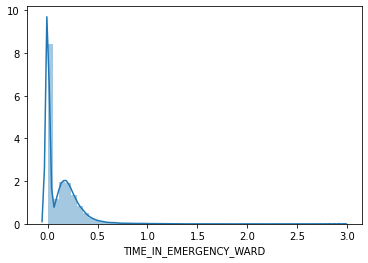

In [40]:
sns.distplot(adm['TIME_IN_EMERGENCY_WARD'])

In [41]:
# convert date string to pd.datetime
adm['DEATHTIME'] = pd.to_datetime(adm['DEATHTIME'])

In [42]:
(adm['DEATHTIME'] - adm['DISCHTIME']).value_counts()

0 days 00:00:00       5789
1 days 00:00:00         29
-1 days +00:00:00       13
2 days 00:00:00          3
-7 days +00:00:00        2
-30 days +00:00:00       1
33 days 00:00:00         1
20 days 00:00:00         1
-1 days +06:53:00        1
-31 days +00:00:00       1
54 days 00:00:00         1
-4 days +00:00:00        1
65 days 00:00:00         1
-1 days +04:35:00        1
3 days 00:00:00          1
-10 days +00:00:00       1
-1 days +12:23:00        1
-3 days +00:00:00        1
-1 days +08:10:00        1
-9 days +00:00:00        1
-1 days +13:30:00        1
12 days 00:00:00         1
-1 days +12:00:00        1
dtype: int64

# Obtain the difference between the death time and discharge time

In [43]:
# get the difference between the death time and discharge time
adm['DIFF_TIME_DEATH_DISCH'] = (adm['DISCHTIME'] - adm['DEATHTIME']).dt.days

In [44]:
adm['DIFF_TIME_DEATH_DISCH'].isna().value_counts()

True     53122
False     5854
Name: DIFF_TIME_DEATH_DISCH, dtype: int64

In [45]:
adm['DIFF_TIME_DEATH_DISCH'].value_counts()

 0.0     5795
-1.0       29
 1.0       13
-2.0        3
 7.0        2
-54.0       1
 4.0        1
-65.0       1
 9.0        1
 30.0       1
-20.0       1
 31.0       1
-3.0        1
 10.0       1
 3.0        1
-12.0       1
-33.0       1
Name: DIFF_TIME_DEATH_DISCH, dtype: int64

## Plot correlation value of the columns

In [46]:
adm.corr()

ROW_ID  SUBJECT_ID   HADM_ID  HOSPITAL_EXPIRE_FLAG  \
ROW_ID                  1.000000    0.943991  0.007482              0.004480   
SUBJECT_ID              0.943991    1.000000  0.007082              0.004339   
HADM_ID                 0.007482    0.007082  1.000000             -0.003120   
HOSPITAL_EXPIRE_FLAG    0.004480    0.004339 -0.003120              1.000000   
HAS_CHARTEVENTS_DATA    0.023013    0.023264 -0.002019              0.045495   
DAYS_IN_HOSPITAL       -0.062274   -0.062315  0.000280              0.000269   
DAYS_WITHIN_NEXT_ADMIT  0.037872    0.040350 -0.001477              0.163618   
TIME_IN_EMERGENCY_WARD  0.026858    0.029537 -0.001514              0.069405   
DIFF_TIME_DEATH_DISCH   0.001039    0.003959 -0.006720                   NaN   

                        HAS_CHARTEVENTS_DATA  DAYS_IN_HOSPITAL  \
ROW_ID                              0.023013         -0.062274   
SUBJECT_ID                          0.023264         -0.062315   
HADM_ID                            -0.002019          0.000280   
HOSPITAL_EXPIRE_FLAG                0.045495          0.000269   
HAS_CHARTEVENTS_DATA                1.000000          0.043179   
DAYS_IN_HOSPITAL                    0.043179          1.000000   
DAYS_WITHIN_NEXT_ADMIT              0.182468         -0.040691   
TIME_IN_EMERGENCY_WARD              0.027330         -0.024758   
DIFF_TIME_DEATH_DISCH              -0.000933          0.000278   

                        DAYS_WITHIN_NEXT_ADMIT  TIME_IN_EMERGENCY_WARD  \
ROW_ID                                0.037872                0.026858   
SUBJECT_ID                            0.040350                0.029537   
HADM_ID                              -0.001477               -0.001514   
HOSPITAL_EXPIRE_FLAG                  0.163618                0.069405   
HAS_CHARTEVENTS_DATA                  0.182468                0.027330   
DAYS_IN_HOSPITAL                     -0.040691               -0.024758   
DAYS_WITHIN_NEXT_ADMIT                1.000000               -0.134968   
TIME_IN_EMERGENCY_WARD               -0.134968                1.000000   
DIFF_TIME_DEATH_DISCH                 0.014509                0.005892   

                        DIFF_TIME_DEATH_DISCH  
ROW_ID                               0.001039  
SUBJECT_ID                           0.003959  
HADM_ID                             -0.006720  
HOSPITAL_EXPIRE_FLAG                      NaN  
HAS_CHARTEVENTS_DATA                -0.000933  
DAYS_IN_HOSPITAL                     0.000278  
DAYS_WITHIN_NEXT_ADMIT               0.014509  
TIME_IN_EMERGENCY_WARD               0.005892  
DIFF_TIME_DEATH_DISCH                1.000000

In [47]:
# get the value counts of the rows that have DAYS_WITHIN_NEXT
(adm['DAYS_WITHIN_NEXT_ADMIT'] <= 30).value_counts()

False    56449
True      2527
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

# Get the target values - The readmissions within next 30 days

In [48]:
adm.loc[:, 'TARGET'] = (adm['DAYS_WITHIN_NEXT_ADMIT'] <= 30).astype(int)

In [49]:
# count the value of the TARGET variable
adm.TARGET.value_counts()

0    56449
1     2527
Name: TARGET, dtype: int64

In [50]:
# verify for NaN values
adm.TARGET.isna().value_counts()

False    58976
Name: TARGET, dtype: int64

In [51]:
cols = [
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'DISCHARGE_LOCATION',
        'INSURANCE',
        'LANGUAGE',
        'RELIGION',
        'ETHNICITY',
        'DIAGNOSIS'
      ]

In [52]:
# verfiy NaN values for each of the above columns
for col in cols:
  print(col)
  print(adm[col].isna().value_counts())
  print('-----------------------------------------')

ADMISSION_TYPE
False    58976
Name: ADMISSION_TYPE, dtype: int64
-----------------------------------------
ADMISSION_LOCATION
False    58976
Name: ADMISSION_LOCATION, dtype: int64
-----------------------------------------
DISCHARGE_LOCATION
False    58976
Name: DISCHARGE_LOCATION, dtype: int64
-----------------------------------------
INSURANCE
False    58976
Name: INSURANCE, dtype: int64
-----------------------------------------
LANGUAGE
False    33644
True     25332
Name: LANGUAGE, dtype: int64
-----------------------------------------
RELIGION
False    58518
True       458
Name: RELIGION, dtype: int64
-----------------------------------------
ETHNICITY
False    58976
Name: ETHNICITY, dtype: int64
-----------------------------------------
DIAGNOSIS
False    58951
True        25
Name: DIAGNOSIS, dtype: int64
-----------------------------------------


## Now we plot and visualize the columns above and decide how the NaN values needs to be filled up 

<AxesSubplot:>

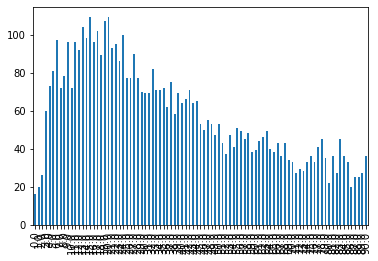

In [53]:
# plot the top 90 values (90 DAYS Readmission days) and its counts as bar plot
adm['DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index()[:90].plot.bar()

<AxesSubplot:>

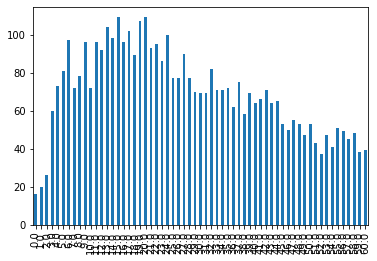

In [54]:
# plot the top 90 values (60 DAYS Readmission days) and its counts as bar plot
adm['DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index()[:60].plot.bar()

<AxesSubplot:>

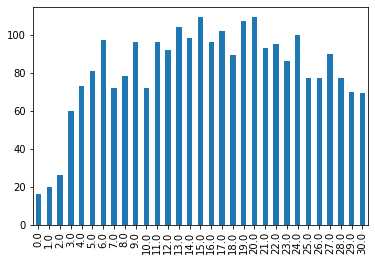

In [55]:
# plot the top 30 values (30 DAYS Readmission days) and its counts as bar plot
adm['DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index()[:30].plot.bar()

<AxesSubplot:>

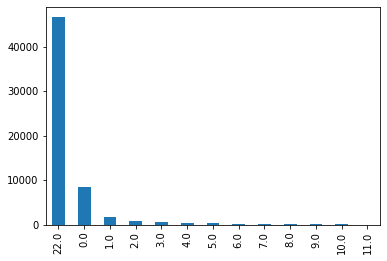

In [56]:
# plot years unit for the next readmission and its counts as bar plot
(adm['DAYS_WITHIN_NEXT_ADMIT'] // 365).value_counts().plot.bar()

<AxesSubplot:>

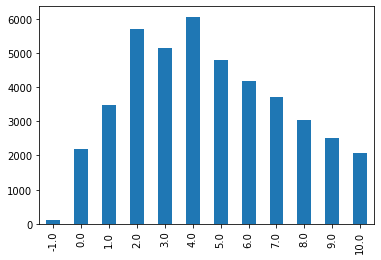

In [57]:
# plot the sorted top 10 days in hospital and its value counts as bar plot 
adm['DAYS_IN_HOSPITAL'].value_counts().sort_index()[:10].plot.bar()

<AxesSubplot:xlabel='DAYS_IN_HOSPITAL'>

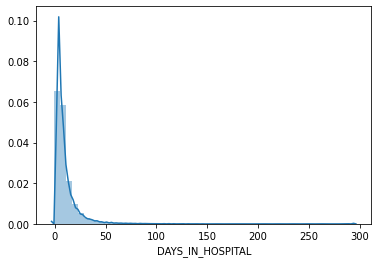

In [58]:
# get the distribution plot of the DAYS IN HOSPITAL values
sns.distplot(adm.DAYS_IN_HOSPITAL)

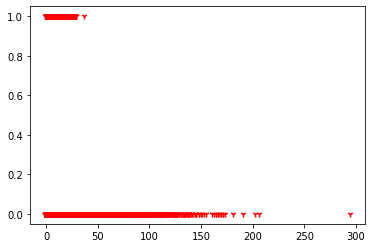

In [59]:
# get the scatter plot of the TARGET values and the DAYS IN HOSPITAL
plt.scatter(adm.DAYS_IN_HOSPITAL, adm.TARGET, c='r', marker='1')

In [60]:
# get the correlation of the TARGET variables
adm.corr()['TARGET']

ROW_ID                    0.003362
SUBJECT_ID                0.006839
HADM_ID                  -0.001086
HOSPITAL_EXPIRE_FLAG     -0.057916
HAS_CHARTEVENTS_DATA     -0.061368
DAYS_IN_HOSPITAL         -0.045178
DAYS_WITHIN_NEXT_ADMIT   -0.435745
TIME_IN_EMERGENCY_WARD    0.042624
DIFF_TIME_DEATH_DISCH    -0.014700
TARGET                    1.000000
Name: TARGET, dtype: float64

<AxesSubplot:xlabel='DAYS_IN_HOSPITAL'>

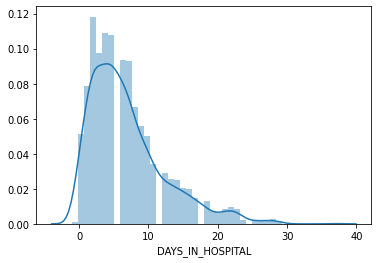

In [61]:
# the distribution plot of the TARGET variable with the DAYS IN HOSPITAL
sns.distplot(adm.loc[adm.TARGET == 1, 'DAYS_IN_HOSPITAL'])

<AxesSubplot:xlabel='DAYS_IN_HOSPITAL'>

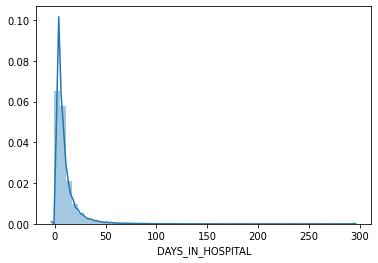

In [62]:
# the distribution plot of the TARGET variable with the DAYS IN HOSPITAL
sns.distplot(adm.loc[adm.TARGET == 0, 'DAYS_IN_HOSPITAL'].fillna(-1))

Now we check the different columns and the corresponding value counts of them and decide for them what NaN values need to be filled and consequently make hypothesis and test them using correlation analysis, regression analysis, and chi-square test

<AxesSubplot:>

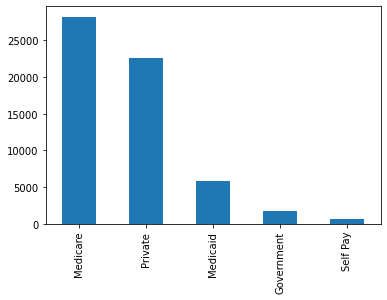

In [63]:
# get insurance plots
adm.INSURANCE.value_counts().plot.bar()

<AxesSubplot:>

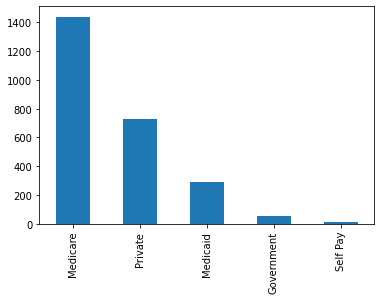

In [64]:
# get insurance plot when TARGET == 1
# there is a high chance that the TARGET == 1 when INSURANCE is Medicare
adm.loc[adm.TARGET == 1, 'INSURANCE'].value_counts().plot.bar()

<AxesSubplot:>

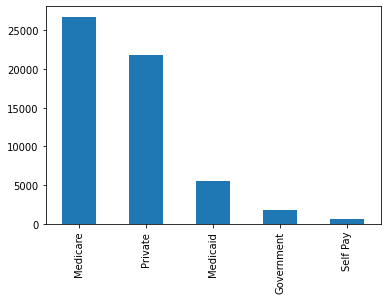

In [65]:
# get insurance plot when TARGET == 0
adm.loc[adm.TARGET == 0, 'INSURANCE'].value_counts().plot.bar()

<AxesSubplot:>

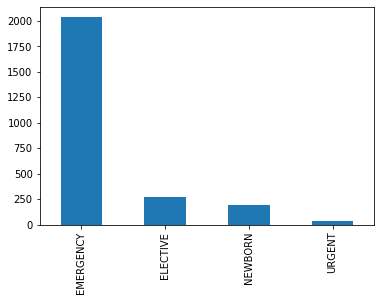

In [66]:
# get the ADMISSION TYPES when TARGET == 1
# most of the ADMISSIONS are EMERGENCY
adm.loc[adm.TARGET == 1].ADMISSION_TYPE.value_counts().plot.bar()

<AxesSubplot:>

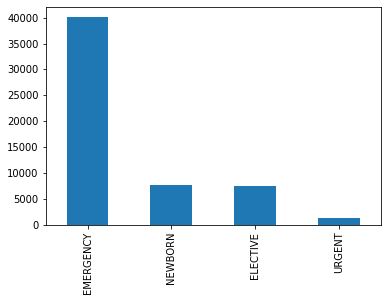

In [67]:
# get the ADMISSION TYPE plot when TARGET == 0
adm.loc[adm.TARGET == 0].ADMISSION_TYPE.value_counts().plot.bar()

In [68]:
adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT', 'TIME_IN_EMERGENCY_WARD',
       'DIFF_TIME_DEATH_DISCH', 'TARGET'],
      dtype='object')

In [69]:
adm.TARGET

211      0
212      0
213      0
214      0
215      0
        ..
56435    0
56436    0
56437    0
56565    0
56566    0
Name: TARGET, Length: 58976, dtype: int64

In [70]:
adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT', 'TIME_IN_EMERGENCY_WARD',
       'DIFF_TIME_DEATH_DISCH', 'TARGET'],
      dtype='object')

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DAYS_WITHIN_NEXT_ADMIT'>

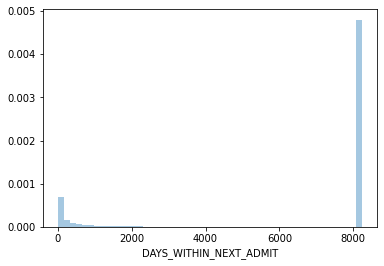

In [71]:
# get the distribution plot for the DAYS_WITHIN_NEXT_ADMIT
sns.distplot(adm.DAYS_WITHIN_NEXT_ADMIT)

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DAYS_WITHIN_NEXT_ADMIT'>

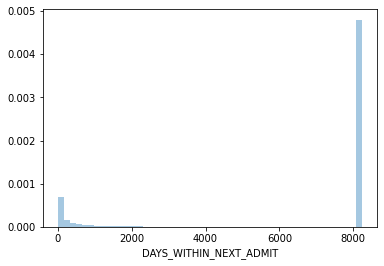

In [72]:
# get the DAYS_WITHIN_NEXT_ADMIT for when DAYS_WITHIN_NEXT_ADMIT is not NaN
sns.distplot(adm.loc[adm.DAYS_WITHIN_NEXT_ADMIT.notna()].DAYS_WITHIN_NEXT_ADMIT)

<AxesSubplot:xlabel='INSURANCE', ylabel='DAYS_WITHIN_NEXT_ADMIT'>

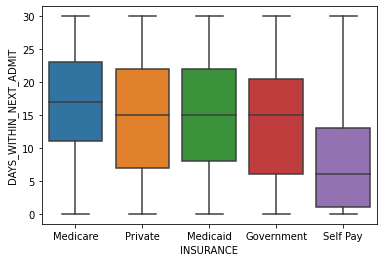

In [73]:
# box plot of the INSURANCE for DAYS WITHIN NEXT ADMIT

sns.boxplot(x='INSURANCE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])

In [74]:
# get spearman correlation for the INSURANCE One hot encoded values with the TARGET values
pd.get_dummies(adm.INSURANCE).corrwith(adm.TARGET, method='spearman')

Government   -0.010463
Medicaid      0.012702
Medicare      0.038558
Private      -0.041441
Self Pay     -0.010898
dtype: float64

In [75]:
# get the INSURANCE correlation one hot representation for the DAYS IN HOSPITAL
pd.get_dummies(adm.INSURANCE).corrwith(adm.DAYS_IN_HOSPITAL, method='spearman')

Government   -0.023306
Medicaid     -0.007343
Medicare      0.097673
Private      -0.077255
Self Pay     -0.050004
dtype: float64

In [76]:
# get the INSURANCE correlation with the TIME IN EMERGENCY WARD
pd.get_dummies(adm.INSURANCE).corrwith(adm.TIME_IN_EMERGENCY_WARD, method='spearman')

Government   -0.002078
Medicaid      0.028020
Medicare      0.195138
Private      -0.222653
Self Pay      0.027396
dtype: float64

<AxesSubplot:xlabel='ADMISSION_TYPE', ylabel='DAYS_WITHIN_NEXT_ADMIT'>

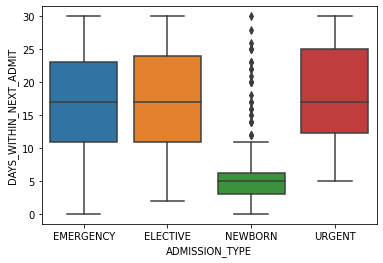

In [77]:
# the boxplot of the ADMISSION TYPE with the DAYS WITHIN NEXT ADMIT
sns.boxplot(x='ADMISSION_TYPE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])

In [78]:
# the ADMISSION TYPE correlation with the TARGET correlation
pd.get_dummies(adm.ADMISSION_TYPE).corrwith(adm.TARGET, method='spearman')

ELECTIVE    -0.015946
EMERGENCY    0.043021
NEWBORN     -0.035694
URGENT      -0.013080
dtype: float64

<AxesSubplot:>

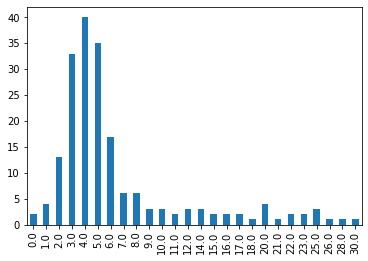

In [79]:
# plot the TARGET == 1 and ADMISSION TYPE == NEWBORN with the DAYS WITHIN NEXT ADMIT bar plot to see the value count distribution
adm.loc[(adm.TARGET == 1) & (adm.ADMISSION_TYPE == 'NEWBORN'), 'DAYS_WITHIN_NEXT_ADMIT'].value_counts().sort_index().plot.bar()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'CLINIC REFERRAL/PREMATURE'),
  Text(1, 0, 'EMERGENCY ROOM ADMIT'),
  Text(2, 0, 'TRANSFER FROM HOSP/EXTRAM'),
  Text(3, 0, 'PHYS REFERRAL/NORMAL DELI'),
  Text(4, 0, 'TRANSFER FROM OTHER HEALT'),
  Text(5, 0, 'HMO REFERRAL/SICK'),
  Text(6, 0, 'TRANSFER FROM SKILLED NUR'),
  Text(7, 0, '** INFO NOT AVAILABLE **')])

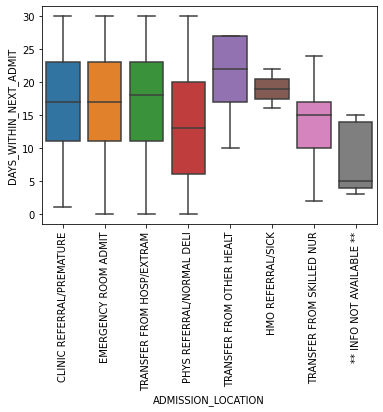

In [80]:
# boxplot for the ADMISSION LOCATION AND THE DAYS WITHIN NEXT ADMIT
sns.boxplot(x='ADMISSION_LOCATION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [81]:
# THE DISCHARGE LOCATION AND THE TARGET correlation
pd.get_dummies(adm.DISCHARGE_LOCATION).corrwith(adm.TARGET, method='spearman')

DEAD/EXPIRED                -0.057916
DISC-TRAN CANCER/CHLDRN H   -0.010013
DISC-TRAN TO FEDERAL HC     -0.002890
DISCH-TRAN TO PSYCH HOSP    -0.011704
HOME                        -0.017296
HOME HEALTH CARE             0.003489
HOME WITH HOME IV PROVIDR    0.000321
HOSPICE-HOME                -0.010405
HOSPICE-MEDICAL FACILITY    -0.010791
ICF                          0.005893
LEFT AGAINST MEDICAL ADVI    0.023872
LONG TERM CARE HOSPITAL      0.047627
OTHER FACILITY               0.000770
REHAB/DISTINCT PART HOSP     0.009277
SHORT TERM HOSPITAL          0.004351
SNF                          0.037230
SNF-MEDICAID ONLY CERTIF    -0.000871
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'HOME HEALTH CARE'),
  Text(1, 0, 'SNF'),
  Text(2, 0, 'HOME'),
  Text(3, 0, 'DEAD/EXPIRED'),
  Text(4, 0, 'SHORT TERM HOSPITAL'),
  Text(5, 0, 'REHAB/DISTINCT PART HOSP'),
  Text(6, 0, 'LONG TERM CARE HOSPITAL'),
  Text(7, 0, 'DISC-TRAN CANCER/CHLDRN H'),
  Text(8, 0, 'LEFT AGAINST MEDICAL ADVI'),
  Text(9, 0, 'HOME WITH HOME IV PROVIDR'),
  Text(10, 0, 'DISCH-TRAN TO PSYCH HOSP'),
  Text(11, 0, 'HOSPICE-HOME'),
  Text(12, 0, 'OTHER FACILITY'),
  Text(13, 0, 'ICF')])

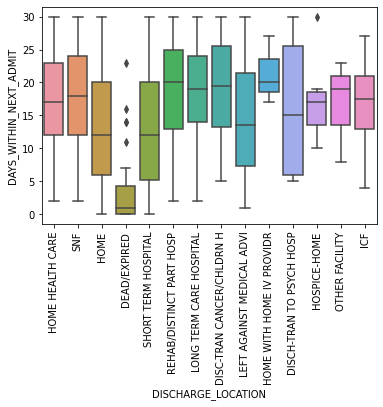

In [82]:
# the DISCHARGE LOCATION BOX PLOT with the DAYS WITHIN NEXT ADMIT when for the patient who are admitted again
sns.boxplot(x='DISCHARGE_LOCATION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'ENGL'),
  Text(1, 0, 'PTUN'),
  Text(2, 0, '*CHI'),
  Text(3, 0, 'RUSS'),
  Text(4, 0, 'SPAN'),
  Text(5, 0, 'PORT'),
  Text(6, 0, 'VIET'),
  Text(7, 0, 'HAIT'),
  Text(8, 0, 'GREE'),
  Text(9, 0, 'CAMB'),
  Text(10, 0, 'CANT'),
  Text(11, 0, '*HUN'),
  Text(12, 0, 'ITAL'),
  Text(13, 0, 'POLI'),
  Text(14, 0, 'CAPE'),
  Text(15, 0, 'ARAB'),
  Text(16, 0, 'MAND'),
  Text(17, 0, 'SOMA'),
  Text(18, 0, 'PERS'),
  Text(19, 0, 'ETHI'),
  Text(20, 0, 'KORE'),
  Text(21, 0, '*YID'),
  Text(22, 0, 'HIND'),
  Text(23, 0, 'AMER'),
  Text(24, 0, '*ARM'),
  Text(25, 0, '*MOR'),
  Text(26, 0, 'ALBA')])

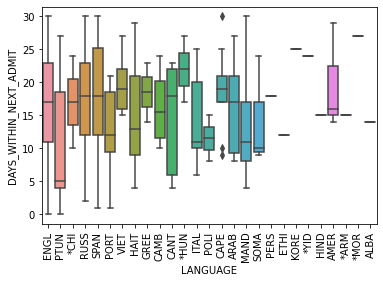

In [83]:
# boxplot for the LANGUAGE and the DAYS WITHIN NEXT ADMIT for the patient who are admitted again
sns.boxplot(x='LANGUAGE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [84]:
# fill the language column with the maximum value occuring in the dataset
adm.loc[adm.LANGUAGE.isna(), 'LANGUAGE'] = adm.LANGUAGE.value_counts().nlargest(1).index[0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'ENGL'),
  Text(1, 0, 'PTUN'),
  Text(2, 0, '*CHI'),
  Text(3, 0, 'RUSS'),
  Text(4, 0, 'SPAN'),
  Text(5, 0, 'PORT'),
  Text(6, 0, 'VIET'),
  Text(7, 0, 'HAIT'),
  Text(8, 0, 'GREE'),
  Text(9, 0, 'CAMB'),
  Text(10, 0, 'CANT'),
  Text(11, 0, '*HUN'),
  Text(12, 0, 'ITAL'),
  Text(13, 0, 'POLI'),
  Text(14, 0, 'CAPE'),
  Text(15, 0, 'ARAB'),
  Text(16, 0, 'MAND'),
  Text(17, 0, 'SOMA'),
  Text(18, 0, 'PERS'),
  Text(19, 0, 'ETHI'),
  Text(20, 0, 'KORE'),
  Text(21, 0, '*YID'),
  Text(22, 0, 'HIND'),
  Text(23, 0, 'AMER'),
  Text(24, 0, '*ARM'),
  Text(25, 0, '*MOR'),
  Text(26, 0, 'ALBA')])

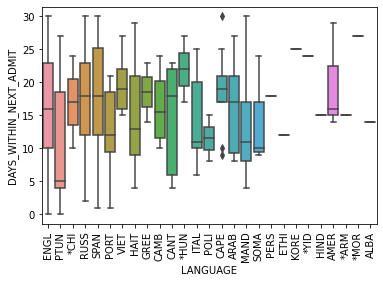

In [85]:
# the BOXPLOT for the LANGUAGE and the DAYS WITHIN NEXT ADMIT for the patient who are admitted again
sns.boxplot(x='LANGUAGE', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'NOT SPECIFIED'),
  Text(1, 0, 'PROTESTANT QUAKER'),
  Text(2, 0, 'CATHOLIC'),
  Text(3, 0, 'JEWISH'),
  Text(4, 0, 'UNOBTAINABLE'),
  Text(5, 0, 'OTHER'),
  Text(6, 0, 'EPISCOPALIAN'),
  Text(7, 0, 'CHRISTIAN SCIENTIST'),
  Text(8, 0, 'GREEK ORTHODOX'),
  Text(9, 0, 'BUDDHIST'),
  Text(10, 0, 'MUSLIM'),
  Text(11, 0, "JEHOVAH'S WITNESS"),
  Text(12, 0, 'UNITARIAN-UNIVERSALIST'),
  Text(13, 0, 'HINDU'),
  Text(14, 0, 'ROMANIAN EAST. ORTH'),
  Text(15, 0, 'HEBREW'),
  Text(16, 0, '7TH DAY ADVENTIST')])

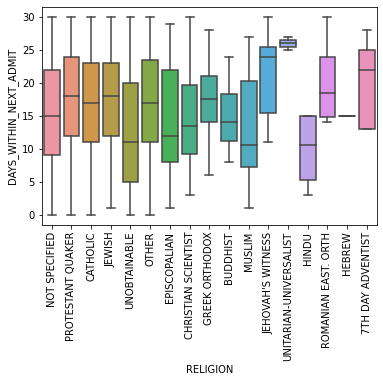

In [86]:
# the boxplot for the RELIGION and the DAYS WITHIN NEXT ADMIT for the patient who are admiited again
sns.boxplot(x='RELIGION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [87]:
adm.RELIGION.value_counts()

CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [88]:
# fill RELIGION column value with 'NOT SPECIFIED'
adm.loc[adm.RELIGION.isna(), 'RELIGION'] = 'NOT SPECIFIED'

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'NOT SPECIFIED'),
  Text(1, 0, 'PROTESTANT QUAKER'),
  Text(2, 0, 'CATHOLIC'),
  Text(3, 0, 'JEWISH'),
  Text(4, 0, 'UNOBTAINABLE'),
  Text(5, 0, 'OTHER'),
  Text(6, 0, 'EPISCOPALIAN'),
  Text(7, 0, 'CHRISTIAN SCIENTIST'),
  Text(8, 0, 'GREEK ORTHODOX'),
  Text(9, 0, 'BUDDHIST'),
  Text(10, 0, 'MUSLIM'),
  Text(11, 0, "JEHOVAH'S WITNESS"),
  Text(12, 0, 'UNITARIAN-UNIVERSALIST'),
  Text(13, 0, 'HINDU'),
  Text(14, 0, 'ROMANIAN EAST. ORTH'),
  Text(15, 0, 'HEBREW'),
  Text(16, 0, '7TH DAY ADVENTIST')])

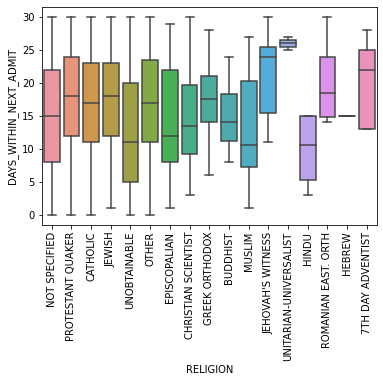

In [89]:
# plot the box plot again after filling NaN values
sns.boxplot(x='RELIGION', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'MARRIED'),
  Text(1, 0, 'SINGLE'),
  Text(2, 0, 'WIDOWED'),
  Text(3, 0, 'DIVORCED'),
  Text(4, 0, 'SEPARATED'),
  Text(5, 0, 'UNKNOWN (DEFAULT)')])

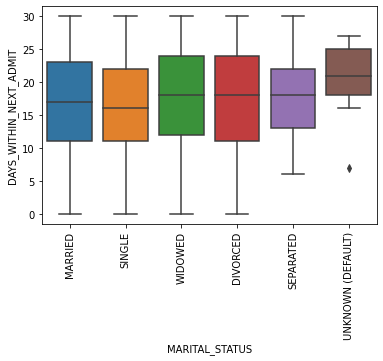

In [90]:
# boxplot of the MARITAL STATUS and the DAYS WITHIN NEXT ADMIT for the patient who are admitted again
sns.boxplot(x='MARITAL_STATUS', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

In [91]:
# check the NaN values
adm.MARITAL_STATUS.isna().value_counts()

False    48848
True     10128
Name: MARITAL_STATUS, dtype: int64

In [92]:
# fill the NaN values with the 'UNKNOWN (DEFAULT)' values as analyzed above
adm.loc[adm.MARITAL_STATUS.isna(), 'MARITAL_STATUS'] = 'UNKNOWN (DEFAULT)'

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'MARRIED'),
  Text(1, 0, 'SINGLE'),
  Text(2, 0, 'WIDOWED'),
  Text(3, 0, 'UNKNOWN (DEFAULT)'),
  Text(4, 0, 'DIVORCED'),
  Text(5, 0, 'SEPARATED')])

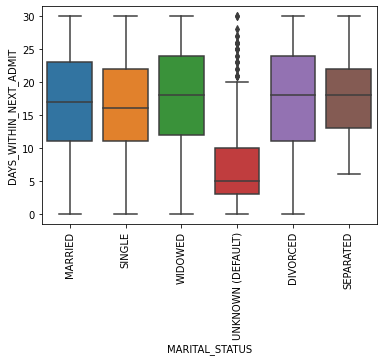

In [93]:
# plot it again after filling NaN values
sns.boxplot(x='MARITAL_STATUS', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'WHITE'),
  Text(1, 0, 'BLACK/AFRICAN AMERICAN'),
  Text(2, 0, 'UNKNOWN/NOT SPECIFIED'),
  Text(3, 0, 'ASIAN'),
  Text(4, 0, 'OTHER'),
  Text(5, 0, 'BLACK/AFRICAN'),
  Text(6, 0, 'HISPANIC OR LATINO'),
  Text(7, 0, 'PATIENT DECLINED TO ANSWER'),
  Text(8, 0, 'HISPANIC/LATINO - PUERTO RICAN'),
  Text(9, 0, 'AMERICAN INDIAN/ALASKA NATIVE'),
  Text(10, 0, 'WHITE - RUSSIAN'),
  Text(11, 0, 'ASIAN - CHINESE'),
  Text(12, 0, 'MIDDLE EASTERN'),
  Text(13, 0, 'MULTI RACE ETHNICITY'),
  Text(14, 0, 'BLACK/HAITIAN'),
  Text(15, 0, 'HISPANIC/LATINO - DOMINICAN'),
  Text(16, 0, 'ASIAN - VIETNAMESE'),
  Text(17, 0, 'WHITE - OTHER EUROPEAN'),
  Text(18, 0, 'ASIAN - ASIAN INDIAN'),
  Text(19, 0, 'UNABLE TO OBTAIN'),
  Text(20, 0, 'PORTUGUESE'),
  Text(21, 0, 'BLACK/CAPE VERDEAN'),
  Text(22, 0, 'ASIAN - FILIPINO'),
  Text(23, 0, 'HISPANIC/LATINO - CENTRAL AMERICAN (OT

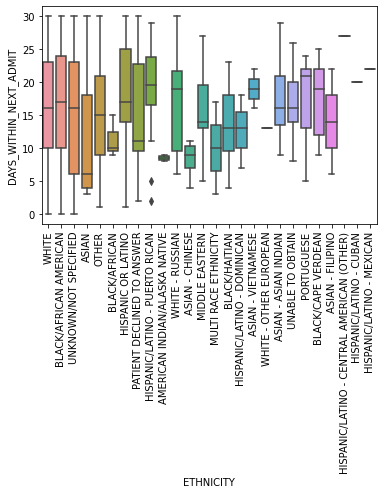

In [94]:
# boxplot for the ETHINICY and DAYS WITHIN NEXT ADMIT for patient re-admitted again
sns.boxplot(x='ETHNICITY', y='DAYS_WITHIN_NEXT_ADMIT', data=adm.loc[adm.TARGET == 1])
plt.xticks(rotation=90)

<AxesSubplot:>

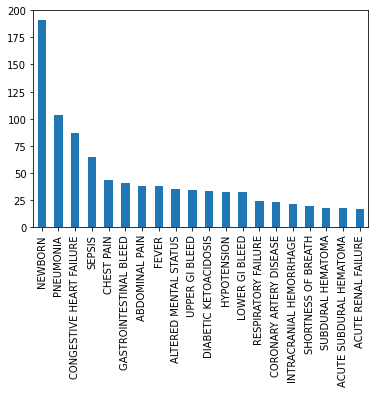

In [95]:
# do analysis on DIAGNOSIS value counts
adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts().nlargest(20).plot.bar()

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DIAGNOSIS'>

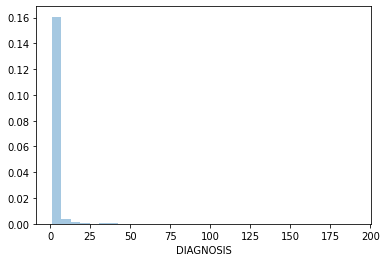

In [96]:
# plot distribution graph for the DIAGNOSIS value counts
sns.distplot(adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts())

Clean the DIAGNOSIS column for further use as a feature

In [97]:
import re, string

In [98]:
# remove the extra punctuations / symbols
diagnosis_re = re.compile(r"[\"#$%&\'\(\)\*+,.:<=>?@\[\\\]^_`\{|\}~]")

In [99]:
# remove the extra -;/ etc which occurs in DIAGNOSIS column
diagnosis_re1 = re.compile(r"[-;/]")

In [100]:
# check the DIAGNOSIS NaN values
adm.DIAGNOSIS.isna().value_counts()

False    58951
True        25
Name: DIAGNOSIS, dtype: int64

In [101]:
# fill the DIAGNOSIS values with UNKNOWN default value
adm.loc[adm.DIAGNOSIS.isna(), 'DIAGNOSIS'] = 'UNKNOWN'

In [102]:
# remove extra spaces and extra punctuation characters
adm.DIAGNOSIS = adm.DIAGNOSIS.apply(lambda x: diagnosis_re1.sub(' ', x)).apply(lambda x: diagnosis_re.sub('', x))

<AxesSubplot:>

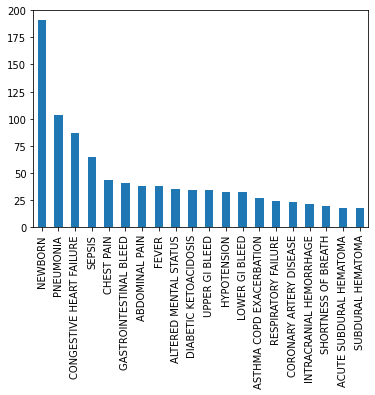

In [103]:
# plot the largest occuring DIAGNOSIS values
adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts().nlargest(20).plot.bar()

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DIAGNOSIS'>

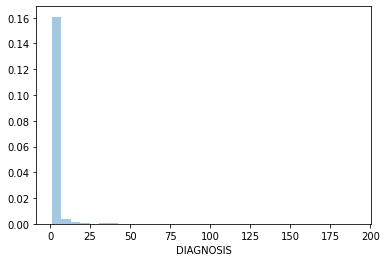

In [104]:
# plot the distribution graph of the DIAGNOSIS values
sns.distplot(adm.loc[adm.TARGET == 1]['DIAGNOSIS'].value_counts())

Do feature engineering on the DIAGNOSIS values

In [105]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [106]:
tfidf = TfidfVectorizer()

In [107]:
# train the TfidfVectorizer object
diagnosis_features = tfidf.fit_transform(adm.DIAGNOSIS.fillna('UNKNOWN').values).toarray()

In [108]:
# get it into a dataframe for further analysis with TARGET column
tfidf_df = pd.DataFrame(diagnosis_features, columns=tfidf.get_feature_names())

In [109]:
del tfidf, diagnosis_features

In [110]:
# copy the TARGET column
tfidf_df.loc[:, 'TARGET'] = adm.TARGET

In [111]:
import gc
gc.collect()

75

In [112]:
# get the correlation of each diagnosis feature with the Target column
corr = []

for col in tfidf_df.columns:
  corr.append(tfidf_df[col].corr(tfidf_df['TARGET'], method='spearman'))

In [113]:
# plot the most correlation wise diagnosis feature with the TARGET column
pd.Series(corr, index=tfidf_df.columns).sort_values(ascending=False)

TARGET                   1.000000
ft                       0.019462
obstructivepulmonary     0.019462
cellulitiscolonoscopy    0.019462
aniogram                 0.019462
                           ...   
embolis                 -0.007362
fibrillation            -0.007768
gangrene                -0.007991
stemi                   -0.008557
airway                  -0.009025
Length: 6294, dtype: float64

In [114]:
# plot the least correlated features wise DIAGNOSIS feature with the TARGET columns
pd.Series(corr, index=tfidf_df.columns).sort_values()

airway                  -0.009025
stemi                   -0.008557
gangrene                -0.007991
fibrillation            -0.007768
embolis                 -0.007362
                           ...   
aniogram                 0.019462
cellulitiscolonoscopy    0.019462
obstructivepulmonary     0.019462
ft                       0.019462
TARGET                   1.000000
Length: 6294, dtype: float64

In [115]:
# get the bool value whether there is any failure word in the diagnosis column
adm.loc[:, 'in_failure'] = adm.DIAGNOSIS.apply(lambda x: int('failure' in x.lower()))

In [116]:
# correlation of in_failure with the TARGET column
adm.in_failure.corr(adm.TARGET)

0.03032207780279582

In [117]:
# correlation of in_failure feature with HOSPITAL_EXPIRE_FLAG
adm.in_failure.corr(adm.HOSPITAL_EXPIRE_FLAG)

0.062478071812382394

In [118]:
# correlation of HOSPITAL_EXPIRE_FLAG with the TARGET column
adm['HOSPITAL_EXPIRE_FLAG'].astype(int).corr(adm.TARGET)

-0.057915975095876454

In [119]:
del tfidf_df

In [120]:
gc.collect()

100

In [121]:
# check the correlation of the columns by LabelEncoding them
from sklearn.preprocessing import LabelEncoder

In [122]:
le = LabelEncoder()

In [123]:
new_adm = adm.copy()

In [124]:
# verify the NaN values in the columns
for col in new_adm.columns:
  print(col)
  print(new_adm[col].isna().value_counts().index)
  print('----------------------------------------------')

ROW_ID
Index([False], dtype='object')
----------------------------------------------
SUBJECT_ID
Index([False], dtype='object')
----------------------------------------------
HADM_ID
Index([False], dtype='object')
----------------------------------------------
ADMITTIME
Index([False], dtype='object')
----------------------------------------------
DISCHTIME
Index([False], dtype='object')
----------------------------------------------
DEATHTIME
Index([True, False], dtype='object')
----------------------------------------------
ADMISSION_TYPE
Index([False], dtype='object')
----------------------------------------------
ADMISSION_LOCATION
Index([False], dtype='object')
----------------------------------------------
DISCHARGE_LOCATION
Index([False], dtype='object')
----------------------------------------------
INSURANCE
Index([False], dtype='object')
----------------------------------------------
LANGUAGE
Index([False], dtype='object')
----------------------------------------------
RELIGION

In [125]:
cols = [
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'DISCHARGE_LOCATION',
        'INSURANCE',
        'LANGUAGE',
        'RELIGION',
        'ETHNICITY',
        'DIAGNOSIS'
]

In [126]:
# LabelEncode only the above columns
for col in cols:
  new_adm[col + '_le'] = le.fit_transform(new_adm[col])

In [127]:
new_adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT', 'TIME_IN_EMERGENCY_WARD',
       'DIFF_TIME_DEATH_DISCH', 'TARGET', 'in_failure', 'ADMISSION_TYPE_le',
       'ADMISSION_LOCATION_le', 'DISCHARGE_LOCATION_le', 'INSURANCE_le',
       'LANGUAGE_le', 'RELIGION_le', 'ETHNICITY_le', 'DIAGNOSIS_le'],
      dtype='object')

In [128]:
# check the correlation of the above label encoded column with the TARGET columns
new_adm.corr(method="spearman")['TARGET'].filter(like='le')

ADMISSION_TYPE_le       -0.016746
ADMISSION_LOCATION_le   -0.028276
DISCHARGE_LOCATION_le    0.068068
INSURANCE_le            -0.037283
LANGUAGE_le              0.003980
RELIGION_le             -0.014266
ETHNICITY_le            -0.009986
DIAGNOSIS_le            -0.014893
Name: TARGET, dtype: float64

<AxesSubplot:>

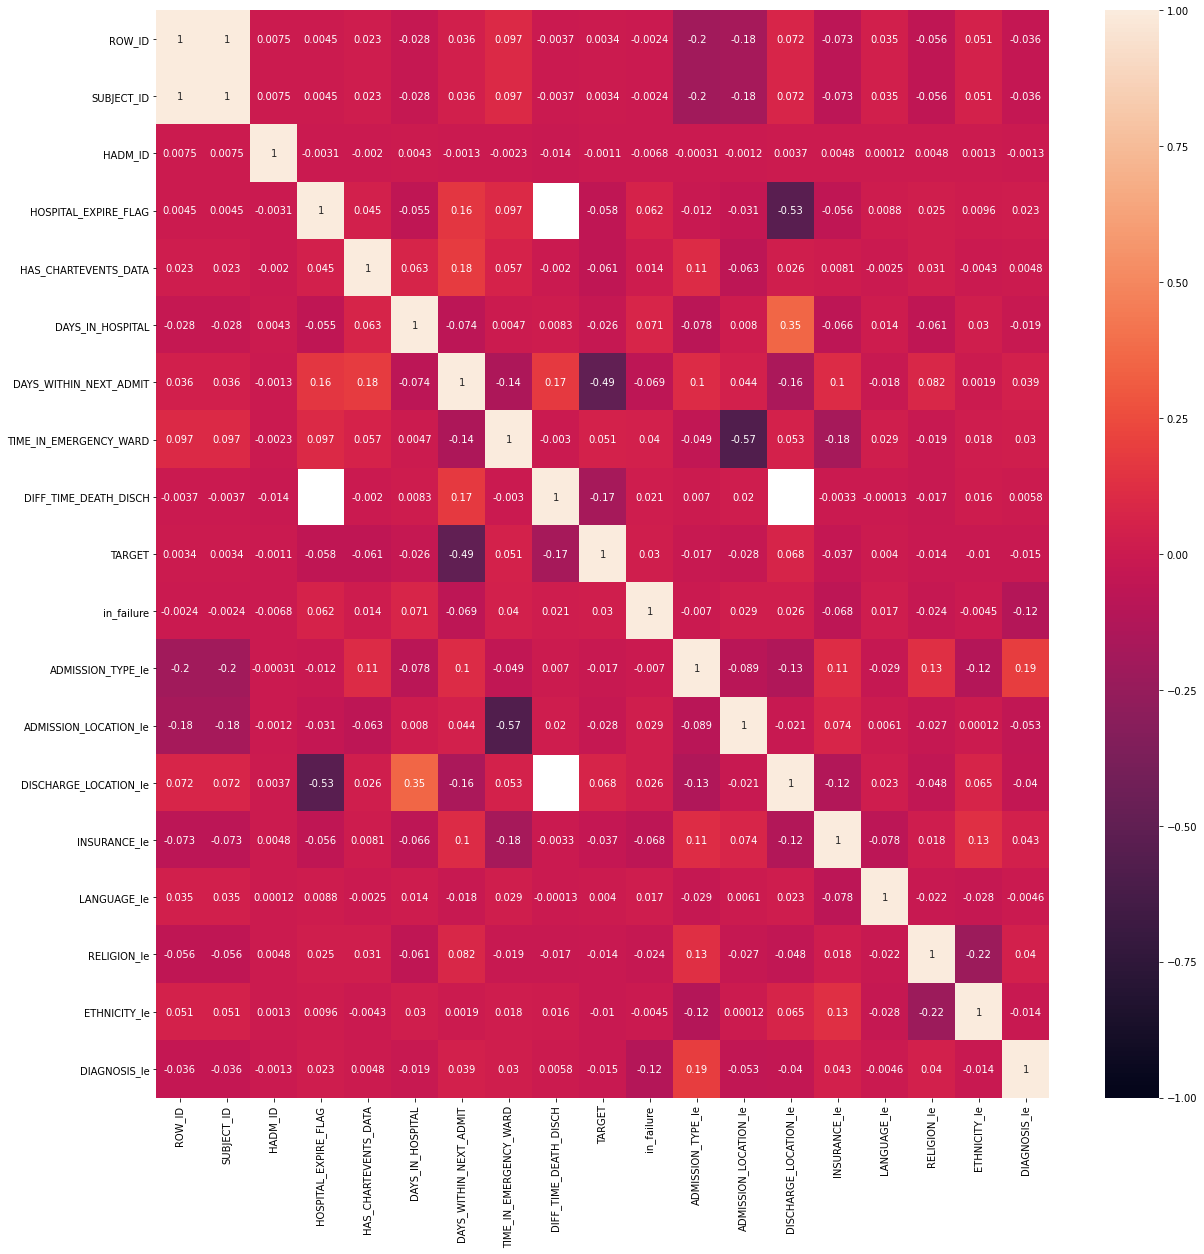

In [129]:
# plot the heatmap to get a sense of correlation distribution
plt.figure(figsize=(20, 20))
sns.heatmap(new_adm.corr(method="spearman"), vmin=-1, vmax=1, annot=True)

In [130]:
cols = [
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'DISCHARGE_LOCATION',
        'INSURANCE',
        'LANGUAGE',
        'RELIGION',
        'ETHNICITY',
        # 'DIAGNOSIS'
]

In [131]:
# check the correlation by doing One Hot Encoding of the above cols only
from sklearn.preprocessing import OneHotEncoder

In [132]:
ohe = OneHotEncoder()

In [133]:
new_adm1 = adm.copy()

In [134]:
# verify for NaN values and change the representation to the One Hot Encoding
for index, col in enumerate(cols):
  # print(col, new_adm1[col].isna().value_counts().index)
  sp_mat = ohe.fit_transform(new_adm1[col].values.reshape((-1, 1)))
  new_adm1 = pd.concat([new_adm1, pd.DataFrame(sp_mat.toarray(), columns=[col + 'ohe_{}'.format(i) for i in range(sp_mat[0].shape[1])])], axis=1)
  # print(new_adm[col].isna().value_counts().index)
  # print(new_adm[cols[index + 1:index + 2]].value_counts().index)
  # print('-----------------------')

In [135]:
new_adm1.DAYS_WITHIN_NEXT_ADMIT.isna().value_counts()

False    58976
Name: DAYS_WITHIN_NEXT_ADMIT, dtype: int64

In [136]:
new_adm1.TARGET.isna().value_counts()

False    58976
Name: TARGET, dtype: int64

In [137]:
# import for chisquare tests
from scipy.stats import chisquare

In [138]:
# do chisquare test for the DAYS_WITHIN_NEXT_ADMIT and TARGET values
chisquare(new_adm1[['DAYS_WITHIN_NEXT_ADMIT', 'TARGET']].astype(float))

Power_divergenceResult(statistic=array([9.13548875e+07, 5.64490000e+04]), pvalue=array([0., 1.]))

In [139]:
# do the chisquare test for the numeric columns with the TARGET columns
for each_col in new_adm1.columns:
  if pd.api.types.is_numeric_dtype(new_adm1[each_col]):
    print(each_col, chisquare(new_adm1[[each_col, 'TARGET']]))

ROW_ID Power_divergenceResult(statistic=array([5.79684933e+08, 5.64490000e+04]), pvalue=array([0., 1.]))
SUBJECT_ID Power_divergenceResult(statistic=array([1.37882804e+09, 5.64490000e+04]), pvalue=array([0., 1.]))
HADM_ID Power_divergenceResult(statistic=array([3.28056523e+08, 5.64490000e+04]), pvalue=array([0., 1.]))
HOSPITAL_EXPIRE_FLAG Power_divergenceResult(statistic=array([53122., 56449.]), pvalue=array([1., 1.]))
HAS_CHARTEVENTS_DATA Power_divergenceResult(statistic=array([ 1592., 56449.]), pvalue=array([1., 1.]))
DAYS_IN_HOSPITAL Power_divergenceResult(statistic=array([951547.56210755,  56449.        ]), pvalue=array([0., 1.]))
DAYS_WITHIN_NEXT_ADMIT Power_divergenceResult(statistic=array([9.13548875e+07, 5.64490000e+04]), pvalue=array([0., 1.]))
TIME_IN_EMERGENCY_WARD Power_divergenceResult(statistic=array([13480.02120254, 56449.        ]), pvalue=array([1., 1.]))
DIFF_TIME_DEATH_DISCH Power_divergenceResult(statistic=array([   nan, 56449.]), pvalue=array([nan,  1.]))
TARGET Po

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


LANGUAGEohe_26 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_27 Power_divergenceResult(statistic=array([58973., 56449.]), pvalue=array([0.50154884, 1.        ]))
LANGUAGEohe_28 Power_divergenceResult(statistic=array([58974., 56449.]), pvalue=array([0.50038721, 1.        ]))
LANGUAGEohe_29 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_30 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_31 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_32 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_33 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.49922559, 1.        ]))
LANGUAGEohe_34 Power_divergenceResult(statistic=array([58975., 56449.]), pvalue=array([0.4992255

# Regression Tests, and Linear Classifier Tests

In [140]:
from xgboost import XGBClassifier

In [141]:
from sklearn.linear_model import LinearRegression

In [142]:
# we check the roc_auc_score for classifier and the r2_score for the regressions tests
from sklearn.metrics import r2_score, roc_auc_score

In [143]:
# check the regression analysis for each column for each other numeric column to find any linear relation between them
for col in new_adm.columns:
  for other_col in new_adm.columns:
    if col != 'TARGET' and other_col != 'TARGET' and (pd.api.types.is_numeric_dtype(new_adm[col]) and pd.api.types.is_numeric_dtype(new_adm[other_col])):
      lr = LinearRegression()
      lr.fit(new_adm[col].fillna(-1).values.reshape((-1, 1)), new_adm[other_col].fillna(-1).values.reshape((-1, 1)))
      print(col, other_col, r2_score(new_adm[col].fillna(-1), lr.predict(new_adm[other_col].fillna(-1).values.reshape((-1, 1)))))

ROW_ID ROW_ID 1.0
ROW_ID SUBJECT_ID -2.1646076825618117
ROW_ID HADM_ID -51.36110910283998
ROW_ID HOSPITAL_EXPIRE_FLAG -3.00008201303552
ROW_ID HAS_CHARTEVENTS_DATA -2.999905072263369
ROW_ID DAYS_IN_HOSPITAL -2.9978733943166036
ROW_ID DAYS_WITHIN_NEXT_ADMIT -1.8327641038120146
ROW_ID TIME_IN_EMERGENCY_WARD -3.000077732163404
ROW_ID DIFF_TIME_DEATH_DISCH -3.0002859056720244
ROW_ID in_failure -3.0000896856212282
ROW_ID ADMISSION_TYPE_le -2.999848678754696
ROW_ID ADMISSION_LOCATION_le -2.999464187804857
ROW_ID DISCHARGE_LOCATION_le -2.9988105192080985
ROW_ID INSURANCE_le -2.9996290152779475
ROW_ID LANGUAGE_le -2.9898225277487414
ROW_ID RELIGION_le -2.9978924820633632
ROW_ID ETHNICITY_le -2.993739466390054
ROW_ID DIAGNOSIS_le -1.571207395009484
SUBJECT_ID ROW_ID 0.47734422594874315
SUBJECT_ID SUBJECT_ID 1.0
SUBJECT_ID HADM_ID -17.36384683064431
SUBJECT_ID HOSPITAL_EXPIRE_FLAG -1.443804230631613
SUBJECT_ID HAS_CHARTEVENTS_DATA -1.4437297413527448
SUBJECT_ID DAYS_IN_HOSPITAL -1.44291084166173

ADMISSION_TYPE_le HADM_ID -49739746274435.49
ADMISSION_TYPE_le HOSPITAL_EXPIRE_FLAG -2.531714480789813
ADMISSION_TYPE_le HAS_CHARTEVENTS_DATA -0.015567050562431017
ADMISSION_TYPE_le DAYS_IN_HOSPITAL -1637.4252354837524
ADMISSION_TYPE_le DAYS_WITHIN_NEXT_ADMIT -41945501739600.79
ADMISSION_TYPE_le TIME_IN_EMERGENCY_WARD -2.3371414054149087
ADMISSION_TYPE_le DIFF_TIME_DEATH_DISCH -10.708379329407514
ADMISSION_TYPE_le in_failure -2.781848834295065
ADMISSION_TYPE_le ADMISSION_TYPE_le 1.0
ADMISSION_TYPE_le ADMISSION_LOCATION_le -7.105911189665804
ADMISSION_TYPE_le DISCHARGE_LOCATION_le -38.557239297389884
ADMISSION_TYPE_le INSURANCE_le -4.742119999381381
ADMISSION_TYPE_le LANGUAGE_le -4218.240607727716
ADMISSION_TYPE_le RELIGION_le -1204.0477993020936
ADMISSION_TYPE_le ETHNICITY_le -1380.223732715621
ADMISSION_TYPE_le DIAGNOSIS_le -418281415835962.94
ADMISSION_LOCATION_le ROW_ID -1697998979441083.0
ADMISSION_LOCATION_le SUBJECT_ID -8421003668281322.0
ADMISSION_LOCATION_le HADM_ID -1130292034

In [144]:
# check whether each col is associated with the TARGET col using some decision rul using xgboost classifier
for col in new_adm.columns:
  if col != 'TARGET' and pd.api.types.is_numeric_dtype(new_adm[col]):
    lr = XGBClassifier()
    lr.fit(new_adm[col].fillna(-1).values.reshape((-1, 1)), new_adm.TARGET.values.reshape((-1, 1)))
    print(roc_auc_score(new_adm.TARGET.values, lr.predict(new_adm[col].fillna(-1).values.reshape((-1, 1)))))

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5039484040221548


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5044534177300504


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1.0


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5


In [145]:
# do regression test for each col with each other col that are numeric for the one hot encoded columns
for col in new_adm1.columns:
  for other_col in new_adm1.columns:
    if col != 'TARGET' and other_col != 'TARGET' and (pd.api.types.is_numeric_dtype(new_adm1[col]) and pd.api.types.is_numeric_dtype(new_adm1[other_col])):
      lr = LinearRegression()
      print(col, other_col)
      lr.fit(new_adm1[col].fillna(-1).values.reshape((-1, 1)), new_adm1[other_col].fillna(-1).values.reshape((-1, 1)))
      print(col, other_col, r2_score(new_adm1[col].fillna(-1), lr.predict(new_adm1[other_col].fillna(-1).values.reshape((-1, 1)))))

ROW_ID ROW_ID
ROW_ID ROW_ID 1.0
ROW_ID SUBJECT_ID
ROW_ID SUBJECT_ID -2.1646076825618077
ROW_ID HADM_ID
ROW_ID HADM_ID -51.36110910283998
ROW_ID HOSPITAL_EXPIRE_FLAG
ROW_ID HOSPITAL_EXPIRE_FLAG -3.00008201303552
ROW_ID HAS_CHARTEVENTS_DATA
ROW_ID HAS_CHARTEVENTS_DATA -2.9999050722633696
ROW_ID DAYS_IN_HOSPITAL
ROW_ID DAYS_IN_HOSPITAL -2.9978733943166036
ROW_ID DAYS_WITHIN_NEXT_ADMIT
ROW_ID DAYS_WITHIN_NEXT_ADMIT -1.8327641038120146
ROW_ID TIME_IN_EMERGENCY_WARD
ROW_ID TIME_IN_EMERGENCY_WARD -3.000077732163403
ROW_ID DIFF_TIME_DEATH_DISCH
ROW_ID DIFF_TIME_DEATH_DISCH -3.0002859056720235
ROW_ID in_failure
ROW_ID in_failure -3.000089685621229
ROW_ID ADMISSION_TYPEohe_0
ROW_ID ADMISSION_TYPEohe_0 -3.0000805611356505
ROW_ID ADMISSION_TYPEohe_1
ROW_ID ADMISSION_TYPEohe_1 -2.999982469888855
ROW_ID ADMISSION_TYPEohe_2
ROW_ID ADMISSION_TYPEohe_2 -3.000046194000646
ROW_ID ADMISSION_TYPEohe_3
ROW_ID ADMISSION_TYPEohe_3 -3.0000942519049705
ROW_ID ADMISSION_LOCATIONohe_0
ROW_ID ADMISSION_LOCATIONohe

ROW_ID RELIGIONohe_6 -3.000100273943338
ROW_ID RELIGIONohe_7
ROW_ID RELIGIONohe_7 -3.000101628776253
ROW_ID RELIGIONohe_8
ROW_ID RELIGIONohe_8 -3.0001014449520227
ROW_ID RELIGIONohe_9
ROW_ID RELIGIONohe_9 -3.000101222153731
ROW_ID RELIGIONohe_10
ROW_ID RELIGIONohe_10 -3.000081056854108
ROW_ID RELIGIONohe_11
ROW_ID RELIGIONohe_11 -3.0001017322968995
ROW_ID RELIGIONohe_12
ROW_ID RELIGIONohe_12 -3.000101675844781
ROW_ID RELIGIONohe_13
ROW_ID RELIGIONohe_13 -3.0001009068204114
ROW_ID RELIGIONohe_14
ROW_ID RELIGIONohe_14 -3.000076093452252
ROW_ID RELIGIONohe_15
ROW_ID RELIGIONohe_15 -3.000089125982158
ROW_ID RELIGIONohe_16
ROW_ID RELIGIONohe_16 -3.0000775931052193
ROW_ID RELIGIONohe_17
ROW_ID RELIGIONohe_17 -3.000101563830822
ROW_ID RELIGIONohe_18
ROW_ID RELIGIONohe_18 -3.0001013434071115
ROW_ID RELIGIONohe_19
ROW_ID RELIGIONohe_19 -3.000059496219201
ROW_ID ETHNICITYohe_0
ROW_ID ETHNICITYohe_0 -3.0001014615570956
ROW_ID ETHNICITYohe_1
ROW_ID ETHNICITYohe_1 -3.0001017406884127
ROW_ID ETHNICI

SUBJECT_ID LANGUAGEohe_29 -1.4438125892818605
SUBJECT_ID LANGUAGEohe_30
SUBJECT_ID LANGUAGEohe_30 -1.4438125910354134
SUBJECT_ID LANGUAGEohe_31
SUBJECT_ID LANGUAGEohe_31 -1.443812585418077
SUBJECT_ID LANGUAGEohe_32
SUBJECT_ID LANGUAGEohe_32 -1.4438125851471404
SUBJECT_ID LANGUAGEohe_33
SUBJECT_ID LANGUAGEohe_33 -1.4438125867061293
SUBJECT_ID LANGUAGEohe_34
SUBJECT_ID LANGUAGEohe_34 -1.4438125857130246
SUBJECT_ID LANGUAGEohe_35
SUBJECT_ID LANGUAGEohe_35 -1.4438125858305941
SUBJECT_ID LANGUAGEohe_36
SUBJECT_ID LANGUAGEohe_36 -1.4438125911115383
SUBJECT_ID LANGUAGEohe_37
SUBJECT_ID LANGUAGEohe_37 -1.4438125866086544
SUBJECT_ID LANGUAGEohe_38
SUBJECT_ID LANGUAGEohe_38 -1.4438125865399152
SUBJECT_ID LANGUAGEohe_39
SUBJECT_ID LANGUAGEohe_39 -1.4438125823378165
SUBJECT_ID LANGUAGEohe_40
SUBJECT_ID LANGUAGEohe_40 -1.4438125778289153
SUBJECT_ID LANGUAGEohe_41
SUBJECT_ID LANGUAGEohe_41 -1.4438125847082959
SUBJECT_ID LANGUAGEohe_42
SUBJECT_ID LANGUAGEohe_42 -1.4438125882352137
SUBJECT_ID LANGUAGE

HADM_ID ADMISSION_LOCATIONohe_2 -26.96069120551593
HADM_ID ADMISSION_LOCATIONohe_3
HADM_ID ADMISSION_LOCATIONohe_3 -26.960836762447006
HADM_ID ADMISSION_LOCATIONohe_4
HADM_ID ADMISSION_LOCATIONohe_4 -26.96074662923722
HADM_ID ADMISSION_LOCATIONohe_5
HADM_ID ADMISSION_LOCATIONohe_5 -26.960785266346228
HADM_ID ADMISSION_LOCATIONohe_6
HADM_ID ADMISSION_LOCATIONohe_6 -26.960836630025725
HADM_ID ADMISSION_LOCATIONohe_7
HADM_ID ADMISSION_LOCATIONohe_7 -26.96083610094454
HADM_ID ADMISSION_LOCATIONohe_8
HADM_ID ADMISSION_LOCATIONohe_8 -26.96083701173969
HADM_ID DISCHARGE_LOCATIONohe_0
HADM_ID DISCHARGE_LOCATIONohe_0 -26.960799646737833
HADM_ID DISCHARGE_LOCATIONohe_1
HADM_ID DISCHARGE_LOCATIONohe_1 -26.960831417627414
HADM_ID DISCHARGE_LOCATIONohe_2
HADM_ID DISCHARGE_LOCATIONohe_2 -26.96083678407323
HADM_ID DISCHARGE_LOCATIONohe_3
HADM_ID DISCHARGE_LOCATIONohe_3 -26.960833517401078
HADM_ID DISCHARGE_LOCATIONohe_4
HADM_ID DISCHARGE_LOCATIONohe_4 -26.960723279814776
HADM_ID DISCHARGE_LOCATIONohe

HADM_ID RELIGIONohe_16 -26.960796649413492
HADM_ID RELIGIONohe_17
HADM_ID RELIGIONohe_17 -26.960836643770318
HADM_ID RELIGIONohe_18
HADM_ID RELIGIONohe_18 -26.960836007684843
HADM_ID RELIGIONohe_19
HADM_ID RELIGIONohe_19 -26.960788434098767
HADM_ID ETHNICITYohe_0
HADM_ID ETHNICITYohe_0 -26.96083719451609
HADM_ID ETHNICITYohe_1
HADM_ID ETHNICITYohe_1 -26.960837020121517
HADM_ID ETHNICITYohe_2
HADM_ID ETHNICITYohe_2 -26.96082668268559
HADM_ID ETHNICITYohe_3
HADM_ID ETHNICITYohe_3 -26.960836672681854
HADM_ID ETHNICITYohe_4
HADM_ID ETHNICITYohe_4 -26.960836788898764
HADM_ID ETHNICITYohe_5
HADM_ID ETHNICITYohe_5 -26.960835511654757
HADM_ID ETHNICITYohe_6
HADM_ID ETHNICITYohe_6 -26.960836924213602
HADM_ID ETHNICITYohe_7
HADM_ID ETHNICITYohe_7 -26.96083703002666
HADM_ID ETHNICITYohe_8
HADM_ID ETHNICITYohe_8 -26.96083698352573
HADM_ID ETHNICITYohe_9
HADM_ID ETHNICITYohe_9 -26.96083688522891
HADM_ID ETHNICITYohe_10
HADM_ID ETHNICITYohe_10 -26.96083703768005
HADM_ID ETHNICITYohe_11
HADM_ID ETHNI

HOSPITAL_EXPIRE_FLAG LANGUAGEohe_31 -0.11015737005788684
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_32
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_32 -0.11015737005788684
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_33
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_33 -0.11019909940102224
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_34
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_34 -0.11019909940102224
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_35
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_35 -0.11015737005788684
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_36
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_36 -0.11015737005788684
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_37
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_37 -0.11011553335810675
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_38
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_38 -0.1101155838541985
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_39
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_39 -0.11015731241637172
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_40
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_40 -0.11011535333214151
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_41
HOSPITAL_EXPIRE_FLAG LANGUAGEohe_41 -0.1099900851802964
HOSPITAL_EXPIRE

HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_4 -9.383485721398023
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_5
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_5 -30.964376869725346
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_6
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_6 -35.90580495203992
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_7
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_7 -35.58190947194688
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_8
HAS_CHARTEVENTS_DATA ADMISSION_LOCATIONohe_8 -36.04522556818024
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_0
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_0 -34.1602913918102
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_1
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_1 -32.4475934629712
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_2
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_2 -36.04522340842616
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_3
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_3 -35.9485091839196
HAS_CHARTEVENTS_DATA DISCHARGE_LOCATIONohe_4
HAS_CHARTEVENTS_DATA 

HAS_CHARTEVENTS_DATA ETHNICITYohe_0 -36.04516763441618
HAS_CHARTEVENTS_DATA ETHNICITYohe_1
HAS_CHARTEVENTS_DATA ETHNICITYohe_1 -36.045225928159454
HAS_CHARTEVENTS_DATA ETHNICITYohe_2
HAS_CHARTEVENTS_DATA ETHNICITYohe_2 -33.41669704928899
HAS_CHARTEVENTS_DATA ETHNICITYohe_3
HAS_CHARTEVENTS_DATA ETHNICITYohe_3 -35.95218741613848
HAS_CHARTEVENTS_DATA ETHNICITYohe_4
HAS_CHARTEVENTS_DATA ETHNICITYohe_4 -36.04521962914501
HAS_CHARTEVENTS_DATA ETHNICITYohe_5
HAS_CHARTEVENTS_DATA ETHNICITYohe_5 -35.48991118973441
HAS_CHARTEVENTS_DATA ETHNICITYohe_6
HAS_CHARTEVENTS_DATA ETHNICITYohe_6 -36.04521207127827
HAS_CHARTEVENTS_DATA ETHNICITYohe_7
HAS_CHARTEVENTS_DATA ETHNICITYohe_7 -36.04522502822535
HAS_CHARTEVENTS_DATA ETHNICITYohe_8
HAS_CHARTEVENTS_DATA ETHNICITYohe_8 -35.998708413183124
HAS_CHARTEVENTS_DATA ETHNICITYohe_9
HAS_CHARTEVENTS_DATA ETHNICITYohe_9 -36.04521962914501
HAS_CHARTEVENTS_DATA ETHNICITYohe_10
HAS_CHARTEVENTS_DATA ETHNICITYohe_10 -36.04522577066739
HAS_CHARTEVENTS_DATA ETHNICITYo

DAYS_IN_HOSPITAL LANGUAGEohe_36 -0.5956572252703929
DAYS_IN_HOSPITAL LANGUAGEohe_37
DAYS_IN_HOSPITAL LANGUAGEohe_37 -0.5956619812471207
DAYS_IN_HOSPITAL LANGUAGEohe_38
DAYS_IN_HOSPITAL LANGUAGEohe_38 -0.5956558255030828
DAYS_IN_HOSPITAL LANGUAGEohe_39
DAYS_IN_HOSPITAL LANGUAGEohe_39 -0.5956549136186302
DAYS_IN_HOSPITAL LANGUAGEohe_40
DAYS_IN_HOSPITAL LANGUAGEohe_40 -0.5956555010440991
DAYS_IN_HOSPITAL LANGUAGEohe_41
DAYS_IN_HOSPITAL LANGUAGEohe_41 -0.5956443975736481
DAYS_IN_HOSPITAL LANGUAGEohe_42
DAYS_IN_HOSPITAL LANGUAGEohe_42 -0.595657485809787
DAYS_IN_HOSPITAL LANGUAGEohe_43
DAYS_IN_HOSPITAL LANGUAGEohe_43 -0.5956214118222276
DAYS_IN_HOSPITAL LANGUAGEohe_44
DAYS_IN_HOSPITAL LANGUAGEohe_44 -0.5955937394931796
DAYS_IN_HOSPITAL LANGUAGEohe_45
DAYS_IN_HOSPITAL LANGUAGEohe_45 -0.5955912707891757
DAYS_IN_HOSPITAL LANGUAGEohe_46
DAYS_IN_HOSPITAL LANGUAGEohe_46 -0.595664944257098
DAYS_IN_HOSPITAL LANGUAGEohe_47
DAYS_IN_HOSPITAL LANGUAGEohe_47 -0.5956076137269664
DAYS_IN_HOSPITAL LANGUAGEo

DAYS_WITHIN_NEXT_ADMIT ADMISSION_LOCATIONohe_6 -4.262333886438334
DAYS_WITHIN_NEXT_ADMIT ADMISSION_LOCATIONohe_7
DAYS_WITHIN_NEXT_ADMIT ADMISSION_LOCATIONohe_7 -4.262327900201574
DAYS_WITHIN_NEXT_ADMIT ADMISSION_LOCATIONohe_8
DAYS_WITHIN_NEXT_ADMIT ADMISSION_LOCATIONohe_8 -4.262336100550473
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_0
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_0 -4.262338458223292
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_1
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_1 -4.262315006242168
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_2
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_2 -4.262336001225991
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_3
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_3 -4.2623296659240255
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_4
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_4 -4.26197745224681
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_5
DAYS_WITHIN_NEXT_ADMIT DISCHARGE_LOCATIONohe_5 -4.2619841497364
DAYS_WITHIN_NEXT_ADMIT DISCHARGE

DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_58 -4.2623362122865585
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_59
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_59 -4.262335906484596
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_60
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_60 -4.26233610258697
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_61
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_61 -4.262334030588721
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_62
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_62 -4.262334032876291
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_63
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_63 -4.262335179767751
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_64
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_64 -4.262329317729701
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_65
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_65 -4.262325682591939
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_66
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_66 -4.262309108353388
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_67
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_67 -4.262336209727132
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_68
DAYS_WITHIN_NEXT_ADMIT LANGUAGEohe_68 -4.262335529

TIME_IN_EMERGENCY_WARD INSURANCEohe_4 -0.4746782781945762
TIME_IN_EMERGENCY_WARD LANGUAGEohe_0
TIME_IN_EMERGENCY_WARD LANGUAGEohe_0 -0.5503368051932813
TIME_IN_EMERGENCY_WARD LANGUAGEohe_1
TIME_IN_EMERGENCY_WARD LANGUAGEohe_1 -0.550658280149644
TIME_IN_EMERGENCY_WARD LANGUAGEohe_2
TIME_IN_EMERGENCY_WARD LANGUAGEohe_2 -0.5504572968468859
TIME_IN_EMERGENCY_WARD LANGUAGEohe_3
TIME_IN_EMERGENCY_WARD LANGUAGEohe_3 -0.5505323164369023
TIME_IN_EMERGENCY_WARD LANGUAGEohe_4
TIME_IN_EMERGENCY_WARD LANGUAGEohe_4 -0.550629616790772
TIME_IN_EMERGENCY_WARD LANGUAGEohe_5
TIME_IN_EMERGENCY_WARD LANGUAGEohe_5 -0.5505124991840893
TIME_IN_EMERGENCY_WARD LANGUAGEohe_6
TIME_IN_EMERGENCY_WARD LANGUAGEohe_6 -0.5504572968468859
TIME_IN_EMERGENCY_WARD LANGUAGEohe_7
TIME_IN_EMERGENCY_WARD LANGUAGEohe_7 -0.5490234252629673
TIME_IN_EMERGENCY_WARD LANGUAGEohe_8
TIME_IN_EMERGENCY_WARD LANGUAGEohe_8 -0.5493248431850328
TIME_IN_EMERGENCY_WARD LANGUAGEohe_9
TIME_IN_EMERGENCY_WARD LANGUAGEohe_9 -0.5505267055829819
TIME

TIME_IN_EMERGENCY_WARD ETHNICITYohe_27 -0.5450237026498685
TIME_IN_EMERGENCY_WARD ETHNICITYohe_28
TIME_IN_EMERGENCY_WARD ETHNICITYohe_28 -0.5327260557851741
TIME_IN_EMERGENCY_WARD ETHNICITYohe_29
TIME_IN_EMERGENCY_WARD ETHNICITYohe_29 -0.5477374621053703
TIME_IN_EMERGENCY_WARD ETHNICITYohe_30
TIME_IN_EMERGENCY_WARD ETHNICITYohe_30 -0.33024500816648716
TIME_IN_EMERGENCY_WARD ETHNICITYohe_31
TIME_IN_EMERGENCY_WARD ETHNICITYohe_31 -0.44894796704115114
TIME_IN_EMERGENCY_WARD ETHNICITYohe_32
TIME_IN_EMERGENCY_WARD ETHNICITYohe_32 -0.5416468857168615
TIME_IN_EMERGENCY_WARD ETHNICITYohe_33
TIME_IN_EMERGENCY_WARD ETHNICITYohe_33 -0.5502506376530192
TIME_IN_EMERGENCY_WARD ETHNICITYohe_34
TIME_IN_EMERGENCY_WARD ETHNICITYohe_34 -0.4003889926136941
TIME_IN_EMERGENCY_WARD ETHNICITYohe_35
TIME_IN_EMERGENCY_WARD ETHNICITYohe_35 -0.07175270047277538
TIME_IN_EMERGENCY_WARD ETHNICITYohe_36
TIME_IN_EMERGENCY_WARD ETHNICITYohe_36 -13.48273286464851
TIME_IN_EMERGENCY_WARD ETHNICITYohe_37
TIME_IN_EMERGENCY_

DIFF_TIME_DEATH_DISCH LANGUAGEohe_62 -2.9922311329560514
DIFF_TIME_DEATH_DISCH LANGUAGEohe_63
DIFF_TIME_DEATH_DISCH LANGUAGEohe_63 -2.9914704154061558
DIFF_TIME_DEATH_DISCH LANGUAGEohe_64
DIFF_TIME_DEATH_DISCH LANGUAGEohe_64 -3.0235292066338637
DIFF_TIME_DEATH_DISCH LANGUAGEohe_65
DIFF_TIME_DEATH_DISCH LANGUAGEohe_65 -3.0787870579545196
DIFF_TIME_DEATH_DISCH LANGUAGEohe_66
DIFF_TIME_DEATH_DISCH LANGUAGEohe_66 -3.0970363260909757
DIFF_TIME_DEATH_DISCH LANGUAGEohe_67
DIFF_TIME_DEATH_DISCH LANGUAGEohe_67 -2.987844762885134
DIFF_TIME_DEATH_DISCH LANGUAGEohe_68
DIFF_TIME_DEATH_DISCH LANGUAGEohe_68 -2.9891291401778757
DIFF_TIME_DEATH_DISCH LANGUAGEohe_69
DIFF_TIME_DEATH_DISCH LANGUAGEohe_69 -3.102259661291095
DIFF_TIME_DEATH_DISCH LANGUAGEohe_70
DIFF_TIME_DEATH_DISCH LANGUAGEohe_70 -2.9883685196006193
DIFF_TIME_DEATH_DISCH LANGUAGEohe_71
DIFF_TIME_DEATH_DISCH LANGUAGEohe_71 -2.9886813090161564
DIFF_TIME_DEATH_DISCH LANGUAGEohe_72
DIFF_TIME_DEATH_DISCH LANGUAGEohe_72 -2.98792081523053
DIFF_TI

in_failure LANGUAGEohe_4 -0.06176959673704441
in_failure LANGUAGEohe_5
in_failure LANGUAGEohe_5 -0.06176975438173149
in_failure LANGUAGEohe_6
in_failure LANGUAGEohe_6 -0.06180797313391562
in_failure LANGUAGEohe_7
in_failure LANGUAGEohe_7 -0.06161558015901991
in_failure LANGUAGEohe_8
in_failure LANGUAGEohe_8 -0.06157883788883867
in_failure LANGUAGEohe_9
in_failure LANGUAGEohe_9 -0.06180797313391562
in_failure LANGUAGEohe_10
in_failure LANGUAGEohe_10 -0.06165516903479529
in_failure LANGUAGEohe_11
in_failure LANGUAGEohe_11 -0.06169335233277273
in_failure LANGUAGEohe_12
in_failure LANGUAGEohe_12 -0.06176975438173149
in_failure LANGUAGEohe_13
in_failure LANGUAGEohe_13 -0.061693352332772955
in_failure LANGUAGEohe_14
in_failure LANGUAGEohe_14 -0.06157883788883867
in_failure LANGUAGEohe_15
in_failure LANGUAGEohe_15 -0.06180797313391562
in_failure LANGUAGEohe_16
in_failure LANGUAGEohe_16 -0.06180797313391562
in_failure LANGUAGEohe_17
in_failure LANGUAGEohe_17 -0.06176975438173149
in_failure LAN

in_failure ETHNICITYohe_38 -0.06096968438961481
in_failure ETHNICITYohe_39
in_failure ETHNICITYohe_39 -0.05901027139707016
in_failure ETHNICITYohe_40
in_failure ETHNICITYohe_40 -0.056424140931357725
ADMISSION_TYPEohe_0 ROW_ID
ADMISSION_TYPEohe_0 ROW_ID -5.406170885306069e+16
ADMISSION_TYPEohe_0 SUBJECT_ID
ADMISSION_TYPEohe_0 SUBJECT_ID -2.6698415212221744e+17
ADMISSION_TYPEohe_0 HADM_ID
ADMISSION_TYPEohe_0 HADM_ID -1.959538684502681e+16
ADMISSION_TYPEohe_0 HOSPITAL_EXPIRE_FLAG
ADMISSION_TYPEohe_0 HOSPITAL_EXPIRE_FLAG -0.008736408684286712
ADMISSION_TYPEohe_0 HAS_CHARTEVENTS_DATA
ADMISSION_TYPEohe_0 HAS_CHARTEVENTS_DATA -6.293201701052589
ADMISSION_TYPEohe_0 DAYS_IN_HOSPITAL
ADMISSION_TYPEohe_0 DAYS_IN_HOSPITAL -710.7905364092233
ADMISSION_TYPEohe_0 DAYS_WITHIN_NEXT_ADMIT
ADMISSION_TYPEohe_0 DAYS_WITHIN_NEXT_ADMIT -6574295576237.879
ADMISSION_TYPEohe_0 TIME_IN_EMERGENCY_WARD
ADMISSION_TYPEohe_0 TIME_IN_EMERGENCY_WARD -0.0002023353139890549
ADMISSION_TYPEohe_0 DIFF_TIME_DEATH_DISCH
ADMIS

ADMISSION_TYPEohe_0 RELIGIONohe_0 -0.1471774663184091
ADMISSION_TYPEohe_0 RELIGIONohe_1
ADMISSION_TYPEohe_0 RELIGIONohe_1 -0.14913805136804004
ADMISSION_TYPEohe_0 RELIGIONohe_2
ADMISSION_TYPEohe_0 RELIGIONohe_2 -0.14028005636031127
ADMISSION_TYPEohe_0 RELIGIONohe_3
ADMISSION_TYPEohe_0 RELIGIONohe_3 -0.42189716695188584
ADMISSION_TYPEohe_0 RELIGIONohe_4
ADMISSION_TYPEohe_0 RELIGIONohe_4 -0.13430919864625612
ADMISSION_TYPEohe_0 RELIGIONohe_5
ADMISSION_TYPEohe_0 RELIGIONohe_5 -0.12136451972356421
ADMISSION_TYPEohe_0 RELIGIONohe_6
ADMISSION_TYPEohe_0 RELIGIONohe_6 -0.1330500704164166
ADMISSION_TYPEohe_0 RELIGIONohe_7
ADMISSION_TYPEohe_0 RELIGIONohe_7 -0.14967477283632502
ADMISSION_TYPEohe_0 RELIGIONohe_8
ADMISSION_TYPEohe_0 RELIGIONohe_8 -0.1460237720572901
ADMISSION_TYPEohe_0 RELIGIONohe_9
ADMISSION_TYPEohe_0 RELIGIONohe_9 -0.14496517129271846
ADMISSION_TYPEohe_0 RELIGIONohe_10
ADMISSION_TYPEohe_0 RELIGIONohe_10 -0.014588126537699697
ADMISSION_TYPEohe_0 RELIGIONohe_11
ADMISSION_TYPEohe_0 

ADMISSION_TYPEohe_1 LANGUAGEohe_16 -2.4886719865933196
ADMISSION_TYPEohe_1 LANGUAGEohe_17
ADMISSION_TYPEohe_1 LANGUAGEohe_17 -2.4882592750375343
ADMISSION_TYPEohe_1 LANGUAGEohe_18
ADMISSION_TYPEohe_1 LANGUAGEohe_18 -2.48825926916928
ADMISSION_TYPEohe_1 LANGUAGEohe_19
ADMISSION_TYPEohe_1 LANGUAGEohe_19 -2.4886719865933205
ADMISSION_TYPEohe_1 LANGUAGEohe_20
ADMISSION_TYPEohe_1 LANGUAGEohe_20 -2.4886719747674344
ADMISSION_TYPEohe_1 LANGUAGEohe_21
ADMISSION_TYPEohe_1 LANGUAGEohe_21 -2.4886717973899253
ADMISSION_TYPEohe_1 LANGUAGEohe_22
ADMISSION_TYPEohe_1 LANGUAGEohe_22 -2.4874339837552
ADMISSION_TYPEohe_1 LANGUAGEohe_23
ADMISSION_TYPEohe_1 LANGUAGEohe_23 -2.4878466054994037
ADMISSION_TYPEohe_1 LANGUAGEohe_24
ADMISSION_TYPEohe_1 LANGUAGEohe_24 -2.4882592750375343
ADMISSION_TYPEohe_1 LANGUAGEohe_25
ADMISSION_TYPEohe_1 LANGUAGEohe_25 -2.4882592750375347
ADMISSION_TYPEohe_1 LANGUAGEohe_26
ADMISSION_TYPEohe_1 LANGUAGEohe_26 -2.48825926916928
ADMISSION_TYPEohe_1 LANGUAGEohe_27
ADMISSION_TYPEohe

ADMISSION_TYPEohe_1 ETHNICITYohe_38 -2.4861958711996146
ADMISSION_TYPEohe_1 ETHNICITYohe_39
ADMISSION_TYPEohe_1 ETHNICITYohe_39 -2.480832546755477
ADMISSION_TYPEohe_1 ETHNICITYohe_40
ADMISSION_TYPEohe_1 ETHNICITYohe_40 -2.474225871087641
ADMISSION_TYPEohe_2 ROW_ID
ADMISSION_TYPEohe_2 ROW_ID -1.4158042655742943e+18
ADMISSION_TYPEohe_2 SUBJECT_ID
ADMISSION_TYPEohe_2 SUBJECT_ID -7.041603631960526e+18
ADMISSION_TYPEohe_2 HADM_ID
ADMISSION_TYPEohe_2 HADM_ID -1.3337859846486518e+17
ADMISSION_TYPEohe_2 HOSPITAL_EXPIRE_FLAG
ADMISSION_TYPEohe_2 HOSPITAL_EXPIRE_FLAG -0.009941663374363197
ADMISSION_TYPEohe_2 HAS_CHARTEVENTS_DATA
ADMISSION_TYPEohe_2 HAS_CHARTEVENTS_DATA -6.039706655594254
ADMISSION_TYPEohe_2 DAYS_IN_HOSPITAL
ADMISSION_TYPEohe_2 DAYS_IN_HOSPITAL -2675.939303740771
ADMISSION_TYPEohe_2 DAYS_WITHIN_NEXT_ADMIT
ADMISSION_TYPEohe_2 DAYS_WITHIN_NEXT_ADMIT -9914648470891.596
ADMISSION_TYPEohe_2 TIME_IN_EMERGENCY_WARD
ADMISSION_TYPEohe_2 TIME_IN_EMERGENCY_WARD -0.0004475884368071448
ADMISSI

ADMISSION_TYPEohe_2 LANGUAGEohe_71 -0.1533394130950929
ADMISSION_TYPEohe_2 LANGUAGEohe_72
ADMISSION_TYPEohe_2 LANGUAGEohe_72 -0.1537453355265206
ADMISSION_TYPEohe_2 LANGUAGEohe_73
ADMISSION_TYPEohe_2 LANGUAGEohe_73 -0.15360995982168135
ADMISSION_TYPEohe_2 LANGUAGEohe_74
ADMISSION_TYPEohe_2 LANGUAGEohe_74 -0.15020007233068888
ADMISSION_TYPEohe_2 RELIGIONohe_0
ADMISSION_TYPEohe_2 RELIGIONohe_0 -0.15033517783760342
ADMISSION_TYPEohe_2 RELIGIONohe_1
ADMISSION_TYPEohe_2 RELIGIONohe_1 -0.15284337302110362
ADMISSION_TYPEohe_2 RELIGIONohe_2
ADMISSION_TYPEohe_2 RELIGIONohe_2 -0.1436245585279361
ADMISSION_TYPEohe_2 RELIGIONohe_3
ADMISSION_TYPEohe_2 RELIGIONohe_3 -0.3995091109872382
ADMISSION_TYPEohe_2 RELIGIONohe_4
ADMISSION_TYPEohe_2 RELIGIONohe_4 -0.13749927281488583
ADMISSION_TYPEohe_2 RELIGIONohe_5
ADMISSION_TYPEohe_2 RELIGIONohe_5 -0.12550411262392758
ADMISSION_TYPEohe_2 RELIGIONohe_6
ADMISSION_TYPEohe_2 RELIGIONohe_6 -0.13667019054526408
ADMISSION_TYPEohe_2 RELIGIONohe_7
ADMISSION_TYPEohe_

ADMISSION_TYPEohe_3 LANGUAGEohe_9 -0.023142859592178988
ADMISSION_TYPEohe_3 LANGUAGEohe_10
ADMISSION_TYPEohe_3 LANGUAGEohe_10 -0.023001176352125396
ADMISSION_TYPEohe_3 LANGUAGEohe_11
ADMISSION_TYPEohe_3 LANGUAGEohe_11 -0.023036556384707252
ADMISSION_TYPEohe_3 LANGUAGEohe_12
ADMISSION_TYPEohe_3 LANGUAGEohe_12 -0.023107398003351154
ADMISSION_TYPEohe_3 LANGUAGEohe_13
ADMISSION_TYPEohe_3 LANGUAGEohe_13 -0.023036556384707252
ADMISSION_TYPEohe_3 LANGUAGEohe_14
ADMISSION_TYPEohe_3 LANGUAGEohe_14 -0.0229304978335243
ADMISSION_TYPEohe_3 LANGUAGEohe_15
ADMISSION_TYPEohe_3 LANGUAGEohe_15 -0.023142859592178988
ADMISSION_TYPEohe_3 LANGUAGEohe_16
ADMISSION_TYPEohe_3 LANGUAGEohe_16 -0.023142859592178988
ADMISSION_TYPEohe_3 LANGUAGEohe_17
ADMISSION_TYPEohe_3 LANGUAGEohe_17 -0.023107398003351154
ADMISSION_TYPEohe_3 LANGUAGEohe_18
ADMISSION_TYPEohe_3 LANGUAGEohe_18 -0.023142859592178988
ADMISSION_TYPEohe_3 LANGUAGEohe_19
ADMISSION_TYPEohe_3 LANGUAGEohe_19 -0.023142859592178988
ADMISSION_TYPEohe_3 LANGUA

ADMISSION_TYPEohe_3 ETHNICITYohe_32 -0.021097570776732466
ADMISSION_TYPEohe_3 ETHNICITYohe_33
ADMISSION_TYPEohe_3 ETHNICITYohe_33 -0.022895199344738826
ADMISSION_TYPEohe_3 ETHNICITYohe_34
ADMISSION_TYPEohe_3 ETHNICITYohe_34 -0.003484966890686003
ADMISSION_TYPEohe_3 ETHNICITYohe_35
ADMISSION_TYPEohe_3 ETHNICITYohe_35 -0.13433174045989094
ADMISSION_TYPEohe_3 ETHNICITYohe_36
ADMISSION_TYPEohe_3 ETHNICITYohe_36 -19.602161768299556
ADMISSION_TYPEohe_3 ETHNICITYohe_37
ADMISSION_TYPEohe_3 ETHNICITYohe_37 -0.021197383164949457
ADMISSION_TYPEohe_3 ETHNICITYohe_38
ADMISSION_TYPEohe_3 ETHNICITYohe_38 -0.022299282217242533
ADMISSION_TYPEohe_3 ETHNICITYohe_39
ADMISSION_TYPEohe_3 ETHNICITYohe_39 -0.02045814123493206
ADMISSION_TYPEohe_3 ETHNICITYohe_40
ADMISSION_TYPEohe_3 ETHNICITYohe_40 -0.01781702698248866
ADMISSION_LOCATIONohe_0 ROW_ID
ADMISSION_LOCATIONohe_0 ROW_ID -4.4626736324530504e+18
ADMISSION_LOCATIONohe_0 SUBJECT_ID
ADMISSION_LOCATIONohe_0 SUBJECT_ID -8.866792259772845e+19
ADMISSION_LOCATI

ADMISSION_LOCATIONohe_0 LANGUAGEohe_27 -0.0033693526839877475
ADMISSION_LOCATIONohe_0 LANGUAGEohe_28
ADMISSION_LOCATIONohe_0 LANGUAGEohe_28 -0.003403080707931494
ADMISSION_LOCATIONohe_0 LANGUAGEohe_29
ADMISSION_LOCATIONohe_0 LANGUAGEohe_29 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUAGEohe_30
ADMISSION_LOCATIONohe_0 LANGUAGEohe_30 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUAGEohe_31
ADMISSION_LOCATIONohe_0 LANGUAGEohe_31 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUAGEohe_32
ADMISSION_LOCATIONohe_0 LANGUAGEohe_32 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUAGEohe_33
ADMISSION_LOCATIONohe_0 LANGUAGEohe_33 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUAGEohe_34
ADMISSION_LOCATIONohe_0 LANGUAGEohe_34 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUAGEohe_35
ADMISSION_LOCATIONohe_0 LANGUAGEohe_35 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUAGEohe_36
ADMISSION_LOCATIONohe_0 LANGUAGEohe_36 -0.0034369766876185537
ADMISSION_LOCATIONohe_0 LANGUA

ADMISSION_LOCATIONohe_1 ADMISSION_TYPEohe_1 -1.831447464779099
ADMISSION_LOCATIONohe_1 ADMISSION_TYPEohe_2
ADMISSION_LOCATIONohe_1 ADMISSION_TYPEohe_2 -0.019266572221536826
ADMISSION_LOCATIONohe_1 ADMISSION_TYPEohe_3
ADMISSION_LOCATIONohe_1 ADMISSION_TYPEohe_3 -0.2007572182424182
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_0
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_0 -0.24550246076692073
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_1
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_1 1.0
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_2
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_2 0.07301336887869303
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_3
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_3 -0.2508750019306838
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_4
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_4 0.07786810483973783
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_5
ADMISSION_LOCATIONohe_1 ADMISSION_LOCATIONohe_5 0.025134616862746983
ADMISSION_LOCATIONohe_1 ADMISSION_LOC

ADMISSION_LOCATIONohe_1 LANGUAGEohe_46 -0.2561983491637594
ADMISSION_LOCATIONohe_1 LANGUAGEohe_47
ADMISSION_LOCATIONohe_1 LANGUAGEohe_47 -0.2549678801795312
ADMISSION_LOCATIONohe_1 LANGUAGEohe_48
ADMISSION_LOCATIONohe_1 LANGUAGEohe_48 -0.23984230167814413
ADMISSION_LOCATIONohe_1 LANGUAGEohe_49
ADMISSION_LOCATIONohe_1 LANGUAGEohe_49 -0.24621732681089692
ADMISSION_LOCATIONohe_1 LANGUAGEohe_50
ADMISSION_LOCATIONohe_1 LANGUAGEohe_50 -3.1653977621574443
ADMISSION_LOCATIONohe_1 LANGUAGEohe_51
ADMISSION_LOCATIONohe_1 LANGUAGEohe_51 -0.2557704558896423
ADMISSION_LOCATIONohe_1 LANGUAGEohe_52
ADMISSION_LOCATIONohe_1 LANGUAGEohe_52 -0.2555032094220968
ADMISSION_LOCATIONohe_1 LANGUAGEohe_53
ADMISSION_LOCATIONohe_1 LANGUAGEohe_53 -0.2562518643575957
ADMISSION_LOCATIONohe_1 LANGUAGEohe_54
ADMISSION_LOCATIONohe_1 LANGUAGEohe_54 -0.2531041278953281
ADMISSION_LOCATIONohe_1 LANGUAGEohe_55
ADMISSION_LOCATIONohe_1 LANGUAGEohe_55 -0.25075386438696423
ADMISSION_LOCATIONohe_1 LANGUAGEohe_56
ADMISSION_LOCATIO

ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_8 -0.6218842488383185
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_9
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_9 -0.6252191565448397
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_10
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_10 -0.6178656451998354
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_11
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_11 -0.5070442662572681
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_12
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_12 -0.6250381461606378
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_13
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_13 -0.3603871983561604
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_14
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_14 -0.5143064538263495
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_15
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_15 -0.29439039723556104
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_16
ADMISSION_LOCATIONohe_2 DISCHARGE_LOCATIONohe_16 -0.628181

ADMISSION_LOCATIONohe_2 ETHNICITYohe_7 -0.6275526244647192
ADMISSION_LOCATIONohe_2 ETHNICITYohe_8
ADMISSION_LOCATIONohe_2 ETHNICITYohe_8 -0.6272831499152767
ADMISSION_LOCATIONohe_2 ETHNICITYohe_9
ADMISSION_LOCATIONohe_2 ETHNICITYohe_9 -0.6270137142047807
ADMISSION_LOCATIONohe_2 ETHNICITYohe_10
ADMISSION_LOCATIONohe_2 ETHNICITYohe_10 -0.6280019711824676
ADMISSION_LOCATIONohe_2 ETHNICITYohe_11
ADMISSION_LOCATIONohe_2 ETHNICITYohe_11 -0.6248605922050308
ADMISSION_LOCATIONohe_2 ETHNICITYohe_12
ADMISSION_LOCATIONohe_2 ETHNICITYohe_12 -0.6259358811887803
ADMISSION_LOCATIONohe_2 ETHNICITYohe_13
ADMISSION_LOCATIONohe_2 ETHNICITYohe_13 -0.3943909185660075
ADMISSION_LOCATIONohe_2 ETHNICITYohe_14
ADMISSION_LOCATIONohe_2 ETHNICITYohe_14 -0.6168194097381583
ADMISSION_LOCATIONohe_2 ETHNICITYohe_15
ADMISSION_LOCATIONohe_2 ETHNICITYohe_15 -0.6221746169951037
ADMISSION_LOCATIONohe_2 ETHNICITYohe_16
ADMISSION_LOCATIONohe_2 ETHNICITYohe_16 -0.6278221406204412
ADMISSION_LOCATIONohe_2 ETHNICITYohe_17
ADMIS

ADMISSION_LOCATIONohe_3 LANGUAGEohe_36 -0.0016986508939085265
ADMISSION_LOCATIONohe_3 LANGUAGEohe_37
ADMISSION_LOCATIONohe_3 LANGUAGEohe_37 -0.0016319282146899372
ADMISSION_LOCATIONohe_3 LANGUAGEohe_38
ADMISSION_LOCATIONohe_3 LANGUAGEohe_38 -0.001665122470001279
ADMISSION_LOCATIONohe_3 LANGUAGEohe_39
ADMISSION_LOCATIONohe_3 LANGUAGEohe_39 -0.001665122470001279
ADMISSION_LOCATIONohe_3 LANGUAGEohe_40
ADMISSION_LOCATIONohe_3 LANGUAGEohe_40 -0.0015990681109749882
ADMISSION_LOCATIONohe_3 LANGUAGEohe_41
ADMISSION_LOCATIONohe_3 LANGUAGEohe_41 -0.0015024925394049315
ADMISSION_LOCATIONohe_3 LANGUAGEohe_42
ADMISSION_LOCATIONohe_3 LANGUAGEohe_42 -0.0016986508939087486
ADMISSION_LOCATIONohe_3 LANGUAGEohe_43
ADMISSION_LOCATIONohe_3 LANGUAGEohe_43 -0.0012022868228154238
ADMISSION_LOCATIONohe_3 LANGUAGEohe_44
ADMISSION_LOCATIONohe_3 LANGUAGEohe_44 -0.0008380924950688318
ADMISSION_LOCATIONohe_3 LANGUAGEohe_45
ADMISSION_LOCATIONohe_3 LANGUAGEohe_45 -0.0005019498274712042
ADMISSION_LOCATIONohe_3 LANGUAG

ADMISSION_LOCATIONohe_4 ADMISSION_LOCATIONohe_8 -0.34320267684954153
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_0
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_0 -0.09048024359271789
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_1
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_1 -0.3105305429946488
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_2
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_2 -0.3428968507687633
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_3
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_3 -0.3172305376300395
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_4
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_4 0.0032768938779319523
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_5
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_5 0.00571956570827048
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_6
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_6 -0.3405155864774616
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_7
ADMISSION_LOCATIONohe_4 DISCHARGE_LOCATIONohe_7 -0.32090770283704595

ADMISSION_LOCATIONohe_4 LANGUAGEohe_59 -0.34228565830750957
ADMISSION_LOCATIONohe_4 LANGUAGEohe_60
ADMISSION_LOCATIONohe_4 LANGUAGEohe_60 -0.34308031855124654
ADMISSION_LOCATIONohe_4 LANGUAGEohe_61
ADMISSION_LOCATIONohe_4 LANGUAGEohe_61 -0.33716221434196325
ADMISSION_LOCATIONohe_4 LANGUAGEohe_62
ADMISSION_LOCATIONohe_4 LANGUAGEohe_62 -0.3411870525454055
ADMISSION_LOCATIONohe_4 LANGUAGEohe_63
ADMISSION_LOCATIONohe_4 LANGUAGEohe_63 -0.34167506308361695
ADMISSION_LOCATIONohe_4 LANGUAGEohe_64
ADMISSION_LOCATIONohe_4 LANGUAGEohe_64 -0.32702072696153306
ADMISSION_LOCATIONohe_4 LANGUAGEohe_65
ADMISSION_LOCATIONohe_4 LANGUAGEohe_65 -0.3117502999558057
ADMISSION_LOCATIONohe_4 LANGUAGEohe_66
ADMISSION_LOCATIONohe_4 LANGUAGEohe_66 -0.3019675190816522
ADMISSION_LOCATIONohe_4 LANGUAGEohe_67
ADMISSION_LOCATIONohe_4 LANGUAGEohe_67 -0.3434474588779608
ADMISSION_LOCATIONohe_4 LANGUAGEohe_68
ADMISSION_LOCATIONohe_4 LANGUAGEohe_68 -0.34277455510300614
ADMISSION_LOCATIONohe_4 LANGUAGEohe_69
ADMISSION_LOCA

ADMISSION_LOCATIONohe_5 LANGUAGEohe_1 -0.16733304439125884
ADMISSION_LOCATIONohe_5 LANGUAGEohe_2
ADMISSION_LOCATIONohe_5 LANGUAGEohe_2 -0.1673792230900637
ADMISSION_LOCATIONohe_5 LANGUAGEohe_3
ADMISSION_LOCATIONohe_5 LANGUAGEohe_3 -0.16728683942196554
ADMISSION_LOCATIONohe_5 LANGUAGEohe_4
ADMISSION_LOCATIONohe_5 LANGUAGEohe_4 -0.1672406408320959
ADMISSION_LOCATIONohe_5 LANGUAGEohe_5
ADMISSION_LOCATIONohe_5 LANGUAGEohe_5 -0.16728683942196576
ADMISSION_LOCATIONohe_5 LANGUAGEohe_6
ADMISSION_LOCATIONohe_5 LANGUAGEohe_6 -0.16733304439125884
ADMISSION_LOCATIONohe_5 LANGUAGEohe_7
ADMISSION_LOCATIONohe_5 LANGUAGEohe_7 -0.1671018879921382
ADMISSION_LOCATIONohe_5 LANGUAGEohe_8
ADMISSION_LOCATIONohe_5 LANGUAGEohe_8 -0.16710208348695543
ADMISSION_LOCATIONohe_5 LANGUAGEohe_9
ADMISSION_LOCATIONohe_5 LANGUAGEohe_9 -0.16733304439125862
ADMISSION_LOCATIONohe_5 LANGUAGEohe_10
ADMISSION_LOCATIONohe_5 LANGUAGEohe_10 -0.16714826278932837
ADMISSION_LOCATIONohe_5 LANGUAGEohe_11
ADMISSION_LOCATIONohe_5 LANGUA

ADMISSION_LOCATIONohe_5 ETHNICITYohe_29 -0.16668670757561377
ADMISSION_LOCATIONohe_5 ETHNICITYohe_30
ADMISSION_LOCATIONohe_5 ETHNICITYohe_30 -0.10977924084702728
ADMISSION_LOCATIONohe_5 ETHNICITYohe_31
ADMISSION_LOCATIONohe_5 ETHNICITYohe_31 -0.14613556643142722
ADMISSION_LOCATIONohe_5 ETHNICITYohe_32
ADMISSION_LOCATIONohe_5 ETHNICITYohe_32 -0.16516621214050375
ADMISSION_LOCATIONohe_5 ETHNICITYohe_33
ADMISSION_LOCATIONohe_5 ETHNICITYohe_33 -0.1670559158780569
ADMISSION_LOCATIONohe_5 ETHNICITYohe_34
ADMISSION_LOCATIONohe_5 ETHNICITYohe_34 -0.14469895622396312
ADMISSION_LOCATIONohe_5 ETHNICITYohe_35
ADMISSION_LOCATIONohe_5 ETHNICITYohe_35 -0.0031288952594448194
ADMISSION_LOCATIONohe_5 ETHNICITYohe_36
ADMISSION_LOCATIONohe_5 ETHNICITYohe_36 -2.107883535242164
ADMISSION_LOCATIONohe_5 ETHNICITYohe_37
ADMISSION_LOCATIONohe_5 ETHNICITYohe_37 -0.16489362564638044
ADMISSION_LOCATIONohe_5 ETHNICITYohe_38
ADMISSION_LOCATIONohe_5 ETHNICITYohe_38 -0.16622588519224135
ADMISSION_LOCATIONohe_5 ETHNICI

ADMISSION_LOCATIONohe_6 LANGUAGEohe_23 -0.0010731896735682867
ADMISSION_LOCATIONohe_6 LANGUAGEohe_24
ADMISSION_LOCATIONohe_6 LANGUAGEohe_24 -0.0011383015140360442
ADMISSION_LOCATIONohe_6 LANGUAGEohe_25
ADMISSION_LOCATIONohe_6 LANGUAGEohe_25 -0.0011383015140360442
ADMISSION_LOCATIONohe_6 LANGUAGEohe_26
ADMISSION_LOCATIONohe_6 LANGUAGEohe_26 -0.001171576395549545
ADMISSION_LOCATIONohe_6 LANGUAGEohe_27
ADMISSION_LOCATIONohe_6 LANGUAGEohe_27 -0.0011055059481703822
ADMISSION_LOCATIONohe_6 LANGUAGEohe_28
ADMISSION_LOCATIONohe_6 LANGUAGEohe_28 -0.0011383015140360442
ADMISSION_LOCATIONohe_6 LANGUAGEohe_29
ADMISSION_LOCATIONohe_6 LANGUAGEohe_29 -0.001171576395549545
ADMISSION_LOCATIONohe_6 LANGUAGEohe_30
ADMISSION_LOCATIONohe_6 LANGUAGEohe_30 -0.001171576395549545
ADMISSION_LOCATIONohe_6 LANGUAGEohe_31
ADMISSION_LOCATIONohe_6 LANGUAGEohe_31 -0.001171576395549545
ADMISSION_LOCATIONohe_6 LANGUAGEohe_32
ADMISSION_LOCATIONohe_6 LANGUAGEohe_32 -0.001171576395549545
ADMISSION_LOCATIONohe_6 LANGUAGEoh

ADMISSION_LOCATIONohe_7 DAYS_WITHIN_NEXT_ADMIT -4293597506448093.5
ADMISSION_LOCATIONohe_7 TIME_IN_EMERGENCY_WARD
ADMISSION_LOCATIONohe_7 TIME_IN_EMERGENCY_WARD -3.6730915608687553
ADMISSION_LOCATIONohe_7 DIFF_TIME_DEATH_DISCH
ADMISSION_LOCATIONohe_7 DIFF_TIME_DEATH_DISCH -208.2201660354466
ADMISSION_LOCATIONohe_7 in_failure
ADMISSION_LOCATIONohe_7 in_failure -0.960708775992994
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_0
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_0 -3.2939672939340205
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_1
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_1 -103.6954588572984
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_2
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_2 -3.91578950165517
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_3
ADMISSION_LOCATIONohe_7 ADMISSION_TYPEohe_3 -0.07227877372551594
ADMISSION_LOCATIONohe_7 ADMISSION_LOCATIONohe_0
ADMISSION_LOCATIONohe_7 ADMISSION_LOCATIONohe_0 -0.0002799019000494507
ADMISSION_LOCATIONohe_7 ADMISSION_LOCATIONohe_1
ADMISSION_LOCATIONohe_

ADMISSION_LOCATIONohe_7 LANGUAGEohe_43 -0.004086844814626955
ADMISSION_LOCATIONohe_7 LANGUAGEohe_44
ADMISSION_LOCATIONohe_7 LANGUAGEohe_44 -0.003649945716117209
ADMISSION_LOCATIONohe_7 LANGUAGEohe_45
ADMISSION_LOCATIONohe_7 LANGUAGEohe_45 -0.0031808144730050003
ADMISSION_LOCATIONohe_7 LANGUAGEohe_46
ADMISSION_LOCATIONohe_7 LANGUAGEohe_46 -0.004589627803866847
ADMISSION_LOCATIONohe_7 LANGUAGEohe_47
ADMISSION_LOCATIONohe_7 LANGUAGEohe_47 -0.00347025002989354
ADMISSION_LOCATIONohe_7 LANGUAGEohe_48
ADMISSION_LOCATIONohe_7 LANGUAGEohe_48 -0.0012249629840526133
ADMISSION_LOCATIONohe_7 LANGUAGEohe_49
ADMISSION_LOCATIONohe_7 LANGUAGEohe_49 -1.7516372976533745e-05
ADMISSION_LOCATIONohe_7 LANGUAGEohe_50
ADMISSION_LOCATIONohe_7 LANGUAGEohe_50 -164.73131464324837
ADMISSION_LOCATIONohe_7 LANGUAGEohe_51
ADMISSION_LOCATIONohe_7 LANGUAGEohe_51 -0.004281637401838623
ADMISSION_LOCATIONohe_7 LANGUAGEohe_52
ADMISSION_LOCATIONohe_7 LANGUAGEohe_52 -0.00411899557755202
ADMISSION_LOCATIONohe_7 LANGUAGEohe_53


ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_3 -87.86218306727493
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_4
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_4 -826.8609013170864
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_5
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_5 -504.2868790979725
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_6
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_6 -0.013022006847557943
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_7
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_7 -0.5308857945924172
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_8
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_8 -0.07409438647727318
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_9
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_9 -0.005977765444632688
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_10
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_10 -0.4368168059318873
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_11
ADMISSION_LOCATIONohe_8 DISCHARGE_LOCATIONohe_11 -17.23969807625777

ADMISSION_LOCATIONohe_8 ETHNICITYohe_3 -0.021674172936046343
ADMISSION_LOCATIONohe_8 ETHNICITYohe_4
ADMISSION_LOCATIONohe_8 ETHNICITYohe_4 -0.00048821039545510203
ADMISSION_LOCATIONohe_8 ETHNICITYohe_5
ADMISSION_LOCATIONohe_8 ETHNICITYohe_5 -0.2497374409037434
ADMISSION_LOCATIONohe_8 ETHNICITYohe_6
ADMISSION_LOCATIONohe_8 ETHNICITYohe_6 -0.0013559878880196052
ADMISSION_LOCATIONohe_8 ETHNICITYohe_7
ADMISSION_LOCATIONohe_8 ETHNICITYohe_7 -1.3554314795438671e-05
ADMISSION_LOCATIONohe_8 ETHNICITYohe_8
ADMISSION_LOCATIONohe_8 ETHNICITYohe_8 -0.00021698929386593235
ADMISSION_LOCATIONohe_8 ETHNICITYohe_9
ADMISSION_LOCATIONohe_8 ETHNICITYohe_9 -0.00048821039545510203
ADMISSION_LOCATIONohe_8 ETHNICITYohe_10
ADMISSION_LOCATIONohe_8 ETHNICITYohe_10 -3.385516421205992e-06
ADMISSION_LOCATIONohe_8 ETHNICITYohe_11
ADMISSION_LOCATIONohe_8 ETHNICITYohe_11 -0.00780691059926597
ADMISSION_LOCATIONohe_8 ETHNICITYohe_12
ADMISSION_LOCATIONohe_8 ETHNICITYohe_12 -0.005154555206140277
ADMISSION_LOCATIONohe_8 ET

DISCHARGE_LOCATIONohe_0 LANGUAGEohe_0 -0.11011558385419828
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_1
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_1 -0.11015737005788684
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_2
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_2 -0.11015737005788684
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_3
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_3 -0.11011558385419828
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_4
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_4 -0.11015712523391485
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_5
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_5 -0.11015731241637172
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_6
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_6 -0.11015737005788684
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_7
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_7 -0.10998937970851141
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_8
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_8 -0.10994849638083792
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_9
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_9 -0.11015737005788684
DISCHARGE_LOCATIONohe_0 LANGUAGEohe_10
DISCHARGE_LOCATIONohe_0 LANGU

DISCHARGE_LOCATIONohe_0 ETHNICITYohe_26 -0.10940643075832512
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_27
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_27 -0.10849242734049591
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_28
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_28 -0.10520208162259137
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_29
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_29 -0.10961413223622807
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_30
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_30 -0.059932275969224014
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_31
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_31 -0.08964908845052943
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_32
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_32 -0.10778885633391866
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_33
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_33 -0.10986503306640616
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_34
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_34 -0.08369672283216256
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_35
DISCHARGE_LOCATIONohe_0 ETHNICITYohe_35 -0.0026856792604337265
DISCHARGE_LOCATIONohe_0 ETH

DISCHARGE_LOCATIONohe_1 LANGUAGEohe_22 -0.011232172683211639
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_23
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_23 -0.011335391575505671
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_24
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_24 -0.011404466390891432
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_25
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_25 -0.01140446639089121
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_26
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_26 -0.011439082472744388
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_27
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_27 -0.011369902759367001
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_28
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_28 -0.011404466390891432
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_29
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_29 -0.011439082472744388
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_30
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_30 -0.01143908247274461
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_31
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_31 -0.011439082472744388
DISCHARGE_LOCATIONohe_1 LANGUAGEohe_32
DI

DISCHARGE_LOCATIONohe_2 DIFF_TIME_DEATH_DISCH -3573.867164999172
DISCHARGE_LOCATIONohe_2 in_failure
DISCHARGE_LOCATIONohe_2 in_failure -17.02192174148207
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_0
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_0 -85.13586939948594
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_1
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_1 -3341.3314744953836
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_2
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_2 -88.27215453250831
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_3
DISCHARGE_LOCATIONohe_2 ADMISSION_TYPEohe_3 -2.645385455907448
DISCHARGE_LOCATIONohe_2 ADMISSION_LOCATIONohe_0
DISCHARGE_LOCATIONohe_2 ADMISSION_LOCATIONohe_0 -0.057229151911650566
DISCHARGE_LOCATIONohe_2 ADMISSION_LOCATIONohe_1
DISCHARGE_LOCATIONohe_2 ADMISSION_LOCATIONohe_1 -258.5673887530669
DISCHARGE_LOCATIONohe_2 ADMISSION_LOCATIONohe_2
DISCHARGE_LOCATIONohe_2 ADMISSION_LOCATIONohe_2 -763.0918158179971
DISCHARGE_LOCATIONohe_2 ADMISSION_LOCATIONohe_3
DISCHARGE_LOCATIONohe

DISCHARGE_LOCATIONohe_2 LANGUAGEohe_44 -0.0006162762670334221
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_45
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_45 -0.001996361912338873
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_46
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_46 -0.00012487091509050252
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_47
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_47 -0.0010414495149722036
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_48
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_48 -0.24740568148463216
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_49
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_49 -0.09214067177130181
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_50
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_50 -5298.858310123408
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_51
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_51 3.4801404313888895e-08
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_52
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_52 -3.8482580927867716e-05
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_53
DISCHARGE_LOCATIONohe_2 LANGUAGEohe_53 -0.00015416888608088541
DISCHARGE_LOCATIONohe_2 LANGUAGEohe

DISCHARGE_LOCATIONohe_2 ETHNICITYohe_31 -0.4586008173071723
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_32
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_32 -0.0038501853263233077
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_33
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_33 -1.3848528057192055e-05
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_34
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_34 -0.9804031472587174
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_35
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_35 -42.51043150040163
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_36
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_36 -1559.066129101046
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_37
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_37 -0.0035484424997256347
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_38
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_38 -0.00030197508622720193
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_39
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_39 -0.007543922385473856
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_40
DISCHARGE_LOCATIONohe_2 ETHNICITYohe_40 -0.03598982868765899
DISCHARGE_LOCATIONohe_3 R

DISCHARGE_LOCATIONohe_3 LANGUAGEohe_26 -0.00758563192152284
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_27
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_27 -0.007517081272728987
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_28
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_28 -0.007551317707298777
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_29
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_29 -0.00758563192152284
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_30
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_30 -0.00758563192152284
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_31
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_31 -0.007585631921523062
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_32
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_32 -0.007585631921523062
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_33
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_33 -0.00758563192152284
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_34
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_34 -0.007585631921523062
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_35
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_35 -0.007585631921523062
DISCHARGE_LOCATIONohe_3 LANGUAGEohe_36
DISC

DISCHARGE_LOCATIONohe_4 ADMISSION_TYPEohe_1 -0.6922387592125472
DISCHARGE_LOCATIONohe_4 ADMISSION_TYPEohe_2
DISCHARGE_LOCATIONohe_4 ADMISSION_TYPEohe_2 -0.1678065005730589
DISCHARGE_LOCATIONohe_4 ADMISSION_TYPEohe_3
DISCHARGE_LOCATIONohe_4 ADMISSION_TYPEohe_3 -0.40904252949061726
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_0
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_0 -0.4706778456280929
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_1
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_1 -0.06016077946354925
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_2
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_2 -0.007855062804029256
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_3
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_3 -0.47120939647409
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_4
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_4 0.008949612884956215
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_5
DISCHARGE_LOCATIONohe_4 ADMISSION_LOCATIONohe_5 -0.11913577425158706
DISCHARGE_LOCATIONoh

DISCHARGE_LOCATIONohe_4 LANGUAGEohe_48 -0.45220932001755365
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_49
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_49 -0.4606504809170411
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_50
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_50 -1.7424789854030052
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_51
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_51 -0.47336857949949107
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_52
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_52 -0.4730005870075975
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_53
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_53 -0.47381047499073925
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_54
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_54 -0.4694027207882392
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_55
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_55 -0.46560113848838025
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_56
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_56 -0.4727061513532971
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_57
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_57 -0.4658195655779527
DISCHARGE_LOCATIONohe_4 LANGUAGEohe_58
DISCHARGE_LOCATI

DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_9 -0.307469233951029
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_10
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_10 -0.28931268626359574
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_11
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_11 -0.1899593408373974
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_12
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_12 -0.3065426059576748
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_13
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_13 -0.0365211428417338
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_14
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_14 -0.22715843490816767
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_15
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_15 -0.002619651504348397
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_16
DISCHARGE_LOCATIONohe_5 DISCHARGE_LOCATIONohe_16 -0.31014106423449217
DISCHARGE_LOCATIONohe_5 INSURANCEohe_0
DISCHARGE_LOCATIONohe_5 INSURANCEohe_0 -0.23220895660183838
DIS

DISCHARGE_LOCATIONohe_5 LANGUAGEohe_69 -0.2665112020332141
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_70
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_70 -0.3100828530656736
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_71
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_71 -0.30967556025292287
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_72
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_72 -0.31008285816638304
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_73
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_73 -0.3100827622396114
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_74
DISCHARGE_LOCATIONohe_5 LANGUAGEohe_74 -0.3069373581117085
DISCHARGE_LOCATIONohe_5 RELIGIONohe_0
DISCHARGE_LOCATIONohe_5 RELIGIONohe_0 -0.30671558216855344
DISCHARGE_LOCATIONohe_5 RELIGIONohe_1
DISCHARGE_LOCATIONohe_5 RELIGIONohe_1 -0.30874581728216177
DISCHARGE_LOCATIONohe_5 RELIGIONohe_2
DISCHARGE_LOCATIONohe_5 RELIGIONohe_2 -0.29826928286182075
DISCHARGE_LOCATIONohe_5 RELIGIONohe_3
DISCHARGE_LOCATIONohe_5 RELIGIONohe_3 -0.07584797343237581
DISCHARGE_LOCATIONohe_5 RELIGIONohe_4
DISCHARGE_LOCATIONohe_5

DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_1 -29.015633405941617
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_2
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_2 -194.67465548866983
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_3
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_3 -0.0003078614471012653
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_4
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_4 -58.61911384545032
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_5
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_5 -17.04597656635861
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_6
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_6 -2.678040217807265e-06
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_7
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_7 -0.010696548820948726
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_8
DISCHARGE_LOCATIONohe_6 ADMISSION_LOCATIONohe_8 -0.0009737489754870765
DISCHARGE_LOCATIONohe_6 DISCHARGE_LOCATIONohe_0
DISCHARGE_LOCATIONohe_6 DISCHARGE_LOCATIONohe_0 -7.640708308424

DISCHARGE_LOCATIONohe_6 LANGUAGEohe_50 -775.0450686263135
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_51
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_51 -0.0007941863087626011
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_52
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_52 -0.0006585098671252343
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_53
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_53 -0.0011036120863461285
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_54
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_54 -1.4746366638673791e-05
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_55
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_55 -0.0017380696055824263
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_56
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_56 -0.0004678144677130458
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_57
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_57 -0.0008190459814634288
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_58
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_58 -0.0010376649264933757
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_59
DISCHARGE_LOCATIONohe_6 LANGUAGEohe_59 -0.0004898757124967013
DISCHARGE_LOCATIONohe_6 LANGUAGE

DISCHARGE_LOCATIONohe_7 DISCHARGE_LOCATIONohe_13 -1.371350825962447
DISCHARGE_LOCATIONohe_7 DISCHARGE_LOCATIONohe_14
DISCHARGE_LOCATIONohe_7 DISCHARGE_LOCATIONohe_14 -0.052802208174694165
DISCHARGE_LOCATIONohe_7 DISCHARGE_LOCATIONohe_15
DISCHARGE_LOCATIONohe_7 DISCHARGE_LOCATIONohe_15 -1.9640105587131482
DISCHARGE_LOCATIONohe_7 DISCHARGE_LOCATIONohe_16
DISCHARGE_LOCATIONohe_7 DISCHARGE_LOCATIONohe_16 -0.006828777197301905
DISCHARGE_LOCATIONohe_7 INSURANCEohe_0
DISCHARGE_LOCATIONohe_7 INSURANCEohe_0 -0.08019109609720698
DISCHARGE_LOCATIONohe_7 INSURANCEohe_1
DISCHARGE_LOCATIONohe_7 INSURANCEohe_1 -1.2279510228431598
DISCHARGE_LOCATIONohe_7 INSURANCEohe_2
DISCHARGE_LOCATIONohe_7 INSURANCEohe_2 -42.90950252607227
DISCHARGE_LOCATIONohe_7 INSURANCEohe_3
DISCHARGE_LOCATIONohe_7 INSURANCEohe_3 -16.50864829317401
DISCHARGE_LOCATIONohe_7 INSURANCEohe_4
DISCHARGE_LOCATIONohe_7 INSURANCEohe_4 -0.0018401354558927885
DISCHARGE_LOCATIONohe_7 LANGUAGEohe_0
DISCHARGE_LOCATIONohe_7 LANGUAGEohe_0 -0.006

DISCHARGE_LOCATIONohe_7 ETHNICITYohe_18 -0.006423458418401529
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_19
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_19 -0.006557187498690054
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_20
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_20 -0.006085036308338898
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_21
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_21 -0.004466176829731161
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_22
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_22 -0.005556785143661536
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_23
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_23 -0.0067262854089522595
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_24
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_24 -0.006423458418401529
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_25
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_25 -0.001195346531227326
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_26
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_26 -0.006225446220819109
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_27
DISCHARGE_LOCATIONohe_7 ETHNICITYohe_27 -0.005486876350215608
DISCHARGE_LOCATIONo

DISCHARGE_LOCATIONohe_8 LANGUAGEohe_13 -0.002466455375598642
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_14
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_14 -0.002367874421252081
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_15
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_15 -0.002567046356595437
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_16
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_16 -0.002567046356595215
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_17
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_17 -0.002533292674363974
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_18
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_18 -0.002567046356595215
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_19
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_19 -0.002567046356595437
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_20
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_20 -0.002533292674363974
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_21
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_21 -0.0023678744212518588
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_22
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_22 -0.002367874421252081
DISCHARGE_LOCATIONohe_8 LANGUAGEohe_23

DISCHARGE_LOCATIONohe_8 ETHNICITYohe_38 -0.0018185820739287095
DISCHARGE_LOCATIONohe_8 ETHNICITYohe_39
DISCHARGE_LOCATIONohe_8 ETHNICITYohe_39 -0.0005426031952233679
DISCHARGE_LOCATIONohe_8 ETHNICITYohe_40
DISCHARGE_LOCATIONohe_8 ETHNICITYohe_40 -6.153909549277969e-06
DISCHARGE_LOCATIONohe_9 ROW_ID
DISCHARGE_LOCATIONohe_9 ROW_ID -2.9387203504385422e+20
DISCHARGE_LOCATIONohe_9 SUBJECT_ID
DISCHARGE_LOCATIONohe_9 SUBJECT_ID -1.2918885360441342e+21
DISCHARGE_LOCATIONohe_9 HADM_ID
DISCHARGE_LOCATIONohe_9 HADM_ID -8.543294421462653e+20
DISCHARGE_LOCATIONohe_9 HOSPITAL_EXPIRE_FLAG
DISCHARGE_LOCATIONohe_9 HOSPITAL_EXPIRE_FLAG -10.964680985420726
DISCHARGE_LOCATIONohe_9 HAS_CHARTEVENTS_DATA
DISCHARGE_LOCATIONohe_9 HAS_CHARTEVENTS_DATA -1252.0016315168837
DISCHARGE_LOCATIONohe_9 DAYS_IN_HOSPITAL
DISCHARGE_LOCATIONohe_9 DAYS_IN_HOSPITAL -6354910.475948081
DISCHARGE_LOCATIONohe_9 DAYS_WITHIN_NEXT_ADMIT
DISCHARGE_LOCATIONohe_9 DAYS_WITHIN_NEXT_ADMIT -2.5237482820016596e+16
DISCHARGE_LOCATIONohe_9 T

DISCHARGE_LOCATIONohe_9 LANGUAGEohe_34 -0.0007639653659010648
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_35
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_35 -0.0007639653659010648
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_36
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_36 -0.0007639653659008427
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_37
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_37 -0.0006989258219187722
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_38
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_38 -0.0007310839997816121
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_39
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_39 -0.0007310839997816121
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_40
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_40 -0.0006674907955206422
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_41
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_41 -0.0005775242572065853
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_42
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_42 -0.0007639653659010648
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_43
DISCHARGE_LOCATIONohe_9 LANGUAGEohe_43 -0.00032462549576317556
DISCHARGE_LOCATIONohe_9 LANG

DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_4 -7.55358434430099
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_5
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_5 -2.6691939749658324
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_6
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_6 -0.004027953294666098
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_7
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_7 -0.00036482774563628695
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_8
DISCHARGE_LOCATIONohe_10 ADMISSION_LOCATIONohe_8 -0.006057004112029141
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONohe_0
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONohe_0 -1.2661406524604724
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONohe_1
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONohe_1 -0.0041988482288632945
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONohe_2
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONohe_2 -0.005855531914152445
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONohe_3
DISCHARGE_LOCATIONohe_10 DISCHARGE_LOCATIONoh

DISCHARGE_LOCATIONohe_10 LANGUAGEohe_55 -0.002161543811977751
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_56
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_56 -0.005430690965719354
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_57
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_57 -0.002696050947937012
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_58
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_58 -0.006124918519226252
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_59
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_59 -0.005482450309420628
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_60
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_60 -0.005989468234464557
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_61
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_61 -0.002019850147533031
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_62
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_62 -0.004808284303670973
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_63
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_63 -0.0051147629960393015
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_64
DISCHARGE_LOCATIONohe_10 LANGUAGEohe_64 1.1741203548742973e-05
DISCHARGE_LOCATION

DISCHARGE_LOCATIONohe_11 SUBJECT_ID -2.2703558323956834e+19
DISCHARGE_LOCATIONohe_11 HADM_ID
DISCHARGE_LOCATIONohe_11 HADM_ID -4.249826395538681e+16
DISCHARGE_LOCATIONohe_11 HOSPITAL_EXPIRE_FLAG
DISCHARGE_LOCATIONohe_11 HOSPITAL_EXPIRE_FLAG -0.08159289919608859
DISCHARGE_LOCATIONohe_11 HAS_CHARTEVENTS_DATA
DISCHARGE_LOCATIONohe_11 HAS_CHARTEVENTS_DATA -24.310046625235838
DISCHARGE_LOCATIONohe_11 DAYS_IN_HOSPITAL
DISCHARGE_LOCATIONohe_11 DAYS_IN_HOSPITAL -317572.64029876736
DISCHARGE_LOCATIONohe_11 DAYS_WITHIN_NEXT_ADMIT
DISCHARGE_LOCATIONohe_11 DAYS_WITHIN_NEXT_ADMIT -2280959277442715.0
DISCHARGE_LOCATIONohe_11 TIME_IN_EMERGENCY_WARD
DISCHARGE_LOCATIONohe_11 TIME_IN_EMERGENCY_WARD -0.21169195498272053
DISCHARGE_LOCATIONohe_11 DIFF_TIME_DEATH_DISCH
DISCHARGE_LOCATIONohe_11 DIFF_TIME_DEATH_DISCH -19.119305323116073
DISCHARGE_LOCATIONohe_11 in_failure
DISCHARGE_LOCATIONohe_11 in_failure -0.009593943431648766
DISCHARGE_LOCATIONohe_11 ADMISSION_TYPEohe_0
DISCHARGE_LOCATIONohe_11 ADMISSION_T

DISCHARGE_LOCATIONohe_11 LANGUAGEohe_37 -0.040563254367502743
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_38
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_38 -0.04059993975560028
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_39
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_39 -0.04059993975560028
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_40
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_40 -0.04052658555849886
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_41
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_41 -0.04041667859761455
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_42
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_42 -0.04063664172363457
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_43
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_43 -0.04005139935518787
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_44
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_44 -0.03964934177607016
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_45
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_45 -0.0392929286746726
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_46
DISCHARGE_LOCATIONohe_11 LANGUAGEohe_46 -0.04067179397547194
DISCHARGE_LOCATIONohe_11 LANGU

DISCHARGE_LOCATIONohe_11 ETHNICITYohe_24 -0.04023363237551658
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_25
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_25 -0.03306066344293046
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_26
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_26 -0.0400148591937004
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_27
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_27 -0.039407665282865656
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_28
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_28 -0.03639480642757231
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_29
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_29 -0.0400149625649302
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_30
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_30 -0.004761143301205806
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_31
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_31 -0.023251329773809726
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_32
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_32 -0.03873211853064329
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_33
DISCHARGE_LOCATIONohe_11 ETHNICITYohe_33 -0.04038007609655048
DISCHARGE_

DISCHARGE_LOCATIONohe_12 LANGUAGEohe_19 -0.0010356588183546567
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_20
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_20 -0.001002484142343496
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_21
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_21 -0.0008447096293604517
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_22
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_22 -0.0008447096293604517
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_23
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_23 -0.0009377546461453168
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_24
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_24 -0.001002484142343496
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_25
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_25 -0.001002484142343496
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_26
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_26 -0.0010356588183546567
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_27
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_27 -0.0009698494274299474
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_28
DISCHARGE_LOCATIONohe_12 LANGUAGEohe_28 -0.001002484142343496
DISCHARGE_LOCA

DISCHARGE_LOCATIONohe_13 HAS_CHARTEVENTS_DATA -7.773204003942217
DISCHARGE_LOCATIONohe_13 DAYS_IN_HOSPITAL
DISCHARGE_LOCATIONohe_13 DAYS_IN_HOSPITAL -158514.75365751074
DISCHARGE_LOCATIONohe_13 DAYS_WITHIN_NEXT_ADMIT
DISCHARGE_LOCATIONohe_13 DAYS_WITHIN_NEXT_ADMIT -267379692746648.06
DISCHARGE_LOCATIONohe_13 TIME_IN_EMERGENCY_WARD
DISCHARGE_LOCATIONohe_13 TIME_IN_EMERGENCY_WARD -0.0018149661175603793
DISCHARGE_LOCATIONohe_13 DIFF_TIME_DEATH_DISCH
DISCHARGE_LOCATIONohe_13 DIFF_TIME_DEATH_DISCH -8.367125410257039
DISCHARGE_LOCATIONohe_13 in_failure
DISCHARGE_LOCATIONohe_13 in_failure -0.026803417827456988
DISCHARGE_LOCATIONohe_13 ADMISSION_TYPEohe_0
DISCHARGE_LOCATIONohe_13 ADMISSION_TYPEohe_0 -0.004747331760152074
DISCHARGE_LOCATIONohe_13 ADMISSION_TYPEohe_1
DISCHARGE_LOCATIONohe_13 ADMISSION_TYPEohe_1 -3.6623497147741535
DISCHARGE_LOCATIONohe_13 ADMISSION_TYPEohe_2
DISCHARGE_LOCATIONohe_13 ADMISSION_TYPEohe_2 -0.0060888586150860124
DISCHARGE_LOCATIONohe_13 ADMISSION_TYPEohe_3
DISCHARGE

DISCHARGE_LOCATIONohe_13 LANGUAGEohe_41 -0.12204877030247152
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_42
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_42 -0.12230489848528259
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_43
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_43 -0.12162248634510142
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_44
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_44 -0.12123897699046604
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_45
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_45 -0.12047563010918205
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_46
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_46 -0.12226219181421838
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_47
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_47 -0.12123481527250402
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_48
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_48 -0.10686788184976148
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_49
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_49 -0.11232105959399119
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_50
DISCHARGE_LOCATIONohe_13 LANGUAGEohe_50 -6.8238119604523755
DISCHARGE_LOCATIONohe_13 LANGUA

DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_3 -0.013123411250624661
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_4
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_4 -2.26723831454582
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_5
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_5 -1.3077127884410347
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_6
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_6 -0.02436375333635543
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_7
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_7 -0.014254761186934584
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_8
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_8 -0.021515137238454773
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_9
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_9 -0.025051468734752058
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_10
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_10 -0.01524123904630792
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONohe_11
DISCHARGE_LOCATIONohe_14 DISCHARGE_LOCATIONoh

DISCHARGE_LOCATIONohe_14 LANGUAGEohe_61 -0.021576251772926547
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_62
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_62 -0.025155449273471353
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_63
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_63 -0.02550360295048515
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_64
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_64 -0.016238558420166527
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_65
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_65 -0.009370018216873222
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_66
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_66 -0.005899057825948795
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_67
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_67 -0.02666946270611903
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_68
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_68 -0.02624250150591445
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_69
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_69 -0.0022315566879629323
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_70
DISCHARGE_LOCATIONohe_14 LANGUAGEohe_70 -0.02659806331697645
DISCHARGE_LOCATIONohe_1

DISCHARGE_LOCATIONohe_15 DAYS_WITHIN_NEXT_ADMIT -195491820065841.38
DISCHARGE_LOCATIONohe_15 TIME_IN_EMERGENCY_WARD
DISCHARGE_LOCATIONohe_15 TIME_IN_EMERGENCY_WARD 0.004157143223078585
DISCHARGE_LOCATIONohe_15 DIFF_TIME_DEATH_DISCH
DISCHARGE_LOCATIONohe_15 DIFF_TIME_DEATH_DISCH -7.415497863500777
DISCHARGE_LOCATIONohe_15 in_failure
DISCHARGE_LOCATIONohe_15 in_failure -0.047437405562547275
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_0
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_0 2.4618843921686562e-05
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_1
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_1 -3.0727734372050275
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_2
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_2 0.0002995517463996178
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_3
DISCHARGE_LOCATIONohe_15 ADMISSION_TYPEohe_3 -0.10275796977540974
DISCHARGE_LOCATIONohe_15 ADMISSION_LOCATIONohe_0
DISCHARGE_LOCATIONohe_15 ADMISSION_LOCATIONohe_0 -0.14130984707544125
DISCHARGE_LOCATIONohe_15 ADMISSION_LOCATION

DISCHARGE_LOCATIONohe_15 LANGUAGEohe_42 -0.15023501807945627
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_43
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_43 -0.14960759980046734
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_44
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_44 -0.1489369166396186
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_45
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_45 -0.14826785563313072
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_46
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_46 -0.1501901575420188
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_47
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_47 -0.14884741949997693
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_48
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_48 -0.1352355953283202
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_49
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_49 -0.1405247256461708
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_50
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_50 -5.209634528303392
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_51
DISCHARGE_LOCATIONohe_15 LANGUAGEohe_51 -0.14983153384989834
DISCHARGE_LOCATIONohe_15 LANGUAGEohe

DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_4 -4136.034958897624
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_5
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_5 -2522.8149341296503
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_6
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_6 -0.073777872619746
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_7
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_7 -2.7080098847540515
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_8
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_8 -0.3907428100378796
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_9
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_9 -0.0358510018171454
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_10
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_10 -2.2327419034393916
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_11
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_11 -86.49319900250714
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_12
DISCHARGE_LOCATIONohe_16 DISCHARGE_LOCATIONohe_12 -0.0

DISCHARGE_LOCATIONohe_16 LANGUAGEohe_64 -1.9602655595909164
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_65
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_65 -6.595042860268248
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_66
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_66 -10.414274877165365
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_67
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_67 2.8751789837855313e-10
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_68
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_68 -0.0024411706099340957
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_69
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_69 -19.486643098040137
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_70
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_70 -6.782103687608121e-05
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_71
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_71 -0.0020512958959990613
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_72
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_72 -1.695518734190493e-05
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_73
DISCHARGE_LOCATIONohe_16 LANGUAGEohe_73 -0.00027127695943329755
DISCHARGE_LOCATIONohe_

INSURANCEohe_0 LANGUAGEohe_6 -0.031139094750566976
INSURANCEohe_0 LANGUAGEohe_7
INSURANCEohe_0 LANGUAGEohe_7 -0.030851452900851672
INSURANCEohe_0 LANGUAGEohe_8
INSURANCEohe_0 LANGUAGEohe_8 -0.03102548831301366
INSURANCEohe_0 LANGUAGEohe_9
INSURANCEohe_0 LANGUAGEohe_9 -0.031139094750566754
INSURANCEohe_0 LANGUAGEohe_10
INSURANCEohe_0 LANGUAGEohe_10 -0.030995107031810187
INSURANCEohe_0 LANGUAGEohe_11
INSURANCEohe_0 LANGUAGEohe_11 -0.03103107268499139
INSURANCEohe_0 LANGUAGEohe_12
INSURANCEohe_0 LANGUAGEohe_12 -0.031103066543308744
INSURANCEohe_0 LANGUAGEohe_13
INSURANCEohe_0 LANGUAGEohe_13 -0.031031072684991168
INSURANCEohe_0 LANGUAGEohe_14
INSURANCEohe_0 LANGUAGEohe_14 -0.030923238272098974
INSURANCEohe_0 LANGUAGEohe_15
INSURANCEohe_0 LANGUAGEohe_15 -0.031139094750566976
INSURANCEohe_0 LANGUAGEohe_16
INSURANCEohe_0 LANGUAGEohe_16 -0.031139094750566754
INSURANCEohe_0 LANGUAGEohe_17
INSURANCEohe_0 LANGUAGEohe_17 -0.031103066543308522
INSURANCEohe_0 LANGUAGEohe_18
INSURANCEohe_0 LANGUAGEoh

INSURANCEohe_0 ETHNICITYohe_33 -0.030956815830509132
INSURANCEohe_0 ETHNICITYohe_34
INSURANCEohe_0 ETHNICITYohe_34 -0.009261162972707293
INSURANCEohe_0 ETHNICITYohe_35
INSURANCEohe_0 ETHNICITYohe_35 -0.07330549568586564
INSURANCEohe_0 ETHNICITYohe_36
INSURANCEohe_0 ETHNICITYohe_36 -7.728345594585399
INSURANCEohe_0 ETHNICITYohe_37
INSURANCEohe_0 ETHNICITYohe_37 -0.029522431965468998
INSURANCEohe_0 ETHNICITYohe_38
INSURANCEohe_0 ETHNICITYohe_38 -0.030280170897130754
INSURANCEohe_0 ETHNICITYohe_39
INSURANCEohe_0 ETHNICITYohe_39 -0.028322644658745677
INSURANCEohe_0 ETHNICITYohe_40
INSURANCEohe_0 ETHNICITYohe_40 -0.02557639668670353
INSURANCEohe_1 ROW_ID
INSURANCEohe_1 ROW_ID -43980609396392.74
INSURANCEohe_1 SUBJECT_ID
INSURANCEohe_1 SUBJECT_ID -217687794157084.9
INSURANCEohe_1 HADM_ID
INSURANCEohe_1 HADM_ID -7.70636676895254e+16
INSURANCEohe_1 HOSPITAL_EXPIRE_FLAG
INSURANCEohe_1 HOSPITAL_EXPIRE_FLAG 0.0013425646835064642
INSURANCEohe_1 HAS_CHARTEVENTS_DATA
INSURANCEohe_1 HAS_CHARTEVENTS_D

INSURANCEohe_1 LANGUAGEohe_69 -0.07460262599592848
INSURANCEohe_1 LANGUAGEohe_70
INSURANCEohe_1 LANGUAGEohe_70 -0.10863396737140052
INSURANCEohe_1 LANGUAGEohe_71
INSURANCEohe_1 LANGUAGEohe_71 -0.10834238215639247
INSURANCEohe_1 LANGUAGEohe_72
INSURANCEohe_1 LANGUAGEohe_72 -0.10871725581245206
INSURANCEohe_1 LANGUAGEohe_73
INSURANCEohe_1 LANGUAGEohe_73 -0.10859226820521872
INSURANCEohe_1 LANGUAGEohe_74
INSURANCEohe_1 LANGUAGEohe_74 -0.10642979610698178
INSURANCEohe_1 RELIGIONohe_0
INSURANCEohe_1 RELIGIONohe_0 -0.10589789670054417
INSURANCEohe_1 RELIGIONohe_1
INSURANCEohe_1 RELIGIONohe_1 -0.10767787758402947
INSURANCEohe_1 RELIGIONohe_2
INSURANCEohe_1 RELIGIONohe_2 -0.10041843812241735
INSURANCEohe_1 RELIGIONohe_3
INSURANCEohe_1 RELIGIONohe_3 -0.6305742274956398
INSURANCEohe_1 RELIGIONohe_4
INSURANCEohe_1 RELIGIONohe_4 -0.09391177349347979
INSURANCEohe_1 RELIGIONohe_5
INSURANCEohe_1 RELIGIONohe_5 -0.07984156510506701
INSURANCEohe_1 RELIGIONohe_6
INSURANCEohe_1 RELIGIONohe_6 -0.0918241949

INSURANCEohe_2 LANGUAGEohe_9 -0.917108210544384
INSURANCEohe_2 LANGUAGEohe_10
INSURANCEohe_2 LANGUAGEohe_10 -0.9171081511565302
INSURANCEohe_2 LANGUAGEohe_11
INSURANCEohe_2 LANGUAGEohe_11 -0.9169835681748029
INSURANCEohe_2 LANGUAGEohe_12
INSURANCEohe_2 LANGUAGEohe_12 -0.9172328405240917
INSURANCEohe_2 LANGUAGEohe_13
INSURANCEohe_2 LANGUAGEohe_13 -0.9171081804513836
INSURANCEohe_2 LANGUAGEohe_14
INSURANCEohe_2 LANGUAGEohe_14 -0.9172326238036055
INSURANCEohe_2 LANGUAGEohe_15
INSURANCEohe_2 LANGUAGEohe_15 -0.917232854973433
INSURANCEohe_2 LANGUAGEohe_16
INSURANCEohe_2 LANGUAGEohe_16 -0.917232854973433
INSURANCEohe_2 LANGUAGEohe_17
INSURANCEohe_2 LANGUAGEohe_17 -0.9169835697686517
INSURANCEohe_2 LANGUAGEohe_18
INSURANCEohe_2 LANGUAGEohe_18 -0.9171082105443842
INSURANCEohe_2 LANGUAGEohe_19
INSURANCEohe_2 LANGUAGEohe_19 -0.917232854973433
INSURANCEohe_2 LANGUAGEohe_20
INSURANCEohe_2 LANGUAGEohe_20 -0.9169835697686517
INSURANCEohe_2 LANGUAGEohe_21
INSURANCEohe_2 LANGUAGEohe_21 -0.916858913418

INSURANCEohe_2 ETHNICITYohe_35 -0.653915068205819
INSURANCEohe_2 ETHNICITYohe_36
INSURANCEohe_2 ETHNICITYohe_36 -0.21300770784391299
INSURANCEohe_2 ETHNICITYohe_37
INSURANCEohe_2 ETHNICITYohe_37 -0.9106393416615866
INSURANCEohe_2 ETHNICITYohe_38
INSURANCEohe_2 ETHNICITYohe_38 -0.9153641913320512
INSURANCEohe_2 ETHNICITYohe_39
INSURANCEohe_2 ETHNICITYohe_39 -0.9120047952105725
INSURANCEohe_2 ETHNICITYohe_40
INSURANCEohe_2 ETHNICITYohe_40 -0.9126924794801028
INSURANCEohe_3 ROW_ID
INSURANCEohe_3 ROW_ID -5.027128857126664e+16
INSURANCEohe_3 SUBJECT_ID
INSURANCEohe_3 SUBJECT_ID -2.421430824147632e+17
INSURANCEohe_3 HADM_ID
INSURANCEohe_3 HADM_ID -2459595527946782.5
INSURANCEohe_3 HOSPITAL_EXPIRE_FLAG
INSURANCEohe_3 HOSPITAL_EXPIRE_FLAG -0.29366903858576787
INSURANCEohe_3 HAS_CHARTEVENTS_DATA
INSURANCEohe_3 HAS_CHARTEVENTS_DATA -1.48103545580947
INSURANCEohe_3 DAYS_IN_HOSPITAL
INSURANCEohe_3 DAYS_IN_HOSPITAL -464.77579473288876
INSURANCEohe_3 DAYS_WITHIN_NEXT_ADMIT
INSURANCEohe_3 DAYS_WITHIN

INSURANCEohe_3 LANGUAGEohe_72 -0.6203088013836278
INSURANCEohe_3 LANGUAGEohe_73
INSURANCEohe_3 LANGUAGEohe_73 -0.6200417112155077
INSURANCEohe_3 LANGUAGEohe_74
INSURANCEohe_3 LANGUAGEohe_74 -0.6134749077801229
INSURANCEohe_3 RELIGIONohe_0
INSURANCEohe_3 RELIGIONohe_0 -0.6156000131483612
INSURANCEohe_3 RELIGIONohe_1
INSURANCEohe_3 RELIGIONohe_1 -0.6188850593075452
INSURANCEohe_3 RELIGIONohe_2
INSURANCEohe_3 RELIGIONohe_2 -0.6044872668235424
INSURANCEohe_3 RELIGIONohe_3
INSURANCEohe_3 RELIGIONohe_3 -0.004674188447323369
INSURANCEohe_3 RELIGIONohe_4
INSURANCEohe_3 RELIGIONohe_4 -0.6007850627100084
INSURANCEohe_3 RELIGIONohe_5
INSURANCEohe_3 RELIGIONohe_5 -0.5769869994858488
INSURANCEohe_3 RELIGIONohe_6
INSURANCEohe_3 RELIGIONohe_6 -0.5923686220981115
INSURANCEohe_3 RELIGIONohe_7
INSURANCEohe_3 RELIGIONohe_7 -0.6194188120208164
INSURANCEohe_3 RELIGIONohe_8
INSURANCEohe_3 RELIGIONohe_8 -0.616468745202557
INSURANCEohe_3 RELIGIONohe_9
INSURANCEohe_3 RELIGIONohe_9 -0.6117074250181385
INSURANCE

INSURANCEohe_4 LANGUAGEohe_13 -0.010330557476012636
INSURANCEohe_4 LANGUAGEohe_14
INSURANCEohe_4 LANGUAGEohe_14 -0.010227624674360225
INSURANCEohe_4 LANGUAGEohe_15
INSURANCEohe_4 LANGUAGEohe_15 -0.010434005549110337
INSURANCEohe_4 LANGUAGEohe_16
INSURANCEohe_4 LANGUAGEohe_16 -0.010434005549110337
INSURANCEohe_4 LANGUAGEohe_17
INSURANCEohe_4 LANGUAGEohe_17 -0.010399465600839264
INSURANCEohe_4 LANGUAGEohe_18
INSURANCEohe_4 LANGUAGEohe_18 -0.010434005549110337
INSURANCEohe_4 LANGUAGEohe_19
INSURANCEohe_4 LANGUAGEohe_19 -0.010434005549110337
INSURANCEohe_4 LANGUAGEohe_20
INSURANCEohe_4 LANGUAGEohe_20 -0.010399465600839486
INSURANCEohe_4 LANGUAGEohe_21
INSURANCEohe_4 LANGUAGEohe_21 -0.010227624674360225
INSURANCEohe_4 LANGUAGEohe_22
INSURANCEohe_4 LANGUAGEohe_22 -0.010227624674360225
INSURANCEohe_4 LANGUAGEohe_23
INSURANCEohe_4 LANGUAGEohe_23 -0.010330557476012636
INSURANCEohe_4 LANGUAGEohe_24
INSURANCEohe_4 LANGUAGEohe_24 -0.010399465600839486
INSURANCEohe_4 LANGUAGEohe_25
INSURANCEohe_4 L

LANGUAGEohe_0 SUBJECT_ID -1.4629780887813403e+22
LANGUAGEohe_0 HADM_ID
LANGUAGEohe_0 HADM_ID -1.2430535890076287e+23
LANGUAGEohe_0 HOSPITAL_EXPIRE_FLAG
LANGUAGEohe_0 HOSPITAL_EXPIRE_FLAG -261.5254183206548
LANGUAGEohe_0 HAS_CHARTEVENTS_DATA
LANGUAGEohe_0 HAS_CHARTEVENTS_DATA -29444.602673530902
LANGUAGEohe_0 DAYS_IN_HOSPITAL
LANGUAGEohe_0 DAYS_IN_HOSPITAL -132725789.8254858
LANGUAGEohe_0 DAYS_WITHIN_NEXT_ADMIT
LANGUAGEohe_0 DAYS_WITHIN_NEXT_ADMIT -5.685363408181852e+18
LANGUAGEohe_0 TIME_IN_EMERGENCY_WARD
LANGUAGEohe_0 TIME_IN_EMERGENCY_WARD -430.4548395926334
LANGUAGEohe_0 DIFF_TIME_DEATH_DISCH
LANGUAGEohe_0 DIFF_TIME_DEATH_DISCH -19647.358611748663
LANGUAGEohe_0 in_failure
LANGUAGEohe_0 in_failure -522.993816550868
LANGUAGEohe_0 ADMISSION_TYPEohe_0
LANGUAGEohe_0 ADMISSION_TYPEohe_0 -437.44709674087943
LANGUAGEohe_0 ADMISSION_TYPEohe_1
LANGUAGEohe_0 ADMISSION_TYPEohe_1 -9559.377941635992
LANGUAGEohe_0 ADMISSION_TYPEohe_2
LANGUAGEohe_0 ADMISSION_TYPEohe_2 -1436.4895510275576
LANGUAGEoh

LANGUAGEohe_0 RELIGIONohe_0 -0.052840423559441074
LANGUAGEohe_0 RELIGIONohe_1
LANGUAGEohe_0 RELIGIONohe_1 -0.005728601876581196
LANGUAGEohe_0 RELIGIONohe_2
LANGUAGEohe_0 RELIGIONohe_2 -0.5926936704057346
LANGUAGEohe_0 RELIGIONohe_3
LANGUAGEohe_0 RELIGIONohe_3 -2341.6024520182295
LANGUAGEohe_0 RELIGIONohe_4
LANGUAGEohe_0 RELIGIONohe_4 -1.5345965431663897
LANGUAGEohe_0 RELIGIONohe_5
LANGUAGEohe_0 RELIGIONohe_5 -4.986618955986645
LANGUAGEohe_0 RELIGIONohe_6
LANGUAGEohe_0 RELIGIONohe_6 -1.7569049306391795
LANGUAGEohe_0 RELIGIONohe_7
LANGUAGEohe_0 RELIGIONohe_7 -0.0016612891845484423
LANGUAGEohe_0 RELIGIONohe_8
LANGUAGEohe_0 RELIGIONohe_8 -0.10426105800398067
LANGUAGEohe_0 RELIGIONohe_9
LANGUAGEohe_0 RELIGIONohe_9 -0.15875429056643497
LANGUAGEohe_0 RELIGIONohe_10
LANGUAGEohe_0 RELIGIONohe_10 -217.6778149170338
LANGUAGEohe_0 RELIGIONohe_11
LANGUAGEohe_0 RELIGIONohe_11 -8.477593663736016e-06
LANGUAGEohe_0 RELIGIONohe_12
LANGUAGEohe_0 RELIGIONohe_12 -0.00021192862671881585
LANGUAGEohe_0 RELIGI

LANGUAGEohe_1 LANGUAGEohe_17 -1.695518734190493e-05
LANGUAGEohe_1 LANGUAGEohe_18
LANGUAGEohe_1 LANGUAGEohe_18 2.8751778735625066e-10
LANGUAGEohe_1 LANGUAGEohe_19
LANGUAGEohe_1 LANGUAGEohe_19 2.8751778735625066e-10
LANGUAGEohe_1 LANGUAGEohe_20
LANGUAGEohe_1 LANGUAGEohe_20 -1.695518734190493e-05
LANGUAGEohe_1 LANGUAGEohe_21
LANGUAGEohe_1 LANGUAGEohe_21 -0.0006103536790855735
LANGUAGEohe_1 LANGUAGEohe_22
LANGUAGEohe_1 LANGUAGEohe_22 -0.0006103536790853514
LANGUAGEohe_1 LANGUAGEohe_23
LANGUAGEohe_1 LANGUAGEohe_23 -0.0001525955359504838
LANGUAGEohe_1 LANGUAGEohe_24
LANGUAGEohe_1 LANGUAGEohe_24 -1.695518734190493e-05
LANGUAGEohe_1 LANGUAGEohe_25
LANGUAGEohe_1 LANGUAGEohe_25 -1.695518734190493e-05
LANGUAGEohe_1 LANGUAGEohe_26
LANGUAGEohe_1 LANGUAGEohe_26 2.8751778735625066e-10
LANGUAGEohe_1 LANGUAGEohe_27
LANGUAGEohe_1 LANGUAGEohe_27 -6.782103687608121e-05
LANGUAGEohe_1 LANGUAGEohe_28
LANGUAGEohe_1 LANGUAGEohe_28 -1.695518734190493e-05
LANGUAGEohe_1 LANGUAGEohe_29
LANGUAGEohe_1 LANGUAGEohe_29

LANGUAGEohe_2 HAS_CHARTEVENTS_DATA -58890.20820297907
LANGUAGEohe_2 DAYS_IN_HOSPITAL
LANGUAGEohe_2 DAYS_IN_HOSPITAL -767792934.274252
LANGUAGEohe_2 DAYS_WITHIN_NEXT_ADMIT
LANGUAGEohe_2 DAYS_WITHIN_NEXT_ADMIT -8.541272673847043e+18
LANGUAGEohe_2 TIME_IN_EMERGENCY_WARD
LANGUAGEohe_2 TIME_IN_EMERGENCY_WARD -740.6186924254469
LANGUAGEohe_2 DIFF_TIME_DEATH_DISCH
LANGUAGEohe_2 DIFF_TIME_DEATH_DISCH -39292.737441820216
LANGUAGEohe_2 in_failure
LANGUAGEohe_2 in_failure -188.30857637645403
LANGUAGEohe_2 ADMISSION_TYPEohe_0
LANGUAGEohe_2 ADMISSION_TYPEohe_0 -875.1109650073204
LANGUAGEohe_2 ADMISSION_TYPEohe_1
LANGUAGEohe_2 ADMISSION_TYPEohe_1 -50672.35166764342
LANGUAGEohe_2 ADMISSION_TYPEohe_2
LANGUAGEohe_2 ADMISSION_TYPEohe_2 -908.3472817172134
LANGUAGEohe_2 ADMISSION_TYPEohe_3
LANGUAGEohe_2 ADMISSION_TYPEohe_3 -29.535402474144835
LANGUAGEohe_2 ADMISSION_LOCATIONohe_0
LANGUAGEohe_2 ADMISSION_LOCATIONohe_0 -0.6963365554094088
LANGUAGEohe_2 ADMISSION_LOCATIONohe_1
LANGUAGEohe_2 ADMISSION_LOCATIO

LANGUAGEohe_2 RELIGIONohe_6 -3.529145907371837
LANGUAGEohe_2 RELIGIONohe_7
LANGUAGEohe_2 RELIGIONohe_7 -0.003814136240436916
LANGUAGEohe_2 RELIGIONohe_8
LANGUAGEohe_2 RELIGIONohe_8 -0.21229270943986545
LANGUAGEohe_2 RELIGIONohe_9
LANGUAGEohe_2 RELIGIONohe_9 -0.32215534521995304
LANGUAGEohe_2 RELIGIONohe_10
LANGUAGEohe_2 RELIGIONohe_10 -435.5136421303635
LANGUAGEohe_2 RELIGIONohe_11
LANGUAGEohe_2 RELIGIONohe_11 2.875185645123679e-10
LANGUAGEohe_2 RELIGIONohe_12
LANGUAGEohe_2 RELIGIONohe_12 -0.0006103536790851294
LANGUAGEohe_2 RELIGIONohe_13
LANGUAGEohe_2 RELIGIONohe_13 -0.8475551107641299
LANGUAGEohe_2 RELIGIONohe_14
LANGUAGEohe_2 RELIGIONohe_14 -2004.4958285292419
LANGUAGEohe_2 RELIGIONohe_15
LANGUAGEohe_2 RELIGIONohe_15 -117.52429541815529
LANGUAGEohe_2 RELIGIONohe_16
LANGUAGEohe_2 RELIGIONohe_16 -758.3695808664871
LANGUAGEohe_2 RELIGIONohe_17
LANGUAGEohe_2 RELIGIONohe_17 -0.11385392511973458
LANGUAGEohe_2 RELIGIONohe_18
LANGUAGEohe_2 RELIGIONohe_18 -0.25599300266981007
LANGUAGEohe_2 

LANGUAGEohe_3 LANGUAGEohe_22 -0.0002119286267190379
LANGUAGEohe_3 LANGUAGEohe_23
LANGUAGEohe_3 LANGUAGEohe_23 -3.3908649316183315e-05
LANGUAGEohe_3 LANGUAGEohe_24
LANGUAGEohe_3 LANGUAGEohe_24 1.1501077867848153e-09
LANGUAGEohe_3 LANGUAGEohe_25
LANGUAGEohe_3 LANGUAGEohe_25 1.1501077867848153e-09
LANGUAGEohe_3 LANGUAGEohe_26
LANGUAGEohe_3 LANGUAGEohe_26 -8.477593663736016e-06
LANGUAGEohe_3 LANGUAGEohe_27
LANGUAGEohe_3 LANGUAGEohe_27 -8.476155978875966e-06
LANGUAGEohe_3 LANGUAGEohe_28
LANGUAGEohe_3 LANGUAGEohe_28 1.1501077867848153e-09
LANGUAGEohe_3 LANGUAGEohe_29
LANGUAGEohe_3 LANGUAGEohe_29 -8.477593663736016e-06
LANGUAGEohe_3 LANGUAGEohe_30
LANGUAGEohe_3 LANGUAGEohe_30 -8.477593663736016e-06
LANGUAGEohe_3 LANGUAGEohe_31
LANGUAGEohe_3 LANGUAGEohe_31 -8.477593663736016e-06
LANGUAGEohe_3 LANGUAGEohe_32
LANGUAGEohe_3 LANGUAGEohe_32 -8.477593663736016e-06
LANGUAGEohe_3 LANGUAGEohe_33
LANGUAGEohe_3 LANGUAGEohe_33 -8.477593663736016e-06
LANGUAGEohe_3 LANGUAGEohe_34
LANGUAGEohe_3 LANGUAGEohe_3

LANGUAGEohe_4 in_failure -189.707040330074
LANGUAGEohe_4 ADMISSION_TYPEohe_0
LANGUAGEohe_4 ADMISSION_TYPEohe_0 -576.7702465865337
LANGUAGEohe_4 ADMISSION_TYPEohe_1
LANGUAGEohe_4 ADMISSION_TYPEohe_1 -9099.394852108622
LANGUAGEohe_4 ADMISSION_TYPEohe_2
LANGUAGEohe_4 ADMISSION_TYPEohe_2 -302.6354967331745
LANGUAGEohe_4 ADMISSION_TYPEohe_3
LANGUAGEohe_4 ADMISSION_TYPEohe_3 -9.815974130725968
LANGUAGEohe_4 ADMISSION_LOCATIONohe_0
LANGUAGEohe_4 ADMISSION_LOCATIONohe_0 -0.22756858281122838
LANGUAGEohe_4 ADMISSION_LOCATIONohe_1
LANGUAGEohe_4 ADMISSION_LOCATIONohe_1 -1096.4533863021495
LANGUAGEohe_4 ADMISSION_LOCATIONohe_2
LANGUAGEohe_4 ADMISSION_LOCATIONohe_2 -5167.227948869022
LANGUAGEohe_4 ADMISSION_LOCATIONohe_3
LANGUAGEohe_4 ADMISSION_LOCATIONohe_3 -0.055302323016427346
LANGUAGEohe_4 ADMISSION_LOCATIONohe_4
LANGUAGEohe_4 ADMISSION_LOCATIONohe_4 -956.1854317897185
LANGUAGEohe_4 ADMISSION_LOCATIONohe_5
LANGUAGEohe_4 ADMISSION_LOCATIONohe_5 -345.9615895596971
LANGUAGEohe_4 ADMISSION_LOCATIONo

LANGUAGEohe_4 RELIGIONohe_12 -9.042009264792483e-05
LANGUAGEohe_4 RELIGIONohe_13
LANGUAGEohe_4 RELIGIONohe_13 -0.2775050868517668
LANGUAGEohe_4 RELIGIONohe_14
LANGUAGEohe_4 RELIGIONohe_14 -1120.0458501315413
LANGUAGEohe_4 RELIGIONohe_15
LANGUAGEohe_4 RELIGIONohe_15 -39.11783967576479
LANGUAGEohe_4 RELIGIONohe_16
LANGUAGEohe_4 RELIGIONohe_16 -252.654325970831
LANGUAGEohe_4 RELIGIONohe_17
LANGUAGEohe_4 RELIGIONohe_17 -0.036123759154596646
LANGUAGEohe_4 RELIGIONohe_18
LANGUAGEohe_4 RELIGIONohe_18 -0.08258126299546853
LANGUAGEohe_4 RELIGIONohe_19
LANGUAGEohe_4 RELIGIONohe_19 -332.04864545398055
LANGUAGEohe_4 ETHNICITYohe_0
LANGUAGEohe_4 ETHNICITYohe_0 -0.013011601942341633
LANGUAGEohe_4 ETHNICITYohe_1
LANGUAGEohe_4 ETHNICITYohe_1 2.587832170775073e-09
LANGUAGEohe_4 ETHNICITYohe_2
LANGUAGEohe_4 ETHNICITYohe_2 -513.5184256354462
LANGUAGEohe_4 ETHNICITYohe_3
LANGUAGEohe_4 ETHNICITYohe_3 -0.037951237363687884
LANGUAGEohe_4 ETHNICITYohe_4
LANGUAGEohe_4 ETHNICITYohe_4 -0.0011075175739732046
LANG

LANGUAGEohe_5 LANGUAGEohe_29 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_30
LANGUAGEohe_5 LANGUAGEohe_30 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_31
LANGUAGEohe_5 LANGUAGEohe_31 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_32
LANGUAGEohe_5 LANGUAGEohe_32 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_33
LANGUAGEohe_5 LANGUAGEohe_33 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_34
LANGUAGEohe_5 LANGUAGEohe_34 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_35
LANGUAGEohe_5 LANGUAGEohe_35 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_36
LANGUAGEohe_5 LANGUAGEohe_36 -8.477593663736016e-06
LANGUAGEohe_5 LANGUAGEohe_37
LANGUAGEohe_5 LANGUAGEohe_37 -8.47615597909801e-06
LANGUAGEohe_5 LANGUAGEohe_38
LANGUAGEohe_5 LANGUAGEohe_38 1.1501080088294202e-09
LANGUAGEohe_5 LANGUAGEohe_39
LANGUAGEohe_5 LANGUAGEohe_39 1.1501080088294202e-09
LANGUAGEohe_5 LANGUAGEohe_40
LANGUAGEohe_5 LANGUAGEohe_40 -3.390864931640536e-05
LANGUAGEohe_5 LANGUAGEohe_41
LANGUAGEohe_5 LANGUAGEohe_41 

LANGUAGEohe_6 ADMISSION_TYPEohe_3 -29.535402474144846
LANGUAGEohe_6 ADMISSION_LOCATIONohe_0
LANGUAGEohe_6 ADMISSION_LOCATIONohe_0 -0.6963365554094101
LANGUAGEohe_6 ADMISSION_LOCATIONohe_1
LANGUAGEohe_6 ADMISSION_LOCATIONohe_1 -1953.6038694274691
LANGUAGEohe_6 ADMISSION_LOCATIONohe_2
LANGUAGEohe_6 ADMISSION_LOCATIONohe_2 -5391.3464909654795
LANGUAGEohe_6 ADMISSION_LOCATIONohe_3
LANGUAGEohe_6 ADMISSION_LOCATIONohe_3 -0.17267240127714123
LANGUAGEohe_6 ADMISSION_LOCATIONohe_4
LANGUAGEohe_6 ADMISSION_LOCATIONohe_4 -17946.673438247133
LANGUAGEohe_6 ADMISSION_LOCATIONohe_5
LANGUAGEohe_6 ADMISSION_LOCATIONohe_5 -1038.3525559803068
LANGUAGEohe_6 ADMISSION_LOCATIONohe_6
LANGUAGEohe_6 ADMISSION_LOCATIONohe_6 -0.08298600398222122
LANGUAGEohe_6 ADMISSION_LOCATIONohe_7
LANGUAGEohe_6 ADMISSION_LOCATIONohe_7 -1.2486903209647862
LANGUAGEohe_6 ADMISSION_LOCATIONohe_8
LANGUAGEohe_6 ADMISSION_LOCATIONohe_8 -0.0002712769594330755
LANGUAGEohe_6 DISCHARGE_LOCATIONohe_0
LANGUAGEohe_6 DISCHARGE_LOCATIONohe_0 -

LANGUAGEohe_6 RELIGIONohe_14 -14213.788598913143
LANGUAGEohe_6 RELIGIONohe_15
LANGUAGEohe_6 RELIGIONohe_15 -117.52429541815535
LANGUAGEohe_6 RELIGIONohe_16
LANGUAGEohe_6 RELIGIONohe_16 -758.3695808664875
LANGUAGEohe_6 RELIGIONohe_17
LANGUAGEohe_6 RELIGIONohe_17 -0.11385392511973502
LANGUAGEohe_6 RELIGIONohe_18
LANGUAGEohe_6 RELIGIONohe_18 -0.2559930026698105
LANGUAGEohe_6 RELIGIONohe_19
LANGUAGEohe_6 RELIGIONohe_19 -996.6052870352381
LANGUAGEohe_6 ETHNICITYohe_0
LANGUAGEohe_6 ETHNICITYohe_0 -0.0423541698145431
LANGUAGEohe_6 ETHNICITYohe_1
LANGUAGEohe_6 ETHNICITYohe_1 -6.782103687608121e-05
LANGUAGEohe_6 ETHNICITYohe_2
LANGUAGEohe_6 ETHNICITYohe_2 -37.57314547130309
LANGUAGEohe_6 ETHNICITYohe_3
LANGUAGEohe_6 ETHNICITYohe_3 -0.1194714480929091
LANGUAGEohe_6 ETHNICITYohe_4
LANGUAGEohe_6 ETHNICITYohe_4 -0.004339566196392974
LANGUAGEohe_6 ETHNICITYohe_5
LANGUAGEohe_6 ETHNICITYohe_5 -1.2855989443546938
LANGUAGEohe_6 ETHNICITYohe_6
LANGUAGEohe_6 ETHNICITYohe_6 -0.00976270284900016
LANGUAGEohe

LANGUAGEohe_7 LANGUAGEohe_31 -0.00012059012483045528
LANGUAGEohe_7 LANGUAGEohe_32
LANGUAGEohe_7 LANGUAGEohe_32 -0.00012059012483045528
LANGUAGEohe_7 LANGUAGEohe_33
LANGUAGEohe_7 LANGUAGEohe_33 -0.00012059012483045528
LANGUAGEohe_7 LANGUAGEohe_34
LANGUAGEohe_7 LANGUAGEohe_34 -0.00012059012483045528
LANGUAGEohe_7 LANGUAGEohe_35
LANGUAGEohe_7 LANGUAGEohe_35 -0.00012059012483045528
LANGUAGEohe_7 LANGUAGEohe_36
LANGUAGEohe_7 LANGUAGEohe_36 -0.00012059012483045528
LANGUAGEohe_7 LANGUAGEohe_37
LANGUAGEohe_7 LANGUAGEohe_37 -6.782333557175946e-05
LANGUAGEohe_7 LANGUAGEohe_38
LANGUAGEohe_7 LANGUAGEohe_38 -9.232205362774693e-05
LANGUAGEohe_7 LANGUAGEohe_39
LANGUAGEohe_7 LANGUAGEohe_39 -9.232205362774693e-05
LANGUAGEohe_7 LANGUAGEohe_40
LANGUAGEohe_7 LANGUAGEohe_40 -4.709377890166344e-05
LANGUAGEohe_7 LANGUAGEohe_41
LANGUAGEohe_7 LANGUAGEohe_41 -7.518159618413733e-06
LANGUAGEohe_7 LANGUAGEohe_42
LANGUAGEohe_7 LANGUAGEohe_42 -0.00012059012483045528
LANGUAGEohe_7 LANGUAGEohe_43
LANGUAGEohe_7 LANGUAG

LANGUAGEohe_8 ADMISSION_LOCATIONohe_4 -585.3283836380851
LANGUAGEohe_8 ADMISSION_LOCATIONohe_5
LANGUAGEohe_8 ADMISSION_LOCATIONohe_5 -172.75669869466012
LANGUAGEohe_8 ADMISSION_LOCATIONohe_6
LANGUAGEohe_8 ADMISSION_LOCATIONohe_6 -0.009910797386234904
LANGUAGEohe_8 ADMISSION_LOCATIONohe_7
LANGUAGEohe_8 ADMISSION_LOCATIONohe_7 -0.1706178905748883
LANGUAGEohe_8 ADMISSION_LOCATIONohe_8
LANGUAGEohe_8 ADMISSION_LOCATIONohe_8 -9.679434991083369e-06
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_0
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_0 -91.62993996595073
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_1
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_1 -1.0496338125553004
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_2 -3.873191001213527e-05
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_3
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_3 -0.46334962353065245
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_4 -645.769435967384
LANGUAGEohe_8 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_8 DISCHARGE_LOCATIONohe

LANGUAGEohe_8 RELIGIONohe_14 -321.6653241797656
LANGUAGEohe_8 RELIGIONohe_15
LANGUAGEohe_8 RELIGIONohe_15 -24.536840676261335
LANGUAGEohe_8 RELIGIONohe_16
LANGUAGEohe_8 RELIGIONohe_16 -108.16428764034411
LANGUAGEohe_8 RELIGIONohe_17
LANGUAGEohe_8 RELIGIONohe_17 -0.013972959513061323
LANGUAGEohe_8 RELIGIONohe_18
LANGUAGEohe_8 RELIGIONohe_18 -0.03309271000803804
LANGUAGEohe_8 RELIGIONohe_19
LANGUAGEohe_8 RELIGIONohe_19 -166.25090820638727
LANGUAGEohe_8 ETHNICITYohe_0
LANGUAGEohe_8 ETHNICITYohe_0 -0.004685956108032352
LANGUAGEohe_8 ETHNICITYohe_1
LANGUAGEohe_8 ETHNICITYohe_1 -3.875327532876227e-05
LANGUAGEohe_8 ETHNICITYohe_2
LANGUAGEohe_8 ETHNICITYohe_2 -22.762376851759004
LANGUAGEohe_8 ETHNICITYohe_3
LANGUAGEohe_8 ETHNICITYohe_3 -0.22177125526424146
LANGUAGEohe_8 ETHNICITYohe_4
LANGUAGEohe_8 ETHNICITYohe_4 -0.00024215396324289706
LANGUAGEohe_8 ETHNICITYohe_5
LANGUAGEohe_8 ETHNICITYohe_5 -0.17577586498680486
LANGUAGEohe_8 ETHNICITYohe_6
LANGUAGEohe_8 ETHNICITYohe_6 -0.0007845328984443789

LANGUAGEohe_9 LANGUAGEohe_31 2.8751900860157775e-10
LANGUAGEohe_9 LANGUAGEohe_32
LANGUAGEohe_9 LANGUAGEohe_32 2.8751900860157775e-10
LANGUAGEohe_9 LANGUAGEohe_33
LANGUAGEohe_9 LANGUAGEohe_33 2.8751900860157775e-10
LANGUAGEohe_9 LANGUAGEohe_34
LANGUAGEohe_9 LANGUAGEohe_34 2.8751900860157775e-10
LANGUAGEohe_9 LANGUAGEohe_35
LANGUAGEohe_9 LANGUAGEohe_35 2.8751900860157775e-10
LANGUAGEohe_9 LANGUAGEohe_36
LANGUAGEohe_9 LANGUAGEohe_36 2.8751900860157775e-10
LANGUAGEohe_9 LANGUAGEohe_37
LANGUAGEohe_9 LANGUAGEohe_37 -6.782103687541507e-05
LANGUAGEohe_9 LANGUAGEohe_38
LANGUAGEohe_9 LANGUAGEohe_38 -1.6955187340572664e-05
LANGUAGEohe_9 LANGUAGEohe_39
LANGUAGEohe_9 LANGUAGEohe_39 -1.695518734079471e-05
LANGUAGEohe_9 LANGUAGEohe_40
LANGUAGEohe_9 LANGUAGEohe_40 -0.00015259553594959563
LANGUAGEohe_9 LANGUAGEohe_41
LANGUAGEohe_9 LANGUAGEohe_41 -0.0006103536790851294
LANGUAGEohe_9 LANGUAGEohe_42
LANGUAGEohe_9 LANGUAGEohe_42 2.8751900860157775e-10
LANGUAGEohe_9 LANGUAGEohe_43
LANGUAGEohe_9 LANGUAGEohe_

LANGUAGEohe_10 ADMISSION_LOCATIONohe_4 -694.1535169186179
LANGUAGEohe_10 ADMISSION_LOCATIONohe_5
LANGUAGEohe_10 ADMISSION_LOCATIONohe_5 -207.48341071368463
LANGUAGEohe_10 ADMISSION_LOCATIONohe_6
LANGUAGEohe_10 ADMISSION_LOCATIONohe_6 -0.01475547261593757
LANGUAGEohe_10 ADMISSION_LOCATIONohe_7
LANGUAGEohe_10 ADMISSION_LOCATIONohe_7 -0.24246274929960854
LANGUAGEohe_10 ADMISSION_LOCATIONohe_8
LANGUAGEohe_10 ADMISSION_LOCATIONohe_8 7.188910244870783e-09
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_0
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_0 -104.50707567257827
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_1
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_1 -1.4783317845604786
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_2 -0.00012205531695830274
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_3
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_3 -0.6545923159577953
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_4 -3253.0880466529748
LANGUAGEohe_10 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_1

LANGUAGEohe_10 ETHNICITYohe_3 -0.021674172936046565
LANGUAGEohe_10 ETHNICITYohe_4
LANGUAGEohe_10 ETHNICITYohe_4 -0.00048821039545510203
LANGUAGEohe_10 ETHNICITYohe_5
LANGUAGEohe_10 ETHNICITYohe_5 -0.2497374409037436
LANGUAGEohe_10 ETHNICITYohe_6
LANGUAGEohe_10 ETHNICITYohe_6 -0.0013559878880196052
LANGUAGEohe_10 ETHNICITYohe_7
LANGUAGEohe_10 ETHNICITYohe_7 -1.3554314795438671e-05
LANGUAGEohe_10 ETHNICITYohe_8
LANGUAGEohe_10 ETHNICITYohe_8 -0.0002169892938661544
LANGUAGEohe_10 ETHNICITYohe_9
LANGUAGEohe_10 ETHNICITYohe_9 -0.0004882103954553241
LANGUAGEohe_10 ETHNICITYohe_10
LANGUAGEohe_10 ETHNICITYohe_10 -3.385516421205992e-06
LANGUAGEohe_10 ETHNICITYohe_11
LANGUAGEohe_10 ETHNICITYohe_11 -0.0078069105992661925
LANGUAGEohe_10 ETHNICITYohe_12
LANGUAGEohe_10 ETHNICITYohe_12 -0.005154555206140499
LANGUAGEohe_10 ETHNICITYohe_13
LANGUAGEohe_10 ETHNICITYohe_13 -90.9397343644803
LANGUAGEohe_10 ETHNICITYohe_14
LANGUAGEohe_10 ETHNICITYohe_14 -0.12852399418299587
LANGUAGEohe_10 ETHNICITYohe_15
LAN

LANGUAGEohe_11 LANGUAGEohe_38 -1.695432459936086e-05
LANGUAGEohe_11 LANGUAGEohe_39
LANGUAGEohe_11 LANGUAGEohe_39 -1.695432459936086e-05
LANGUAGEohe_11 LANGUAGEohe_40
LANGUAGEohe_11 LANGUAGEohe_40 4.600746006389045e-09
LANGUAGEohe_11 LANGUAGEohe_41
LANGUAGEohe_11 LANGUAGEohe_41 -3.8141119178991545e-05
LANGUAGEohe_11 LANGUAGEohe_42
LANGUAGEohe_11 LANGUAGEohe_42 -3.8151902909566715e-05
LANGUAGEohe_11 LANGUAGEohe_43
LANGUAGEohe_11 LANGUAGEohe_43 -0.000716215599287251
LANGUAGEohe_11 LANGUAGEohe_44
LANGUAGEohe_11 LANGUAGEohe_44 -0.003088789356055832
LANGUAGEohe_11 LANGUAGEohe_45
LANGUAGEohe_11 LANGUAGEohe_45 -0.007832164024362376
LANGUAGEohe_11 LANGUAGEohe_46
LANGUAGEohe_11 LANGUAGEohe_46 -1.695432459936086e-05
LANGUAGEohe_11 LANGUAGEohe_47
LANGUAGEohe_11 LANGUAGEohe_47 -0.0046136584010847415
LANGUAGEohe_11 LANGUAGEohe_48
LANGUAGEohe_11 LANGUAGEohe_48 -0.7041870918812074
LANGUAGEohe_11 LANGUAGEohe_49
LANGUAGEohe_11 LANGUAGEohe_49 -0.2680434695282563
LANGUAGEohe_11 LANGUAGEohe_50
LANGUAGEohe_

LANGUAGEohe_12 DISCHARGE_LOCATIONohe_1 -3.729117662930368
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_2 -0.0006866088863690667
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_3
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_3 -1.6587398468701289
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_4 -2067.8011694834245
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_5 -1261.2348918587168
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_6
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_6 -0.03578013439162753
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_7
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_7 -1.3472825774436097
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_8
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_8 -0.19281237074826563
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_9 -0.01715487255579884
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_10
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_10 -1.1102639039313518
LANGUAGEohe_12 DISCHARGE_LOCATIONohe_11
LANGUAGEohe_

LANGUAGEohe_12 ETHNICITYohe_7 -0.00021192862671881585
LANGUAGEohe_12 ETHNICITYohe_8
LANGUAGEohe_12 ETHNICITYohe_8 -0.001025642184822484
LANGUAGEohe_12 ETHNICITYohe_9
LANGUAGEohe_12 ETHNICITYohe_9 -0.001907060614560363
LANGUAGEohe_12 ETHNICITYohe_10
LANGUAGEohe_12 ETHNICITYohe_10 -3.390864931640536e-05
LANGUAGEohe_12 ETHNICITYohe_11
LANGUAGEohe_12 ETHNICITYohe_11 -0.02203224133680992
LANGUAGEohe_12 ETHNICITYohe_12
LANGUAGEohe_12 ETHNICITYohe_12 -0.014944559157195059
LANGUAGEohe_12 ETHNICITYohe_13
LANGUAGEohe_12 ETHNICITYohe_13 -227.59118199745174
LANGUAGEohe_12 ETHNICITYohe_14
LANGUAGEohe_12 ETHNICITYohe_14 -0.33125638735150975
LANGUAGEohe_12 ETHNICITYohe_15
LANGUAGEohe_12 ETHNICITYohe_15 -0.08295356588309089
LANGUAGEohe_12 ETHNICITYohe_16
LANGUAGEohe_12 ETHNICITYohe_16 -0.00041536873337277846
LANGUAGEohe_12 ETHNICITYohe_17
LANGUAGEohe_12 ETHNICITYohe_17 -23.629962694632518
LANGUAGEohe_12 ETHNICITYohe_18
LANGUAGEohe_12 ETHNICITYohe_18 -0.0010256421848222619
LANGUAGEohe_12 ETHNICITYohe_1

LANGUAGEohe_13 LANGUAGEohe_43 -0.000716215599287251
LANGUAGEohe_13 LANGUAGEohe_44
LANGUAGEohe_13 LANGUAGEohe_44 -0.003088789356056054
LANGUAGEohe_13 LANGUAGEohe_45
LANGUAGEohe_13 LANGUAGEohe_45 -0.007832164024362598
LANGUAGEohe_13 LANGUAGEohe_46
LANGUAGEohe_13 LANGUAGEohe_46 -1.695432459936086e-05
LANGUAGEohe_13 LANGUAGEohe_47
LANGUAGEohe_13 LANGUAGEohe_47 -0.004613658401084519
LANGUAGEohe_13 LANGUAGEohe_48
LANGUAGEohe_13 LANGUAGEohe_48 -0.7041870918812072
LANGUAGEohe_13 LANGUAGEohe_49
LANGUAGEohe_13 LANGUAGEohe_49 -0.26804346952825653
LANGUAGEohe_13 LANGUAGEohe_50
LANGUAGEohe_13 LANGUAGEohe_50 -968.5240842411091
LANGUAGEohe_13 LANGUAGEohe_51
LANGUAGEohe_13 LANGUAGEohe_51 -0.00020767429724211084
LANGUAGEohe_13 LANGUAGEohe_52
LANGUAGEohe_13 LANGUAGEohe_52 -0.0006102751561527509
LANGUAGEohe_13 LANGUAGEohe_53
LANGUAGEohe_13 LANGUAGEohe_53 -3.815190290934467e-05
LANGUAGEohe_13 LANGUAGEohe_54
LANGUAGEohe_13 LANGUAGEohe_54 -0.021343044574561043
LANGUAGEohe_13 LANGUAGEohe_55
LANGUAGEohe_13 LA

LANGUAGEohe_14 DISCHARGE_LOCATIONohe_3 -0.4633496235306531
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_4 -590.4913296909039
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_5 -400.7948227679653
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_6
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_6 -0.008711244164038456
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_7
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_7 -0.3754052201855045
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_8
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_8 -0.05150541529455577
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_9 -0.0038729441895479777
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_10
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_10 -0.3085648025595571
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_11
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_11 -39.01434520045362
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_12
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_12 -0.007588967647655709
LANGUAGEohe_14 DISCHARGE_LOCATIONohe_13
LANGUAGE

LANGUAGEohe_14 ETHNICITYohe_7 1.4091218858425236e-08
LANGUAGEohe_14 ETHNICITYohe_8
LANGUAGEohe_14 ETHNICITYohe_8 -8.716749308823601e-05
LANGUAGEohe_14 ETHNICITYohe_9
LANGUAGEohe_14 ETHNICITYohe_9 -0.00024215396324334115
LANGUAGEohe_14 ETHNICITYohe_10
LANGUAGEohe_14 ETHNICITYohe_10 -2.179369263322073e-05
LANGUAGEohe_14 ETHNICITYohe_11
LANGUAGEohe_14 ETHNICITYohe_11 -0.005121465484243304
LANGUAGEohe_14 ETHNICITYohe_12
LANGUAGEohe_14 ETHNICITYohe_12 -0.0033139489958495805
LANGUAGEohe_14 ETHNICITYohe_13
LANGUAGEohe_14 ETHNICITYohe_13 -64.91090360738012
LANGUAGEohe_14 ETHNICITYohe_14
LANGUAGEohe_14 ETHNICITYohe_14 -0.08993220189494333
LANGUAGEohe_14 ETHNICITYohe_15
LANGUAGEohe_14 ETHNICITYohe_15 -0.021369049012702757
LANGUAGEohe_14 ETHNICITYohe_16
LANGUAGEohe_14 ETHNICITYohe_16 -9.670724516075424e-06
LANGUAGEohe_14 ETHNICITYohe_17
LANGUAGEohe_14 ETHNICITYohe_17 -6.712153990392232
LANGUAGEohe_14 ETHNICITYohe_18
LANGUAGEohe_14 ETHNICITYohe_18 -8.716749308823601e-05
LANGUAGEohe_14 ETHNICITYohe

LANGUAGEohe_15 LANGUAGEohe_43 -0.004339566196392974
LANGUAGEohe_15 LANGUAGEohe_44
LANGUAGEohe_15 LANGUAGEohe_44 -0.015252672899535247
LANGUAGEohe_15 LANGUAGEohe_45
LANGUAGEohe_15 LANGUAGEohe_45 -0.0358510018171454
LANGUAGEohe_15 LANGUAGEohe_46
LANGUAGEohe_15 LANGUAGEohe_46 -1.6955187342126976e-05
LANGUAGEohe_15 LANGUAGEohe_47
LANGUAGEohe_15 LANGUAGEohe_47 -0.02196161539894903
LANGUAGEohe_15 LANGUAGEohe_48
LANGUAGEohe_15 LANGUAGEohe_48 -2.8580798830100655
LANGUAGEohe_15 LANGUAGEohe_49
LANGUAGEohe_15 LANGUAGEohe_49 -1.097799557081236
LANGUAGEohe_15 LANGUAGEohe_50
LANGUAGEohe_15 LANGUAGEohe_50 -3879.0409965438025
LANGUAGEohe_15 LANGUAGEohe_51
LANGUAGEohe_15 LANGUAGEohe_51 -0.0016953143054043718
LANGUAGEohe_15 LANGUAGEohe_52
LANGUAGEohe_15 LANGUAGEohe_52 -0.003814136240437138
LANGUAGEohe_15 LANGUAGEohe_53
LANGUAGEohe_15 LANGUAGEohe_53 2.8751756531164574e-10
LANGUAGEohe_15 LANGUAGEohe_54
LANGUAGEohe_15 LANGUAGEohe_54 -0.09273479679207508
LANGUAGEohe_15 LANGUAGEohe_55
LANGUAGEohe_15 LANGUAGE

LANGUAGEohe_16 DISCHARGE_LOCATIONohe_6 -0.07377787261974578
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_7
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_7 -2.7080098847540515
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_8
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_8 -0.39074281003787914
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_9 -0.03585100181714562
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_10
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_10 -2.2327419034393916
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_11
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_11 -86.49319900250713
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_12
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_12 -0.06511051311319416
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_13
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_13 -624.2443153153532
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_14
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_14 -38.8123733957752
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_15
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_15 -874.9008906114288
LANGUAGEohe_16 DISCHARGE_LOCATIONohe_16
LANGUAGE

LANGUAGEohe_16 ETHNICITYohe_11 -0.04580871577256618
LANGUAGEohe_16 ETHNICITYohe_12
LANGUAGEohe_16 ETHNICITYohe_12 -0.03132886358961984
LANGUAGEohe_16 ETHNICITYohe_13
LANGUAGEohe_16 ETHNICITYohe_13 -455.34364066649334
LANGUAGEohe_16 ETHNICITYohe_14
LANGUAGEohe_16 ETHNICITYohe_14 -0.6692106271534075
LANGUAGEohe_16 ETHNICITYohe_15
LANGUAGEohe_16 ETHNICITYohe_15 -0.16927294774579016
LANGUAGEohe_16 ETHNICITYohe_16
LANGUAGEohe_16 ETHNICITYohe_16 -0.001085037394765287
LANGUAGEohe_16 ETHNICITYohe_17
LANGUAGEohe_16 ETHNICITYohe_17 -47.31498541886543
LANGUAGEohe_16 ETHNICITYohe_18
LANGUAGEohe_16 ETHNICITYohe_18 -0.0024411706099338737
LANGUAGEohe_16 ETHNICITYohe_19
LANGUAGEohe_16 ETHNICITYohe_19 -0.001085037394765287
LANGUAGEohe_16 ETHNICITYohe_20
LANGUAGEohe_16 ETHNICITYohe_20 -0.008966245215410451
LANGUAGEohe_16 ETHNICITYohe_21
LANGUAGEohe_16 ETHNICITYohe_21 -0.10040113405666617
LANGUAGEohe_16 ETHNICITYohe_22
LANGUAGEohe_16 ETHNICITYohe_22 -0.02577308487047203
LANGUAGEohe_16 ETHNICITYohe_23
LAN

LANGUAGEohe_17 LANGUAGEohe_46 1.1501077867848153e-09
LANGUAGEohe_17 LANGUAGEohe_47
LANGUAGEohe_17 LANGUAGEohe_47 -0.01037939518974218
LANGUAGEohe_17 LANGUAGEohe_48
LANGUAGEohe_17 LANGUAGEohe_48 -1.4221348676201795
LANGUAGEohe_17 LANGUAGEohe_49
LANGUAGEohe_17 LANGUAGEohe_49 -0.5446121665345256
LANGUAGEohe_17 LANGUAGEohe_50
LANGUAGEohe_17 LANGUAGEohe_50 -1938.6964272817586
LANGUAGEohe_17 LANGUAGEohe_51
LANGUAGEohe_17 LANGUAGEohe_51 -0.0006866088863688447
LANGUAGEohe_17 LANGUAGEohe_52
LANGUAGEohe_17 LANGUAGEohe_52 -0.0016612891845484423
LANGUAGEohe_17 LANGUAGEohe_53
LANGUAGEohe_17 LANGUAGEohe_53 -8.477593663513971e-06
LANGUAGEohe_17 LANGUAGEohe_54
LANGUAGEohe_17 LANGUAGEohe_54 -0.04512342335438202
LANGUAGEohe_17 LANGUAGEohe_55
LANGUAGEohe_17 LANGUAGEohe_55 -0.18523650442693018
LANGUAGEohe_17 LANGUAGEohe_56
LANGUAGEohe_17 LANGUAGEohe_56 -0.00410181941806087
LANGUAGEohe_17 LANGUAGEohe_57
LANGUAGEohe_17 LANGUAGEohe_57 -0.1259257901148465
LANGUAGEohe_17 LANGUAGEohe_58
LANGUAGEohe_17 LANGUAGEo

LANGUAGEohe_18 DISCHARGE_LOCATIONohe_8 -0.3907428100378789
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_9 -0.0358510018171454
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_10
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_10 -2.232741903439389
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_11
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_11 -86.49319900250708
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_12
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_12 -0.06511051311319349
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_13
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_13 -624.244315315353
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_14
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_14 -38.812373395775175
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_15
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_15 -874.9008906114284
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_16
LANGUAGEohe_18 DISCHARGE_LOCATIONohe_16 2.875188975792753e-10
LANGUAGEohe_18 INSURANCEohe_0
LANGUAGEohe_18 INSURANCEohe_0 -52.21731663696876
LANGUAGEohe_18 INSURANCEohe_1
LANGUAGEohe_18 INSURANCEohe_1 -511.6

LANGUAGEohe_18 ETHNICITYohe_14 -0.6692106271534066
LANGUAGEohe_18 ETHNICITYohe_15
LANGUAGEohe_18 ETHNICITYohe_15 -0.16927294774578927
LANGUAGEohe_18 ETHNICITYohe_16
LANGUAGEohe_18 ETHNICITYohe_16 -0.0010850373947643988
LANGUAGEohe_18 ETHNICITYohe_17
LANGUAGEohe_18 ETHNICITYohe_17 -47.3149854188654
LANGUAGEohe_18 ETHNICITYohe_18
LANGUAGEohe_18 ETHNICITYohe_18 -0.0024411706099340957
LANGUAGEohe_18 ETHNICITYohe_19
LANGUAGEohe_18 ETHNICITYohe_19 -0.0010850373947643988
LANGUAGEohe_18 ETHNICITYohe_20
LANGUAGEohe_18 ETHNICITYohe_20 -0.008966245215410007
LANGUAGEohe_18 ETHNICITYohe_21
LANGUAGEohe_18 ETHNICITYohe_21 -0.10040113405666506
LANGUAGEohe_18 ETHNICITYohe_22
LANGUAGEohe_18 ETHNICITYohe_22 -0.025773084870471585
LANGUAGEohe_18 ETHNICITYohe_23
LANGUAGEohe_18 ETHNICITYohe_23 -0.00015259553594959563
LANGUAGEohe_18 ETHNICITYohe_24
LANGUAGEohe_18 ETHNICITYohe_24 -0.0024411706099340957
LANGUAGEohe_18 ETHNICITYohe_25
LANGUAGEohe_18 ETHNICITYohe_25 -0.9012476004934566
LANGUAGEohe_18 ETHNICITYohe

LANGUAGEohe_19 LANGUAGEohe_50 -3879.0409965437993
LANGUAGEohe_19 LANGUAGEohe_51
LANGUAGEohe_19 LANGUAGEohe_51 -0.0016953143054037056
LANGUAGEohe_19 LANGUAGEohe_52
LANGUAGEohe_19 LANGUAGEohe_52 -0.003814136240436916
LANGUAGEohe_19 LANGUAGEohe_53
LANGUAGEohe_19 LANGUAGEohe_53 2.875188975792753e-10
LANGUAGEohe_19 LANGUAGEohe_54
LANGUAGEohe_19 LANGUAGEohe_54 -0.09273479679207353
LANGUAGEohe_19 LANGUAGEohe_55
LANGUAGEohe_19 LANGUAGEohe_55 -0.3754901118363889
LANGUAGEohe_19 LANGUAGEohe_56
LANGUAGEohe_19 LANGUAGEohe_56 -0.008966245215410451
LANGUAGEohe_19 LANGUAGEohe_57
LANGUAGEohe_19 LANGUAGEohe_57 -0.2559930026698103
LANGUAGEohe_19 LANGUAGEohe_58
LANGUAGEohe_19 LANGUAGEohe_58 -6.782103687541507e-05
LANGUAGEohe_19 LANGUAGEohe_59
LANGUAGEohe_19 LANGUAGEohe_59 -0.008203660003557545
LANGUAGEohe_19 LANGUAGEohe_60
LANGUAGEohe_19 LANGUAGEohe_60 -0.0006103536790851294
LANGUAGEohe_19 LANGUAGEohe_61
LANGUAGEohe_19 LANGUAGEohe_61 -0.40629835715497564
LANGUAGEohe_19 LANGUAGEohe_62
LANGUAGEohe_19 LANGUA

LANGUAGEohe_20 DISCHARGE_LOCATIONohe_14 -19.381187435835727
LANGUAGEohe_20 DISCHARGE_LOCATIONohe_15
LANGUAGEohe_20 DISCHARGE_LOCATIONohe_15 -437.34207115652623
LANGUAGEohe_20 DISCHARGE_LOCATIONohe_16
LANGUAGEohe_20 DISCHARGE_LOCATIONohe_16 -8.47759366395806e-06
LANGUAGEohe_20 INSURANCEohe_0
LANGUAGEohe_20 INSURANCEohe_0 -26.07977774490136
LANGUAGEohe_20 INSURANCEohe_1
LANGUAGEohe_20 INSURANCEohe_1 -3146.3436193823013
LANGUAGEohe_20 INSURANCEohe_2
LANGUAGEohe_20 INSURANCEohe_2 -3519.703417811901
LANGUAGEohe_20 INSURANCEohe_3
LANGUAGEohe_20 INSURANCEohe_3 -2667.432818510576
LANGUAGEohe_20 INSURANCEohe_4
LANGUAGEohe_20 INSURANCEohe_4 -3.1118655341013035
LANGUAGEohe_20 LANGUAGEohe_0
LANGUAGEohe_20 LANGUAGEohe_0 1.1501080088294202e-09
LANGUAGEohe_20 LANGUAGEohe_1
LANGUAGEohe_20 LANGUAGEohe_1 -8.47759366395806e-06
LANGUAGEohe_20 LANGUAGEohe_2
LANGUAGEohe_20 LANGUAGEohe_2 -8.47759366395806e-06
LANGUAGEohe_20 LANGUAGEohe_3
LANGUAGEohe_20 LANGUAGEohe_3 1.1501078978071178e-09
LANGUAGEohe_20 LANG

LANGUAGEohe_20 ETHNICITYohe_19 -0.0004153687333725564
LANGUAGEohe_20 ETHNICITYohe_20
LANGUAGEohe_20 ETHNICITYohe_20 -0.004101819418061092
LANGUAGEohe_20 ETHNICITYohe_21
LANGUAGEohe_20 ETHNICITYohe_21 -0.04890591624538132
LANGUAGEohe_20 ETHNICITYohe_22
LANGUAGEohe_20 ETHNICITYohe_22 -0.012234356134223745
LANGUAGEohe_20 ETHNICITYohe_23
LANGUAGEohe_20 ETHNICITYohe_23 -3.3908649316627404e-05
LANGUAGEohe_20 ETHNICITYohe_24
LANGUAGEohe_20 ETHNICITYohe_24 -0.001025642184822706
LANGUAGEohe_20 ETHNICITYohe_25
LANGUAGEohe_20 ETHNICITYohe_25 -0.44673815476844614
LANGUAGEohe_20 ETHNICITYohe_26
LANGUAGEohe_20 ETHNICITYohe_26 -0.00244943194407532
LANGUAGEohe_20 ETHNICITYohe_27
LANGUAGEohe_20 ETHNICITYohe_27 -0.014241626514605477
LANGUAGEohe_20 ETHNICITYohe_28
LANGUAGEohe_20 ETHNICITYohe_28 -0.1386023814221271
LANGUAGEohe_20 ETHNICITYohe_29
LANGUAGEohe_20 ETHNICITYohe_29 -0.002169775155272946
LANGUAGEohe_20 ETHNICITYohe_30
LANGUAGEohe_20 ETHNICITYohe_30 -18.835756077878024
LANGUAGEohe_20 ETHNICITYohe

LANGUAGEohe_21 LANGUAGEohe_57 -0.03309271000803826
LANGUAGEohe_21 LANGUAGEohe_58
LANGUAGEohe_21 LANGUAGEohe_58 -3.8753275328540226e-05
LANGUAGEohe_21 LANGUAGEohe_59
LANGUAGEohe_21 LANGUAGEohe_59 -0.0006198923457394478
LANGUAGEohe_21 LANGUAGEohe_60
LANGUAGEohe_21 LANGUAGEohe_60 1.4091219302514446e-08
LANGUAGEohe_21 LANGUAGEohe_61
LANGUAGEohe_21 LANGUAGEohe_61 -0.05364109293490782
LANGUAGEohe_21 LANGUAGEohe_62
LANGUAGEohe_21 LANGUAGEohe_62 -0.0033139489958491364
LANGUAGEohe_21 LANGUAGEohe_63
LANGUAGEohe_21 LANGUAGEohe_63 -0.0017649742418999192
LANGUAGEohe_21 LANGUAGEohe_64
LANGUAGEohe_21 LANGUAGEohe_64 -0.27029642786475705
LANGUAGEohe_21 LANGUAGEohe_65
LANGUAGEohe_21 LANGUAGEohe_65 -0.9242944557154253
LANGUAGEohe_21 LANGUAGEohe_66
LANGUAGEohe_21 LANGUAGEohe_66 -1.4653556141953756
LANGUAGEohe_21 LANGUAGEohe_67
LANGUAGEohe_21 LANGUAGEohe_67 -8.720940197703975e-05
LANGUAGEohe_21 LANGUAGEohe_68
LANGUAGEohe_21 LANGUAGEohe_68 -8.716749308756988e-05
LANGUAGEohe_21 LANGUAGEohe_69
LANGUAGEohe_21 

LANGUAGEohe_22 INSURANCEohe_4 -0.8746364131279618
LANGUAGEohe_22 LANGUAGEohe_0
LANGUAGEohe_22 LANGUAGEohe_0 -6.055842960273061e-05
LANGUAGEohe_22 LANGUAGEohe_1
LANGUAGEohe_22 LANGUAGEohe_1 -8.720940197748384e-05
LANGUAGEohe_22 LANGUAGEohe_2
LANGUAGEohe_22 LANGUAGEohe_2 -8.720940197748384e-05
LANGUAGEohe_22 LANGUAGEohe_3
LANGUAGEohe_22 LANGUAGEohe_3 -6.055842960273061e-05
LANGUAGEohe_22 LANGUAGEohe_4
LANGUAGEohe_22 LANGUAGEohe_4 -3.875327532876227e-05
LANGUAGEohe_22 LANGUAGEohe_5
LANGUAGEohe_22 LANGUAGEohe_5 -6.055842960273061e-05
LANGUAGEohe_22 LANGUAGEohe_6
LANGUAGEohe_22 LANGUAGEohe_6 -8.720940197748384e-05
LANGUAGEohe_22 LANGUAGEohe_7
LANGUAGEohe_22 LANGUAGEohe_7 -9.67072451540929e-06
LANGUAGEohe_22 LANGUAGEohe_8
LANGUAGEohe_22 LANGUAGEohe_8 1.4091219080469841e-08
LANGUAGEohe_22 LANGUAGEohe_9
LANGUAGEohe_22 LANGUAGEohe_9 -8.720940197748384e-05
LANGUAGEohe_22 LANGUAGEohe_10
LANGUAGEohe_22 LANGUAGEohe_10 -9.679434991305413e-06
LANGUAGEohe_22 LANGUAGEohe_11
LANGUAGEohe_22 LANGUAGEohe_1

LANGUAGEohe_22 ETHNICITYohe_25 -0.12216009476066114
LANGUAGEohe_22 ETHNICITYohe_26
LANGUAGEohe_22 ETHNICITYohe_26 -0.00034870090595573444
LANGUAGEohe_22 ETHNICITYohe_27
LANGUAGEohe_22 ETHNICITYohe_27 -0.003137287864199312
LANGUAGEohe_22 ETHNICITYohe_28
LANGUAGEohe_22 ETHNICITYohe_28 -0.03657014747132048
LANGUAGEohe_22 ETHNICITYohe_29
LANGUAGEohe_22 ETHNICITYohe_29 -0.0002930064977320068
LANGUAGEohe_22 ETHNICITYohe_30
LANGUAGEohe_22 ETHNICITYohe_30 -5.346490137099005
LANGUAGEohe_22 ETHNICITYohe_31
LANGUAGEohe_22 ETHNICITYohe_31 -0.7311704438456021
LANGUAGEohe_22 ETHNICITYohe_32
LANGUAGEohe_22 ETHNICITYohe_32 -0.007056813084601377
LANGUAGEohe_22 ETHNICITYohe_33
LANGUAGEohe_22 ETHNICITYohe_33 -2.4061471664005296e-06
LANGUAGEohe_22 ETHNICITYohe_34
LANGUAGEohe_22 ETHNICITYohe_34 -1.555920411469169
LANGUAGEohe_22 ETHNICITYohe_35
LANGUAGEohe_22 ETHNICITYohe_35 -45.61670407407664
LANGUAGEohe_22 ETHNICITYohe_36
LANGUAGEohe_22 ETHNICITYohe_36 -7096.433802088782
LANGUAGEohe_22 ETHNICITYohe_37
LAN

LANGUAGEohe_23 LANGUAGEohe_61 -0.09768549427226136
LANGUAGEohe_23 LANGUAGEohe_62
LANGUAGEohe_23 LANGUAGEohe_62 -0.006777768204311974
LANGUAGEohe_23 LANGUAGEohe_63
LANGUAGEohe_23 LANGUAGEohe_63 -0.003813130998923109
LANGUAGEohe_23 LANGUAGEohe_64
LANGUAGEohe_23 LANGUAGEohe_64 -0.4815052880173418
LANGUAGEohe_23 LANGUAGEohe_65
LANGUAGEohe_23 LANGUAGEohe_65 -1.6331014472098424
LANGUAGEohe_23 LANGUAGEohe_66
LANGUAGEohe_23 LANGUAGEohe_66 -2.583934367456634
LANGUAGEohe_23 LANGUAGEohe_67
LANGUAGEohe_23 LANGUAGEohe_67 -3.815190290934467e-05
LANGUAGEohe_23 LANGUAGEohe_68
LANGUAGEohe_23 LANGUAGEohe_68 -0.0003432926440571915
LANGUAGEohe_23 LANGUAGEohe_69
LANGUAGEohe_23 LANGUAGEohe_69 -4.8449195161668985
LANGUAGEohe_23 LANGUAGEohe_70
LANGUAGEohe_23 LANGUAGEohe_70 -4.235633830562691e-06
LANGUAGEohe_23 LANGUAGEohe_71
LANGUAGEohe_23 LANGUAGEohe_71 -0.00027124618362606157
LANGUAGEohe_23 LANGUAGEohe_72
LANGUAGEohe_23 LANGUAGEohe_72 -1.695432459936086e-05
LANGUAGEohe_23 LANGUAGEohe_73
LANGUAGEohe_23 LANGU

LANGUAGEohe_24 LANGUAGEohe_1 -8.477593663736016e-06
LANGUAGEohe_24 LANGUAGEohe_2
LANGUAGEohe_24 LANGUAGEohe_2 -8.477593663736016e-06
LANGUAGEohe_24 LANGUAGEohe_3
LANGUAGEohe_24 LANGUAGEohe_3 1.1501077867848153e-09
LANGUAGEohe_24 LANGUAGEohe_4
LANGUAGEohe_24 LANGUAGEohe_4 -8.47615597909801e-06
LANGUAGEohe_24 LANGUAGEohe_5
LANGUAGEohe_24 LANGUAGEohe_5 1.1501080088294202e-09
LANGUAGEohe_24 LANGUAGEohe_6
LANGUAGEohe_24 LANGUAGEohe_6 -8.477593663736016e-06
LANGUAGEohe_24 LANGUAGEohe_7
LANGUAGEohe_24 LANGUAGEohe_7 -0.00041536873337277846
LANGUAGEohe_24 LANGUAGEohe_8
LANGUAGEohe_24 LANGUAGEohe_8 -0.0002119286267190379
LANGUAGEohe_24 LANGUAGEohe_9
LANGUAGEohe_24 LANGUAGEohe_9 -8.477593663736016e-06
LANGUAGEohe_24 LANGUAGEohe_10
LANGUAGEohe_24 LANGUAGEohe_10 -7.62954672930416e-05
LANGUAGEohe_24 LANGUAGEohe_11
LANGUAGEohe_24 LANGUAGEohe_11 -3.390864931640536e-05
LANGUAGEohe_24 LANGUAGEohe_12
LANGUAGEohe_24 LANGUAGEohe_12 1.1501078978071178e-09
LANGUAGEohe_24 LANGUAGEohe_13
LANGUAGEohe_24 LANGUAG

LANGUAGEohe_24 ETHNICITYohe_28 -0.13860238142212733
LANGUAGEohe_24 ETHNICITYohe_29
LANGUAGEohe_24 ETHNICITYohe_29 -0.002169775155272724
LANGUAGEohe_24 ETHNICITYohe_30
LANGUAGEohe_24 ETHNICITYohe_30 -18.835756077878024
LANGUAGEohe_24 ETHNICITYohe_31
LANGUAGEohe_24 ETHNICITYohe_31 -2.605453998778589
LANGUAGEohe_24 ETHNICITYohe_32
LANGUAGEohe_24 ETHNICITYohe_32 -0.029482442683534504
LANGUAGEohe_24 ETHNICITYohe_33
LANGUAGEohe_24 ETHNICITYohe_33 -0.000305173242948209
LANGUAGEohe_24 ETHNICITYohe_34
LANGUAGEohe_24 ETHNICITYohe_34 -5.512962600217339
LANGUAGEohe_24 ETHNICITYohe_35
LANGUAGEohe_24 ETHNICITYohe_35 -160.00091877767173
LANGUAGEohe_24 ETHNICITYohe_36
LANGUAGEohe_24 ETHNICITYohe_36 -4343.073829263597
LANGUAGEohe_24 ETHNICITYohe_37
LANGUAGEohe_24 ETHNICITYohe_37 -0.027518444159647215
LANGUAGEohe_24 ETHNICITYohe_38
LANGUAGEohe_24 ETHNICITYohe_38 -0.004483111580578347
LANGUAGEohe_24 ETHNICITYohe_39
LANGUAGEohe_24 ETHNICITYohe_39 -0.052840423559441074
LANGUAGEohe_24 ETHNICITYohe_40
LANGUA

LANGUAGEohe_25 LANGUAGEohe_64 -0.9744088104576674
LANGUAGEohe_25 LANGUAGEohe_65
LANGUAGEohe_25 LANGUAGEohe_65 -3.287065671099291
LANGUAGEohe_25 LANGUAGEohe_66
LANGUAGEohe_25 LANGUAGEohe_66 -5.1940318033021775
LANGUAGEohe_25 LANGUAGEohe_67
LANGUAGEohe_25 LANGUAGEohe_67 -8.477593663513971e-06
LANGUAGEohe_25 LANGUAGEohe_68
LANGUAGEohe_25 LANGUAGEohe_68 -0.0010256421848222619
LANGUAGEohe_25 LANGUAGEohe_69
LANGUAGEohe_25 LANGUAGEohe_69 -9.725478297416528
LANGUAGEohe_25 LANGUAGEohe_70
LANGUAGEohe_25 LANGUAGEohe_70 -8.47615597909801e-06
LANGUAGEohe_25 LANGUAGEohe_71
LANGUAGEohe_25 LANGUAGEohe_71 -0.0008476518237197084
LANGUAGEohe_25 LANGUAGEohe_72
LANGUAGEohe_25 LANGUAGEohe_72 1.1501080088294202e-09
LANGUAGEohe_25 LANGUAGEohe_73
LANGUAGEohe_25 LANGUAGEohe_73 -7.62954672930416e-05
LANGUAGEohe_25 LANGUAGEohe_74
LANGUAGEohe_25 LANGUAGEohe_74 -0.07164599819175987
LANGUAGEohe_25 RELIGIONohe_0
LANGUAGEohe_25 RELIGIONohe_0 -0.052840423559441296
LANGUAGEohe_25 RELIGIONohe_1
LANGUAGEohe_25 RELIGIONohe

LANGUAGEohe_26 LANGUAGEohe_5 -1.695518734190493e-05
LANGUAGEohe_26 LANGUAGEohe_6
LANGUAGEohe_26 LANGUAGEohe_6 2.8751778735625066e-10
LANGUAGEohe_26 LANGUAGEohe_7
LANGUAGEohe_26 LANGUAGEohe_7 -0.001085037394765287
LANGUAGEohe_26 LANGUAGEohe_8
LANGUAGEohe_26 LANGUAGEohe_8 -0.0006103536790855735
LANGUAGEohe_26 LANGUAGEohe_9
LANGUAGEohe_26 LANGUAGEohe_9 2.8751778735625066e-10
LANGUAGEohe_26 LANGUAGEohe_10
LANGUAGEohe_26 LANGUAGEohe_10 -0.0002712769594330755
LANGUAGEohe_26 LANGUAGEohe_11
LANGUAGEohe_26 LANGUAGEohe_11 -0.0001525955359504838
LANGUAGEohe_26 LANGUAGEohe_12
LANGUAGEohe_26 LANGUAGEohe_12 -1.695518734190493e-05
LANGUAGEohe_26 LANGUAGEohe_13
LANGUAGEohe_26 LANGUAGEohe_13 -0.0001525955359504838
LANGUAGEohe_26 LANGUAGEohe_14
LANGUAGEohe_26 LANGUAGEohe_14 -0.0006103536790855735
LANGUAGEohe_26 LANGUAGEohe_15
LANGUAGEohe_26 LANGUAGEohe_15 2.8751778735625066e-10
LANGUAGEohe_26 LANGUAGEohe_16
LANGUAGEohe_26 LANGUAGEohe_16 2.8751778735625066e-10
LANGUAGEohe_26 LANGUAGEohe_17
LANGUAGEohe_26

LANGUAGEohe_26 ETHNICITYohe_30 -37.72082010383201
LANGUAGEohe_26 ETHNICITYohe_31
LANGUAGEohe_26 ETHNICITYohe_31 -5.229548925389329
LANGUAGEohe_26 ETHNICITYohe_32
LANGUAGEohe_26 ETHNICITYohe_32 -0.060979657308561475
LANGUAGEohe_26 ETHNICITYohe_33
LANGUAGEohe_26 ETHNICITYohe_33 -0.0008307455249889628
LANGUAGEohe_26 ETHNICITYohe_34
LANGUAGEohe_26 ETHNICITYohe_34 -11.052917914552008
LANGUAGEohe_26 ETHNICITYohe_35
LANGUAGEohe_26 ETHNICITYohe_35 -320.13889321467076
LANGUAGEohe_26 ETHNICITYohe_36
LANGUAGEohe_26 ETHNICITYohe_36 -49682.75757075059
LANGUAGEohe_26 ETHNICITYohe_37
LANGUAGEohe_26 ETHNICITYohe_37 -0.05698403587111378
LANGUAGEohe_26 ETHNICITYohe_38
LANGUAGEohe_26 ETHNICITYohe_38 -0.009762702849000382
LANGUAGEohe_26 ETHNICITYohe_39
LANGUAGEohe_26 ETHNICITYohe_39 -0.10837148470199653
LANGUAGEohe_26 ETHNICITYohe_40
LANGUAGEohe_26 ETHNICITYohe_40 -0.4492600566050131
LANGUAGEohe_27 ROW_ID
LANGUAGEohe_27 ROW_ID -1.9246635761638444e+22
LANGUAGEohe_27 SUBJECT_ID
LANGUAGEohe_27 SUBJECT_ID -4.

LANGUAGEohe_27 LANGUAGEohe_67 -2.260797066333531e-05
LANGUAGEohe_27 LANGUAGEohe_68
LANGUAGEohe_27 LANGUAGEohe_68 -0.0005650945946855668
LANGUAGEohe_27 LANGUAGEohe_69
LANGUAGEohe_27 LANGUAGEohe_69 -6.471767194398403
LANGUAGEohe_27 LANGUAGEohe_70
LANGUAGEohe_27 LANGUAGEohe_70 2.587832170775073e-09
LANGUAGEohe_27 LANGUAGEohe_71
LANGUAGEohe_27 LANGUAGEohe_71 -0.00045773311750818557
LANGUAGEohe_27 LANGUAGEohe_72
LANGUAGEohe_27 LANGUAGEohe_72 -5.650387268518742e-06
LANGUAGEohe_27 LANGUAGEohe_73
LANGUAGEohe_27 LANGUAGEohe_73 -2.2602986438302608e-05
LANGUAGEohe_27 LANGUAGEohe_74
LANGUAGEohe_27 LANGUAGEohe_74 -0.0467320381800258
LANGUAGEohe_27 RELIGIONohe_0
LANGUAGEohe_27 RELIGIONohe_0 -0.0343413130453063
LANGUAGEohe_27 RELIGIONohe_1
LANGUAGEohe_27 RELIGIONohe_1 -0.003530988553984482
LANGUAGEohe_27 RELIGIONohe_2
LANGUAGEohe_27 RELIGIONohe_2 -0.3921590936093502
LANGUAGEohe_27 RELIGIONohe_3
LANGUAGEohe_27 RELIGIONohe_3 -1560.914796939846
LANGUAGEohe_27 RELIGIONohe_4
LANGUAGEohe_27 RELIGIONohe_4 -

LANGUAGEohe_28 LANGUAGEohe_9 -8.477593663513971e-06
LANGUAGEohe_28 LANGUAGEohe_10
LANGUAGEohe_28 LANGUAGEohe_10 -7.629546729326364e-05
LANGUAGEohe_28 LANGUAGEohe_11
LANGUAGEohe_28 LANGUAGEohe_11 -3.3908649316183315e-05
LANGUAGEohe_28 LANGUAGEohe_12
LANGUAGEohe_28 LANGUAGEohe_12 1.1501076757625128e-09
LANGUAGEohe_28 LANGUAGEohe_13
LANGUAGEohe_28 LANGUAGEohe_13 -3.390864931596127e-05
LANGUAGEohe_28 LANGUAGEohe_14
LANGUAGEohe_28 LANGUAGEohe_14 -0.00021192862671881585
LANGUAGEohe_28 LANGUAGEohe_15
LANGUAGEohe_28 LANGUAGEohe_15 -8.477593663513971e-06
LANGUAGEohe_28 LANGUAGEohe_16
LANGUAGEohe_28 LANGUAGEohe_16 -8.477593663513971e-06
LANGUAGEohe_28 LANGUAGEohe_17
LANGUAGEohe_28 LANGUAGEohe_17 1.1501076757625128e-09
LANGUAGEohe_28 LANGUAGEohe_18
LANGUAGEohe_28 LANGUAGEohe_18 -8.477593663513971e-06
LANGUAGEohe_28 LANGUAGEohe_19
LANGUAGEohe_28 LANGUAGEohe_19 -8.477593663513971e-06
LANGUAGEohe_28 LANGUAGEohe_20
LANGUAGEohe_28 LANGUAGEohe_20 1.1501076757625128e-09
LANGUAGEohe_28 LANGUAGEohe_21
LAN

LANGUAGEohe_28 ETHNICITYohe_37 -0.027518444159647215
LANGUAGEohe_28 ETHNICITYohe_38
LANGUAGEohe_28 ETHNICITYohe_38 -0.004483111580578125
LANGUAGEohe_28 ETHNICITYohe_39
LANGUAGEohe_28 ETHNICITYohe_39 -0.052840423559441296
LANGUAGEohe_28 ETHNICITYohe_40
LANGUAGEohe_28 ETHNICITYohe_40 -0.22188595640239805
LANGUAGEohe_29 ROW_ID
LANGUAGEohe_29 ROW_ID -2.650917242450682e+22
LANGUAGEohe_29 SUBJECT_ID
LANGUAGEohe_29 SUBJECT_ID -1.4256930316560013e+23
LANGUAGEohe_29 HADM_ID
LANGUAGEohe_29 HADM_ID -3.24577828240954e+23
LANGUAGEohe_29 HOSPITAL_EXPIRE_FLAG
LANGUAGEohe_29 HOSPITAL_EXPIRE_FLAG -523.22270057859
LANGUAGEohe_29 HAS_CHARTEVENTS_DATA
LANGUAGEohe_29 HAS_CHARTEVENTS_DATA -58890.2082029791
LANGUAGEohe_29 DAYS_IN_HOSPITAL
LANGUAGEohe_29 DAYS_IN_HOSPITAL -48752052.30280527
LANGUAGEohe_29 DAYS_WITHIN_NEXT_ADMIT
LANGUAGEohe_29 DAYS_WITHIN_NEXT_ADMIT -8.541272673847194e+18
LANGUAGEohe_29 TIME_IN_EMERGENCY_WARD
LANGUAGEohe_29 TIME_IN_EMERGENCY_WARD -1083.9410932651674
LANGUAGEohe_29 DIFF_TIME_DEA

LANGUAGEohe_29 LANGUAGEohe_73 -0.0002712769594330755
LANGUAGEohe_29 LANGUAGEohe_74
LANGUAGEohe_29 LANGUAGEohe_74 -0.14642157805456435
LANGUAGEohe_29 RELIGIONohe_0
LANGUAGEohe_29 RELIGIONohe_0 -0.10837148470199631
LANGUAGEohe_29 RELIGIONohe_1
LANGUAGEohe_29 RELIGIONohe_1 -0.012355293028855074
LANGUAGEohe_29 RELIGIONohe_2
LANGUAGEohe_29 RELIGIONohe_2 -1.1943307062872637
LANGUAGEohe_29 RELIGIONohe_3
LANGUAGEohe_29 RELIGIONohe_3 -4683.665419930037
LANGUAGEohe_29 RELIGIONohe_4
LANGUAGEohe_29 RELIGIONohe_4 -3.0835343862647084
LANGUAGEohe_29 RELIGIONohe_5
LANGUAGEohe_29 RELIGIONohe_5 -9.998927690352929
LANGUAGEohe_29 RELIGIONohe_6
LANGUAGEohe_29 RELIGIONohe_6 -3.5291459073718396
LANGUAGEohe_29 RELIGIONohe_7
LANGUAGEohe_29 RELIGIONohe_7 -0.003814136240437138
LANGUAGEohe_29 RELIGIONohe_8
LANGUAGEohe_29 RELIGIONohe_8 -111.21419906508169
LANGUAGEohe_29 RELIGIONohe_9
LANGUAGEohe_29 RELIGIONohe_9 -0.3221553452199539
LANGUAGEohe_29 RELIGIONohe_10
LANGUAGEohe_29 RELIGIONohe_10 -435.51364213036373
LAN

LANGUAGEohe_30 LANGUAGEohe_14 -0.0006103536790851294
LANGUAGEohe_30 LANGUAGEohe_15
LANGUAGEohe_30 LANGUAGEohe_15 2.8751867553467036e-10
LANGUAGEohe_30 LANGUAGEohe_16
LANGUAGEohe_30 LANGUAGEohe_16 2.8751867553467036e-10
LANGUAGEohe_30 LANGUAGEohe_17
LANGUAGEohe_30 LANGUAGEohe_17 -1.6955187341016753e-05
LANGUAGEohe_30 LANGUAGEohe_18
LANGUAGEohe_30 LANGUAGEohe_18 2.8751867553467036e-10
LANGUAGEohe_30 LANGUAGEohe_19
LANGUAGEohe_30 LANGUAGEohe_19 2.8751867553467036e-10
LANGUAGEohe_30 LANGUAGEohe_20
LANGUAGEohe_30 LANGUAGEohe_20 -1.6955187341016753e-05
LANGUAGEohe_30 LANGUAGEohe_21
LANGUAGEohe_30 LANGUAGEohe_21 -0.0006103536790851294
LANGUAGEohe_30 LANGUAGEohe_22
LANGUAGEohe_30 LANGUAGEohe_22 -0.0006103536790851294
LANGUAGEohe_30 LANGUAGEohe_23
LANGUAGEohe_30 LANGUAGEohe_23 -0.00015259553594959563
LANGUAGEohe_30 LANGUAGEohe_24
LANGUAGEohe_30 LANGUAGEohe_24 -1.6955187341016753e-05
LANGUAGEohe_30 LANGUAGEohe_25
LANGUAGEohe_30 LANGUAGEohe_25 -1.6955187341016753e-05
LANGUAGEohe_30 LANGUAGEohe_26

LANGUAGEohe_31 SUBJECT_ID -8.215047818821172e+22
LANGUAGEohe_31 HADM_ID
LANGUAGEohe_31 HADM_ID -2.3370758224070664e+23
LANGUAGEohe_31 HOSPITAL_EXPIRE_FLAG
LANGUAGEohe_31 HOSPITAL_EXPIRE_FLAG -523.22270057859
LANGUAGEohe_31 HAS_CHARTEVENTS_DATA
LANGUAGEohe_31 HAS_CHARTEVENTS_DATA -58890.20820297908
LANGUAGEohe_31 DAYS_IN_HOSPITAL
LANGUAGEohe_31 DAYS_IN_HOSPITAL -4236185.735623097
LANGUAGEohe_31 DAYS_WITHIN_NEXT_ADMIT
LANGUAGEohe_31 DAYS_WITHIN_NEXT_ADMIT -8.541272673847033e+18
LANGUAGEohe_31 TIME_IN_EMERGENCY_WARD
LANGUAGEohe_31 TIME_IN_EMERGENCY_WARD -1076.1576545761075
LANGUAGEohe_31 DIFF_TIME_DEATH_DISCH
LANGUAGEohe_31 DIFF_TIME_DEATH_DISCH -39292.73744182023
LANGUAGEohe_31 in_failure
LANGUAGEohe_31 in_failure -3621.3735865564477
LANGUAGEohe_31 ADMISSION_TYPEohe_0
LANGUAGEohe_31 ADMISSION_TYPEohe_0 -875.1109650073206
LANGUAGEohe_31 ADMISSION_TYPEohe_1
LANGUAGEohe_31 ADMISSION_TYPEohe_1 -50672.351667643445
LANGUAGEohe_31 ADMISSION_TYPEohe_2
LANGUAGEohe_31 ADMISSION_TYPEohe_2 -908.3472

LANGUAGEohe_31 RELIGIONohe_3 -25288.258955548867
LANGUAGEohe_31 RELIGIONohe_4
LANGUAGEohe_31 RELIGIONohe_4 -3.0835343862647067
LANGUAGEohe_31 RELIGIONohe_5
LANGUAGEohe_31 RELIGIONohe_5 -9.998927690352925
LANGUAGEohe_31 RELIGIONohe_6
LANGUAGEohe_31 RELIGIONohe_6 -3.5291459073718388
LANGUAGEohe_31 RELIGIONohe_7
LANGUAGEohe_31 RELIGIONohe_7 -0.003814136240436916
LANGUAGEohe_31 RELIGIONohe_8
LANGUAGEohe_31 RELIGIONohe_8 -0.21229270943986545
LANGUAGEohe_31 RELIGIONohe_9
LANGUAGEohe_31 RELIGIONohe_9 -0.3221553452199537
LANGUAGEohe_31 RELIGIONohe_10
LANGUAGEohe_31 RELIGIONohe_10 -435.5136421303637
LANGUAGEohe_31 RELIGIONohe_11
LANGUAGEohe_31 RELIGIONohe_11 2.875182314454605e-10
LANGUAGEohe_31 RELIGIONohe_12
LANGUAGEohe_31 RELIGIONohe_12 -0.0006103536790855735
LANGUAGEohe_31 RELIGIONohe_13
LANGUAGEohe_31 RELIGIONohe_13 -0.847555110764131
LANGUAGEohe_31 RELIGIONohe_14
LANGUAGEohe_31 RELIGIONohe_14 -2004.4958285292423
LANGUAGEohe_31 RELIGIONohe_15
LANGUAGEohe_31 RELIGIONohe_15 -117.5242954181553

LANGUAGEohe_32 LANGUAGEohe_19 2.87518342467763e-10
LANGUAGEohe_32 LANGUAGEohe_20
LANGUAGEohe_32 LANGUAGEohe_20 -1.6955187341238798e-05
LANGUAGEohe_32 LANGUAGEohe_21
LANGUAGEohe_32 LANGUAGEohe_21 -0.0006103536790853514
LANGUAGEohe_32 LANGUAGEohe_22
LANGUAGEohe_32 LANGUAGEohe_22 -0.0006103536790853514
LANGUAGEohe_32 LANGUAGEohe_23
LANGUAGEohe_32 LANGUAGEohe_23 -0.00015259553595003972
LANGUAGEohe_32 LANGUAGEohe_24
LANGUAGEohe_32 LANGUAGEohe_24 -1.6955187341238798e-05
LANGUAGEohe_32 LANGUAGEohe_25
LANGUAGEohe_32 LANGUAGEohe_25 -1.6955187341238798e-05
LANGUAGEohe_32 LANGUAGEohe_26
LANGUAGEohe_32 LANGUAGEohe_26 2.87518342467763e-10
LANGUAGEohe_32 LANGUAGEohe_27
LANGUAGEohe_32 LANGUAGEohe_27 -6.782103687585916e-05
LANGUAGEohe_32 LANGUAGEohe_28
LANGUAGEohe_32 LANGUAGEohe_28 -1.6955187341238798e-05
LANGUAGEohe_32 LANGUAGEohe_29
LANGUAGEohe_32 LANGUAGEohe_29 2.87518342467763e-10
LANGUAGEohe_32 LANGUAGEohe_30
LANGUAGEohe_32 LANGUAGEohe_30 2.87518342467763e-10
LANGUAGEohe_32 LANGUAGEohe_31
LANGUAG

LANGUAGEohe_33 DAYS_WITHIN_NEXT_ADMIT -8.54127267384724e+18
LANGUAGEohe_33 TIME_IN_EMERGENCY_WARD
LANGUAGEohe_33 TIME_IN_EMERGENCY_WARD -1125.4368440883388
LANGUAGEohe_33 DIFF_TIME_DEATH_DISCH
LANGUAGEohe_33 DIFF_TIME_DEATH_DISCH -187018.60163306017
LANGUAGEohe_33 in_failure
LANGUAGEohe_33 in_failure -3621.373586556408
LANGUAGEohe_33 ADMISSION_TYPEohe_0
LANGUAGEohe_33 ADMISSION_TYPEohe_0 -8579.27575448473
LANGUAGEohe_33 ADMISSION_TYPEohe_1
LANGUAGEohe_33 ADMISSION_TYPEohe_1 -8601.620539838705
LANGUAGEohe_33 ADMISSION_TYPEohe_2
LANGUAGEohe_33 ADMISSION_TYPEohe_2 -908.3472817172136
LANGUAGEohe_33 ADMISSION_TYPEohe_3
LANGUAGEohe_33 ADMISSION_TYPEohe_3 -29.53540247414484
LANGUAGEohe_33 ADMISSION_LOCATIONohe_0
LANGUAGEohe_33 ADMISSION_LOCATIONohe_0 -0.696336555409409
LANGUAGEohe_33 ADMISSION_LOCATIONohe_1
LANGUAGEohe_33 ADMISSION_LOCATIONohe_1 -1953.603869427469
LANGUAGEohe_33 ADMISSION_LOCATIONohe_2
LANGUAGEohe_33 ADMISSION_LOCATIONohe_2 -28144.030005025255
LANGUAGEohe_33 ADMISSION_LOCATIO

LANGUAGEohe_33 RELIGIONohe_10 -435.5136421303636
LANGUAGEohe_33 RELIGIONohe_11
LANGUAGEohe_33 RELIGIONohe_11 2.875182314454605e-10
LANGUAGEohe_33 RELIGIONohe_12
LANGUAGEohe_33 RELIGIONohe_12 -0.0006103536790853514
LANGUAGEohe_33 RELIGIONohe_13
LANGUAGEohe_33 RELIGIONohe_13 -0.8475551107641306
LANGUAGEohe_33 RELIGIONohe_14
LANGUAGEohe_33 RELIGIONohe_14 -14213.788598913126
LANGUAGEohe_33 RELIGIONohe_15
LANGUAGEohe_33 RELIGIONohe_15 -117.52429541815529
LANGUAGEohe_33 RELIGIONohe_16
LANGUAGEohe_33 RELIGIONohe_16 -758.3695808664872
LANGUAGEohe_33 RELIGIONohe_17
LANGUAGEohe_33 RELIGIONohe_17 -0.11385392511973502
LANGUAGEohe_33 RELIGIONohe_18
LANGUAGEohe_33 RELIGIONohe_18 -0.25599300266981007
LANGUAGEohe_33 RELIGIONohe_19
LANGUAGEohe_33 RELIGIONohe_19 -996.6052870352379
LANGUAGEohe_33 ETHNICITYohe_0
LANGUAGEohe_33 ETHNICITYohe_0 -0.042354169814542875
LANGUAGEohe_33 ETHNICITYohe_1
LANGUAGEohe_33 ETHNICITYohe_1 -6.782103687585916e-05
LANGUAGEohe_33 ETHNICITYohe_2
LANGUAGEohe_33 ETHNICITYohe_2 -

LANGUAGEohe_34 LANGUAGEohe_27 -6.782103687608121e-05
LANGUAGEohe_34 LANGUAGEohe_28
LANGUAGEohe_34 LANGUAGEohe_28 -1.695518734190493e-05
LANGUAGEohe_34 LANGUAGEohe_29
LANGUAGEohe_34 LANGUAGEohe_29 2.875176763339482e-10
LANGUAGEohe_34 LANGUAGEohe_30
LANGUAGEohe_34 LANGUAGEohe_30 2.875176763339482e-10
LANGUAGEohe_34 LANGUAGEohe_31
LANGUAGEohe_34 LANGUAGEohe_31 2.8751778735625066e-10
LANGUAGEohe_34 LANGUAGEohe_32
LANGUAGEohe_34 LANGUAGEohe_32 2.8751778735625066e-10
LANGUAGEohe_34 LANGUAGEohe_33
LANGUAGEohe_34 LANGUAGEohe_33 2.875176763339482e-10
LANGUAGEohe_34 LANGUAGEohe_34
LANGUAGEohe_34 LANGUAGEohe_34 1.0
LANGUAGEohe_34 LANGUAGEohe_35
LANGUAGEohe_34 LANGUAGEohe_35 2.8751778735625066e-10
LANGUAGEohe_34 LANGUAGEohe_36
LANGUAGEohe_34 LANGUAGEohe_36 2.875176763339482e-10
LANGUAGEohe_34 LANGUAGEohe_37
LANGUAGEohe_34 LANGUAGEohe_37 -6.782103687608121e-05
LANGUAGEohe_34 LANGUAGEohe_38
LANGUAGEohe_34 LANGUAGEohe_38 -1.695518734190493e-05
LANGUAGEohe_34 LANGUAGEohe_39
LANGUAGEohe_34 LANGUAGEohe_

LANGUAGEohe_35 ADMISSION_TYPEohe_2 -8769.516138804023
LANGUAGEohe_35 ADMISSION_TYPEohe_3
LANGUAGEohe_35 ADMISSION_TYPEohe_3 -29.53540247414483
LANGUAGEohe_35 ADMISSION_LOCATIONohe_0
LANGUAGEohe_35 ADMISSION_LOCATIONohe_0 -0.6963365554094083
LANGUAGEohe_35 ADMISSION_LOCATIONohe_1
LANGUAGEohe_35 ADMISSION_LOCATIONohe_1 -1953.6038694274682
LANGUAGEohe_35 ADMISSION_LOCATIONohe_2
LANGUAGEohe_35 ADMISSION_LOCATIONohe_2 -28144.030005024975
LANGUAGEohe_35 ADMISSION_LOCATIONohe_3
LANGUAGEohe_35 ADMISSION_LOCATIONohe_3 -0.17267240127714079
LANGUAGEohe_35 ADMISSION_LOCATIONohe_4
LANGUAGEohe_35 ADMISSION_LOCATIONohe_4 -2869.2870321387227
LANGUAGEohe_35 ADMISSION_LOCATIONohe_5
LANGUAGEohe_35 ADMISSION_LOCATIONohe_5 -1038.3525559803063
LANGUAGEohe_35 ADMISSION_LOCATIONohe_6
LANGUAGEohe_35 ADMISSION_LOCATIONohe_6 -0.082986003982221
LANGUAGEohe_35 ADMISSION_LOCATIONohe_7
LANGUAGEohe_35 ADMISSION_LOCATIONohe_7 -1.2486903209647857
LANGUAGEohe_35 ADMISSION_LOCATIONohe_8
LANGUAGEohe_35 ADMISSION_LOCATIONo

LANGUAGEohe_35 RELIGIONohe_15 -117.52429541815529
LANGUAGEohe_35 RELIGIONohe_16
LANGUAGEohe_35 RELIGIONohe_16 -758.369580866487
LANGUAGEohe_35 RELIGIONohe_17
LANGUAGEohe_35 RELIGIONohe_17 -0.1138539251197348
LANGUAGEohe_35 RELIGIONohe_18
LANGUAGEohe_35 RELIGIONohe_18 -0.25599300266981007
LANGUAGEohe_35 RELIGIONohe_19
LANGUAGEohe_35 RELIGIONohe_19 -9263.784794352316
LANGUAGEohe_35 ETHNICITYohe_0
LANGUAGEohe_35 ETHNICITYohe_0 -0.04235416981454243
LANGUAGEohe_35 ETHNICITYohe_1
LANGUAGEohe_35 ETHNICITYohe_1 -6.782103687563712e-05
LANGUAGEohe_35 ETHNICITYohe_2
LANGUAGEohe_35 ETHNICITYohe_2 -37.573145471303086
LANGUAGEohe_35 ETHNICITYohe_3
LANGUAGEohe_35 ETHNICITYohe_3 -0.11947144809290844
LANGUAGEohe_35 ETHNICITYohe_4
LANGUAGEohe_35 ETHNICITYohe_4 -0.004339566196392308
LANGUAGEohe_35 ETHNICITYohe_5
LANGUAGEohe_35 ETHNICITYohe_5 -1.2855989443546916
LANGUAGEohe_35 ETHNICITYohe_6
LANGUAGEohe_35 ETHNICITYohe_6 -0.00976270284900016
LANGUAGEohe_35 ETHNICITYohe_7
LANGUAGEohe_35 ETHNICITYohe_7 -0.0

LANGUAGEohe_36 LANGUAGEohe_32 2.8751812042315805e-10
LANGUAGEohe_36 LANGUAGEohe_33
LANGUAGEohe_36 LANGUAGEohe_33 2.8751812042315805e-10
LANGUAGEohe_36 LANGUAGEohe_34
LANGUAGEohe_36 LANGUAGEohe_34 2.8751812042315805e-10
LANGUAGEohe_36 LANGUAGEohe_35
LANGUAGEohe_36 LANGUAGEohe_35 2.8751812042315805e-10
LANGUAGEohe_36 LANGUAGEohe_36
LANGUAGEohe_36 LANGUAGEohe_36 1.0
LANGUAGEohe_36 LANGUAGEohe_37
LANGUAGEohe_36 LANGUAGEohe_37 -6.782103687541507e-05
LANGUAGEohe_36 LANGUAGEohe_38
LANGUAGEohe_36 LANGUAGEohe_38 -1.6955187341460842e-05
LANGUAGEohe_36 LANGUAGEohe_39
LANGUAGEohe_36 LANGUAGEohe_39 -1.6955187341460842e-05
LANGUAGEohe_36 LANGUAGEohe_40
LANGUAGEohe_36 LANGUAGEohe_40 -0.00015259553595026176
LANGUAGEohe_36 LANGUAGEohe_41
LANGUAGEohe_36 LANGUAGEohe_41 -0.0006103536790853514
LANGUAGEohe_36 LANGUAGEohe_42
LANGUAGEohe_36 LANGUAGEohe_42 2.8751812042315805e-10
LANGUAGEohe_36 LANGUAGEohe_43
LANGUAGEohe_36 LANGUAGEohe_43 -0.00433956619639253
LANGUAGEohe_36 LANGUAGEohe_44
LANGUAGEohe_36 LANGUAG

LANGUAGEohe_37 ADMISSION_LOCATIONohe_4 -956.1854317897181
LANGUAGEohe_37 ADMISSION_LOCATIONohe_5
LANGUAGEohe_37 ADMISSION_LOCATIONohe_5 -3162.812693258131
LANGUAGEohe_37 ADMISSION_LOCATIONohe_6
LANGUAGEohe_37 ADMISSION_LOCATIONohe_6 -0.026104725024692854
LANGUAGEohe_37 ADMISSION_LOCATIONohe_7
LANGUAGEohe_37 ADMISSION_LOCATIONohe_7 -0.4101451488731478
LANGUAGEohe_37 ADMISSION_LOCATIONohe_8
LANGUAGEohe_37 ADMISSION_LOCATIONohe_8 -2.2602986437636474e-05
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_0
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_0 -390.9032029349993
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_1
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_1 -2.4786702622989805
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_2 -0.0003616704975961671
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_3
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_3 -1.1008691397029455
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_4 -1378.3899078682718
LANGUAGEohe_37 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_37

LANGUAGEohe_37 ETHNICITYohe_1 2.5878325038419803e-09
LANGUAGEohe_37 ETHNICITYohe_2
LANGUAGEohe_37 ETHNICITYohe_2 -12.491582869172307
LANGUAGEohe_37 ETHNICITYohe_3
LANGUAGEohe_37 ETHNICITYohe_3 -11.742298178712987
LANGUAGEohe_37 ETHNICITYohe_4
LANGUAGEohe_37 ETHNICITYohe_4 -0.0011075175739723164
LANGUAGEohe_37 ETHNICITYohe_5
LANGUAGEohe_37 ETHNICITYohe_5 -0.42235883515792305
LANGUAGEohe_37 ETHNICITYohe_6
LANGUAGEohe_37 ETHNICITYohe_6 -0.0027345338499122906
LANGUAGEohe_37 ETHNICITYohe_7
LANGUAGEohe_37 ETHNICITYohe_7 -9.042009264748074e-05
LANGUAGEohe_37 ETHNICITYohe_8
LANGUAGEohe_37 ETHNICITYohe_8 -0.0005650945946851227
LANGUAGEohe_37 ETHNICITYohe_9
LANGUAGEohe_37 ETHNICITYohe_9 -0.0011075175739723164
LANGUAGEohe_37 ETHNICITYohe_10
LANGUAGEohe_37 ETHNICITYohe_10 -5.64847025841253e-06
LANGUAGEohe_37 ETHNICITYohe_11
LANGUAGEohe_37 ETHNICITYohe_11 -0.014118014455736905
LANGUAGEohe_37 ETHNICITYohe_12
LANGUAGEohe_37 ETHNICITYohe_12 -0.009494395828129054
LANGUAGEohe_37 ETHNICITYohe_13
LANGUAGE

LANGUAGEohe_38 LANGUAGEohe_37 -8.47615597909801e-06
LANGUAGEohe_38 LANGUAGEohe_38
LANGUAGEohe_38 LANGUAGEohe_38 1.0
LANGUAGEohe_38 LANGUAGEohe_39
LANGUAGEohe_38 LANGUAGEohe_39 1.1501080088294202e-09
LANGUAGEohe_38 LANGUAGEohe_40
LANGUAGEohe_38 LANGUAGEohe_40 -3.390864931640536e-05
LANGUAGEohe_38 LANGUAGEohe_41
LANGUAGEohe_38 LANGUAGEohe_41 -0.00021192862671881585
LANGUAGEohe_38 LANGUAGEohe_42
LANGUAGEohe_38 LANGUAGEohe_42 -8.477593663736016e-06
LANGUAGEohe_38 LANGUAGEohe_43
LANGUAGEohe_38 LANGUAGEohe_43 -0.001907060614560363
LANGUAGEohe_38 LANGUAGEohe_44
LANGUAGEohe_38 LANGUAGEohe_44 -0.00712649477043481
LANGUAGEohe_38 LANGUAGEohe_45
LANGUAGEohe_38 LANGUAGEohe_45 -0.01715487255579884
LANGUAGEohe_38 LANGUAGEohe_46
LANGUAGEohe_38 LANGUAGEohe_46 1.1501080088294202e-09
LANGUAGEohe_38 LANGUAGEohe_47
LANGUAGEohe_38 LANGUAGEohe_47 -0.01037939518974218
LANGUAGEohe_38 LANGUAGEohe_48
LANGUAGEohe_38 LANGUAGEohe_48 -1.4221348676201795
LANGUAGEohe_38 LANGUAGEohe_49
LANGUAGEohe_38 LANGUAGEohe_49 -0.

LANGUAGEohe_39 DISCHARGE_LOCATIONohe_0 -992.8100923048273
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_1
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_1 -3.729117662930368
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_2 -0.0006866088863688447
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_3
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_3 -1.6587398468701289
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_4 -2067.8011694834245
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_5 -1261.2348918587165
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_6
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_6 -0.03578013439162708
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_7
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_7 -1.3472825774436097
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_8
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_8 -0.19281237074826563
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_9 -0.01715487255579906
LANGUAGEohe_39 DISCHARGE_LOCATIONohe_10
LANGUAGEohe_39 

LANGUAGEohe_39 ETHNICITYohe_5 -137.1428672628588
LANGUAGEohe_39 ETHNICITYohe_6
LANGUAGEohe_39 ETHNICITYohe_6 -0.004483111580577903
LANGUAGEohe_39 ETHNICITYohe_7
LANGUAGEohe_39 ETHNICITYohe_7 -0.0002119286267185938
LANGUAGEohe_39 ETHNICITYohe_8
LANGUAGEohe_39 ETHNICITYohe_8 -0.0010256421848222619
LANGUAGEohe_39 ETHNICITYohe_9
LANGUAGEohe_39 ETHNICITYohe_9 -0.001907060614560141
LANGUAGEohe_39 ETHNICITYohe_10
LANGUAGEohe_39 ETHNICITYohe_10 -3.3908649316183315e-05
LANGUAGEohe_39 ETHNICITYohe_11
LANGUAGEohe_39 ETHNICITYohe_11 -0.0220322413368097
LANGUAGEohe_39 ETHNICITYohe_12
LANGUAGEohe_39 ETHNICITYohe_12 -0.014944559157195059
LANGUAGEohe_39 ETHNICITYohe_13
LANGUAGEohe_39 ETHNICITYohe_13 -227.59118199745174
LANGUAGEohe_39 ETHNICITYohe_14
LANGUAGEohe_39 ETHNICITYohe_14 -0.3312563873515093
LANGUAGEohe_39 ETHNICITYohe_15
LANGUAGEohe_39 ETHNICITYohe_15 -0.08295356588309044
LANGUAGEohe_39 ETHNICITYohe_16
LANGUAGEohe_39 ETHNICITYohe_16 -0.0004153687333725564
LANGUAGEohe_39 ETHNICITYohe_17
LANGUA

LANGUAGEohe_40 LANGUAGEohe_42 -3.815190290934467e-05
LANGUAGEohe_40 LANGUAGEohe_43
LANGUAGEohe_40 LANGUAGEohe_43 -0.0007162155992870289
LANGUAGEohe_40 LANGUAGEohe_44
LANGUAGEohe_40 LANGUAGEohe_44 -0.0030887893560562762
LANGUAGEohe_40 LANGUAGEohe_45
LANGUAGEohe_40 LANGUAGEohe_45 -0.007832164024362598
LANGUAGEohe_40 LANGUAGEohe_46
LANGUAGEohe_40 LANGUAGEohe_46 -1.6954324599582904e-05
LANGUAGEohe_40 LANGUAGEohe_47
LANGUAGEohe_40 LANGUAGEohe_47 -0.004613658401084519
LANGUAGEohe_40 LANGUAGEohe_48
LANGUAGEohe_40 LANGUAGEohe_48 -0.704187091881207
LANGUAGEohe_40 LANGUAGEohe_49
LANGUAGEohe_40 LANGUAGEohe_49 -0.26804346952825653
LANGUAGEohe_40 LANGUAGEohe_50
LANGUAGEohe_40 LANGUAGEohe_50 -968.5240842411092
LANGUAGEohe_40 LANGUAGEohe_51
LANGUAGEohe_40 LANGUAGEohe_51 -0.0002076742972418888
LANGUAGEohe_40 LANGUAGEohe_52
LANGUAGEohe_40 LANGUAGEohe_52 -0.0006102751561527509
LANGUAGEohe_40 LANGUAGEohe_53
LANGUAGEohe_40 LANGUAGEohe_53 -3.815190290934467e-05
LANGUAGEohe_40 LANGUAGEohe_54
LANGUAGEohe_40 

LANGUAGEohe_41 DISCHARGE_LOCATIONohe_5 -360.1063127398828
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_6
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_6 -0.008711244164037568
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_7
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_7 -0.3754052201855036
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_8
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_8 -0.05150541529455488
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_9 -0.0038729441895479777
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_10
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_10 -0.3085648025595562
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_11
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_11 -12.29304422291643
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_12
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_12 -0.007588967647654821
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_13
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_13 -89.01818321272627
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_14
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_14 -5.50183429897105
LANGUAGEohe_41 DISCHARGE_LOCATIONohe_15
LANGUA

LANGUAGEohe_41 ETHNICITYohe_10 -2.1793692632998685e-05
LANGUAGEohe_41 ETHNICITYohe_11
LANGUAGEohe_41 ETHNICITYohe_11 -0.005121465484243082
LANGUAGEohe_41 ETHNICITYohe_12
LANGUAGEohe_41 ETHNICITYohe_12 -0.0033139489958491364
LANGUAGEohe_41 ETHNICITYohe_13
LANGUAGEohe_41 ETHNICITYohe_13 -64.91090360738009
LANGUAGEohe_41 ETHNICITYohe_14
LANGUAGEohe_41 ETHNICITYohe_14 -0.089932201894942
LANGUAGEohe_41 ETHNICITYohe_15
LANGUAGEohe_41 ETHNICITYohe_15 -0.021369049012702312
LANGUAGEohe_41 ETHNICITYohe_16
LANGUAGEohe_41 ETHNICITYohe_16 -9.670724514965201e-06
LANGUAGEohe_41 ETHNICITYohe_17
LANGUAGEohe_41 ETHNICITYohe_17 -6.712153990392227
LANGUAGEohe_41 ETHNICITYohe_18
LANGUAGEohe_41 ETHNICITYohe_18 -8.716749308734784e-05
LANGUAGEohe_41 ETHNICITYohe_19
LANGUAGEohe_41 ETHNICITYohe_19 -9.670724515187246e-06
LANGUAGEohe_41 ETHNICITYohe_20
LANGUAGEohe_41 ETHNICITYohe_20 -0.000699792424793344
LANGUAGEohe_41 ETHNICITYohe_21
LANGUAGEohe_41 ETHNICITYohe_21 -0.012195915142787506
LANGUAGEohe_41 ETHNICITYoh

LANGUAGEohe_42 LANGUAGEohe_46 -1.6955187341682887e-05
LANGUAGEohe_42 LANGUAGEohe_47
LANGUAGEohe_42 LANGUAGEohe_47 -0.02196161539894903
LANGUAGEohe_42 LANGUAGEohe_48
LANGUAGEohe_42 LANGUAGEohe_48 -2.8580798830100647
LANGUAGEohe_42 LANGUAGEohe_49
LANGUAGEohe_42 LANGUAGEohe_49 -1.097799557081236
LANGUAGEohe_42 LANGUAGEohe_50
LANGUAGEohe_42 LANGUAGEohe_50 -3879.040996543801
LANGUAGEohe_42 LANGUAGEohe_51
LANGUAGEohe_42 LANGUAGEohe_51 -0.0016953143054039277
LANGUAGEohe_42 LANGUAGEohe_52
LANGUAGEohe_42 LANGUAGEohe_52 -0.003814136240437138
LANGUAGEohe_42 LANGUAGEohe_53
LANGUAGEohe_42 LANGUAGEohe_53 2.875180094008556e-10
LANGUAGEohe_42 LANGUAGEohe_54
LANGUAGEohe_42 LANGUAGEohe_54 -0.09273479679207486
LANGUAGEohe_42 LANGUAGEohe_55
LANGUAGEohe_42 LANGUAGEohe_55 -0.37549011183639025
LANGUAGEohe_42 LANGUAGEohe_56
LANGUAGEohe_42 LANGUAGEohe_56 -0.008966245215410451
LANGUAGEohe_42 LANGUAGEohe_57
LANGUAGEohe_42 LANGUAGEohe_57 -0.25599300266981007
LANGUAGEohe_42 LANGUAGEohe_58
LANGUAGEohe_42 LANGUAGEoh

LANGUAGEohe_43 DISCHARGE_LOCATIONohe_10 -0.1200757260395322
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_11
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_11 -5.018655340250935
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_12
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_12 -0.002108573226324628
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_13
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_13 -36.545133175275566
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_14
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_14 -2.2362388429650037
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_15
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_15 -57.51224155905144
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_16
LANGUAGEohe_43 DISCHARGE_LOCATIONohe_16 -0.0002554025642602653
LANGUAGEohe_43 INSURANCEohe_0
LANGUAGEohe_43 INSURANCEohe_0 -4.4421199343735625
LANGUAGEohe_43 INSURANCEohe_1
LANGUAGEohe_43 INSURANCEohe_1 -59.21393257656246
LANGUAGEohe_43 INSURANCEohe_2
LANGUAGEohe_43 INSURANCEohe_2 -780.9803623599055
LANGUAGEohe_43 INSURANCEohe_3
LANGUAGEohe_43 INSURANCEohe_3 -331.7770958984692
LANGUAGEohe_43 INSUR

LANGUAGEohe_43 ETHNICITYohe_16 -6.379918873333779e-05
LANGUAGEohe_43 ETHNICITYohe_17
LANGUAGEohe_43 ETHNICITYohe_17 -2.731626297286471
LANGUAGEohe_43 ETHNICITYohe_18
LANGUAGEohe_43 ETHNICITYohe_18 -1.5896144361926545e-05
LANGUAGEohe_43 ETHNICITYohe_19
LANGUAGEohe_43 ETHNICITYohe_19 -6.379918873333779e-05
LANGUAGEohe_43 ETHNICITYohe_20
LANGUAGEohe_43 ETHNICITYohe_20 -4.875012161376091e-05
LANGUAGEohe_43 ETHNICITYohe_21
LANGUAGEohe_43 ETHNICITYohe_21 -0.0037071555632863795
LANGUAGEohe_43 ETHNICITYohe_22
LANGUAGEohe_43 ETHNICITYohe_22 -0.000527230645930743
LANGUAGEohe_43 ETHNICITYohe_23
LANGUAGEohe_43 ETHNICITYohe_23 -0.00016858068725311703
LANGUAGEohe_43 ETHNICITYohe_24
LANGUAGEohe_43 ETHNICITYohe_24 -1.5896144361926545e-05
LANGUAGEohe_43 ETHNICITYohe_25
LANGUAGEohe_43 ETHNICITYohe_25 -0.045936122817492375
LANGUAGEohe_43 ETHNICITYohe_26
LANGUAGEohe_43 ETHNICITYohe_26 -3.896601049602211e-06
LANGUAGEohe_43 ETHNICITYohe_27
LANGUAGEohe_43 ETHNICITYohe_27 -0.0006737443375253171
LANGUAGEohe_43

LANGUAGEohe_44 LANGUAGEohe_53 -0.0004925140321965227
LANGUAGEohe_44 LANGUAGEohe_54
LANGUAGEohe_44 LANGUAGEohe_54 -0.0010574711409472304
LANGUAGEohe_44 LANGUAGEohe_55
LANGUAGEohe_44 LANGUAGEohe_55 -0.007728634115245159
LANGUAGEohe_44 LANGUAGEohe_56
LANGUAGEohe_44 LANGUAGEohe_56 -2.659056428511164e-05
LANGUAGEohe_44 LANGUAGEohe_57
LANGUAGEohe_44 LANGUAGEohe_57 -0.004722155485555435
LANGUAGEohe_44 LANGUAGEohe_58
LANGUAGEohe_44 LANGUAGEohe_58 -0.0004290008951177704
LANGUAGEohe_44 LANGUAGEohe_59
LANGUAGEohe_44 LANGUAGEohe_59 -3.480559441793041e-05
LANGUAGEohe_44 LANGUAGEohe_60
LANGUAGEohe_44 LANGUAGEohe_60 -0.0003151201554247862
LANGUAGEohe_44 LANGUAGEohe_61
LANGUAGEohe_44 LANGUAGEohe_61 -0.008526853863764838
LANGUAGEohe_44 LANGUAGEohe_62
LANGUAGEohe_44 LANGUAGEohe_62 -9.20247016882314e-05
LANGUAGEohe_44 LANGUAGEohe_63
LANGUAGEohe_44 LANGUAGEohe_63 -4.619103338487918e-06
LANGUAGEohe_44 LANGUAGEohe_64
LANGUAGEohe_44 LANGUAGEohe_64 -0.05262090830844657
LANGUAGEohe_44 LANGUAGEohe_65
LANGUAGEoh

LANGUAGEohe_45 DISCHARGE_LOCATIONohe_16 -0.0007639653659008427
LANGUAGEohe_45 INSURANCEohe_0
LANGUAGEohe_45 INSURANCEohe_0 -1.0714881249041115
LANGUAGEohe_45 INSURANCEohe_1
LANGUAGEohe_45 INSURANCEohe_1 -21.47788587611725
LANGUAGEohe_45 INSURANCEohe_2
LANGUAGEohe_45 INSURANCEohe_2 -182.10838615049704
LANGUAGEohe_45 INSURANCEohe_3
LANGUAGEohe_45 INSURANCEohe_3 -183.38141067009047
LANGUAGEohe_45 INSURANCEohe_4
LANGUAGEohe_45 INSURANCEohe_4 -0.15861366009696876
LANGUAGEohe_45 LANGUAGEohe_0
LANGUAGEohe_45 LANGUAGEohe_0 -0.0007310839997816121
LANGUAGEohe_45 LANGUAGEohe_1
LANGUAGEohe_45 LANGUAGEohe_1 -0.0007639653659008427
LANGUAGEohe_45 LANGUAGEohe_2
LANGUAGEohe_45 LANGUAGEohe_2 -0.0007639653659008427
LANGUAGEohe_45 LANGUAGEohe_3
LANGUAGEohe_45 LANGUAGEohe_3 -0.0007310839997816121
LANGUAGEohe_45 LANGUAGEohe_4
LANGUAGEohe_45 LANGUAGEohe_4 -0.0006989258219187722
LANGUAGEohe_45 LANGUAGEohe_5
LANGUAGEohe_45 LANGUAGEohe_5 -0.0007310839997816121
LANGUAGEohe_45 LANGUAGEohe_6
LANGUAGEohe_45 LANGUAG

LANGUAGEohe_45 ETHNICITYohe_22 -1.7138352103041044e-05
LANGUAGEohe_45 ETHNICITYohe_23
LANGUAGEohe_45 ETHNICITYohe_23 -0.0006674907955206422
LANGUAGEohe_45 ETHNICITYohe_24
LANGUAGEohe_45 ETHNICITYohe_24 -0.00041711130335109203
LANGUAGEohe_45 ETHNICITYohe_25
LANGUAGEohe_45 ETHNICITYohe_25 -0.012305261225302289
LANGUAGEohe_45 ETHNICITYohe_26
LANGUAGEohe_45 ETHNICITYohe_26 -0.00028271855748007724
LANGUAGEohe_45 ETHNICITYohe_27
LANGUAGEohe_45 ETHNICITYohe_27 0.05915002618304166
LANGUAGEohe_45 ETHNICITYohe_28
LANGUAGEohe_45 ETHNICITYohe_28 -0.0028608099991804803
LANGUAGEohe_45 ETHNICITYohe_29
LANGUAGEohe_45 ETHNICITYohe_29 -0.00030331072682199256
LANGUAGEohe_45 ETHNICITYohe_30
LANGUAGEohe_45 ETHNICITYohe_30 -1.8626745984933106
LANGUAGEohe_45 ETHNICITYohe_31
LANGUAGEohe_45 ETHNICITYohe_31 -0.20597913891078568
LANGUAGEohe_45 ETHNICITYohe_32
LANGUAGEohe_45 ETHNICITYohe_32 -6.986762420191361e-05
LANGUAGEohe_45 ETHNICITYohe_33
LANGUAGEohe_45 ETHNICITYohe_33 -0.0005489814687589245
LANGUAGEohe_45 E

LANGUAGEohe_46 LANGUAGEohe_59 -0.0037374643279695086
LANGUAGEohe_46 LANGUAGEohe_60
LANGUAGEohe_46 LANGUAGEohe_60 -0.00021192862671925994
LANGUAGEohe_46 LANGUAGEohe_61
LANGUAGEohe_46 LANGUAGEohe_61 -0.20053966923047772
LANGUAGEohe_46 LANGUAGEohe_62
LANGUAGEohe_46 LANGUAGEohe_62 -0.014944559157195059
LANGUAGEohe_46 LANGUAGEohe_63
LANGUAGEohe_46 LANGUAGEohe_63 -0.008676766971650318
LANGUAGEohe_46 LANGUAGEohe_64
LANGUAGEohe_46 LANGUAGEohe_64 -0.9744088104576669
LANGUAGEohe_46 LANGUAGEohe_65
LANGUAGEohe_46 LANGUAGEohe_65 -3.287065671099291
LANGUAGEohe_46 LANGUAGEohe_66
LANGUAGEohe_46 LANGUAGEohe_66 -5.194031803302178
LANGUAGEohe_46 LANGUAGEohe_67
LANGUAGEohe_46 LANGUAGEohe_67 -8.47759366395806e-06
LANGUAGEohe_46 LANGUAGEohe_68
LANGUAGEohe_46 LANGUAGEohe_68 -0.001025642184822484
LANGUAGEohe_46 LANGUAGEohe_69
LANGUAGEohe_46 LANGUAGEohe_69 -9.725478297416528
LANGUAGEohe_46 LANGUAGEohe_70
LANGUAGEohe_46 LANGUAGEohe_70 -8.476155979320055e-06
LANGUAGEohe_46 LANGUAGEohe_71
LANGUAGEohe_46 LANGUAGEo

LANGUAGEohe_47 LANGUAGEohe_0 -0.0005616947885564993
LANGUAGEohe_47 LANGUAGEohe_1
LANGUAGEohe_47 LANGUAGEohe_1 -0.0005942721284180053
LANGUAGEohe_47 LANGUAGEohe_2
LANGUAGEohe_47 LANGUAGEohe_2 -0.0005942721284182273
LANGUAGEohe_47 LANGUAGEohe_3
LANGUAGEohe_47 LANGUAGEohe_3 -0.0005616947885564993
LANGUAGEohe_47 LANGUAGEohe_4
LANGUAGEohe_47 LANGUAGEohe_4 -0.0005300356257240679
LANGUAGEohe_47 LANGUAGEohe_5
LANGUAGEohe_47 LANGUAGEohe_5 -0.0005616947885564993
LANGUAGEohe_47 LANGUAGEohe_6
LANGUAGEohe_47 LANGUAGEohe_6 -0.0005942721284180053
LANGUAGEohe_47 LANGUAGEohe_7
LANGUAGEohe_47 LANGUAGEohe_7 -0.00035935975056178293
LANGUAGEohe_47 LANGUAGEohe_8
LANGUAGEohe_47 LANGUAGEohe_8 -0.0004125798104819278
LANGUAGEohe_47 LANGUAGEohe_9
LANGUAGEohe_47 LANGUAGEohe_9 -0.0005942721284180053
LANGUAGEohe_47 LANGUAGEohe_10
LANGUAGEohe_47 LANGUAGEohe_10 -0.0004694716443078839
LANGUAGEohe_47 LANGUAGEohe_11
LANGUAGEohe_47 LANGUAGEohe_11 -0.0004992945932114079
LANGUAGEohe_47 LANGUAGEohe_12
LANGUAGEohe_47 LANGUAG

LANGUAGEohe_47 ETHNICITYohe_24 -0.00026393345769482046
LANGUAGEohe_47 ETHNICITYohe_25
LANGUAGEohe_47 ETHNICITYohe_25 -0.01736555965864639
LANGUAGEohe_47 ETHNICITYohe_26
LANGUAGEohe_47 ETHNICITYohe_26 -0.0001483229805401276
LANGUAGEohe_47 ETHNICITYohe_27
LANGUAGEohe_47 ETHNICITYohe_27 -1.6038037951027206e-05
LANGUAGEohe_47 ETHNICITYohe_28
LANGUAGEohe_47 ETHNICITYohe_28 -0.003955939262371144
LANGUAGEohe_47 ETHNICITYohe_29
LANGUAGEohe_47 ETHNICITYohe_29 -0.00016529766355133368
LANGUAGEohe_47 ETHNICITYohe_30
LANGUAGEohe_47 ETHNICITYohe_30 -1.00050235149883
LANGUAGEohe_47 ETHNICITYohe_31
LANGUAGEohe_47 ETHNICITYohe_31 -0.12375824942734637
LANGUAGEohe_47 ETHNICITYohe_32
LANGUAGEohe_47 ETHNICITYohe_32 -0.0002632066389094412
LANGUAGEohe_47 ETHNICITYohe_33
LANGUAGEohe_47 ETHNICITYohe_33 -0.00038551083213933524
LANGUAGEohe_47 ETHNICITYohe_34
LANGUAGEohe_47 ETHNICITYohe_34 -0.3315701297436646
LANGUAGEohe_47 ETHNICITYohe_35
LANGUAGEohe_47 ETHNICITYohe_35 -8.607707826238554
LANGUAGEohe_47 ETHNICITY

LANGUAGEohe_48 LANGUAGEohe_59 -0.006283388692717606
LANGUAGEohe_48 LANGUAGEohe_60
LANGUAGEohe_48 LANGUAGEohe_60 -0.006813544009318218
LANGUAGEohe_48 LANGUAGEohe_61
LANGUAGEohe_48 LANGUAGEohe_61 -0.0027047898298802053
LANGUAGEohe_48 LANGUAGEohe_62
LANGUAGEohe_48 LANGUAGEohe_62 -0.005620099002386247
LANGUAGEohe_48 LANGUAGEohe_63
LANGUAGEohe_48 LANGUAGEohe_63 -0.005931346773606405
LANGUAGEohe_48 LANGUAGEohe_64
LANGUAGEohe_48 LANGUAGEohe_64 -0.00016606198607949096
LANGUAGEohe_48 LANGUAGEohe_65
LANGUAGEohe_48 LANGUAGEohe_65 -0.0018146472392999158
LANGUAGEohe_48 LANGUAGEohe_66
LANGUAGEohe_48 LANGUAGEohe_66 -0.005700797620429077
LANGUAGEohe_48 LANGUAGEohe_67
LANGUAGEohe_48 LANGUAGEohe_67 -0.007017884177191291
LANGUAGEohe_48 LANGUAGEohe_68
LANGUAGEohe_48 LANGUAGEohe_68 -0.006612221766519211
LANGUAGEohe_48 LANGUAGEohe_69
LANGUAGEohe_48 LANGUAGEohe_69 -0.018082370067947107
LANGUAGEohe_48 LANGUAGEohe_70
LANGUAGEohe_48 LANGUAGEohe_70 -0.006949435406013782
LANGUAGEohe_48 LANGUAGEohe_71
LANGUAGEohe_

LANGUAGEohe_49 LANGUAGEohe_1 -0.004325531692291662
LANGUAGEohe_49 LANGUAGEohe_2
LANGUAGEohe_49 LANGUAGEohe_2 -0.004325531692291662
LANGUAGEohe_49 LANGUAGEohe_3
LANGUAGEohe_49 LANGUAGEohe_3 -0.004291524562502813
LANGUAGEohe_49 LANGUAGEohe_4
LANGUAGEohe_49 LANGUAGEohe_4 -0.004257651628331249
LANGUAGEohe_49 LANGUAGEohe_5
LANGUAGEohe_49 LANGUAGEohe_5 -0.004291524562502813
LANGUAGEohe_49 LANGUAGEohe_6
LANGUAGEohe_49 LANGUAGEohe_6 -0.004325531692291662
LANGUAGEohe_49 LANGUAGEohe_7
LANGUAGEohe_49 LANGUAGEohe_7 -0.004057231748945789
LANGUAGEohe_49 LANGUAGEohe_8
LANGUAGEohe_49 LANGUAGEohe_8 -0.00412350171127418
LANGUAGEohe_49 LANGUAGEohe_9
LANGUAGEohe_49 LANGUAGEohe_9 -0.004325531692291662
LANGUAGEohe_49 LANGUAGEohe_10
LANGUAGEohe_49 LANGUAGEohe_10 -0.004190308319531155
LANGUAGEohe_49 LANGUAGEohe_11
LANGUAGEohe_49 LANGUAGEohe_11 -0.004223912882949987
LANGUAGEohe_49 LANGUAGEohe_12
LANGUAGEohe_49 LANGUAGEohe_12 -0.004291524562503035
LANGUAGEohe_49 LANGUAGEohe_13
LANGUAGEohe_49 LANGUAGEohe_13 -0.0

LANGUAGEohe_49 ETHNICITYohe_28 0.0005060423250270452
LANGUAGEohe_49 ETHNICITYohe_29
LANGUAGEohe_49 ETHNICITYohe_29 -0.0037656564474359833
LANGUAGEohe_49 ETHNICITYohe_30
LANGUAGEohe_49 ETHNICITYohe_30 -0.3196926368267299
LANGUAGEohe_49 ETHNICITYohe_31
LANGUAGEohe_49 ETHNICITYohe_31 -0.006007328511452137
LANGUAGEohe_49 ETHNICITYohe_32
LANGUAGEohe_49 ETHNICITYohe_32 -0.0025223965276408578
LANGUAGEohe_49 ETHNICITYohe_33
LANGUAGEohe_49 ETHNICITYohe_33 -0.00409029965278207
LANGUAGEohe_49 ETHNICITYohe_34
LANGUAGEohe_49 ETHNICITYohe_34 -0.020416831092001653
LANGUAGEohe_49 ETHNICITYohe_35
LANGUAGEohe_49 ETHNICITYohe_35 -1.1526512454787547
LANGUAGEohe_49 ETHNICITYohe_36
LANGUAGEohe_49 ETHNICITYohe_36 -33.380428402318024
LANGUAGEohe_49 ETHNICITYohe_37
LANGUAGEohe_49 ETHNICITYohe_37 -0.002574732865998408
LANGUAGEohe_49 ETHNICITYohe_38
LANGUAGEohe_49 ETHNICITYohe_38 -0.0035463847498178325
LANGUAGEohe_49 ETHNICITYohe_39
LANGUAGEohe_49 ETHNICITYohe_39 -0.0020284585539949163
LANGUAGEohe_49 ETHNICITYoh

LANGUAGEohe_50 LANGUAGEohe_64 -10.075794952790195
LANGUAGEohe_50 LANGUAGEohe_65
LANGUAGEohe_50 LANGUAGEohe_65 -8.636905406985889
LANGUAGEohe_50 LANGUAGEohe_66
LANGUAGEohe_50 LANGUAGEohe_66 -7.869394869647362
LANGUAGEohe_50 LANGUAGEohe_67
LANGUAGEohe_50 LANGUAGEohe_67 -11.933331518163993
LANGUAGEohe_50 LANGUAGEohe_68
LANGUAGEohe_50 LANGUAGEohe_68 -11.865314962727298
LANGUAGEohe_50 LANGUAGEohe_69
LANGUAGEohe_50 LANGUAGEohe_69 -6.567410900570455
LANGUAGEohe_50 LANGUAGEohe_70
LANGUAGEohe_50 LANGUAGEohe_70 -11.92198193006325
LANGUAGEohe_50 LANGUAGEohe_71
LANGUAGEohe_50 LANGUAGEohe_71 -11.87097558760635
LANGUAGEohe_50 LANGUAGEohe_72
LANGUAGEohe_50 LANGUAGEohe_72 -11.927656049211329
LANGUAGEohe_50 LANGUAGEohe_73
LANGUAGEohe_50 LANGUAGEohe_73 -11.910637740906171
LANGUAGEohe_50 LANGUAGEohe_74
LANGUAGEohe_50 LANGUAGEohe_74 -11.411278458661846
LANGUAGEohe_50 RELIGIONohe_0
LANGUAGEohe_50 RELIGIONohe_0 -11.854062840593748
LANGUAGEohe_50 RELIGIONohe_1
LANGUAGEohe_50 RELIGIONohe_1 -11.939001487627367

LANGUAGEohe_51 LANGUAGEohe_5 -0.00012487091509028048
LANGUAGEohe_51 LANGUAGEohe_6
LANGUAGEohe_51 LANGUAGEohe_6 -0.00015416888608088541
LANGUAGEohe_51 LANGUAGEohe_7
LANGUAGEohe_51 LANGUAGEohe_7 -6.1375722075762695e-06
LANGUAGEohe_51 LANGUAGEohe_8
LANGUAGEohe_51 LANGUAGEohe_8 -2.464287248171715e-05
LANGUAGEohe_51 LANGUAGEohe_9
LANGUAGEohe_51 LANGUAGEohe_9 -0.00015416888608088541
LANGUAGEohe_51 LANGUAGEohe_10
LANGUAGEohe_51 LANGUAGEohe_10 -5.548235469765572e-05
LANGUAGEohe_51 LANGUAGEohe_11
LANGUAGEohe_51 LANGUAGEohe_11 -7.552780630959433e-05
LANGUAGEohe_51 LANGUAGEohe_12
LANGUAGEohe_51 LANGUAGEohe_12 -0.00012487091509050252
LANGUAGEohe_51 LANGUAGEohe_13
LANGUAGEohe_51 LANGUAGEohe_13 -7.552780630959433e-05
LANGUAGEohe_51 LANGUAGEohe_14
LANGUAGEohe_51 LANGUAGEohe_14 -2.4642872481495104e-05
LANGUAGEohe_51 LANGUAGEohe_15
LANGUAGEohe_51 LANGUAGEohe_15 -0.00015416888608088541
LANGUAGEohe_51 LANGUAGEohe_16
LANGUAGEohe_51 LANGUAGEohe_16 -0.00015416888608088541
LANGUAGEohe_51 LANGUAGEohe_17
LANGU

LANGUAGEohe_51 ETHNICITYohe_32 -0.0038501853263230856
LANGUAGEohe_51 ETHNICITYohe_33
LANGUAGEohe_51 ETHNICITYohe_33 -1.3848528056970011e-05
LANGUAGEohe_51 ETHNICITYohe_34
LANGUAGEohe_51 ETHNICITYohe_34 -0.9804031472587169
LANGUAGEohe_51 ETHNICITYohe_35
LANGUAGEohe_51 ETHNICITYohe_35 -28.979040405672873
LANGUAGEohe_51 ETHNICITYohe_36
LANGUAGEohe_51 ETHNICITYohe_36 -788.8737307052522
LANGUAGEohe_51 ETHNICITYohe_37
LANGUAGEohe_51 ETHNICITYohe_37 -0.0035484424997254127
LANGUAGEohe_51 ETHNICITYohe_38
LANGUAGEohe_51 ETHNICITYohe_38 -0.00030197508622720193
LANGUAGEohe_51 ETHNICITYohe_39
LANGUAGEohe_51 ETHNICITYohe_39 -0.007543922385473634
LANGUAGEohe_51 ETHNICITYohe_40
LANGUAGEohe_51 ETHNICITYohe_40 -0.03598982868765854
LANGUAGEohe_52 ROW_ID
LANGUAGEohe_52 ROW_ID -1.8535593940803084e+19
LANGUAGEohe_52 SUBJECT_ID
LANGUAGEohe_52 SUBJECT_ID -1.498929249634725e+20
LANGUAGEohe_52 HADM_ID
LANGUAGEohe_52 HADM_ID -2.5855375588864487e+19
LANGUAGEohe_52 HOSPITAL_EXPIRE_FLAG
LANGUAGEohe_52 HOSPITAL_EXPI

LANGUAGEohe_52 LANGUAGEohe_69 -1.1846658041232216
LANGUAGEohe_52 LANGUAGEohe_70
LANGUAGEohe_52 LANGUAGEohe_70 -0.00017912395661090486
LANGUAGEohe_52 LANGUAGEohe_71
LANGUAGEohe_52 LANGUAGEohe_71 -1.690197070658428e-05
LANGUAGEohe_52 LANGUAGEohe_72
LANGUAGEohe_52 LANGUAGEohe_72 -0.00020775172556519728
LANGUAGEohe_52 LANGUAGEohe_73
LANGUAGEohe_52 LANGUAGEohe_73 -0.00012823103633641253
LANGUAGEohe_52 LANGUAGEohe_74
LANGUAGEohe_52 LANGUAGEohe_74 -0.006438569536652006
LANGUAGEohe_52 RELIGIONohe_0
LANGUAGEohe_52 RELIGIONohe_0 -0.0044721442314621385
LANGUAGEohe_52 RELIGIONohe_1
LANGUAGEohe_52 RELIGIONohe_1 -0.00015244445111561866
LANGUAGEohe_52 RELIGIONohe_2
LANGUAGEohe_52 RELIGIONohe_2 -0.06647987905422381
LANGUAGEohe_52 RELIGIONohe_3
LANGUAGEohe_52 RELIGIONohe_3 -292.2973726461638
LANGUAGEohe_52 RELIGIONohe_4
LANGUAGEohe_52 RELIGIONohe_4 -0.17949214198484187
LANGUAGEohe_52 RELIGIONohe_5
LANGUAGEohe_52 RELIGIONohe_5 -0.7823154335190747
LANGUAGEohe_52 RELIGIONohe_6
LANGUAGEohe_52 RELIGIONohe_6

LANGUAGEohe_53 LANGUAGEohe_10 -0.00027127695943240937
LANGUAGEohe_53 LANGUAGEohe_11
LANGUAGEohe_53 LANGUAGEohe_11 -0.00015259553594981767
LANGUAGEohe_53 LANGUAGEohe_12
LANGUAGEohe_53 LANGUAGEohe_12 -1.6955187341016753e-05
LANGUAGEohe_53 LANGUAGEohe_13
LANGUAGEohe_53 LANGUAGEohe_13 -0.00015259553594981767
LANGUAGEohe_53 LANGUAGEohe_14
LANGUAGEohe_53 LANGUAGEohe_14 -0.0006103536790853514
LANGUAGEohe_53 LANGUAGEohe_15
LANGUAGEohe_53 LANGUAGEohe_15 2.8751878655697283e-10
LANGUAGEohe_53 LANGUAGEohe_16
LANGUAGEohe_53 LANGUAGEohe_16 2.8751878655697283e-10
LANGUAGEohe_53 LANGUAGEohe_17
LANGUAGEohe_53 LANGUAGEohe_17 -1.6955187341016753e-05
LANGUAGEohe_53 LANGUAGEohe_18
LANGUAGEohe_53 LANGUAGEohe_18 2.8751878655697283e-10
LANGUAGEohe_53 LANGUAGEohe_19
LANGUAGEohe_53 LANGUAGEohe_19 2.8751878655697283e-10
LANGUAGEohe_53 LANGUAGEohe_20
LANGUAGEohe_53 LANGUAGEohe_20 -1.6955187341016753e-05
LANGUAGEohe_53 LANGUAGEohe_21
LANGUAGEohe_53 LANGUAGEohe_21 -0.0006103536790853514
LANGUAGEohe_53 LANGUAGEohe_2

LANGUAGEohe_53 ETHNICITYohe_38 -0.009762702849000382
LANGUAGEohe_53 ETHNICITYohe_39
LANGUAGEohe_53 ETHNICITYohe_39 -0.10837148470199587
LANGUAGEohe_53 ETHNICITYohe_40
LANGUAGEohe_53 ETHNICITYohe_40 -0.4492600566050122
LANGUAGEohe_54 ROW_ID
LANGUAGEohe_54 ROW_ID -3.0332015363748516e+18
LANGUAGEohe_54 SUBJECT_ID
LANGUAGEohe_54 SUBJECT_ID -3.2894708076706607e+19
LANGUAGEohe_54 HADM_ID
LANGUAGEohe_54 HADM_ID -9.938537135995419e+18
LANGUAGEohe_54 HOSPITAL_EXPIRE_FLAG
LANGUAGEohe_54 HOSPITAL_EXPIRE_FLAG -8.164232075390323
LANGUAGEohe_54 HAS_CHARTEVENTS_DATA
LANGUAGEohe_54 HAS_CHARTEVENTS_DATA -685.6039612640487
LANGUAGEohe_54 DAYS_IN_HOSPITAL
LANGUAGEohe_54 DAYS_IN_HOSPITAL -334059.32457337197
LANGUAGEohe_54 DAYS_WITHIN_NEXT_ADMIT
LANGUAGEohe_54 DAYS_WITHIN_NEXT_ADMIT -6041861922578036.0
LANGUAGEohe_54 TIME_IN_EMERGENCY_WARD
LANGUAGEohe_54 TIME_IN_EMERGENCY_WARD -13.79454997856454
LANGUAGEohe_54 DIFF_TIME_DEATH_DISCH
LANGUAGEohe_54 DIFF_TIME_DEATH_DISCH -690.5610819288379
LANGUAGEohe_54 in_f

LANGUAGEohe_54 RELIGIONohe_0 -6.3868083182150315e-06
LANGUAGEohe_54 RELIGIONohe_1
LANGUAGEohe_54 RELIGIONohe_1 -0.0004992052692243121
LANGUAGEohe_54 RELIGIONohe_2
LANGUAGEohe_54 RELIGIONohe_2 -0.008301183384991528
LANGUAGEohe_54 RELIGIONohe_3
LANGUAGEohe_54 RELIGIONohe_3 -61.994592527904146
LANGUAGEohe_54 RELIGIONohe_4
LANGUAGEohe_54 RELIGIONohe_4 -0.028151394120165207
LANGUAGEohe_54 RELIGIONohe_5
LANGUAGEohe_54 RELIGIONohe_5 -0.10913170118831483
LANGUAGEohe_54 RELIGIONohe_6
LANGUAGEohe_54 RELIGIONohe_6 -2.0173821811958805
LANGUAGEohe_54 RELIGIONohe_7
LANGUAGEohe_54 RELIGIONohe_7 -0.0007874290198159883
LANGUAGEohe_54 RELIGIONohe_8
LANGUAGEohe_54 RELIGIONohe_8 -0.000323803856687066
LANGUAGEohe_54 RELIGIONohe_9
LANGUAGEohe_54 RELIGIONohe_9 -0.0009220064759549729
LANGUAGEohe_54 RELIGIONohe_10
LANGUAGEohe_54 RELIGIONohe_10 -5.6642833969285995
LANGUAGEohe_54 RELIGIONohe_11
LANGUAGEohe_54 RELIGIONohe_11 -0.0012395514581675648
LANGUAGEohe_54 RELIGIONohe_12
LANGUAGEohe_54 RELIGIONohe_12 -0.001

LANGUAGEohe_55 LANGUAGEohe_17 -0.002482177988539558
LANGUAGEohe_55 LANGUAGEohe_18
LANGUAGEohe_55 LANGUAGEohe_18 -0.002515921545051425
LANGUAGEohe_55 LANGUAGEohe_19
LANGUAGEohe_55 LANGUAGEohe_19 -0.002515921545051425
LANGUAGEohe_55 LANGUAGEohe_20
LANGUAGEohe_55 LANGUAGEohe_20 -0.002482177988539558
LANGUAGEohe_55 LANGUAGEohe_21
LANGUAGEohe_55 LANGUAGEohe_21 -0.002316876844409288
LANGUAGEohe_55 LANGUAGEohe_22
LANGUAGEohe_55 LANGUAGEohe_22 -0.002316876844409066
LANGUAGEohe_55 LANGUAGEohe_23
LANGUAGEohe_55 LANGUAGEohe_23 -0.002415374237966672
LANGUAGEohe_55 LANGUAGEohe_24
LANGUAGEohe_55 LANGUAGEohe_24 -0.002482177988539558
LANGUAGEohe_55 LANGUAGEohe_25
LANGUAGEohe_55 LANGUAGEohe_25 -0.002482177988539558
LANGUAGEohe_55 LANGUAGEohe_26
LANGUAGEohe_55 LANGUAGEohe_26 -0.002515921545051425
LANGUAGEohe_55 LANGUAGEohe_27
LANGUAGEohe_55 LANGUAGEohe_27 -0.0024486622233734767
LANGUAGEohe_55 LANGUAGEohe_28
LANGUAGEohe_55 LANGUAGEohe_28 -0.002482177988539558
LANGUAGEohe_55 LANGUAGEohe_29
LANGUAGEohe_55 

LANGUAGEohe_56 HAS_CHARTEVENTS_DATA -2452.797603348159
LANGUAGEohe_56 DAYS_IN_HOSPITAL
LANGUAGEohe_56 DAYS_IN_HOSPITAL -50044698.26917137
LANGUAGEohe_56 DAYS_WITHIN_NEXT_ADMIT
LANGUAGEohe_56 DAYS_WITHIN_NEXT_ADMIT -2.229479386322084e+17
LANGUAGEohe_56 TIME_IN_EMERGENCY_WARD
LANGUAGEohe_56 TIME_IN_EMERGENCY_WARD -36.03845647290511
LANGUAGEohe_56 DIFF_TIME_DEATH_DISCH
LANGUAGEohe_56 DIFF_TIME_DEATH_DISCH -2294.948092411398
LANGUAGEohe_56 in_failure
LANGUAGEohe_56 in_failure -7.989483465083747
LANGUAGEohe_56 ADMISSION_TYPEohe_0
LANGUAGEohe_56 ADMISSION_TYPEohe_0 -41.24748160273991
LANGUAGEohe_56 ADMISSION_TYPEohe_1
LANGUAGEohe_56 ADMISSION_TYPEohe_1 -1237.0508424821796
LANGUAGEohe_56 ADMISSION_TYPEohe_2
LANGUAGEohe_56 ADMISSION_TYPEohe_2 -42.73127399461701
LANGUAGEohe_56 ADMISSION_TYPEohe_3
LANGUAGEohe_56 ADMISSION_TYPEohe_3 -1.2823202094670383
LANGUAGEohe_56 ADMISSION_LOCATIONohe_0
LANGUAGEohe_56 ADMISSION_LOCATIONohe_0 -0.022819296999454286
LANGUAGEohe_56 ADMISSION_LOCATIONohe_1
LANGUAG

LANGUAGEohe_56 RELIGIONohe_7 -4.511178126942461e-05
LANGUAGEohe_56 RELIGIONohe_8
LANGUAGEohe_56 RELIGIONohe_8 -0.5750469687853772
LANGUAGEohe_56 RELIGIONohe_9
LANGUAGEohe_56 RELIGIONohe_9 -0.009324283570935288
LANGUAGEohe_56 RELIGIONohe_10
LANGUAGEohe_56 RELIGIONohe_10 -18.37701218017325
LANGUAGEohe_56 RELIGIONohe_11
LANGUAGEohe_56 RELIGIONohe_11 -0.00037387850574432946
LANGUAGEohe_56 RELIGIONohe_12
LANGUAGEohe_56 RELIGIONohe_12 -0.00020418963384982725
LANGUAGEohe_56 RELIGIONohe_13
LANGUAGEohe_56 RELIGIONohe_13 -0.04128776960644909
LANGUAGEohe_56 RELIGIONohe_14
LANGUAGEohe_56 RELIGIONohe_14 -86.74972086068897
LANGUAGEohe_56 RELIGIONohe_15
LANGUAGEohe_56 RELIGIONohe_15 -7.882176020290441
LANGUAGEohe_56 RELIGIONohe_16
LANGUAGEohe_56 RELIGIONohe_16 -31.404104482902966
LANGUAGEohe_56 RELIGIONohe_17
LANGUAGEohe_56 RELIGIONohe_17 -0.002456295828974886
LANGUAGEohe_56 RELIGIONohe_18
LANGUAGEohe_56 RELIGIONohe_18 -0.007052166563532358
LANGUAGEohe_56 RELIGIONohe_19
LANGUAGEohe_56 RELIGIONohe_19 

LANGUAGEohe_57 LANGUAGEohe_24 -0.002039420327643926
LANGUAGEohe_57 LANGUAGEohe_25
LANGUAGEohe_57 LANGUAGEohe_25 -0.002039420327643926
LANGUAGEohe_57 LANGUAGEohe_26
LANGUAGEohe_57 LANGUAGEohe_26 -0.002073062673107362
LANGUAGEohe_57 LANGUAGEohe_27
LANGUAGEohe_57 LANGUAGEohe_27 -0.002006053171181854
LANGUAGEohe_57 LANGUAGEohe_28
LANGUAGEohe_57 LANGUAGEohe_28 -0.002039420327643926
LANGUAGEohe_57 LANGUAGEohe_29
LANGUAGEohe_57 LANGUAGEohe_29 -0.002073062673107362
LANGUAGEohe_57 LANGUAGEohe_30
LANGUAGEohe_57 LANGUAGEohe_30 -0.002073062673107362
LANGUAGEohe_57 LANGUAGEohe_31
LANGUAGEohe_57 LANGUAGEohe_31 -0.002073062673107584
LANGUAGEohe_57 LANGUAGEohe_32
LANGUAGEohe_57 LANGUAGEohe_32 -0.002073062673107584
LANGUAGEohe_57 LANGUAGEohe_33
LANGUAGEohe_57 LANGUAGEohe_33 -0.002073062673107584
LANGUAGEohe_57 LANGUAGEohe_34
LANGUAGEohe_57 LANGUAGEohe_34 -0.002073062673107584
LANGUAGEohe_57 LANGUAGEohe_35
LANGUAGEohe_57 LANGUAGEohe_35 -0.002073062673107584
LANGUAGEohe_57 LANGUAGEohe_36
LANGUAGEohe_57 L

LANGUAGEohe_58 ADMISSION_TYPEohe_1 -16889.94520668886
LANGUAGEohe_58 ADMISSION_TYPEohe_2
LANGUAGEohe_58 ADMISSION_TYPEohe_2 -302.6354967331745
LANGUAGEohe_58 ADMISSION_TYPEohe_3
LANGUAGEohe_58 ADMISSION_TYPEohe_3 -9.815974130725968
LANGUAGEohe_58 ADMISSION_LOCATIONohe_0
LANGUAGEohe_58 ADMISSION_LOCATIONohe_0 -0.22756858281122838
LANGUAGEohe_58 ADMISSION_LOCATIONohe_1
LANGUAGEohe_58 ADMISSION_LOCATIONohe_1 -650.9955481336735
LANGUAGEohe_58 ADMISSION_LOCATIONohe_2
LANGUAGEohe_58 ADMISSION_LOCATIONohe_2 -5167.227948868971
LANGUAGEohe_58 ADMISSION_LOCATIONohe_3
LANGUAGEohe_58 ADMISSION_LOCATIONohe_3 -0.05530232301642757
LANGUAGEohe_58 ADMISSION_LOCATIONohe_4
LANGUAGEohe_58 ADMISSION_LOCATIONohe_4 -1514.5166965091335
LANGUAGEohe_58 ADMISSION_LOCATIONohe_5
LANGUAGEohe_58 ADMISSION_LOCATIONohe_5 -345.9615895596971
LANGUAGEohe_58 ADMISSION_LOCATIONohe_6
LANGUAGEohe_58 ADMISSION_LOCATIONohe_6 -0.026104725024693298
LANGUAGEohe_58 ADMISSION_LOCATIONohe_7
LANGUAGEohe_58 ADMISSION_LOCATIONohe_7 -0.

LANGUAGEohe_58 RELIGIONohe_14 -667.9572133134312
LANGUAGEohe_58 RELIGIONohe_15
LANGUAGEohe_58 RELIGIONohe_15 -39.11783967576479
LANGUAGEohe_58 RELIGIONohe_16
LANGUAGEohe_58 RELIGIONohe_16 -252.654325970831
LANGUAGEohe_58 RELIGIONohe_17
LANGUAGEohe_58 RELIGIONohe_17 -0.03612375915459687
LANGUAGEohe_58 RELIGIONohe_18
LANGUAGEohe_58 RELIGIONohe_18 -0.08258126299546853
LANGUAGEohe_58 RELIGIONohe_19
LANGUAGEohe_58 RELIGIONohe_19 -332.0486454539805
LANGUAGEohe_58 ETHNICITYohe_0
LANGUAGEohe_58 ETHNICITYohe_0 -0.013011601942341633
LANGUAGEohe_58 ETHNICITYohe_1
LANGUAGEohe_58 ETHNICITYohe_1 2.587832170775073e-09
LANGUAGEohe_58 ETHNICITYohe_2
LANGUAGEohe_58 ETHNICITYohe_2 -12.491582869172316
LANGUAGEohe_58 ETHNICITYohe_3
LANGUAGEohe_58 ETHNICITYohe_3 -0.037951237363688106
LANGUAGEohe_58 ETHNICITYohe_4
LANGUAGEohe_58 ETHNICITYohe_4 -0.0011075175739729826
LANGUAGEohe_58 ETHNICITYohe_5
LANGUAGEohe_58 ETHNICITYohe_5 -0.4223588351579237
LANGUAGEohe_58 ETHNICITYohe_6
LANGUAGEohe_58 ETHNICITYohe_6 -0.0

LANGUAGEohe_59 LANGUAGEohe_30 -0.000356940803223571
LANGUAGEohe_59 LANGUAGEohe_31
LANGUAGEohe_59 LANGUAGEohe_31 -0.000356940803223571
LANGUAGEohe_59 LANGUAGEohe_32
LANGUAGEohe_59 LANGUAGEohe_32 -0.000356940803223571
LANGUAGEohe_59 LANGUAGEohe_33
LANGUAGEohe_59 LANGUAGEohe_33 -0.000356940803223571
LANGUAGEohe_59 LANGUAGEohe_34
LANGUAGEohe_59 LANGUAGEohe_34 -0.000356940803223571
LANGUAGEohe_59 LANGUAGEohe_35
LANGUAGEohe_59 LANGUAGEohe_35 -0.000356940803223571
LANGUAGEohe_59 LANGUAGEohe_36
LANGUAGEohe_59 LANGUAGEohe_36 -0.000356940803223571
LANGUAGEohe_59 LANGUAGEohe_37
LANGUAGEohe_59 LANGUAGEohe_37 -0.000294968007855001
LANGUAGEohe_59 LANGUAGEohe_38
LANGUAGEohe_59 LANGUAGEohe_38 -0.0003252163978713085
LANGUAGEohe_59 LANGUAGEohe_39
LANGUAGEohe_59 LANGUAGEohe_39 -0.00032521639787108647
LANGUAGEohe_59 LANGUAGEohe_40
LANGUAGEohe_59 LANGUAGEohe_40 -0.00026619555808560236
LANGUAGEohe_59 LANGUAGEohe_41
LANGUAGEohe_59 LANGUAGEohe_41 -0.00018873309935418803
LANGUAGEohe_59 LANGUAGEohe_42
LANGUAGEo

LANGUAGEohe_60 ADMISSION_LOCATIONohe_2 -1035.0721483772231
LANGUAGEohe_60 ADMISSION_LOCATIONohe_3
LANGUAGEohe_60 ADMISSION_LOCATIONohe_3 -0.021825759562128066
LANGUAGEohe_60 ADMISSION_LOCATIONohe_4
LANGUAGEohe_60 ADMISSION_LOCATIONohe_4 -409.58499019813297
LANGUAGEohe_60 ADMISSION_LOCATIONohe_5
LANGUAGEohe_60 ADMISSION_LOCATIONohe_5 -369.6898184568654
LANGUAGEohe_60 ADMISSION_LOCATIONohe_6
LANGUAGEohe_60 ADMISSION_LOCATIONohe_6 -0.009910797386234904
LANGUAGEohe_60 ADMISSION_LOCATIONohe_7
LANGUAGEohe_60 ADMISSION_LOCATIONohe_7 -0.17061789057488808
LANGUAGEohe_60 ADMISSION_LOCATIONohe_8
LANGUAGEohe_60 ADMISSION_LOCATIONohe_8 -9.679434990861324e-06
LANGUAGEohe_60 DISCHARGE_LOCATIONohe_0
LANGUAGEohe_60 DISCHARGE_LOCATIONohe_0 -142.7175591600824
LANGUAGEohe_60 DISCHARGE_LOCATIONohe_1
LANGUAGEohe_60 DISCHARGE_LOCATIONohe_1 -1.0496338125553004
LANGUAGEohe_60 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_60 DISCHARGE_LOCATIONohe_2 -3.8731910011691184e-05
LANGUAGEohe_60 DISCHARGE_LOCATIONohe_3
LANGUAGEoh

LANGUAGEohe_60 RELIGIONohe_18 -0.03309271000803826
LANGUAGEohe_60 RELIGIONohe_19
LANGUAGEohe_60 RELIGIONohe_19 -238.46628478631015
LANGUAGEohe_60 ETHNICITYohe_0
LANGUAGEohe_60 ETHNICITYohe_0 -0.004685956108032352
LANGUAGEohe_60 ETHNICITYohe_1
LANGUAGEohe_60 ETHNICITYohe_1 -3.8753275328540226e-05
LANGUAGEohe_60 ETHNICITYohe_2
LANGUAGEohe_60 ETHNICITYohe_2 -114.30446270249735
LANGUAGEohe_60 ETHNICITYohe_3
LANGUAGEohe_60 ETHNICITYohe_3 -0.2217712552642348
LANGUAGEohe_60 ETHNICITYohe_4
LANGUAGEohe_60 ETHNICITYohe_4 -0.00024215396324289706
LANGUAGEohe_60 ETHNICITYohe_5
LANGUAGEohe_60 ETHNICITYohe_5 -0.17577586498680442
LANGUAGEohe_60 ETHNICITYohe_6
LANGUAGEohe_60 ETHNICITYohe_6 -0.0007845328984439348
LANGUAGEohe_60 ETHNICITYohe_7
LANGUAGEohe_60 ETHNICITYohe_7 1.4091219302514446e-08
LANGUAGEohe_60 ETHNICITYohe_8
LANGUAGEohe_60 ETHNICITYohe_8 -8.716749308756988e-05
LANGUAGEohe_60 ETHNICITYohe_9
LANGUAGEohe_60 ETHNICITYohe_9 -0.00024215396324267502
LANGUAGEohe_60 ETHNICITYohe_10
LANGUAGEohe_60

LANGUAGEohe_61 LANGUAGEohe_33 -0.002618176468480282
LANGUAGEohe_61 LANGUAGEohe_34
LANGUAGEohe_61 LANGUAGEohe_34 -0.002618176468480282
LANGUAGEohe_61 LANGUAGEohe_35
LANGUAGEohe_61 LANGUAGEohe_35 -0.002618176468480282
LANGUAGEohe_61 LANGUAGEohe_36
LANGUAGEohe_61 LANGUAGEohe_36 -0.002618176468480282
LANGUAGEohe_61 LANGUAGEohe_37
LANGUAGEohe_61 LANGUAGEohe_37 -0.0025508684601633913
LANGUAGEohe_61 LANGUAGEohe_38
LANGUAGEohe_61 LANGUAGEohe_38 -0.002584412915734191
LANGUAGEohe_61 LANGUAGEohe_39
LANGUAGEohe_61 LANGUAGEohe_39 -0.002584412915734191
LANGUAGEohe_61 LANGUAGEohe_40
LANGUAGEohe_61 LANGUAGEohe_40 -0.0025175430906212437
LANGUAGEohe_61 LANGUAGEohe_41
LANGUAGEohe_61 LANGUAGEohe_41 -0.0024188813867056513
LANGUAGEohe_61 LANGUAGEohe_42
LANGUAGEohe_61 LANGUAGEohe_42 -0.002618176468480282
LANGUAGEohe_61 LANGUAGEohe_43
LANGUAGEohe_61 LANGUAGEohe_43 -0.002104245043682784
LANGUAGEohe_61 LANGUAGEohe_44
LANGUAGEohe_61 LANGUAGEohe_44 -0.0017005319036915711
LANGUAGEohe_61 LANGUAGEohe_45
LANGUAGEohe_

LANGUAGEohe_62 ADMISSION_LOCATIONohe_6 -0.00027990177478209866
LANGUAGEohe_62 ADMISSION_LOCATIONohe_7
LANGUAGEohe_62 ADMISSION_LOCATIONohe_7 -0.02012677346828884
LANGUAGEohe_62 ADMISSION_LOCATIONohe_8
LANGUAGEohe_62 ADMISSION_LOCATIONohe_8 -0.0005864643333950426
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_0
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_0 -12.335012310759351
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_1
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_1 -0.14892552487313804
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_2 -0.00041975783212921947
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_3
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_3 -0.061845281199583324
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_4 -107.80683042436141
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_5 -76.75145154262809
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_6
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_6 -0.00020292888594641845
LANGUAGEohe_62 DISCHARGE_LOCATIONohe_7
LA

LANGUAGEohe_62 ETHNICITYohe_1 -0.0006482108335983394
LANGUAGEohe_62 ETHNICITYohe_2
LANGUAGEohe_62 ETHNICITYohe_2 -0.8064677749271782
LANGUAGEohe_62 ETHNICITYohe_3
LANGUAGEohe_62 ETHNICITYohe_3 -0.0006462684658539164
LANGUAGEohe_62 ETHNICITYohe_4
LANGUAGEohe_62 ETHNICITYohe_4 -0.0002808442285824331
LANGUAGEohe_62 ETHNICITYohe_5
LANGUAGEohe_62 ETHNICITYohe_5 -0.02083468207640715
LANGUAGEohe_62 ETHNICITYohe_6
LANGUAGEohe_62 ETHNICITYohe_6 -0.00013884481740644716
LANGUAGEohe_62 ETHNICITYohe_7
LANGUAGEohe_62 ETHNICITYohe_7 -0.0005278068759806409
LANGUAGEohe_62 ETHNICITYohe_8
LANGUAGEohe_62 ETHNICITYohe_8 -0.0003703656169975478
LANGUAGEohe_62 ETHNICITYohe_9
LANGUAGEohe_62 ETHNICITYohe_9 -0.0002808442285824331
LANGUAGEohe_62 ETHNICITYohe_10
LANGUAGEohe_62 ETHNICITYohe_10 -0.0006169514335017112
LANGUAGEohe_62 ETHNICITYohe_11
LANGUAGEohe_62 ETHNICITYohe_11 -3.0538165588511745e-05
LANGUAGEohe_62 ETHNICITYohe_12
LANGUAGEohe_62 ETHNICITYohe_12 5.574462421664705e-07
LANGUAGEohe_62 ETHNICITYohe_13
L

LANGUAGEohe_63 LANGUAGEohe_36 -0.0005433865754536082
LANGUAGEohe_63 LANGUAGEohe_37
LANGUAGEohe_63 LANGUAGEohe_37 -0.0004794804527379348
LANGUAGEohe_63 LANGUAGEohe_38
LANGUAGEohe_63 LANGUAGEohe_38 -0.0005109339940516655
LANGUAGEohe_63 LANGUAGEohe_39
LANGUAGEohe_63 LANGUAGEohe_39 -0.0005109339940516655
LANGUAGEohe_63 LANGUAGEohe_40
LANGUAGEohe_63 LANGUAGEohe_40 -0.0004490259006886266
LANGUAGEohe_63 LANGUAGEohe_41
LANGUAGEohe_63 LANGUAGEohe_41 -0.00036365567188156867
LANGUAGEohe_63 LANGUAGEohe_42
LANGUAGEohe_63 LANGUAGEohe_42 -0.0005433865754538303
LANGUAGEohe_63 LANGUAGEohe_43
LANGUAGEohe_63 LANGUAGEohe_43 -0.00014400162195715716
LANGUAGEohe_63 LANGUAGEohe_44
LANGUAGEohe_63 LANGUAGEohe_44 -4.185224575348201e-06
LANGUAGEohe_63 LANGUAGEohe_45
LANGUAGEohe_63 LANGUAGEohe_45 -8.380280706954402e-05
LANGUAGEohe_63 LANGUAGEohe_46
LANGUAGEohe_63 LANGUAGEohe_46 -0.0005109339940516655
LANGUAGEohe_63 LANGUAGEohe_47
LANGUAGEohe_63 LANGUAGEohe_47 -4.126014042871162e-06
LANGUAGEohe_63 LANGUAGEohe_48
LA

LANGUAGEohe_64 DISCHARGE_LOCATIONohe_0 -1.4667003404998855
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_1
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_1 -0.005336138079168329
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_2
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_2 -0.0054614993398209855
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_3
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_3 -0.0004908027166250495
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_4
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_4 -19.87660986283666
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_5
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_5 -8.888992249161696
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_6
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_6 -0.003760320233796577
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_7
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_7 -0.00016546579009935058
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_8
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_8 -0.001776409624360209
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_9 -0.0043316359553911
LANGUAGEohe_64 DISCHARGE_LOCATIONohe_10
LANGU

LANGUAGEohe_64 ETHNICITYohe_5 -0.0001821674460500411
LANGUAGEohe_64 ETHNICITYohe_6
LANGUAGEohe_64 ETHNICITYohe_6 -0.0050065907637719675
LANGUAGEohe_64 ETHNICITYohe_7
LANGUAGEohe_64 ETHNICITYohe_7 -0.005595103093823495
LANGUAGEohe_64 ETHNICITYohe_8
LANGUAGEohe_64 ETHNICITYohe_8 -0.005395302565194715
LANGUAGEohe_64 ETHNICITYohe_9
LANGUAGEohe_64 ETHNICITYohe_9 -0.0052641190153819295
LANGUAGEohe_64 ETHNICITYohe_10
LANGUAGEohe_64 ETHNICITYohe_10 -0.005696365000163128
LANGUAGEohe_64 ETHNICITYohe_11
LANGUAGEohe_64 ETHNICITYohe_11 -0.0041560152950834706
LANGUAGEohe_64 ETHNICITYohe_12
LANGUAGEohe_64 ETHNICITYohe_12 -0.0044208051558738415
LANGUAGEohe_64 ETHNICITYohe_13
LANGUAGEohe_64 ETHNICITYohe_13 -1.1751620933904854
LANGUAGEohe_64 ETHNICITYohe_14
LANGUAGEohe_64 ETHNICITYohe_14 -0.0007478846072588308
LANGUAGEohe_64 ETHNICITYohe_15
LANGUAGEohe_64 ETHNICITYohe_15 -0.002881375174923262
LANGUAGEohe_64 ETHNICITYohe_16
LANGUAGEohe_64 ETHNICITYohe_16 -0.005528099502343009
LANGUAGEohe_64 ETHNICITYohe_

LANGUAGEohe_65 LANGUAGEohe_42 -0.010728390018069911
LANGUAGEohe_65 LANGUAGEohe_43
LANGUAGEohe_65 LANGUAGEohe_43 -0.01018208117970798
LANGUAGEohe_65 LANGUAGEohe_44
LANGUAGEohe_65 LANGUAGEohe_44 -0.009715761363914721
LANGUAGEohe_65 LANGUAGEohe_45
LANGUAGEohe_65 LANGUAGEohe_45 -0.009196185899136733
LANGUAGEohe_65 LANGUAGEohe_46
LANGUAGEohe_65 LANGUAGEohe_46 -0.010693827637959785
LANGUAGEohe_65 LANGUAGEohe_47
LANGUAGEohe_65 LANGUAGEohe_47 -0.009519250948486269
LANGUAGEohe_65 LANGUAGEohe_48
LANGUAGEohe_65 LANGUAGEohe_48 -0.001176584166253658
LANGUAGEohe_65 LANGUAGEohe_49
LANGUAGEohe_65 LANGUAGEohe_49 -0.0037129243638658327
LANGUAGEohe_65 LANGUAGEohe_50
LANGUAGEohe_65 LANGUAGEohe_50 -4.506520387553769
LANGUAGEohe_65 LANGUAGEohe_51
LANGUAGEohe_65 LANGUAGEohe_51 -0.010385274938532474
LANGUAGEohe_65 LANGUAGEohe_52
LANGUAGEohe_65 LANGUAGEohe_52 -0.010215807503671792
LANGUAGEohe_65 LANGUAGEohe_53
LANGUAGEohe_65 LANGUAGEohe_53 -0.010728390018069911
LANGUAGEohe_65 LANGUAGEohe_54
LANGUAGEohe_65 LANG

LANGUAGEohe_66 DISCHARGE_LOCATIONohe_5 -3.7268996826204663
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_6
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_6 -0.011374805354535278
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_7
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_7 -0.003218605482176118
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_8
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_8 -0.008868514110125014
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_9
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_9 -0.012020676449238987
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_10
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_10 -0.003852125230239034
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_11
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_11 -0.0517012251016038
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_12
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_12 -0.011470889337111156
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_13
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_13 -0.6732584786575317
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_14
LANGUAGEohe_66 DISCHARGE_LOCATIONohe_14 -0.011428681911640703
LANGUAGEohe_66 DISCHARGE_LOCATIONoh

LANGUAGEohe_66 ETHNICITYohe_11 -0.011793394347857644
LANGUAGEohe_66 ETHNICITYohe_12
LANGUAGEohe_66 ETHNICITYohe_12 -0.012087460255603588
LANGUAGEohe_66 ETHNICITYohe_13
LANGUAGEohe_66 ETHNICITYohe_13 -0.4244459682103754
LANGUAGEohe_66 ETHNICITYohe_14
LANGUAGEohe_66 ETHNICITYohe_14 -0.007500255825595881
LANGUAGEohe_66 ETHNICITYohe_15
LANGUAGEohe_66 ETHNICITYohe_15 -0.010285985809407983
LANGUAGEohe_66 ETHNICITYohe_16
LANGUAGEohe_66 ETHNICITYohe_16 -0.013265406282644054
LANGUAGEohe_66 ETHNICITYohe_17
LANGUAGEohe_66 ETHNICITYohe_17 -0.016927623413336867
LANGUAGEohe_66 ETHNICITYohe_18
LANGUAGEohe_66 ETHNICITYohe_18 -0.013128015641576729
LANGUAGEohe_66 ETHNICITYohe_19
LANGUAGEohe_66 ETHNICITYohe_19 -0.013265406282644054
LANGUAGEohe_66 ETHNICITYohe_20
LANGUAGEohe_66 ETHNICITYohe_20 -0.012753876171677891
LANGUAGEohe_66 ETHNICITYohe_21
LANGUAGEohe_66 ETHNICITYohe_21 -0.010995485318368026
LANGUAGEohe_66 ETHNICITYohe_22
LANGUAGEohe_66 ETHNICITYohe_22 -0.012219315689473431
LANGUAGEohe_66 ETHNICITYo

LANGUAGEohe_67 LANGUAGEohe_47 -0.02196161539894881
LANGUAGEohe_67 LANGUAGEohe_48
LANGUAGEohe_67 LANGUAGEohe_48 -2.858079883010063
LANGUAGEohe_67 LANGUAGEohe_49
LANGUAGEohe_67 LANGUAGEohe_49 -1.0977995570812351
LANGUAGEohe_67 LANGUAGEohe_50
LANGUAGEohe_67 LANGUAGEohe_50 -3879.0409965437993
LANGUAGEohe_67 LANGUAGEohe_51
LANGUAGEohe_67 LANGUAGEohe_51 -0.0016953143054034836
LANGUAGEohe_67 LANGUAGEohe_52
LANGUAGEohe_67 LANGUAGEohe_52 -0.003814136240436916
LANGUAGEohe_67 LANGUAGEohe_53
LANGUAGEohe_67 LANGUAGEohe_53 2.8751867553467036e-10
LANGUAGEohe_67 LANGUAGEohe_54
LANGUAGEohe_67 LANGUAGEohe_54 -0.09273479679207397
LANGUAGEohe_67 LANGUAGEohe_55
LANGUAGEohe_67 LANGUAGEohe_55 -0.37549011183638914
LANGUAGEohe_67 LANGUAGEohe_56
LANGUAGEohe_67 LANGUAGEohe_56 -0.008966245215410229
LANGUAGEohe_67 LANGUAGEohe_57
LANGUAGEohe_67 LANGUAGEohe_57 -0.2559930026698103
LANGUAGEohe_67 LANGUAGEohe_58
LANGUAGEohe_67 LANGUAGEohe_58 -6.782103687541507e-05
LANGUAGEohe_67 LANGUAGEohe_59
LANGUAGEohe_67 LANGUAGEoh

LANGUAGEohe_68 DISCHARGE_LOCATIONohe_11 -6.585420091229748
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_12
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_12 -0.0032577764157388778
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_13
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_13 -59.51100003134518
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_14
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_14 -2.9395696771929347
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_15
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_15 -123.04655765052978
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_16
LANGUAGEohe_68 DISCHARGE_LOCATIONohe_16 -0.0001878553455700871
LANGUAGEohe_68 INSURANCEohe_0
LANGUAGEohe_68 INSURANCEohe_0 -3.9635509852999578
LANGUAGEohe_68 INSURANCEohe_1
LANGUAGEohe_68 INSURANCEohe_1 -39.198682335761916
LANGUAGEohe_68 INSURANCEohe_2
LANGUAGEohe_68 INSURANCEohe_2 -2710.306872789408
LANGUAGEohe_68 INSURANCEohe_3
LANGUAGEohe_68 INSURANCEohe_3 -409.95596232702786
LANGUAGEohe_68 INSURANCEohe_4
LANGUAGEohe_68 INSURANCEohe_4 -0.4616921006753416
LANGUAGEohe_68 LANGUAGEohe_0
LANGUAGE

LANGUAGEohe_68 ETHNICITYohe_17 -3.5889428535769037
LANGUAGEohe_68 ETHNICITYohe_18
LANGUAGEohe_68 ETHNICITYohe_18 4.861021762891937e-08
LANGUAGEohe_68 ETHNICITYohe_19
LANGUAGEohe_68 ETHNICITYohe_19 -2.083674790043233e-05
LANGUAGEohe_68 ETHNICITYohe_20
LANGUAGEohe_68 ETHNICITYohe_20 -0.00015770246553659106
LANGUAGEohe_68 ETHNICITYohe_21
LANGUAGEohe_68 ETHNICITYohe_21 -0.005504346088092138
LANGUAGEohe_68 ETHNICITYohe_22
LANGUAGEohe_68 ETHNICITYohe_22 -0.0009502577794768818
LANGUAGEohe_68 ETHNICITYohe_23
LANGUAGEohe_68 ETHNICITYohe_23 -0.00010565040233823098
LANGUAGEohe_68 ETHNICITYohe_24
LANGUAGEohe_68 ETHNICITYohe_24 4.8610217739941675e-08
LANGUAGEohe_68 ETHNICITYohe_25
LANGUAGEohe_68 ETHNICITYohe_25 -0.06232276070598841
LANGUAGEohe_68 ETHNICITYohe_26
LANGUAGEohe_68 ETHNICITYohe_26 -4.687937745195825e-05
LANGUAGEohe_68 ETHNICITYohe_27
LANGUAGEohe_68 ETHNICITYohe_27 -0.0011731218691155565
LANGUAGEohe_68 ETHNICITYohe_28
LANGUAGEohe_68 ETHNICITYohe_28 -0.017818787100249756
LANGUAGEohe_68 ET

LANGUAGEohe_69 LANGUAGEohe_55 -0.01379947965942363
LANGUAGEohe_69 LANGUAGEohe_56
LANGUAGEohe_69 LANGUAGEohe_56 -0.017871828785081867
LANGUAGEohe_69 LANGUAGEohe_57
LANGUAGEohe_69 LANGUAGEohe_57 -0.01459698856031788
LANGUAGEohe_69 LANGUAGEohe_58
LANGUAGEohe_69 LANGUAGEohe_58 -0.01860149555366264
LANGUAGEohe_69 LANGUAGEohe_59
LANGUAGEohe_69 LANGUAGEohe_59 -0.01790624406726704
LANGUAGEohe_69 LANGUAGEohe_60
LANGUAGEohe_69 LANGUAGEohe_60 -0.018461386536908764
LANGUAGEohe_69 LANGUAGEohe_61
LANGUAGEohe_69 LANGUAGEohe_61 -0.013618593909809462
LANGUAGEohe_69 LANGUAGEohe_62
LANGUAGEohe_69 LANGUAGEohe_62 -0.01719046415123593
LANGUAGEohe_69 LANGUAGEohe_63
LANGUAGEohe_69 LANGUAGEohe_63 -0.017529494155481773
LANGUAGEohe_69 LANGUAGEohe_64
LANGUAGEohe_69 LANGUAGEohe_64 -0.008595737204330156
LANGUAGEohe_69 LANGUAGEohe_65
LANGUAGEohe_69 LANGUAGEohe_65 -0.003064114750984448
LANGUAGEohe_69 LANGUAGEohe_66
LANGUAGEohe_69 LANGUAGEohe_66 -0.001096229384235814
LANGUAGEohe_69 LANGUAGEohe_67
LANGUAGEohe_69 LANGUA

LANGUAGEohe_70 INSURANCEohe_1 -170.42751856455226
LANGUAGEohe_70 INSURANCEohe_2
LANGUAGEohe_70 INSURANCEohe_2 -11750.205524156738
LANGUAGEohe_70 INSURANCEohe_3
LANGUAGEohe_70 INSURANCEohe_3 -1778.123753324683
LANGUAGEohe_70 INSURANCEohe_4
LANGUAGEohe_70 INSURANCEohe_4 -2.067803587743708
LANGUAGEohe_70 LANGUAGEohe_0
LANGUAGEohe_70 LANGUAGEohe_0 -5.650387268296697e-06
LANGUAGEohe_70 LANGUAGEohe_1
LANGUAGEohe_70 LANGUAGEohe_1 -2.2607970663113264e-05
LANGUAGEohe_70 LANGUAGEohe_2
LANGUAGEohe_70 LANGUAGEohe_2 -2.2607970663113264e-05
LANGUAGEohe_70 LANGUAGEohe_3
LANGUAGEohe_70 LANGUAGEohe_3 -5.650387268296697e-06
LANGUAGEohe_70 LANGUAGEohe_4
LANGUAGEohe_70 LANGUAGEohe_4 2.587832170775073e-09
LANGUAGEohe_70 LANGUAGEohe_5
LANGUAGEohe_70 LANGUAGEohe_5 -5.650387268296697e-06
LANGUAGEohe_70 LANGUAGEohe_6
LANGUAGEohe_70 LANGUAGEohe_6 -2.2607970663113264e-05
LANGUAGEohe_70 LANGUAGEohe_7
LANGUAGEohe_70 LANGUAGEohe_7 -0.0002034441299749723
LANGUAGEohe_70 LANGUAGEohe_8
LANGUAGEohe_70 LANGUAGEohe_8 -9.0

LANGUAGEohe_70 ETHNICITYohe_24 -0.0005650945946853447
LANGUAGEohe_70 ETHNICITYohe_25
LANGUAGEohe_70 ETHNICITYohe_25 -0.2952461345239139
LANGUAGEohe_70 ETHNICITYohe_26
LANGUAGEohe_70 ETHNICITYohe_26 -0.0014465072545237767
LANGUAGEohe_70 ETHNICITYohe_27
LANGUAGEohe_70 ETHNICITYohe_27 -0.009037055026860363
LANGUAGEohe_70 ETHNICITYohe_28
LANGUAGEohe_70 ETHNICITYohe_28 -0.09096492498600584
LANGUAGEohe_70 ETHNICITYohe_29
LANGUAGEohe_70 ETHNICITYohe_29 -0.0012713647109257042
LANGUAGEohe_70 ETHNICITYohe_30
LANGUAGEohe_70 ETHNICITYohe_30 -12.540744925113255
LANGUAGEohe_70 ETHNICITYohe_31
LANGUAGEohe_70 ETHNICITYohe_31 -1.7307665724849244
LANGUAGEohe_70 ETHNICITYohe_32
LANGUAGEohe_70 ETHNICITYohe_32 -0.018994629622700154
LANGUAGEohe_70 ETHNICITYohe_33
LANGUAGEohe_70 ETHNICITYohe_33 -0.00014128153247372488
LANGUAGEohe_70 ETHNICITYohe_34
LANGUAGEohe_70 ETHNICITYohe_34 -3.6663215225217973
LANGUAGEohe_70 ETHNICITYohe_35
LANGUAGEohe_70 ETHNICITYohe_35 -273.93035591032736
LANGUAGEohe_70 ETHNICITYohe_3

LANGUAGEohe_71 LANGUAGEohe_61 -0.029227927297662548
LANGUAGEohe_71 LANGUAGEohe_62
LANGUAGEohe_71 LANGUAGEohe_62 -0.001445978624686317
LANGUAGEohe_71 LANGUAGEohe_63
LANGUAGEohe_71 LANGUAGEohe_63 -0.0006835212911864286
LANGUAGEohe_71 LANGUAGEohe_64
LANGUAGEohe_71 LANGUAGEohe_64 -0.15301341398229473
LANGUAGEohe_71 LANGUAGEohe_65
LANGUAGEohe_71 LANGUAGEohe_65 -0.5305669652503877
LANGUAGEohe_71 LANGUAGEohe_66
LANGUAGEohe_71 LANGUAGEohe_66 -0.8439765455970256
LANGUAGEohe_71 LANGUAGEohe_67
LANGUAGEohe_71 LANGUAGEohe_67 -0.0001710019471916624
LANGUAGEohe_71 LANGUAGEohe_68
LANGUAGEohe_71 LANGUAGEohe_68 -1.368109860289124e-06
LANGUAGEohe_71 LANGUAGEohe_69
LANGUAGEohe_71 LANGUAGEohe_69 -1.591318654446666
LANGUAGEohe_71 LANGUAGEohe_70
LANGUAGEohe_71 LANGUAGEohe_70 -0.00011446045131568994
LANGUAGEohe_71 LANGUAGEohe_71
LANGUAGEohe_71 LANGUAGEohe_71 1.0
LANGUAGEohe_71 LANGUAGEohe_72
LANGUAGEohe_71 LANGUAGEohe_72 -0.00014131747606160872
LANGUAGEohe_71 LANGUAGEohe_73
LANGUAGEohe_71 LANGUAGEohe_73 -6.92

LANGUAGEohe_72 LANGUAGEohe_1 -8.477593663736016e-06
LANGUAGEohe_72 LANGUAGEohe_2
LANGUAGEohe_72 LANGUAGEohe_2 -8.477593663736016e-06
LANGUAGEohe_72 LANGUAGEohe_3
LANGUAGEohe_72 LANGUAGEohe_3 1.1501080088294202e-09
LANGUAGEohe_72 LANGUAGEohe_4
LANGUAGEohe_72 LANGUAGEohe_4 -8.47615597909801e-06
LANGUAGEohe_72 LANGUAGEohe_5
LANGUAGEohe_72 LANGUAGEohe_5 1.1501080088294202e-09
LANGUAGEohe_72 LANGUAGEohe_6
LANGUAGEohe_72 LANGUAGEohe_6 -8.477593663736016e-06
LANGUAGEohe_72 LANGUAGEohe_7
LANGUAGEohe_72 LANGUAGEohe_7 -0.00041536873337277846
LANGUAGEohe_72 LANGUAGEohe_8
LANGUAGEohe_72 LANGUAGEohe_8 -0.0002119286267190379
LANGUAGEohe_72 LANGUAGEohe_9
LANGUAGEohe_72 LANGUAGEohe_9 -8.477593663736016e-06
LANGUAGEohe_72 LANGUAGEohe_10
LANGUAGEohe_72 LANGUAGEohe_10 -7.629546729281955e-05
LANGUAGEohe_72 LANGUAGEohe_11
LANGUAGEohe_72 LANGUAGEohe_11 -3.390864931640536e-05
LANGUAGEohe_72 LANGUAGEohe_12
LANGUAGEohe_72 LANGUAGEohe_12 1.1501080088294202e-09
LANGUAGEohe_72 LANGUAGEohe_13
LANGUAGEohe_72 LANGUA

LANGUAGEohe_72 ETHNICITYohe_29 -0.002169775155272946
LANGUAGEohe_72 ETHNICITYohe_30
LANGUAGEohe_72 ETHNICITYohe_30 -18.83575607787802
LANGUAGEohe_72 ETHNICITYohe_31
LANGUAGEohe_72 ETHNICITYohe_31 -2.605453998778589
LANGUAGEohe_72 ETHNICITYohe_32
LANGUAGEohe_72 ETHNICITYohe_32 -0.029482442683534282
LANGUAGEohe_72 ETHNICITYohe_33
LANGUAGEohe_72 ETHNICITYohe_33 -0.000305173242948209
LANGUAGEohe_72 ETHNICITYohe_34
LANGUAGEohe_72 ETHNICITYohe_34 -106.76661168850721
LANGUAGEohe_72 ETHNICITYohe_35
LANGUAGEohe_72 ETHNICITYohe_35 -160.00091877767176
LANGUAGEohe_72 ETHNICITYohe_36
LANGUAGEohe_72 ETHNICITYohe_36 -9467.730851911647
LANGUAGEohe_72 ETHNICITYohe_37
LANGUAGEohe_72 ETHNICITYohe_37 -0.027518444159647215
LANGUAGEohe_72 ETHNICITYohe_38
LANGUAGEohe_72 ETHNICITYohe_38 -0.004483111580578125
LANGUAGEohe_72 ETHNICITYohe_39
LANGUAGEohe_72 ETHNICITYohe_39 -0.052840423559441074
LANGUAGEohe_72 ETHNICITYohe_40
LANGUAGEohe_72 ETHNICITYohe_40 -0.2218859564023976
LANGUAGEohe_73 ROW_ID
LANGUAGEohe_73 R

LANGUAGEohe_73 LANGUAGEohe_65 -1.3023183513567993
LANGUAGEohe_73 LANGUAGEohe_66
LANGUAGEohe_73 LANGUAGEohe_66 -2.0619245213578528
LANGUAGEohe_73 LANGUAGEohe_67
LANGUAGEohe_73 LANGUAGEohe_67 -5.4261602308702805e-05
LANGUAGEohe_73 LANGUAGEohe_68
LANGUAGEohe_73 LANGUAGEohe_68 -0.0002169892938665985
LANGUAGEohe_73 LANGUAGEohe_69
LANGUAGEohe_73 LANGUAGEohe_69 -3.8688172081582426
LANGUAGEohe_73 LANGUAGEohe_70
LANGUAGEohe_73 LANGUAGEohe_70 -1.3560986669380881e-05
LANGUAGEohe_73 LANGUAGEohe_71
LANGUAGEohe_73 LANGUAGEohe_71 -0.00016613230334128204
LANGUAGEohe_73 LANGUAGEohe_72
LANGUAGEohe_73 LANGUAGEohe_72 -3.051956693300717e-05
LANGUAGEohe_73 LANGUAGEohe_73
LANGUAGEohe_73 LANGUAGEohe_73 1.0
LANGUAGEohe_73 LANGUAGEohe_74
LANGUAGEohe_73 LANGUAGEohe_74 -0.02682109143433342
LANGUAGEohe_73 RELIGIONohe_0
LANGUAGEohe_73 RELIGIONohe_0 -0.019562263763033494
LANGUAGEohe_73 RELIGIONohe_1
LANGUAGEohe_73 RELIGIONohe_1 -0.0017932099829631731
LANGUAGEohe_73 RELIGIONohe_2
LANGUAGEohe_73 RELIGIONohe_2 -0.23175

LANGUAGEohe_74 LANGUAGEohe_0 -0.001529097212467967
LANGUAGEohe_74 LANGUAGEohe_1
LANGUAGEohe_74 LANGUAGEohe_1 -0.0015625739493212443
LANGUAGEohe_74 LANGUAGEohe_2
LANGUAGEohe_74 LANGUAGEohe_2 -0.0015625739493212443
LANGUAGEohe_74 LANGUAGEohe_3
LANGUAGEohe_74 LANGUAGEohe_3 -0.0015290972124677449
LANGUAGEohe_74 LANGUAGEohe_4
LANGUAGEohe_74 LANGUAGEohe_4 -0.0014959829363150323
LANGUAGEohe_74 LANGUAGEohe_5
LANGUAGEohe_74 LANGUAGEohe_5 -0.0015290972124677449
LANGUAGEohe_74 LANGUAGEohe_6
LANGUAGEohe_74 LANGUAGEohe_6 -0.0015625739493212443
LANGUAGEohe_74 LANGUAGEohe_7
LANGUAGEohe_74 LANGUAGEohe_7 -0.0013049079214746406
LANGUAGEohe_74 LANGUAGEohe_8
LANGUAGEohe_74 LANGUAGEohe_8 -0.001367150069908396
LANGUAGEohe_74 LANGUAGEohe_9
LANGUAGEohe_74 LANGUAGEohe_9 -0.0015625739493210222
LANGUAGEohe_74 LANGUAGEohe_10
LANGUAGEohe_74 LANGUAGEohe_10 -0.001430841692349194
LANGUAGEohe_74 LANGUAGEohe_11
LANGUAGEohe_74 LANGUAGEohe_11 -0.00146323110242208
LANGUAGEohe_74 LANGUAGEohe_12
LANGUAGEohe_74 LANGUAGEohe_1

LANGUAGEohe_74 ETHNICITYohe_27 -0.0004684179776204278
LANGUAGEohe_74 ETHNICITYohe_28
LANGUAGEohe_74 ETHNICITYohe_28 -0.00023010572538595397
LANGUAGEohe_74 ETHNICITYohe_29
LANGUAGEohe_74 ETHNICITYohe_29 -0.001042751539075626
LANGUAGEohe_74 ETHNICITYohe_30
LANGUAGEohe_74 ETHNICITYohe_30 -0.3603751838580773
LANGUAGEohe_74 ETHNICITYohe_31
LANGUAGEohe_74 ETHNICITYohe_31 -0.03867894997429233
LANGUAGEohe_74 ETHNICITYohe_32
LANGUAGEohe_74 ETHNICITYohe_32 -0.0001948941743001864
LANGUAGEohe_74 ETHNICITYohe_33
LANGUAGEohe_74 ETHNICITYohe_33 -0.0013358478206597635
LANGUAGEohe_74 ETHNICITYohe_34
LANGUAGEohe_74 ETHNICITYohe_34 -0.09313323530715945
LANGUAGEohe_74 ETHNICITYohe_35
LANGUAGEohe_74 ETHNICITYohe_35 -3.3555232978887766
LANGUAGEohe_74 ETHNICITYohe_36
LANGUAGEohe_74 ETHNICITYohe_36 -92.30497428264742
LANGUAGEohe_74 ETHNICITYohe_37
LANGUAGEohe_74 ETHNICITYohe_37 -0.00021950177688179195
LANGUAGEohe_74 ETHNICITYohe_38
LANGUAGEohe_74 ETHNICITYohe_38 -0.0008591340962775806
LANGUAGEohe_74 ETHNICITY

RELIGIONohe_0 LANGUAGEohe_64 -0.014188593191876375
RELIGIONohe_0 LANGUAGEohe_65
RELIGIONohe_0 LANGUAGEohe_65 -0.062036229612385085
RELIGIONohe_0 LANGUAGEohe_66
RELIGIONohe_0 LANGUAGEohe_66 -0.10393886721100642
RELIGIONohe_0 LANGUAGEohe_67
RELIGIONohe_0 LANGUAGEohe_67 -0.001341533726008537
RELIGIONohe_0 LANGUAGEohe_68
RELIGIONohe_0 LANGUAGEohe_68 -0.0009687739706385479
RELIGIONohe_0 LANGUAGEohe_69
RELIGIONohe_0 LANGUAGEohe_69 -0.3474864165030018
RELIGIONohe_0 LANGUAGEohe_70
RELIGIONohe_0 LANGUAGEohe_70 -0.001275204334977298
RELIGIONohe_0 LANGUAGEohe_71
RELIGIONohe_0 LANGUAGEohe_71 -0.0009975261156116577
RELIGIONohe_0 LANGUAGEohe_72
RELIGIONohe_0 LANGUAGEohe_72 -0.0013081588530301502
RELIGIONohe_0 LANGUAGEohe_73
RELIGIONohe_0 LANGUAGEohe_73 -0.0012105562781064005
RELIGIONohe_0 LANGUAGEohe_74
RELIGIONohe_0 LANGUAGEohe_74 -3.317387996104593e-05
RELIGIONohe_0 RELIGIONohe_0
RELIGIONohe_0 RELIGIONohe_0 1.0
RELIGIONohe_0 RELIGIONohe_1
RELIGIONohe_0 RELIGIONohe_1 -0.0005878941834760454
RELIGION

RELIGIONohe_1 LANGUAGEohe_5 -0.00040953192744619393
RELIGIONohe_1 LANGUAGEohe_6
RELIGIONohe_1 LANGUAGEohe_6 -0.0004416570134013753
RELIGIONohe_1 LANGUAGEohe_7
RELIGIONohe_1 LANGUAGEohe_7 -0.0002186098627534605
RELIGIONohe_1 LANGUAGEohe_8
RELIGIONohe_1 LANGUAGEohe_8 -0.00026709650945422325
RELIGIONohe_1 LANGUAGEohe_9
RELIGIONohe_1 LANGUAGEohe_9 -0.0004416570134013753
RELIGIONohe_1 LANGUAGEohe_10
RELIGIONohe_1 LANGUAGEohe_10 -0.0003204329210795276
RELIGIONohe_1 LANGUAGEohe_11
RELIGIONohe_1 LANGUAGEohe_11 -0.0003489199429811407
RELIGIONohe_1 LANGUAGEohe_12
RELIGIONohe_1 LANGUAGEohe_12 -0.0004095319274459719
RELIGIONohe_1 LANGUAGEohe_13
RELIGIONohe_1 LANGUAGEohe_13 -0.0003489199429811407
RELIGIONohe_1 LANGUAGEohe_14
RELIGIONohe_1 LANGUAGEohe_14 -0.00026709650945422325
RELIGIONohe_1 LANGUAGEohe_15
RELIGIONohe_1 LANGUAGEohe_15 -0.0004416570134013753
RELIGIONohe_1 LANGUAGEohe_16
RELIGIONohe_1 LANGUAGEohe_16 -0.00044165701340159735
RELIGIONohe_1 LANGUAGEohe_17
RELIGIONohe_1 LANGUAGEohe_17 -0.0

RELIGIONohe_1 ETHNICITYohe_32 -0.0006586075928789459
RELIGIONohe_1 ETHNICITYohe_33
RELIGIONohe_1 ETHNICITYohe_33 -0.00024224699633657032
RELIGIONohe_1 ETHNICITYohe_34
RELIGIONohe_1 ETHNICITYohe_34 -0.3691207068367779
RELIGIONohe_1 ETHNICITYohe_35
RELIGIONohe_1 ETHNICITYohe_35 -13.135304871597937
RELIGIONohe_1 ETHNICITYohe_36
RELIGIONohe_1 ETHNICITYohe_36 -339.3306608898171
RELIGIONohe_1 ETHNICITYohe_37
RELIGIONohe_1 ETHNICITYohe_37 -0.0005811735955802977
RELIGIONohe_1 ETHNICITYohe_38
RELIGIONohe_1 ETHNICITYohe_38 -5.248997752893558e-06
RELIGIONohe_1 ETHNICITYohe_39
RELIGIONohe_1 ETHNICITYohe_39 -0.0016988702415374757
RELIGIONohe_1 ETHNICITYohe_40
RELIGIONohe_1 ETHNICITYohe_40 -0.011173486672221733
RELIGIONohe_2 ROW_ID
RELIGIONohe_2 ROW_ID -1.5251543144431286e+17
RELIGIONohe_2 SUBJECT_ID
RELIGIONohe_2 SUBJECT_ID -4.669373942723196e+17
RELIGIONohe_2 HADM_ID
RELIGIONohe_2 HADM_ID -2.4756132404605107e+18
RELIGIONohe_2 HOSPITAL_EXPIRE_FLAG
RELIGIONohe_2 HOSPITAL_EXPIRE_FLAG -1.8947019486006

RELIGIONohe_2 LANGUAGEohe_67 -0.004513697792309701
RELIGIONohe_2 LANGUAGEohe_68
RELIGIONohe_2 LANGUAGEohe_68 -0.004113855526181265
RELIGIONohe_2 LANGUAGEohe_69
RELIGIONohe_2 LANGUAGEohe_69 -0.0416058183127157
RELIGIONohe_2 LANGUAGEohe_70
RELIGIONohe_2 LANGUAGEohe_70 -0.00444577026181614
RELIGIONohe_2 LANGUAGEohe_71
RELIGIONohe_2 LANGUAGEohe_71 -0.0022177539892687115
RELIGIONohe_2 LANGUAGEohe_72
RELIGIONohe_2 LANGUAGEohe_72 -0.004479669657415641
RELIGIONohe_2 LANGUAGEohe_73
RELIGIONohe_2 LANGUAGEohe_73 -0.004378357662305321
RELIGIONohe_2 LANGUAGEohe_74
RELIGIONohe_2 LANGUAGEohe_74 0.037740588223842964
RELIGIONohe_2 RELIGIONohe_0
RELIGIONohe_2 RELIGIONohe_0 -0.0021977250745846
RELIGIONohe_2 RELIGIONohe_1
RELIGIONohe_2 RELIGIONohe_1 -0.003640106485724992
RELIGIONohe_2 RELIGIONohe_2
RELIGIONohe_2 RELIGIONohe_2 1.0
RELIGIONohe_2 RELIGIONohe_3
RELIGIONohe_2 RELIGIONohe_3 -17.08337415600055
RELIGIONohe_2 RELIGIONohe_4
RELIGIONohe_2 RELIGIONohe_4 -0.0016286125148816666
RELIGIONohe_2 RELIGIONoh

RELIGIONohe_3 LANGUAGEohe_8 -0.5364734724836127
RELIGIONohe_3 LANGUAGEohe_9
RELIGIONohe_3 LANGUAGEohe_9 -0.5369540277916429
RELIGIONohe_3 LANGUAGEohe_10
RELIGIONohe_3 LANGUAGEohe_10 -0.5366336336875075
RELIGIONohe_3 LANGUAGEohe_11
RELIGIONohe_3 LANGUAGEohe_11 -0.5367137232510413
RELIGIONohe_3 LANGUAGEohe_12
RELIGIONohe_3 LANGUAGEohe_12 -0.5368739203028061
RELIGIONohe_3 LANGUAGEohe_13
RELIGIONohe_3 LANGUAGEohe_13 -0.5367137232510415
RELIGIONohe_3 LANGUAGEohe_14
RELIGIONohe_3 LANGUAGEohe_14 -0.5364734724836129
RELIGIONohe_3 LANGUAGEohe_15
RELIGIONohe_3 LANGUAGEohe_15 -0.5370341340165727
RELIGIONohe_3 LANGUAGEohe_16
RELIGIONohe_3 LANGUAGEohe_16 -0.5370341340165725
RELIGIONohe_3 LANGUAGEohe_17
RELIGIONohe_3 LANGUAGEohe_17 -0.5368739203028061
RELIGIONohe_3 LANGUAGEohe_18
RELIGIONohe_3 LANGUAGEohe_18 -0.5369540277916425
RELIGIONohe_3 LANGUAGEohe_19
RELIGIONohe_3 LANGUAGEohe_19 -0.5370341340165727
RELIGIONohe_3 LANGUAGEohe_20
RELIGIONohe_3 LANGUAGEohe_20 -0.5368739203028061
RELIGIONohe_3 LANG

RELIGIONohe_3 ETHNICITYohe_35 -0.308636581389544
RELIGIONohe_3 ETHNICITYohe_36
RELIGIONohe_3 ETHNICITYohe_36 -0.6842226297902685
RELIGIONohe_3 ETHNICITYohe_37
RELIGIONohe_3 ETHNICITYohe_37 -0.5350280431742003
RELIGIONohe_3 ETHNICITYohe_38
RELIGIONohe_3 ETHNICITYohe_38 -0.5358329261474144
RELIGIONohe_3 ETHNICITYohe_39
RELIGIONohe_3 ETHNICITYohe_39 -0.533511232075365
RELIGIONohe_3 ETHNICITYohe_40
RELIGIONohe_3 ETHNICITYohe_40 -0.5246128793237179
RELIGIONohe_4 ROW_ID
RELIGIONohe_4 ROW_ID -4.383012454261563e+17
RELIGIONohe_4 SUBJECT_ID
RELIGIONohe_4 SUBJECT_ID -1.9959125324823887e+18
RELIGIONohe_4 HADM_ID
RELIGIONohe_4 HADM_ID -6.413710257359129e+18
RELIGIONohe_4 HOSPITAL_EXPIRE_FLAG
RELIGIONohe_4 HOSPITAL_EXPIRE_FLAG -1.1206559672489438
RELIGIONohe_4 HAS_CHARTEVENTS_DATA
RELIGIONohe_4 HAS_CHARTEVENTS_DATA -128.89784481606478
RELIGIONohe_4 DAYS_IN_HOSPITAL
RELIGIONohe_4 DAYS_IN_HOSPITAL -13077.34367526403
RELIGIONohe_4 DAYS_WITHIN_NEXT_ADMIT
RELIGIONohe_4 DAYS_WITHIN_NEXT_ADMIT -1222948911

RELIGIONohe_4 LANGUAGEohe_70 -0.007224577208599703
RELIGIONohe_4 LANGUAGEohe_71
RELIGIONohe_4 LANGUAGEohe_71 -0.006920331929354262
RELIGIONohe_4 LANGUAGEohe_72
RELIGIONohe_4 LANGUAGEohe_72 -0.007258786121341343
RELIGIONohe_4 LANGUAGEohe_73
RELIGIONohe_4 LANGUAGEohe_73 -0.007156401740914919
RELIGIONohe_4 LANGUAGEohe_74
RELIGIONohe_4 LANGUAGEohe_74 -0.004473806054884788
RELIGIONohe_4 RELIGIONohe_0
RELIGIONohe_4 RELIGIONohe_0 -0.00480486267122604
RELIGIONohe_4 RELIGIONohe_1
RELIGIONohe_4 RELIGIONohe_1 -0.006395599577276645
RELIGIONohe_4 RELIGIONohe_2
RELIGIONohe_4 RELIGIONohe_2 -0.0010067600762100337
RELIGIONohe_4 RELIGIONohe_3
RELIGIONohe_4 RELIGIONohe_3 -10.458746717972964
RELIGIONohe_4 RELIGIONohe_4
RELIGIONohe_4 RELIGIONohe_4 1.0
RELIGIONohe_4 RELIGIONohe_5
RELIGIONohe_4 RELIGIONohe_5 -0.0045783373163863494
RELIGIONohe_4 RELIGIONohe_6
RELIGIONohe_4 RELIGIONohe_6 2.1925750487317153e-05
RELIGIONohe_4 RELIGIONohe_7
RELIGIONohe_4 RELIGIONohe_7 -0.006787211491464884
RELIGIONohe_4 RELIGIONo

RELIGIONohe_5 LANGUAGEohe_12 -0.013228963130076155
RELIGIONohe_5 LANGUAGEohe_13
RELIGIONohe_5 LANGUAGEohe_13 -0.013159596504648041
RELIGIONohe_5 LANGUAGEohe_14
RELIGIONohe_5 LANGUAGEohe_14 -0.013055888381774627
RELIGIONohe_5 LANGUAGEohe_15
RELIGIONohe_5 LANGUAGEohe_15 -0.013263714812799865
RELIGIONohe_5 LANGUAGEohe_16
RELIGIONohe_5 LANGUAGEohe_16 -0.013263714812799865
RELIGIONohe_5 LANGUAGEohe_17
RELIGIONohe_5 LANGUAGEohe_17 -0.013228963130076155
RELIGIONohe_5 LANGUAGEohe_18
RELIGIONohe_5 LANGUAGEohe_18 -0.013263714812799865
RELIGIONohe_5 LANGUAGEohe_19
RELIGIONohe_5 LANGUAGEohe_19 -0.013263714812799865
RELIGIONohe_5 LANGUAGEohe_20
RELIGIONohe_5 LANGUAGEohe_20 -0.013228963130076155
RELIGIONohe_5 LANGUAGEohe_21
RELIGIONohe_5 LANGUAGEohe_21 -0.013055888381774627
RELIGIONohe_5 LANGUAGEohe_22
RELIGIONohe_5 LANGUAGEohe_22 -0.013055888381774627
RELIGIONohe_5 LANGUAGEohe_23
RELIGIONohe_5 LANGUAGEohe_23 -0.013159596504648263
RELIGIONohe_5 LANGUAGEohe_24
RELIGIONohe_5 LANGUAGEohe_24 -0.01322896

RELIGIONohe_5 ETHNICITYohe_39 -0.010684065937497156
RELIGIONohe_5 ETHNICITYohe_40
RELIGIONohe_5 ETHNICITYohe_40 -0.00819935052022358
RELIGIONohe_6 ROW_ID
RELIGIONohe_6 ROW_ID -8.411893865861117e+16
RELIGIONohe_6 SUBJECT_ID
RELIGIONohe_6 SUBJECT_ID -1.1734946677949798e+18
RELIGIONohe_6 HADM_ID
RELIGIONohe_6 HADM_ID -1686303355147629.8
RELIGIONohe_6 HOSPITAL_EXPIRE_FLAG
RELIGIONohe_6 HOSPITAL_EXPIRE_FLAG -1.0506063560973105
RELIGIONohe_6 HAS_CHARTEVENTS_DATA
RELIGIONohe_6 HAS_CHARTEVENTS_DATA -118.21576675211391
RELIGIONohe_6 DAYS_IN_HOSPITAL
RELIGIONohe_6 DAYS_IN_HOSPITAL -31886.424516841475
RELIGIONohe_6 DAYS_WITHIN_NEXT_ADMIT
RELIGIONohe_6 DAYS_WITHIN_NEXT_ADMIT -2617995611346456.5
RELIGIONohe_6 TIME_IN_EMERGENCY_WARD
RELIGIONohe_6 TIME_IN_EMERGENCY_WARD -1.8615837987608126
RELIGIONohe_6 DIFF_TIME_DEATH_DISCH
RELIGIONohe_6 DIFF_TIME_DEATH_DISCH -104.18232497176176
RELIGIONohe_6 in_failure
RELIGIONohe_6 in_failure -0.3493777328923089
RELIGIONohe_6 ADMISSION_TYPEohe_0
RELIGIONohe_6 ADMI

RELIGIONohe_6 RELIGIONohe_1 -0.006909015859497769
RELIGIONohe_6 RELIGIONohe_2
RELIGIONohe_6 RELIGIONohe_2 -0.00133050147243563
RELIGIONohe_6 RELIGIONohe_3
RELIGIONohe_6 RELIGIONohe_3 -9.745143439255386
RELIGIONohe_6 RELIGIONohe_4
RELIGIONohe_6 RELIGIONohe_4 2.421519093864788e-05
RELIGIONohe_6 RELIGIONohe_5
RELIGIONohe_6 RELIGIONohe_5 -0.0035406950452956387
RELIGIONohe_6 RELIGIONohe_6
RELIGIONohe_6 RELIGIONohe_6 1.0
RELIGIONohe_6 RELIGIONohe_7
RELIGIONohe_6 RELIGIONohe_7 -0.0073024140068358445
RELIGIONohe_6 RELIGIONohe_8
RELIGIONohe_6 RELIGIONohe_8 -0.00443342014022341
RELIGIONohe_6 RELIGIONohe_9
RELIGIONohe_6 RELIGIONohe_9 -0.0037848019738038197
RELIGIONohe_6 RELIGIONohe_10
RELIGIONohe_6 RELIGIONohe_10 -0.7964838872869633
RELIGIONohe_6 RELIGIONohe_11
RELIGIONohe_6 RELIGIONohe_11 -0.007809466055590741
RELIGIONohe_6 RELIGIONohe_12
RELIGIONohe_6 RELIGIONohe_12 -0.007604603926985254
RELIGIONohe_6 RELIGIONohe_13
RELIGIONohe_6 RELIGIONohe_13 -0.002000683821677063
RELIGIONohe_6 RELIGIONohe_14

RELIGIONohe_7 LANGUAGEohe_19 -0.00023850051093488034
RELIGIONohe_7 LANGUAGEohe_20
RELIGIONohe_7 LANGUAGEohe_20 -0.00020775172556497523
RELIGIONohe_7 LANGUAGEohe_21
RELIGIONohe_7 LANGUAGEohe_21 -8.582088688613432e-05
RELIGIONohe_7 LANGUAGEohe_22
RELIGIONohe_7 LANGUAGEohe_22 -8.582088688613432e-05
RELIGIONohe_7 LANGUAGEohe_23
RELIGIONohe_7 LANGUAGEohe_23 -0.00015261709616853913
RELIGIONohe_7 LANGUAGEohe_24
RELIGIONohe_7 LANGUAGEohe_24 -0.00020775172556497523
RELIGIONohe_7 LANGUAGEohe_25
RELIGIONohe_7 LANGUAGEohe_25 -0.00020775172556497523
RELIGIONohe_7 LANGUAGEohe_26
RELIGIONohe_7 LANGUAGEohe_26 -0.00023850051093488034
RELIGIONohe_7 LANGUAGEohe_27
RELIGIONohe_7 LANGUAGEohe_27 -0.00017912395661090486
RELIGIONohe_7 LANGUAGEohe_28
RELIGIONohe_7 LANGUAGEohe_28 -0.00020775172556497523
RELIGIONohe_7 LANGUAGEohe_29
RELIGIONohe_7 LANGUAGEohe_29 -0.00023850051093488034
RELIGIONohe_7 LANGUAGEohe_30
RELIGIONohe_7 LANGUAGEohe_30 -0.00023850051093488034
RELIGIONohe_7 LANGUAGEohe_31
RELIGIONohe_7 LANG

RELIGIONohe_8 DAYS_WITHIN_NEXT_ADMIT -1.829778454160008e+16
RELIGIONohe_8 TIME_IN_EMERGENCY_WARD
RELIGIONohe_8 TIME_IN_EMERGENCY_WARD -6.959013900264598
RELIGIONohe_8 DIFF_TIME_DEATH_DISCH
RELIGIONohe_8 DIFF_TIME_DEATH_DISCH -412.72930763962796
RELIGIONohe_8 in_failure
RELIGIONohe_8 in_failure -1.5823289825252078
RELIGIONohe_8 ADMISSION_TYPEohe_0
RELIGIONohe_8 ADMISSION_TYPEohe_0 -9.037226470093591
RELIGIONohe_8 ADMISSION_TYPEohe_1
RELIGIONohe_8 ADMISSION_TYPEohe_1 -234.9205507471728
RELIGIONohe_8 ADMISSION_TYPEohe_2
RELIGIONohe_8 ADMISSION_TYPEohe_2 -9.184116361881891
RELIGIONohe_8 ADMISSION_TYPEohe_3
RELIGIONohe_8 ADMISSION_TYPEohe_3 -0.2477085286033167
RELIGIONohe_8 ADMISSION_LOCATIONohe_0
RELIGIONohe_8 ADMISSION_LOCATIONohe_0 -0.0012405583518642072
RELIGIONohe_8 ADMISSION_LOCATIONohe_1
RELIGIONohe_8 ADMISSION_LOCATIONohe_1 -20.61465984913486
RELIGIONohe_8 ADMISSION_LOCATIONohe_2
RELIGIONohe_8 ADMISSION_LOCATIONohe_2 -52.33441724613859
RELIGIONohe_8 ADMISSION_LOCATIONohe_3
RELIGIONo

RELIGIONohe_8 RELIGIONohe_6 -0.017842621420095517
RELIGIONohe_8 RELIGIONohe_7
RELIGIONohe_8 RELIGIONohe_7 -0.0014136579086496681
RELIGIONohe_8 RELIGIONohe_8
RELIGIONohe_8 RELIGIONohe_8 1.0
RELIGIONohe_8 RELIGIONohe_9
RELIGIONohe_8 RELIGIONohe_9 -9.685522744651287e-05
RELIGIONohe_8 RELIGIONohe_10
RELIGIONohe_8 RELIGIONohe_10 -3.6987668324306346
RELIGIONohe_8 RELIGIONohe_11
RELIGIONohe_8 RELIGIONohe_11 -0.0018858203624170233
RELIGIONohe_8 RELIGIONohe_12
RELIGIONohe_8 RELIGIONohe_12 -0.0016888090509667997
RELIGIONohe_8 RELIGIONohe_13
RELIGIONohe_8 RELIGIONohe_13 -0.001871310565631834
RELIGIONohe_8 RELIGIONohe_14
RELIGIONohe_8 RELIGIONohe_14 -17.430263749543855
RELIGIONohe_8 RELIGIONohe_15
RELIGIONohe_8 RELIGIONohe_15 -0.956940948503832
RELIGIONohe_8 RELIGIONohe_16
RELIGIONohe_8 RELIGIONohe_16 -6.510831199363079
RELIGIONohe_8 RELIGIONohe_17
RELIGIONohe_8 RELIGIONohe_17 -0.0001324107642244332
RELIGIONohe_8 RELIGIONohe_18
RELIGIONohe_8 RELIGIONohe_18 -1.410814344771083e-05
RELIGIONohe_8 RELI

RELIGIONohe_9 LANGUAGEohe_22 -0.0021299704115875784
RELIGIONohe_9 LANGUAGEohe_23
RELIGIONohe_9 LANGUAGEohe_23 -0.0022281344207828457
RELIGIONohe_9 LANGUAGEohe_24
RELIGIONohe_9 LANGUAGEohe_24 -0.0022948053485289943
RELIGIONohe_9 LANGUAGEohe_25
RELIGIONohe_9 LANGUAGEohe_25 -0.0022948053485289943
RELIGIONohe_9 LANGUAGEohe_26
RELIGIONohe_9 LANGUAGEohe_26 -0.002328509326383843
RELIGIONohe_9 LANGUAGEohe_27
RELIGIONohe_9 LANGUAGEohe_27 -0.002261347050828366
RELIGIONohe_9 LANGUAGEohe_28
RELIGIONohe_9 LANGUAGEohe_28 -0.0022948053485289943
RELIGIONohe_9 LANGUAGEohe_29
RELIGIONohe_9 LANGUAGEohe_29 -0.002328509326383843
RELIGIONohe_9 LANGUAGEohe_30
RELIGIONohe_9 LANGUAGEohe_30 -0.002328509326383621
RELIGIONohe_9 LANGUAGEohe_31
RELIGIONohe_9 LANGUAGEohe_31 -0.002328509326384065
RELIGIONohe_9 LANGUAGEohe_32
RELIGIONohe_9 LANGUAGEohe_32 -0.002328509326384065
RELIGIONohe_9 LANGUAGEohe_33
RELIGIONohe_9 LANGUAGEohe_33 -0.002328509326383843
RELIGIONohe_9 LANGUAGEohe_34
RELIGIONohe_9 LANGUAGEohe_34 -0.002

RELIGIONohe_10 TIME_IN_EMERGENCY_WARD -0.012715188127929933
RELIGIONohe_10 DIFF_TIME_DEATH_DISCH
RELIGIONohe_10 DIFF_TIME_DEATH_DISCH -12.794571553131508
RELIGIONohe_10 in_failure
RELIGIONohe_10 in_failure -0.012179518929184008
RELIGIONohe_10 ADMISSION_TYPEohe_0
RELIGIONohe_10 ADMISSION_TYPEohe_0 -0.020295286307337346
RELIGIONohe_10 ADMISSION_TYPEohe_1
RELIGIONohe_10 ADMISSION_TYPEohe_1 -4.650644746404834
RELIGIONohe_10 ADMISSION_TYPEohe_2
RELIGIONohe_10 ADMISSION_TYPEohe_2 -0.022799281080501332
RELIGIONohe_10 ADMISSION_TYPEohe_3
RELIGIONohe_10 ADMISSION_TYPEohe_3 -0.05577165881563095
RELIGIONohe_10 ADMISSION_LOCATIONohe_0
RELIGIONohe_10 ADMISSION_LOCATIONohe_0 -0.09132508549353568
RELIGIONohe_10 ADMISSION_LOCATIONohe_1
RELIGIONohe_10 ADMISSION_LOCATIONohe_1 -0.15636506069919198
RELIGIONohe_10 ADMISSION_LOCATIONohe_2
RELIGIONohe_10 ADMISSION_LOCATIONohe_2 -1.3727340629932883
RELIGIONohe_10 ADMISSION_LOCATIONohe_3
RELIGIONohe_10 ADMISSION_LOCATIONohe_3 -0.09513561270085247
RELIGIONohe_1

RELIGIONohe_10 RELIGIONohe_10 1.0
RELIGIONohe_10 RELIGIONohe_11
RELIGIONohe_10 RELIGIONohe_11 -0.09898628774188056
RELIGIONohe_10 RELIGIONohe_12
RELIGIONohe_10 RELIGIONohe_12 -0.09874072443906678
RELIGIONohe_10 RELIGIONohe_13
RELIGIONohe_10 RELIGIONohe_13 -0.0900246132144693
RELIGIONohe_10 RELIGIONohe_14
RELIGIONohe_10 RELIGIONohe_14 -0.09966542619522345
RELIGIONohe_10 RELIGIONohe_15
RELIGIONohe_10 RELIGIONohe_15 -0.017975802101406035
RELIGIONohe_10 RELIGIONohe_16
RELIGIONohe_10 RELIGIONohe_16 0.003692750905141984
RELIGIONohe_10 RELIGIONohe_17
RELIGIONohe_10 RELIGIONohe_17 -0.0956566122901994
RELIGIONohe_10 RELIGIONohe_18
RELIGIONohe_10 RELIGIONohe_18 -0.09401306002620591
RELIGIONohe_10 RELIGIONohe_19
RELIGIONohe_10 RELIGIONohe_19 -0.009335829959806308
RELIGIONohe_10 ETHNICITYohe_0
RELIGIONohe_10 ETHNICITYohe_0 -0.09707127533304405
RELIGIONohe_10 ETHNICITYohe_1
RELIGIONohe_10 ETHNICITYohe_1 -0.09890439942807028
RELIGIONohe_10 ETHNICITYohe_2
RELIGIONohe_10 ETHNICITYohe_2 -0.046655331817

RELIGIONohe_11 LANGUAGEohe_25 -1.6955187341016753e-05
RELIGIONohe_11 LANGUAGEohe_26
RELIGIONohe_11 LANGUAGEohe_26 2.875185645123679e-10
RELIGIONohe_11 LANGUAGEohe_27
RELIGIONohe_11 LANGUAGEohe_27 -6.782103687585916e-05
RELIGIONohe_11 LANGUAGEohe_28
RELIGIONohe_11 LANGUAGEohe_28 -1.6955187341016753e-05
RELIGIONohe_11 LANGUAGEohe_29
RELIGIONohe_11 LANGUAGEohe_29 2.875185645123679e-10
RELIGIONohe_11 LANGUAGEohe_30
RELIGIONohe_11 LANGUAGEohe_30 2.875185645123679e-10
RELIGIONohe_11 LANGUAGEohe_31
RELIGIONohe_11 LANGUAGEohe_31 2.8751867553467036e-10
RELIGIONohe_11 LANGUAGEohe_32
RELIGIONohe_11 LANGUAGEohe_32 2.8751867553467036e-10
RELIGIONohe_11 LANGUAGEohe_33
RELIGIONohe_11 LANGUAGEohe_33 2.875185645123679e-10
RELIGIONohe_11 LANGUAGEohe_34
RELIGIONohe_11 LANGUAGEohe_34 2.875185645123679e-10
RELIGIONohe_11 LANGUAGEohe_35
RELIGIONohe_11 LANGUAGEohe_35 2.875185645123679e-10
RELIGIONohe_11 LANGUAGEohe_36
RELIGIONohe_11 LANGUAGEohe_36 2.875185645123679e-10
RELIGIONohe_11 LANGUAGEohe_37
RELIGIONo

RELIGIONohe_12 ADMISSION_TYPEohe_0 -124.83008914317719
RELIGIONohe_12 ADMISSION_TYPEohe_1
RELIGIONohe_12 ADMISSION_TYPEohe_1 -4294.425069400875
RELIGIONohe_12 ADMISSION_TYPEohe_2
RELIGIONohe_12 ADMISSION_TYPEohe_2 -152.4662247983668
RELIGIONohe_12 ADMISSION_TYPEohe_3
RELIGIONohe_12 ADMISSION_TYPEohe_3 -8.036767072103578
RELIGIONohe_12 ADMISSION_LOCATIONohe_0
RELIGIONohe_12 ADMISSION_LOCATIONohe_0 -0.09369222179860603
RELIGIONohe_12 ADMISSION_LOCATIONohe_1
RELIGIONohe_12 ADMISSION_LOCATIONohe_1 -278.82176430051
RELIGIONohe_12 ADMISSION_LOCATIONohe_2
RELIGIONohe_12 ADMISSION_LOCATIONohe_2 -1366.6409278049778
RELIGIONohe_12 ADMISSION_LOCATIONohe_3
RELIGIONohe_12 ADMISSION_LOCATIONohe_3 -0.02182575956212829
RELIGIONohe_12 ADMISSION_LOCATIONohe_4
RELIGIONohe_12 ADMISSION_LOCATIONohe_4 -804.9795608453903
RELIGIONohe_12 ADMISSION_LOCATIONohe_5
RELIGIONohe_12 ADMISSION_LOCATIONohe_5 -172.75669869465906
RELIGIONohe_12 ADMISSION_LOCATIONohe_6
RELIGIONohe_12 ADMISSION_LOCATIONohe_6 -0.00991079738

RELIGIONohe_12 RELIGIONohe_13 -0.11469091496568629
RELIGIONohe_12 RELIGIONohe_14
RELIGIONohe_12 RELIGIONohe_14 -286.0890593833875
RELIGIONohe_12 RELIGIONohe_15
RELIGIONohe_12 RELIGIONohe_15 -16.716043386424563
RELIGIONohe_12 RELIGIONohe_16
RELIGIONohe_12 RELIGIONohe_16 -108.16428764034411
RELIGIONohe_12 RELIGIONohe_17
RELIGIONohe_12 RELIGIONohe_17 -0.013972959513061323
RELIGIONohe_12 RELIGIONohe_18
RELIGIONohe_12 RELIGIONohe_18 -0.03309271000803826
RELIGIONohe_12 RELIGIONohe_19
RELIGIONohe_12 RELIGIONohe_19 -142.17535071786224
RELIGIONohe_12 ETHNICITYohe_0
RELIGIONohe_12 ETHNICITYohe_0 -0.004685956108032574
RELIGIONohe_12 ETHNICITYohe_1
RELIGIONohe_12 ETHNICITYohe_1 -3.875327532876227e-05
RELIGIONohe_12 ETHNICITYohe_2
RELIGIONohe_12 ETHNICITYohe_2 -5.325474542569714
RELIGIONohe_12 ETHNICITYohe_3
RELIGIONohe_12 ETHNICITYohe_3 -0.014717559935061963
RELIGIONohe_12 ETHNICITYohe_4
RELIGIONohe_12 ETHNICITYohe_4 -0.00024215396324289706
RELIGIONohe_12 ETHNICITYohe_5
RELIGIONohe_12 ETHNICITYohe

RELIGIONohe_13 LANGUAGEohe_29 -0.003795625930308688
RELIGIONohe_13 LANGUAGEohe_30
RELIGIONohe_13 LANGUAGEohe_30 -0.003790152704495453
RELIGIONohe_13 LANGUAGEohe_31
RELIGIONohe_13 LANGUAGEohe_31 -0.003795625930308688
RELIGIONohe_13 LANGUAGEohe_32
RELIGIONohe_13 LANGUAGEohe_32 -0.003790152704495453
RELIGIONohe_13 LANGUAGEohe_33
RELIGIONohe_13 LANGUAGEohe_33 -0.003795625930308688
RELIGIONohe_13 LANGUAGEohe_34
RELIGIONohe_13 LANGUAGEohe_34 -0.003795625930308688
RELIGIONohe_13 LANGUAGEohe_35
RELIGIONohe_13 LANGUAGEohe_35 -0.003795625930308688
RELIGIONohe_13 LANGUAGEohe_36
RELIGIONohe_13 LANGUAGEohe_36 -0.003795625930308466
RELIGIONohe_13 LANGUAGEohe_37
RELIGIONohe_13 LANGUAGEohe_37 -0.0037278910415443622
RELIGIONohe_13 LANGUAGEohe_38
RELIGIONohe_13 LANGUAGEohe_38 -0.003761682264314059
RELIGIONohe_13 LANGUAGEohe_39
RELIGIONohe_13 LANGUAGEohe_39 -0.003761682264313837
RELIGIONohe_13 LANGUAGEohe_40
RELIGIONohe_13 LANGUAGEohe_40 -0.0036050699237231143
RELIGIONohe_13 LANGUAGEohe_41
RELIGIONohe_13

RELIGIONohe_14 ADMISSION_LOCATIONohe_2 -0.20225807498510062
RELIGIONohe_14 ADMISSION_LOCATIONohe_3
RELIGIONohe_14 ADMISSION_LOCATIONohe_3 -0.25692270212838
RELIGIONohe_14 ADMISSION_LOCATIONohe_4
RELIGIONohe_14 ADMISSION_LOCATIONohe_4 -0.014046020622148436
RELIGIONohe_14 ADMISSION_LOCATIONohe_5
RELIGIONohe_14 ADMISSION_LOCATIONohe_5 -0.017773604901758278
RELIGIONohe_14 ADMISSION_LOCATIONohe_6
RELIGIONohe_14 ADMISSION_LOCATIONohe_6 -0.25804909404748666
RELIGIONohe_14 ADMISSION_LOCATIONohe_7
RELIGIONohe_14 ADMISSION_LOCATIONohe_7 -0.24912841485737447
RELIGIONohe_14 ADMISSION_LOCATIONohe_8
RELIGIONohe_14 ADMISSION_LOCATIONohe_8 -0.2609522626619951
RELIGIONohe_14 DISCHARGE_LOCATIONohe_0
RELIGIONohe_14 DISCHARGE_LOCATIONohe_0 -0.06769598764184459
RELIGIONohe_14 DISCHARGE_LOCATIONohe_1
RELIGIONohe_14 DISCHARGE_LOCATIONohe_1 -0.23110570371850425
RELIGIONohe_14 DISCHARGE_LOCATIONohe_2
RELIGIONohe_14 DISCHARGE_LOCATIONohe_2 -0.26068274029350524
RELIGIONohe_14 DISCHARGE_LOCATIONohe_3
RELIGIONohe_

RELIGIONohe_14 RELIGIONohe_19 0.021134384225885428
RELIGIONohe_14 ETHNICITYohe_0
RELIGIONohe_14 ETHNICITYohe_0 -0.2592279484635087
RELIGIONohe_14 ETHNICITYohe_1
RELIGIONohe_14 ETHNICITYohe_1 -0.2610062159046682
RELIGIONohe_14 ETHNICITYohe_2
RELIGIONohe_14 ETHNICITYohe_2 -0.20840788422185086
RELIGIONohe_14 ETHNICITYohe_3
RELIGIONohe_14 ETHNICITYohe_3 -0.2573531662413444
RELIGIONohe_14 ETHNICITYohe_4
RELIGIONohe_14 ETHNICITYohe_4 -0.2605208258277467
RELIGIONohe_14 ETHNICITYohe_5
RELIGIONohe_14 ETHNICITYohe_5 -0.25525549994019214
RELIGIONohe_14 ETHNICITYohe_6
RELIGIONohe_14 ETHNICITYohe_6 -0.25998279329691365
RELIGIONohe_14 ETHNICITYohe_7
RELIGIONohe_14 ETHNICITYohe_7 -0.26089829000879083
RELIGIONohe_14 ETHNICITYohe_8
RELIGIONohe_14 ETHNICITYohe_8 -0.2607899337819817
RELIGIONohe_14 ETHNICITYohe_9
RELIGIONohe_14 ETHNICITYohe_9 -0.26041336751014565
RELIGIONohe_14 ETHNICITYohe_10
RELIGIONohe_14 ETHNICITYohe_10 -0.2608983892037493
RELIGIONohe_14 ETHNICITYohe_11
RELIGIONohe_14 ETHNICITYohe_11 

RELIGIONohe_15 LANGUAGEohe_35 -0.04786610875301833
RELIGIONohe_15 LANGUAGEohe_36
RELIGIONohe_15 LANGUAGEohe_36 -0.04786610875301833
RELIGIONohe_15 LANGUAGEohe_37
RELIGIONohe_15 LANGUAGEohe_37 -0.04779168879779139
RELIGIONohe_15 LANGUAGEohe_38
RELIGIONohe_15 LANGUAGEohe_38 -0.04782889153897618
RELIGIONohe_15 LANGUAGEohe_39
RELIGIONohe_15 LANGUAGEohe_39 -0.04782889153897618
RELIGIONohe_15 LANGUAGEohe_40
RELIGIONohe_15 LANGUAGEohe_40 -0.04775450052872765
RELIGIONohe_15 LANGUAGEohe_41
RELIGIONohe_15 LANGUAGEohe_41 -0.04764302254690067
RELIGIONohe_15 LANGUAGEohe_42
RELIGIONohe_15 LANGUAGEohe_42 -0.04790305214978097
RELIGIONohe_15 LANGUAGEohe_43
RELIGIONohe_15 LANGUAGEohe_43 -0.047309303393257895
RELIGIONohe_15 LANGUAGEohe_44
RELIGIONohe_15 LANGUAGEohe_44 -0.04686490158856138
RELIGIONohe_15 LANGUAGEohe_45
RELIGIONohe_15 LANGUAGEohe_45 -0.046242332225273186
RELIGIONohe_15 LANGUAGEohe_46
RELIGIONohe_15 LANGUAGEohe_46 -0.04782889153897574
RELIGIONohe_15 LANGUAGEohe_47
RELIGIONohe_15 LANGUAGEohe

RELIGIONohe_16 ADMISSION_LOCATIONohe_8 -0.13743491720471201
RELIGIONohe_16 DISCHARGE_LOCATIONohe_0
RELIGIONohe_16 DISCHARGE_LOCATIONohe_0 -0.004285415427130568
RELIGIONohe_16 DISCHARGE_LOCATIONohe_1
RELIGIONohe_16 DISCHARGE_LOCATIONohe_1 -0.11275961347406716
RELIGIONohe_16 DISCHARGE_LOCATIONohe_2
RELIGIONohe_16 DISCHARGE_LOCATIONohe_2 -0.1371719224206105
RELIGIONohe_16 DISCHARGE_LOCATIONohe_3
RELIGIONohe_16 DISCHARGE_LOCATIONohe_3 -0.11957962956037571
RELIGIONohe_16 DISCHARGE_LOCATIONohe_4
RELIGIONohe_16 DISCHARGE_LOCATIONohe_4 -0.3479083020837688
RELIGIONohe_16 DISCHARGE_LOCATIONohe_5
RELIGIONohe_16 DISCHARGE_LOCATIONohe_5 -0.1328414592217575
RELIGIONohe_16 DISCHARGE_LOCATIONohe_6
RELIGIONohe_16 DISCHARGE_LOCATIONohe_6 -0.13507631621089766
RELIGIONohe_16 DISCHARGE_LOCATIONohe_7
RELIGIONohe_16 DISCHARGE_LOCATIONohe_7 -0.12239634528128596
RELIGIONohe_16 DISCHARGE_LOCATIONohe_8
RELIGIONohe_16 DISCHARGE_LOCATIONohe_8 -0.13153829719488863
RELIGIONohe_16 DISCHARGE_LOCATIONohe_9
RELIGIONohe_

RELIGIONohe_16 ETHNICITYohe_5 -0.12593794660204427
RELIGIONohe_16 ETHNICITYohe_6
RELIGIONohe_16 ETHNICITYohe_6 -0.13651542783312132
RELIGIONohe_16 ETHNICITYohe_7
RELIGIONohe_16 ETHNICITYohe_7 -0.13734722429281976
RELIGIONohe_16 ETHNICITYohe_8
RELIGIONohe_16 ETHNICITYohe_8 -0.1370843134545976
RELIGIONohe_16 ETHNICITYohe_9
RELIGIONohe_16 ETHNICITYohe_9 -0.13686535351320206
RELIGIONohe_16 ETHNICITYohe_10
RELIGIONohe_16 ETHNICITYohe_10 -0.13743493728755585
RELIGIONohe_16 ETHNICITYohe_11
RELIGIONohe_16 ETHNICITYohe_11 -0.13538170684086537
RELIGIONohe_16 ETHNICITYohe_12
RELIGIONohe_16 ETHNICITYohe_12 -0.13611993036584025
RELIGIONohe_16 ETHNICITYohe_13
RELIGIONohe_16 ETHNICITYohe_13 0.06901553713919517
RELIGIONohe_16 ETHNICITYohe_14
RELIGIONohe_16 ETHNICITYohe_14 -0.12953290637932402
RELIGIONohe_16 ETHNICITYohe_15
RELIGIONohe_16 ETHNICITYohe_15 -0.13448517535454063
RELIGIONohe_16 ETHNICITYohe_16
RELIGIONohe_16 ETHNICITYohe_16 -0.13734694070208153
RELIGIONohe_16 ETHNICITYohe_17
RELIGIONohe_16 

RELIGIONohe_17 LANGUAGEohe_40 -0.0012765868104789302
RELIGIONohe_17 LANGUAGEohe_41
RELIGIONohe_17 LANGUAGEohe_41 -0.0011813326827645465
RELIGIONohe_17 LANGUAGEohe_42
RELIGIONohe_17 LANGUAGEohe_42 -0.001375532971670479
RELIGIONohe_17 LANGUAGEohe_43
RELIGIONohe_17 LANGUAGEohe_43 -0.000890476374437954
RELIGIONohe_17 LANGUAGEohe_44
RELIGIONohe_17 LANGUAGEohe_44 -0.0005521452420385042
RELIGIONohe_17 LANGUAGEohe_45
RELIGIONohe_17 LANGUAGEohe_45 -8.917520349371877e-05
RELIGIONohe_17 LANGUAGEohe_46
RELIGIONohe_17 LANGUAGEohe_46 -0.0013421406572116101
RELIGIONohe_17 LANGUAGEohe_47
RELIGIONohe_17 LANGUAGEohe_47 -0.0004317292691644603
RELIGIONohe_17 LANGUAGEohe_48
RELIGIONohe_17 LANGUAGEohe_48 -0.02211211662533996
RELIGIONohe_17 LANGUAGEohe_49
RELIGIONohe_17 LANGUAGEohe_49 -0.006090008397472202
RELIGIONohe_17 LANGUAGEohe_50
RELIGIONohe_17 LANGUAGEohe_50 -498.8912989507475
RELIGIONohe_17 LANGUAGEohe_51
RELIGIONohe_17 LANGUAGEohe_51 -0.0010600693683242568
RELIGIONohe_17 LANGUAGEohe_52
RELIGIONohe_1

RELIGIONohe_18 DISCHARGE_LOCATIONohe_1 -0.04021364822308193
RELIGIONohe_18 DISCHARGE_LOCATIONohe_2
RELIGIONohe_18 DISCHARGE_LOCATIONohe_2 -0.0017490210435777698
RELIGIONohe_18 DISCHARGE_LOCATIONohe_3
RELIGIONohe_18 DISCHARGE_LOCATIONohe_3 -0.014083911785281567
RELIGIONohe_18 DISCHARGE_LOCATIONohe_4
RELIGIONohe_18 DISCHARGE_LOCATIONohe_4 -39.11613600824226
RELIGIONohe_18 DISCHARGE_LOCATIONohe_5
RELIGIONohe_18 DISCHARGE_LOCATIONohe_5 -25.28368896380961
RELIGIONohe_18 DISCHARGE_LOCATIONohe_6
RELIGIONohe_18 DISCHARGE_LOCATIONohe_6 -0.00044230765147124096
RELIGIONohe_18 DISCHARGE_LOCATIONohe_7
RELIGIONohe_18 DISCHARGE_LOCATIONohe_7 -0.010618689965709915
RELIGIONohe_18 DISCHARGE_LOCATIONohe_8
RELIGIONohe_18 DISCHARGE_LOCATIONohe_8 0.0002389282822023997
RELIGIONohe_18 DISCHARGE_LOCATIONohe_9
RELIGIONohe_18 DISCHARGE_LOCATIONohe_9 -0.0008101228819958894
RELIGIONohe_18 DISCHARGE_LOCATIONohe_10
RELIGIONohe_18 DISCHARGE_LOCATIONohe_10 -0.007896279778671245
RELIGIONohe_18 DISCHARGE_LOCATIONohe_11


RELIGIONohe_18 ETHNICITYohe_7 -0.0018753361553567327
RELIGIONohe_18 ETHNICITYohe_8
RELIGIONohe_18 ETHNICITYohe_8 -0.0016875139217111812
RELIGIONohe_18 ETHNICITYohe_9
RELIGIONohe_18 ETHNICITYohe_9 -0.0015677999860284064
RELIGIONohe_18 ETHNICITYohe_10
RELIGIONohe_18 ETHNICITYohe_10 -0.0019729611897219
RELIGIONohe_18 ETHNICITYohe_11
RELIGIONohe_18 ETHNICITYohe_11 -0.000688251930266004
RELIGIONohe_18 ETHNICITYohe_12
RELIGIONohe_18 ETHNICITYohe_12 -0.0008747647155227245
RELIGIONohe_18 ETHNICITYohe_13
RELIGIONohe_18 ETHNICITYohe_13 -3.5386079054001307
RELIGIONohe_18 ETHNICITYohe_14
RELIGIONohe_18 ETHNICITYohe_14 -0.0007903831073512446
RELIGIONohe_18 ETHNICITYohe_15
RELIGIONohe_18 ETHNICITYohe_15 -6.874992133409918e-05
RELIGIONohe_18 ETHNICITYohe_16
RELIGIONohe_18 ETHNICITYohe_16 -0.0018116284174605202
RELIGIONohe_18 ETHNICITYohe_17
RELIGIONohe_18 ETHNICITYohe_17 -0.32878597332085224
RELIGIONohe_18 ETHNICITYohe_18
RELIGIONohe_18 ETHNICITYohe_18 -0.0016875139217109592
RELIGIONohe_18 ETHNICITYo

RELIGIONohe_19 LANGUAGEohe_45 -0.161469925281432
RELIGIONohe_19 LANGUAGEohe_46
RELIGIONohe_19 LANGUAGEohe_46 -0.16307399571404302
RELIGIONohe_19 LANGUAGEohe_47
RELIGIONohe_19 LANGUAGEohe_47 -0.1616549367554716
RELIGIONohe_19 LANGUAGEohe_48
RELIGIONohe_19 LANGUAGEohe_48 -0.14894796438386004
RELIGIONohe_19 LANGUAGEohe_49
RELIGIONohe_19 LANGUAGEohe_49 -0.15248367287236597
RELIGIONohe_19 LANGUAGEohe_50
RELIGIONohe_19 LANGUAGEohe_50 -5.063696638513773
RELIGIONohe_19 LANGUAGEohe_51
RELIGIONohe_19 LANGUAGEohe_51 -0.16275278109605162
RELIGIONohe_19 LANGUAGEohe_52
RELIGIONohe_19 LANGUAGEohe_52 -0.1625238270966367
RELIGIONohe_19 LANGUAGEohe_53
RELIGIONohe_19 LANGUAGEohe_53 -0.16307409775896176
RELIGIONohe_19 LANGUAGEohe_54
RELIGIONohe_19 LANGUAGEohe_54 -0.16001582378104628
RELIGIONohe_19 LANGUAGEohe_55
RELIGIONohe_19 LANGUAGEohe_55 -0.15725425119904002
RELIGIONohe_19 LANGUAGEohe_56
RELIGIONohe_19 LANGUAGEohe_56 -0.16215783597974265
RELIGIONohe_19 LANGUAGEohe_57
RELIGIONohe_19 LANGUAGEohe_57 -0.1

ETHNICITYohe_0 DISCHARGE_LOCATIONohe_9 -4.629596452865314e-06
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_10
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_10 -0.03259994491992413
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_11
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_11 -1.8906800976378473
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_12
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_12 -4.694051694564827e-05
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_13
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_13 -12.489152165938288
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_14
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_14 -0.8101597106809835
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_15
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_15 -17.461270027407323
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_16
ETHNICITYohe_0 DISCHARGE_LOCATIONohe_16 -0.000831869502795346
ETHNICITYohe_0 INSURANCEohe_0
ETHNICITYohe_0 INSURANCEohe_0 -0.9807132340153453
ETHNICITYohe_0 INSURANCEohe_1
ETHNICITYohe_0 INSURANCEohe_1 -14.157513288997768
ETHNICITYohe_0 INSURANCEohe_2
ETHNICITYohe_0 INSURANCEohe_2 -147.9089568

ETHNICITYohe_0 ETHNICITYohe_14 -0.007359548402698035
ETHNICITYohe_0 ETHNICITYohe_15
ETHNICITYohe_0 ETHNICITYohe_15 -0.000828986389642461
ETHNICITYohe_0 ETHNICITYohe_16
ETHNICITYohe_0 ETHNICITYohe_16 -0.0005867656143210276
ETHNICITYohe_0 ETHNICITYohe_17
ETHNICITYohe_0 ETHNICITYohe_17 -0.8744897973116987
ETHNICITYohe_0 ETHNICITYohe_18
ETHNICITYohe_0 ETHNICITYohe_18 -0.00048020753823929674
ETHNICITYohe_0 ETHNICITYohe_19
ETHNICITYohe_0 ETHNICITYohe_19 -0.0005867656143210276
ETHNICITYohe_0 ETHNICITYohe_20
ETHNICITYohe_0 ETHNICITYohe_20 -0.00024213030124697887
ETHNICITYohe_0 ETHNICITYohe_21
ETHNICITYohe_0 ETHNICITYohe_21 -0.00024111394875325765
ETHNICITYohe_0 ETHNICITYohe_22
ETHNICITYohe_0 ETHNICITYohe_22 -3.964910060849647e-05
ETHNICITYohe_0 ETHNICITYohe_23
ETHNICITYohe_0 ETHNICITYohe_23 -0.0007349566977914446
ETHNICITYohe_0 ETHNICITYohe_24
ETHNICITYohe_0 ETHNICITYohe_24 -0.0004802075382390747
ETHNICITYohe_0 ETHNICITYohe_25
ETHNICITYohe_0 ETHNICITYohe_25 -0.010855151312048728
ETHNICITYohe_0

ETHNICITYohe_1 LANGUAGEohe_50 -19431.873844465877
ETHNICITYohe_1 LANGUAGEohe_51
ETHNICITYohe_1 LANGUAGEohe_51 -0.00036167049759638914
ETHNICITYohe_1 LANGUAGEohe_52
ETHNICITYohe_1 LANGUAGEohe_52 -0.0009549664187700202
ETHNICITYohe_1 LANGUAGEohe_53
ETHNICITYohe_1 LANGUAGEohe_53 -2.260797066333531e-05
ETHNICITYohe_1 LANGUAGEohe_54
ETHNICITYohe_1 LANGUAGEohe_54 -0.029264213324472932
ETHNICITYohe_1 LANGUAGEohe_55
ETHNICITYohe_1 LANGUAGEohe_55 -0.1218298258909376
ETHNICITYohe_1 LANGUAGEohe_56
ETHNICITYohe_1 LANGUAGEohe_56 -0.002491630943601164
ETHNICITYohe_1 LANGUAGEohe_57
ETHNICITYohe_1 LANGUAGEohe_57 -0.08258126299546831
ETHNICITYohe_1 LANGUAGEohe_58
ETHNICITYohe_1 LANGUAGEohe_58 2.587832170775073e-09
ETHNICITYohe_1 LANGUAGEohe_59
ETHNICITYohe_1 LANGUAGEohe_59 -0.002260019993318041
ETHNICITYohe_1 LANGUAGEohe_60
ETHNICITYohe_1 LANGUAGEohe_60 -9.042009264792483e-05
ETHNICITYohe_1 LANGUAGEohe_61
ETHNICITYohe_1 LANGUAGEohe_61 -0.13196462595765035
ETHNICITYohe_1 LANGUAGEohe_62
ETHNICITYohe_1 LA

ETHNICITYohe_2 DISCHARGE_LOCATIONohe_14 4.070296221636571e-05
ETHNICITYohe_2 DISCHARGE_LOCATIONohe_15
ETHNICITYohe_2 DISCHARGE_LOCATIONohe_15 -0.4014879737259882
ETHNICITYohe_2 DISCHARGE_LOCATIONohe_16
ETHNICITYohe_2 DISCHARGE_LOCATIONohe_16 -0.02622284408167208
ETHNICITYohe_2 INSURANCEohe_0
ETHNICITYohe_2 INSURANCEohe_0 -0.0005278055931663417
ETHNICITYohe_2 INSURANCEohe_1
ETHNICITYohe_2 INSURANCEohe_1 -0.33898886053871324
ETHNICITYohe_2 INSURANCEohe_2
ETHNICITYohe_2 INSURANCEohe_2 -5.0856837303645
ETHNICITYohe_2 INSURANCEohe_3
ETHNICITYohe_2 INSURANCEohe_3 -5.80460203985753
ETHNICITYohe_2 INSURANCEohe_4
ETHNICITYohe_2 INSURANCEohe_4 -0.009204745571839812
ETHNICITYohe_2 LANGUAGEohe_0
ETHNICITYohe_2 LANGUAGEohe_0 -0.026254945250430595
ETHNICITYohe_2 LANGUAGEohe_1
ETHNICITYohe_2 LANGUAGEohe_1 -0.02622284408167186
ETHNICITYohe_2 LANGUAGEohe_2
ETHNICITYohe_2 LANGUAGEohe_2 -0.026257647302157183
ETHNICITYohe_2 LANGUAGEohe_3
ETHNICITYohe_2 LANGUAGEohe_3 -0.026254945250430595
ETHNICITYohe_2 LA

ETHNICITYohe_2 ETHNICITYohe_20 -0.025408346447526098
ETHNICITYohe_2 ETHNICITYohe_21
ETHNICITYohe_2 ETHNICITYohe_21 -0.02354645933165722
ETHNICITYohe_2 ETHNICITYohe_22
ETHNICITYohe_2 ETHNICITYohe_22 -0.024849309669627173
ETHNICITYohe_2 ETHNICITYohe_23
ETHNICITYohe_2 ETHNICITYohe_23 -0.02611587690424333
ETHNICITYohe_2 ETHNICITYohe_24
ETHNICITYohe_2 ETHNICITYohe_24 -0.02579628665665812
ETHNICITYohe_2 ETHNICITYohe_25
ETHNICITYohe_2 ETHNICITYohe_25 -0.018623465942837036
ETHNICITYohe_2 ETHNICITYohe_26
ETHNICITYohe_2 ETHNICITYohe_26 -0.02558431889523849
ETHNICITYohe_2 ETHNICITYohe_27
ETHNICITYohe_2 ETHNICITYohe_27 -0.02474518129598824
ETHNICITYohe_2 ETHNICITYohe_28
ETHNICITYohe_2 ETHNICITYohe_28 -0.021820212169210818
ETHNICITYohe_2 ETHNICITYohe_29
ETHNICITYohe_2 ETHNICITYohe_29 -0.025619586180799292
ETHNICITYohe_2 ETHNICITYohe_30
ETHNICITYohe_2 ETHNICITYohe_30 0.0006908172452423367
ETHNICITYohe_2 ETHNICITYohe_31
ETHNICITYohe_2 ETHNICITYohe_31 -0.010052236233236478
ETHNICITYohe_2 ETHNICITYohe_

ETHNICITYohe_3 LANGUAGEohe_55 -0.0008381986076226866
ETHNICITYohe_3 LANGUAGEohe_56
ETHNICITYohe_3 LANGUAGEohe_56 0.007631608669179002
ETHNICITYohe_3 LANGUAGEohe_57
ETHNICITYohe_3 LANGUAGEohe_57 -0.0003001696768816231
ETHNICITYohe_3 LANGUAGEohe_58
ETHNICITYohe_3 LANGUAGEohe_58 -0.0013431173312463685
ETHNICITYohe_3 LANGUAGEohe_59
ETHNICITYohe_3 LANGUAGEohe_59 -0.0007670557437307046
ETHNICITYohe_3 LANGUAGEohe_60
ETHNICITYohe_3 LANGUAGEohe_60 -0.0009830951115514797
ETHNICITYohe_3 LANGUAGEohe_61
ETHNICITYohe_3 LANGUAGEohe_61 -0.001000545472129577
ETHNICITYohe_3 LANGUAGEohe_62
ETHNICITYohe_3 LANGUAGEohe_62 -0.0003344859225686836
ETHNICITYohe_3 LANGUAGEohe_63
ETHNICITYohe_3 LANGUAGEohe_63 -0.0005184710184977792
ETHNICITYohe_3 LANGUAGEohe_64
ETHNICITYohe_3 LANGUAGEohe_64 -0.01310951065462529
ETHNICITYohe_3 LANGUAGEohe_65
ETHNICITYohe_3 LANGUAGEohe_65 -0.05904065721933982
ETHNICITYohe_3 LANGUAGEohe_66
ETHNICITYohe_3 LANGUAGEohe_66 -0.09793764503291968
ETHNICITYohe_3 LANGUAGEohe_67
ETHNICITYohe_

ETHNICITYohe_4 INSURANCEohe_0 -3.017455199879521
ETHNICITYohe_4 INSURANCEohe_1
ETHNICITYohe_4 INSURANCEohe_1 -104.88269104015083
ETHNICITYohe_4 INSURANCEohe_2
ETHNICITYohe_4 INSURANCEohe_2 -436.55901734313943
ETHNICITYohe_4 INSURANCEohe_3
ETHNICITYohe_4 INSURANCEohe_3 -538.4485495946994
ETHNICITYohe_4 INSURANCEohe_4
ETHNICITYohe_4 INSURANCEohe_4 -0.34837313062121145
ETHNICITYohe_4 LANGUAGEohe_0
ETHNICITYohe_4 LANGUAGEohe_0 -0.00022446562012401472
ETHNICITYohe_4 LANGUAGEohe_1
ETHNICITYohe_4 LANGUAGEohe_1 -0.0002554025642602653
ETHNICITYohe_4 LANGUAGEohe_2
ETHNICITYohe_4 LANGUAGEohe_2 -0.0002554025642602653
ETHNICITYohe_4 LANGUAGEohe_3
ETHNICITYohe_4 LANGUAGEohe_3 -0.00022446562012401472
ETHNICITYohe_4 LANGUAGEohe_4
ETHNICITYohe_4 LANGUAGEohe_4 -0.00019552502830944007
ETHNICITYohe_4 LANGUAGEohe_5
ETHNICITYohe_4 LANGUAGEohe_5 -0.00022446562012401472
ETHNICITYohe_4 LANGUAGEohe_6
ETHNICITYohe_4 LANGUAGEohe_6 -0.0002554025642602653
ETHNICITYohe_4 LANGUAGEohe_7
ETHNICITYohe_4 LANGUAGEohe_7 -6

ETHNICITYohe_4 ETHNICITYohe_24 -1.5896144361926545e-05
ETHNICITYohe_4 ETHNICITYohe_25
ETHNICITYohe_4 ETHNICITYohe_25 -0.045936122817492375
ETHNICITYohe_4 ETHNICITYohe_26
ETHNICITYohe_4 ETHNICITYohe_26 -3.896601049602211e-06
ETHNICITYohe_4 ETHNICITYohe_27
ETHNICITYohe_4 ETHNICITYohe_27 -0.0006737443375253171
ETHNICITYohe_4 ETHNICITYohe_28
ETHNICITYohe_4 ETHNICITYohe_28 -0.01271092552690245
ETHNICITYohe_4 ETHNICITYohe_29
ETHNICITYohe_4 ETHNICITYohe_29 -9.093680384264502e-07
ETHNICITYohe_4 ETHNICITYohe_30
ETHNICITYohe_4 ETHNICITYohe_30 -2.172680110452999
ETHNICITYohe_4 ETHNICITYohe_31
ETHNICITYohe_4 ETHNICITYohe_31 -0.29030663058472217
ETHNICITYohe_4 ETHNICITYohe_32
ETHNICITYohe_4 ETHNICITYohe_32 -0.0019292541036748379
ETHNICITYohe_4 ETHNICITYohe_33
ETHNICITYohe_4 ETHNICITYohe_33 -8.076379940735734e-05
ETHNICITYohe_4 ETHNICITYohe_34
ETHNICITYohe_4 ETHNICITYohe_34 -0.6249932427422338
ETHNICITYohe_4 ETHNICITYohe_35
ETHNICITYohe_4 ETHNICITYohe_35 -18.702879832600022
ETHNICITYohe_4 ETHNICITYo

ETHNICITYohe_5 LANGUAGEohe_63 -0.0036267985060345342
ETHNICITYohe_5 LANGUAGEohe_64
ETHNICITYohe_5 LANGUAGEohe_64 -0.000230800168503853
ETHNICITYohe_5 LANGUAGEohe_65
ETHNICITYohe_5 LANGUAGEohe_65 -0.007704261266868961
ETHNICITYohe_5 LANGUAGEohe_66
ETHNICITYohe_5 LANGUAGEohe_66 -0.01590250565571205
ETHNICITYohe_5 LANGUAGEohe_67
ETHNICITYohe_5 LANGUAGEohe_67 -0.004684819268110596
ETHNICITYohe_5 LANGUAGEohe_68
ETHNICITYohe_5 LANGUAGEohe_68 -0.004284452044829745
ETHNICITYohe_5 LANGUAGEohe_69
ETHNICITYohe_5 LANGUAGEohe_69 -0.03912504758758262
ETHNICITYohe_5 LANGUAGEohe_70
ETHNICITYohe_5 LANGUAGEohe_70 -0.004616850078168699
ETHNICITYohe_5 LANGUAGEohe_71
ETHNICITYohe_5 LANGUAGEohe_71 -0.004317133358653136
ETHNICITYohe_5 LANGUAGEohe_72
ETHNICITYohe_5 LANGUAGEohe_72 -0.0046507725955904355
ETHNICITYohe_5 LANGUAGEohe_73
ETHNICITYohe_5 LANGUAGEohe_73 -0.004549377483357597
ETHNICITYohe_5 LANGUAGEohe_74
ETHNICITYohe_5 LANGUAGEohe_74 -0.0020611845244855598
ETHNICITYohe_5 RELIGIONohe_0
ETHNICITYohe_5 R

ETHNICITYohe_6 LANGUAGEohe_4 -0.0003283700461216288
ETHNICITYohe_6 LANGUAGEohe_5
ETHNICITYohe_6 LANGUAGEohe_5 -0.00035891560754031104
ETHNICITYohe_6 LANGUAGEohe_6
ETHNICITYohe_6 LANGUAGEohe_6 -0.0003908192412815925
ETHNICITYohe_6 LANGUAGEohe_7
ETHNICITYohe_6 LANGUAGEohe_7 -0.000173612327381667
ETHNICITYohe_6 LANGUAGEohe_8
ETHNICITYohe_6 LANGUAGEohe_8 -0.0002197671418890934
ETHNICITYohe_6 LANGUAGEohe_9
ETHNICITYohe_6 LANGUAGEohe_9 -0.0003908192412815925
ETHNICITYohe_6 LANGUAGEohe_10
ETHNICITYohe_6 LANGUAGEohe_10 -0.0002713528638957907
ETHNICITYohe_6 LANGUAGEohe_11
ETHNICITYohe_6 LANGUAGEohe_11 -0.00029918248793592284
ETHNICITYohe_6 LANGUAGEohe_12
ETHNICITYohe_6 LANGUAGEohe_12 -0.00035891560754031104
ETHNICITYohe_6 LANGUAGEohe_13
ETHNICITYohe_6 LANGUAGEohe_13 -0.00029918248793592284
ETHNICITYohe_6 LANGUAGEohe_14
ETHNICITYohe_6 LANGUAGEohe_14 -0.0002197671418890934
ETHNICITYohe_6 LANGUAGEohe_15
ETHNICITYohe_6 LANGUAGEohe_15 -0.0003908192412815925
ETHNICITYohe_6 LANGUAGEohe_16
ETHNICITYohe

ETHNICITYohe_6 ETHNICITYohe_29 -3.310832269454167e-05
ETHNICITYohe_6 ETHNICITYohe_30
ETHNICITYohe_6 ETHNICITYohe_30 -1.461834760093843
ETHNICITYohe_6 ETHNICITYohe_31
ETHNICITYohe_6 ETHNICITYohe_31 -0.19164722914255305
ETHNICITYohe_6 ETHNICITYohe_32
ETHNICITYohe_6 ETHNICITYohe_32 -0.0008780249813202801
ETHNICITYohe_6 ETHNICITYohe_33
ETHNICITYohe_6 ETHNICITYohe_33 -0.00019601090574306035
ETHNICITYohe_6 ETHNICITYohe_34
ETHNICITYohe_6 ETHNICITYohe_34 -0.416558016429877
ETHNICITYohe_6 ETHNICITYohe_35
ETHNICITYohe_6 ETHNICITYohe_35 -12.674254138791635
ETHNICITYohe_6 ETHNICITYohe_36
ETHNICITYohe_6 ETHNICITYohe_36 -346.5730779378701
ETHNICITYohe_6 ETHNICITYohe_37
ETHNICITYohe_6 ETHNICITYohe_37 -0.0007831702045566491
ETHNICITYohe_6 ETHNICITYohe_38
ETHNICITYohe_6 ETHNICITYohe_38 1.7984470923604334e-07
ETHNICITYohe_6 ETHNICITYohe_39
ETHNICITYohe_6 ETHNICITYohe_39 -0.0021243606780476654
ETHNICITYohe_6 ETHNICITYohe_40
ETHNICITYohe_6 ETHNICITYohe_40 -0.013072201593057109
ETHNICITYohe_7 ROW_ID
ETHNIC

ETHNICITYohe_7 LANGUAGEohe_66 -1.4653556141953752
ETHNICITYohe_7 LANGUAGEohe_67
ETHNICITYohe_7 LANGUAGEohe_67 -8.720940197726179e-05
ETHNICITYohe_7 LANGUAGEohe_68
ETHNICITYohe_7 LANGUAGEohe_68 -8.716749308756988e-05
ETHNICITYohe_7 LANGUAGEohe_69
ETHNICITYohe_7 LANGUAGEohe_69 -2.7532852118795517
ETHNICITYohe_7 LANGUAGEohe_70
ETHNICITYohe_7 LANGUAGEohe_70 -3.875327532876227e-05
ETHNICITYohe_7 LANGUAGEohe_71
ETHNICITYohe_7 LANGUAGEohe_71 -6.052802511402611e-05
ETHNICITYohe_7 LANGUAGEohe_72
ETHNICITYohe_7 LANGUAGEohe_72 -6.055842960273061e-05
ETHNICITYohe_7 LANGUAGEohe_73
ETHNICITYohe_7 LANGUAGEohe_73 -9.679434991083369e-06
ETHNICITYohe_7 LANGUAGEohe_74
ETHNICITYohe_7 LANGUAGEohe_74 -0.018307088517394154
ETHNICITYohe_7 RELIGIONohe_0
ETHNICITYohe_7 RELIGIONohe_0 -0.013247662490049716
ETHNICITYohe_7 RELIGIONohe_1
ETHNICITYohe_7 RELIGIONohe_1 -0.0010677942217509617
ETHNICITYohe_7 RELIGIONohe_2
ETHNICITYohe_7 RELIGIONohe_2 -0.9007583837627211
ETHNICITYohe_7 RELIGIONohe_3
ETHNICITYohe_7 RELIGIO

ETHNICITYohe_8 LANGUAGEohe_7 -2.083674790043233e-05
ETHNICITYohe_8 LANGUAGEohe_8
ETHNICITYohe_8 LANGUAGEohe_8 -4.6933818734329336e-05
ETHNICITYohe_8 LANGUAGEohe_9
ETHNICITYohe_8 LANGUAGEohe_9 -0.0001878553455700871
ETHNICITYohe_8 LANGUAGEohe_10
ETHNICITYohe_8 LANGUAGEohe_10 -8.346856711138884e-05
ETHNICITYohe_8 LANGUAGEohe_11
ETHNICITYohe_8 LANGUAGEohe_11 -0.00010565040233845302
ETHNICITYohe_8 LANGUAGEohe_12
ETHNICITYohe_8 LANGUAGEohe_12 -0.00015784365878324103
ETHNICITYohe_8 LANGUAGEohe_13
ETHNICITYohe_8 LANGUAGEohe_13 -0.00010565040233823098
ETHNICITYohe_8 LANGUAGEohe_14
ETHNICITYohe_8 LANGUAGEohe_14 -4.6933818734329336e-05
ETHNICITYohe_8 LANGUAGEohe_15
ETHNICITYohe_8 LANGUAGEohe_15 -0.0001878553455700871
ETHNICITYohe_8 LANGUAGEohe_16
ETHNICITYohe_8 LANGUAGEohe_16 -0.0001878553455700871
ETHNICITYohe_8 LANGUAGEohe_17
ETHNICITYohe_8 LANGUAGEohe_17 -0.00015784365878324103
ETHNICITYohe_8 LANGUAGEohe_18
ETHNICITYohe_8 LANGUAGEohe_18 -0.0001878553455700871
ETHNICITYohe_8 LANGUAGEohe_19
ETH

ETHNICITYohe_8 ETHNICITYohe_35 -24.499680783179183
ETHNICITYohe_8 ETHNICITYohe_36
ETHNICITYohe_8 ETHNICITYohe_36 -667.3625904744331
ETHNICITYohe_8 ETHNICITYohe_37
ETHNICITYohe_8 ETHNICITYohe_37 -0.002757548041710356
ETHNICITYohe_8 ETHNICITYohe_38
ETHNICITYohe_8 ETHNICITYohe_38 -0.0001876891004810588
ETHNICITYohe_8 ETHNICITYohe_39
ETHNICITYohe_8 ETHNICITYohe_39 -0.006023874140412611
ETHNICITYohe_8 ETHNICITYohe_40
ETHNICITYohe_8 ETHNICITYohe_40 -0.029662794965737094
ETHNICITYohe_9 ROW_ID
ETHNICITYohe_9 ROW_ID -5.546606404013638e+20
ETHNICITYohe_9 SUBJECT_ID
ETHNICITYohe_9 SUBJECT_ID -1.220711206504738e+21
ETHNICITYohe_9 HADM_ID
ETHNICITYohe_9 HADM_ID -1.8351504688075175e+21
ETHNICITYohe_9 HOSPITAL_EXPIRE_FLAG
ETHNICITYohe_9 HOSPITAL_EXPIRE_FLAG -35.35840104663396
ETHNICITYohe_9 HAS_CHARTEVENTS_DATA
ETHNICITYohe_9 HAS_CHARTEVENTS_DATA -3463.186028881157
ETHNICITYohe_9 DAYS_IN_HOSPITAL
ETHNICITYohe_9 DAYS_IN_HOSPITAL -59268655.11987021
ETHNICITYohe_9 DAYS_WITHIN_NEXT_ADMIT
ETHNICITYohe_9 D

ETHNICITYohe_9 LANGUAGEohe_71 -2.4878798829064408e-05
ETHNICITYohe_9 LANGUAGEohe_72
ETHNICITYohe_9 LANGUAGEohe_72 -0.00022446562012401472
ETHNICITYohe_9 LANGUAGEohe_73
ETHNICITYohe_9 LANGUAGEohe_73 -0.00014363249539650624
ETHNICITYohe_9 LANGUAGEohe_74
ETHNICITYohe_9 LANGUAGEohe_74 -0.11594318806959691
ETHNICITYohe_9 RELIGIONohe_0
ETHNICITYohe_9 RELIGIONohe_0 -0.004080576108598244
ETHNICITYohe_9 RELIGIONohe_1
ETHNICITYohe_9 RELIGIONohe_1 -0.0001205276710178893
ETHNICITYohe_9 RELIGIONohe_2
ETHNICITYohe_9 RELIGIONohe_2 -0.8212233107003526
ETHNICITYohe_9 RELIGIONohe_3
ETHNICITYohe_9 RELIGIONohe_3 -279.27918361861
ETHNICITYohe_9 RELIGIONohe_4
ETHNICITYohe_9 RELIGIONohe_4 -0.1681192491572594
ETHNICITYohe_9 RELIGIONohe_5
ETHNICITYohe_9 RELIGIONohe_5 -0.5642207342931276
ETHNICITYohe_9 RELIGIONohe_6
ETHNICITYohe_9 RELIGIONohe_6 -0.19339498345686956
ETHNICITYohe_9 RELIGIONohe_7
ETHNICITYohe_9 RELIGIONohe_7 -9.191856096268936e-07
ETHNICITYohe_9 RELIGIONohe_8
ETHNICITYohe_9 RELIGIONohe_8 -0.154030

ETHNICITYohe_10 LANGUAGEohe_12 -1.6954324599582904e-05
ETHNICITYohe_10 LANGUAGEohe_13
ETHNICITYohe_10 LANGUAGEohe_13 4.600745895366742e-09
ETHNICITYohe_10 LANGUAGEohe_14
ETHNICITYohe_10 LANGUAGEohe_14 -3.814111917921359e-05
ETHNICITYohe_10 LANGUAGEohe_15
ETHNICITYohe_10 LANGUAGEohe_15 -3.815190290934467e-05
ETHNICITYohe_10 LANGUAGEohe_16
ETHNICITYohe_10 LANGUAGEohe_16 -3.815190290934467e-05
ETHNICITYohe_10 LANGUAGEohe_17
ETHNICITYohe_10 LANGUAGEohe_17 -1.6954324599582904e-05
ETHNICITYohe_10 LANGUAGEohe_18
ETHNICITYohe_10 LANGUAGEohe_18 -3.815190290934467e-05
ETHNICITYohe_10 LANGUAGEohe_19
ETHNICITYohe_10 LANGUAGEohe_19 -3.815190290934467e-05
ETHNICITYohe_10 LANGUAGEohe_20
ETHNICITYohe_10 LANGUAGEohe_20 -1.6954324599582904e-05
ETHNICITYohe_10 LANGUAGEohe_21
ETHNICITYohe_10 LANGUAGEohe_21 -3.814111917921359e-05
ETHNICITYohe_10 LANGUAGEohe_22
ETHNICITYohe_10 LANGUAGEohe_22 -3.814111917921359e-05
ETHNICITYohe_10 LANGUAGEohe_23
ETHNICITYohe_10 LANGUAGEohe_23 4.600745895366742e-09
ETHNICITYo

ETHNICITYohe_10 ETHNICITYohe_39 -0.02510019061606461
ETHNICITYohe_10 ETHNICITYohe_40
ETHNICITYohe_10 ETHNICITYohe_40 -0.10822406161418319
ETHNICITYohe_11 ROW_ID
ETHNICITYohe_11 ROW_ID -1.0896795347783098e+20
ETHNICITYohe_11 SUBJECT_ID
ETHNICITYohe_11 SUBJECT_ID -2.8349843737940538e+20
ETHNICITYohe_11 HADM_ID
ETHNICITYohe_11 HADM_ID -1.706574621920752e+19
ETHNICITYohe_11 HOSPITAL_EXPIRE_FLAG
ETHNICITYohe_11 HOSPITAL_EXPIRE_FLAG -11.097646211868726
ETHNICITYohe_11 HAS_CHARTEVENTS_DATA
ETHNICITYohe_11 HAS_CHARTEVENTS_DATA -1029.983959380585
ETHNICITYohe_11 DAYS_IN_HOSPITAL
ETHNICITYohe_11 DAYS_IN_HOSPITAL -1446784.1899123907
ETHNICITYohe_11 DAYS_WITHIN_NEXT_ADMIT
ETHNICITYohe_11 DAYS_WITHIN_NEXT_ADMIT -916096268968480.6
ETHNICITYohe_11 TIME_IN_EMERGENCY_WARD
ETHNICITYohe_11 TIME_IN_EMERGENCY_WARD -17.39276671843383
ETHNICITYohe_11 DIFF_TIME_DEATH_DISCH
ETHNICITYohe_11 DIFF_TIME_DEATH_DISCH -938.1261925151205
ETHNICITYohe_11 in_failure
ETHNICITYohe_11 in_failure -3.65071786032241
ETHNICITY

ETHNICITYohe_11 RELIGIONohe_1 -0.0001996108367254834
ETHNICITYohe_11 RELIGIONohe_2
ETHNICITYohe_11 RELIGIONohe_2 -0.804364768895542
ETHNICITYohe_11 RELIGIONohe_3
ETHNICITYohe_11 RELIGIONohe_3 -89.17359810350614
ETHNICITYohe_11 RELIGIONohe_4
ETHNICITYohe_11 RELIGIONohe_4 -0.044933979266686075
ETHNICITYohe_11 RELIGIONohe_5
ETHNICITYohe_11 RELIGIONohe_5 -0.16425945953529109
ETHNICITYohe_11 RELIGIONohe_6
ETHNICITYohe_11 RELIGIONohe_6 -0.0523640762512938
ETHNICITYohe_11 RELIGIONohe_7
ETHNICITYohe_11 RELIGIONohe_7 -0.00043800868579313423
ETHNICITYohe_11 RELIGIONohe_8
ETHNICITYohe_11 RELIGIONohe_8 -0.0011488281955249757
ETHNICITYohe_11 RELIGIONohe_9
ETHNICITYohe_11 RELIGIONohe_9 -0.0023605802547792543
ETHNICITYohe_11 RELIGIONohe_10
ETHNICITYohe_11 RELIGIONohe_10 -8.06278828309312
ETHNICITYohe_11 RELIGIONohe_11
ETHNICITYohe_11 RELIGIONohe_11 -0.0008658266314329754
ETHNICITYohe_11 RELIGIONohe_12
ETHNICITYohe_11 RELIGIONohe_12 -0.0006773838670768306
ETHNICITYohe_11 RELIGIONohe_13
ETHNICITYohe_11

ETHNICITYohe_12 LANGUAGEohe_17 -0.0006802425729803829
ETHNICITYohe_12 LANGUAGEohe_18
ETHNICITYohe_12 LANGUAGEohe_18 -0.0007130466909395228
ETHNICITYohe_12 LANGUAGEohe_19
ETHNICITYohe_12 LANGUAGEohe_19 -0.0007130466909395228
ETHNICITYohe_12 LANGUAGEohe_20
ETHNICITYohe_12 LANGUAGEohe_20 -0.0006802425729803829
ETHNICITYohe_12 LANGUAGEohe_21
ETHNICITYohe_12 LANGUAGEohe_21 -0.0005278068759806409
ETHNICITYohe_12 LANGUAGEohe_22
ETHNICITYohe_12 LANGUAGEohe_22 -0.0005278068759806409
ETHNICITYohe_12 LANGUAGEohe_23
ETHNICITYohe_12 LANGUAGEohe_23 -0.0006169514335017112
ETHNICITYohe_12 LANGUAGEohe_24
ETHNICITYohe_12 LANGUAGEohe_24 -0.0006802425729803829
ETHNICITYohe_12 LANGUAGEohe_25
ETHNICITYohe_12 LANGUAGEohe_25 -0.0006802425729803829
ETHNICITYohe_12 LANGUAGEohe_26
ETHNICITYohe_12 LANGUAGEohe_26 -0.0007130466909395228
ETHNICITYohe_12 LANGUAGEohe_27
ETHNICITYohe_12 LANGUAGEohe_27 -0.0006482108335981174
ETHNICITYohe_12 LANGUAGEohe_28
ETHNICITYohe_12 LANGUAGEohe_28 -0.0006802425729803829
ETHNICITYoh

ETHNICITYohe_13 HADM_ID -2155256985949731.5
ETHNICITYohe_13 HOSPITAL_EXPIRE_FLAG
ETHNICITYohe_13 HOSPITAL_EXPIRE_FLAG 0.00019341002254125161
ETHNICITYohe_13 HAS_CHARTEVENTS_DATA
ETHNICITYohe_13 HAS_CHARTEVENTS_DATA -9.21154409090545
ETHNICITYohe_13 DAYS_IN_HOSPITAL
ETHNICITYohe_13 DAYS_IN_HOSPITAL -1699.6943940120123
ETHNICITYohe_13 DAYS_WITHIN_NEXT_ADMIT
ETHNICITYohe_13 DAYS_WITHIN_NEXT_ADMIT -800499184242863.9
ETHNICITYohe_13 TIME_IN_EMERGENCY_WARD
ETHNICITYohe_13 TIME_IN_EMERGENCY_WARD -0.008594807365637225
ETHNICITYohe_13 DIFF_TIME_DEATH_DISCH
ETHNICITYohe_13 DIFF_TIME_DEATH_DISCH -11.011633523268765
ETHNICITYohe_13 in_failure
ETHNICITYohe_13 in_failure -0.01363164463184785
ETHNICITYohe_13 ADMISSION_TYPEohe_0
ETHNICITYohe_13 ADMISSION_TYPEohe_0 -0.017603353723158133
ETHNICITYohe_13 ADMISSION_TYPEohe_1
ETHNICITYohe_13 ADMISSION_TYPEohe_1 -4.456355296335335
ETHNICITYohe_13 ADMISSION_TYPEohe_2
ETHNICITYohe_13 ADMISSION_TYPEohe_2 -0.020598709098657242
ETHNICITYohe_13 ADMISSION_TYPEohe_

ETHNICITYohe_13 RELIGIONohe_5 -0.07571654242766712
ETHNICITYohe_13 RELIGIONohe_6
ETHNICITYohe_13 RELIGIONohe_6 -0.08415216165571038
ETHNICITYohe_13 RELIGIONohe_7
ETHNICITYohe_13 RELIGIONohe_7 -0.10095646759441723
ETHNICITYohe_13 RELIGIONohe_8
ETHNICITYohe_13 RELIGIONohe_8 -0.09705754742628203
ETHNICITYohe_13 RELIGIONohe_9
ETHNICITYohe_13 RELIGIONohe_9 -0.09812800153179446
ETHNICITYohe_13 RELIGIONohe_10
ETHNICITYohe_13 RELIGIONohe_10 0.009567344206282913
ETHNICITYohe_13 RELIGIONohe_11
ETHNICITYohe_13 RELIGIONohe_11 -0.10157271733676843
ETHNICITYohe_13 RELIGIONohe_12
ETHNICITYohe_13 RELIGIONohe_12 -0.10144873859668802
ETHNICITYohe_13 RELIGIONohe_13
ETHNICITYohe_13 RELIGIONohe_13 -0.0947806186030784
ETHNICITYohe_13 RELIGIONohe_14
ETHNICITYohe_13 RELIGIONohe_14 -0.1633040349561503
ETHNICITYohe_13 RELIGIONohe_15
ETHNICITYohe_13 RELIGIONohe_15 -0.026288769559699388
ETHNICITYohe_13 RELIGIONohe_16
ETHNICITYohe_13 RELIGIONohe_16 0.06155729200604576
ETHNICITYohe_13 RELIGIONohe_17
ETHNICITYohe_13

ETHNICITYohe_14 LANGUAGEohe_20 -0.0033348054420339057
ETHNICITYohe_14 LANGUAGEohe_21
ETHNICITYohe_14 LANGUAGEohe_21 -0.0031679427387747428
ETHNICITYohe_14 LANGUAGEohe_22
ETHNICITYohe_14 LANGUAGEohe_22 -0.0031679427387747428
ETHNICITYohe_14 LANGUAGEohe_23
ETHNICITYohe_14 LANGUAGEohe_23 -0.0032675465820724003
ETHNICITYohe_14 LANGUAGEohe_24
ETHNICITYohe_14 LANGUAGEohe_24 -0.0033348054420339057
ETHNICITYohe_14 LANGUAGEohe_25
ETHNICITYohe_14 LANGUAGEohe_25 -0.0033348054420339057
ETHNICITYohe_14 LANGUAGEohe_26
ETHNICITYohe_14 LANGUAGEohe_26 -0.0033686917874842237
ETHNICITYohe_14 LANGUAGEohe_27
ETHNICITYohe_14 LANGUAGEohe_27 -0.0033010903764678634
ETHNICITYohe_14 LANGUAGEohe_28
ETHNICITYohe_14 LANGUAGEohe_28 -0.0033348054420339057
ETHNICITYohe_14 LANGUAGEohe_29
ETHNICITYohe_14 LANGUAGEohe_29 -0.0033686917874842237
ETHNICITYohe_14 LANGUAGEohe_30
ETHNICITYohe_14 LANGUAGEohe_30 -0.0033686917874844458
ETHNICITYohe_14 LANGUAGEohe_31
ETHNICITYohe_14 LANGUAGEohe_31 -0.0033686917874842237
ETHNICITYoh

ETHNICITYohe_15 DAYS_WITHIN_NEXT_ADMIT -5738475014569517.0
ETHNICITYohe_15 TIME_IN_EMERGENCY_WARD
ETHNICITYohe_15 TIME_IN_EMERGENCY_WARD -10.370439367631333
ETHNICITYohe_15 DIFF_TIME_DEATH_DISCH
ETHNICITYohe_15 DIFF_TIME_DEATH_DISCH -442.79357250355764
ETHNICITYohe_15 in_failure
ETHNICITYohe_15 in_failure -1.8736941816639003
ETHNICITYohe_15 ADMISSION_TYPEohe_0
ETHNICITYohe_15 ADMISSION_TYPEohe_0 -10.56549396793489
ETHNICITYohe_15 ADMISSION_TYPEohe_1
ETHNICITYohe_15 ADMISSION_TYPEohe_1 -332.63613581253946
ETHNICITYohe_15 ADMISSION_TYPEohe_2
ETHNICITYohe_15 ADMISSION_TYPEohe_2 -8.896950035690995
ETHNICITYohe_15 ADMISSION_TYPEohe_3
ETHNICITYohe_15 ADMISSION_TYPEohe_3 -0.2551228198792157
ETHNICITYohe_15 ADMISSION_LOCATIONohe_0
ETHNICITYohe_15 ADMISSION_LOCATIONohe_0 -0.0017719651240086787
ETHNICITYohe_15 ADMISSION_LOCATIONohe_1
ETHNICITYohe_15 ADMISSION_LOCATIONohe_1 -47.83440275507422
ETHNICITYohe_15 ADMISSION_LOCATIONohe_2
ETHNICITYohe_15 ADMISSION_LOCATIONohe_2 -78.33521584081348
ETHNIC

ETHNICITYohe_15 RELIGIONohe_7 -0.0012142296619037651
ETHNICITYohe_15 RELIGIONohe_8
ETHNICITYohe_15 RELIGIONohe_8 -2.0876612001785588e-05
ETHNICITYohe_15 RELIGIONohe_9
ETHNICITYohe_15 RELIGIONohe_9 -6.064490319146465e-05
ETHNICITYohe_15 RELIGIONohe_10
ETHNICITYohe_15 RELIGIONohe_10 -4.156706676519397
ETHNICITYohe_15 RELIGIONohe_11
ETHNICITYohe_15 RELIGIONohe_11 -0.0016816391307543643
ETHNICITYohe_15 RELIGIONohe_12
ETHNICITYohe_15 RELIGIONohe_12 -0.0014855667043707221
ETHNICITYohe_15 RELIGIONohe_13
ETHNICITYohe_15 RELIGIONohe_13 -0.002569308291097361
ETHNICITYohe_15 RELIGIONohe_14
ETHNICITYohe_15 RELIGIONohe_14 -28.073393824022123
ETHNICITYohe_15 RELIGIONohe_15
ETHNICITYohe_15 RELIGIONohe_15 -1.141416428291333
ETHNICITYohe_15 RELIGIONohe_16
ETHNICITYohe_15 RELIGIONohe_16 -13.383468918092955
ETHNICITYohe_15 RELIGIONohe_17
ETHNICITYohe_15 RELIGIONohe_17 -5.199231821739758e-05
ETHNICITYohe_15 RELIGIONohe_18
ETHNICITYohe_15 RELIGIONohe_18 -8.515955175925072e-05
ETHNICITYohe_15 RELIGIONohe_19

ETHNICITYohe_16 LANGUAGEohe_22 -7.518159617969644e-06
ETHNICITYohe_16 LANGUAGEohe_23
ETHNICITYohe_16 LANGUAGEohe_23 -4.7093778901441397e-05
ETHNICITYohe_16 LANGUAGEohe_24
ETHNICITYohe_16 LANGUAGEohe_24 -9.232205362730284e-05
ETHNICITYohe_16 LANGUAGEohe_25
ETHNICITYohe_16 LANGUAGEohe_25 -9.232205362730284e-05
ETHNICITYohe_16 LANGUAGEohe_26
ETHNICITYohe_16 LANGUAGEohe_26 -0.00012059012483045528
ETHNICITYohe_16 LANGUAGEohe_27
ETHNICITYohe_16 LANGUAGEohe_27 -6.782333557153741e-05
ETHNICITYohe_16 LANGUAGEohe_28
ETHNICITYohe_16 LANGUAGEohe_28 -9.232205362730284e-05
ETHNICITYohe_16 LANGUAGEohe_29
ETHNICITYohe_16 LANGUAGEohe_29 -0.00012059012483045528
ETHNICITYohe_16 LANGUAGEohe_30
ETHNICITYohe_16 LANGUAGEohe_30 -0.00012059012483045528
ETHNICITYohe_16 LANGUAGEohe_31
ETHNICITYohe_16 LANGUAGEohe_31 -0.00012059012483045528
ETHNICITYohe_16 LANGUAGEohe_32
ETHNICITYohe_16 LANGUAGEohe_32 -0.00012059012483045528
ETHNICITYohe_16 LANGUAGEohe_33
ETHNICITYohe_16 LANGUAGEohe_33 -0.00012059012483045528
ETHN

ETHNICITYohe_17 in_failure -0.03030522334133101
ETHNICITYohe_17 ADMISSION_TYPEohe_0
ETHNICITYohe_17 ADMISSION_TYPEohe_0 -0.381879059006778
ETHNICITYohe_17 ADMISSION_TYPEohe_1
ETHNICITYohe_17 ADMISSION_TYPEohe_1 -16.139418992219248
ETHNICITYohe_17 ADMISSION_TYPEohe_2
ETHNICITYohe_17 ADMISSION_TYPEohe_2 -0.39095736759022937
ETHNICITYohe_17 ADMISSION_TYPEohe_3
ETHNICITYohe_17 ADMISSION_TYPEohe_3 -0.001293218528530371
ETHNICITYohe_17 ADMISSION_LOCATIONohe_0
ETHNICITYohe_17 ADMISSION_LOCATIONohe_0 -0.023017744281736086
ETHNICITYohe_17 ADMISSION_LOCATIONohe_1
ETHNICITYohe_17 ADMISSION_LOCATIONohe_1 -1.160453266889034
ETHNICITYohe_17 ADMISSION_LOCATIONohe_2
ETHNICITYohe_17 ADMISSION_LOCATIONohe_2 -4.915756976243771
ETHNICITYohe_17 ADMISSION_LOCATIONohe_3
ETHNICITYohe_17 ADMISSION_LOCATIONohe_3 -0.02629739012558563
ETHNICITYohe_17 ADMISSION_LOCATIONohe_4
ETHNICITYohe_17 ADMISSION_LOCATIONohe_4 -1.8786248705283835
ETHNICITYohe_17 ADMISSION_LOCATIONohe_5
ETHNICITYohe_17 ADMISSION_LOCATIONohe_5 -

ETHNICITYohe_17 RELIGIONohe_12 -0.0293578229566549
ETHNICITYohe_17 RELIGIONohe_13
ETHNICITYohe_17 RELIGIONohe_13 -0.02226103888378339
ETHNICITYohe_17 RELIGIONohe_14
ETHNICITYohe_17 RELIGIONohe_14 -1.2084680938097496
ETHNICITYohe_17 RELIGIONohe_15
ETHNICITYohe_17 RELIGIONohe_15 -0.010539780078546945
ETHNICITYohe_17 RELIGIONohe_16
ETHNICITYohe_17 RELIGIONohe_16 -0.2747679297671475
ETHNICITYohe_17 RELIGIONohe_17
ETHNICITYohe_17 RELIGIONohe_17 -0.026700154770424644
ETHNICITYohe_17 RELIGIONohe_18
ETHNICITYohe_17 RELIGIONohe_18 -0.025318569016625103
ETHNICITYohe_17 RELIGIONohe_19
ETHNICITYohe_17 RELIGIONohe_19 -0.4497884797667273
ETHNICITYohe_17 ETHNICITYohe_0
ETHNICITYohe_17 ETHNICITYohe_0 -0.027803845188500986
ETHNICITYohe_17 ETHNICITYohe_1
ETHNICITYohe_17 ETHNICITYohe_1 -0.029501186654754763
ETHNICITYohe_17 ETHNICITYohe_2
ETHNICITYohe_17 ETHNICITYohe_2 0.0004272830310100284
ETHNICITYohe_17 ETHNICITYohe_3
ETHNICITYohe_17 ETHNICITYohe_3 -0.02663191339930604
ETHNICITYohe_17 ETHNICITYohe_4
ET

ETHNICITYohe_18 LANGUAGEohe_28 -0.00015784365878324103
ETHNICITYohe_18 LANGUAGEohe_29
ETHNICITYohe_18 LANGUAGEohe_29 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_30
ETHNICITYohe_18 LANGUAGEohe_30 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_31
ETHNICITYohe_18 LANGUAGEohe_31 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_32
ETHNICITYohe_18 LANGUAGEohe_32 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_33
ETHNICITYohe_18 LANGUAGEohe_33 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_34
ETHNICITYohe_18 LANGUAGEohe_34 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_35
ETHNICITYohe_18 LANGUAGEohe_35 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_36
ETHNICITYohe_18 LANGUAGEohe_36 -0.0001878553455700871
ETHNICITYohe_18 LANGUAGEohe_37
ETHNICITYohe_18 LANGUAGEohe_37 -0.0001304420553005503
ETHNICITYohe_18 LANGUAGEohe_38
ETHNICITYohe_18 LANGUAGEohe_38 -0.00015784365878324103
ETHNICITYohe_18 LANGUAGEohe_39
ETHNICITYohe_18 LANGUAGEohe_39 -0.00015784365878324103
ETHNICIT

ETHNICITYohe_19 ADMISSION_LOCATIONohe_1 -282.741861379533
ETHNICITYohe_19 ADMISSION_LOCATIONohe_2
ETHNICITYohe_19 ADMISSION_LOCATIONohe_2 -1378.5791294448104
ETHNICITYohe_19 ADMISSION_LOCATIONohe_3
ETHNICITYohe_19 ADMISSION_LOCATIONohe_3 -0.016268791596972143
ETHNICITYohe_19 ADMISSION_LOCATIONohe_4
ETHNICITYohe_19 ADMISSION_LOCATIONohe_4 -401.16587628764427
ETHNICITYohe_19 ADMISSION_LOCATIONohe_5
ETHNICITYohe_19 ADMISSION_LOCATIONohe_5 -115.16464888179574
ETHNICITYohe_19 ADMISSION_LOCATIONohe_6
ETHNICITYohe_19 ADMISSION_LOCATIONohe_6 -0.007234316072487035
ETHNICITYohe_19 ADMISSION_LOCATIONohe_7
ETHNICITYohe_19 ADMISSION_LOCATIONohe_7 -0.13071888029148782
ETHNICITYohe_19 ADMISSION_LOCATIONohe_8
ETHNICITYohe_19 ADMISSION_LOCATIONohe_8 -3.0133191859516018e-05
ETHNICITYohe_19 DISCHARGE_LOCATIONohe_0
ETHNICITYohe_19 DISCHARGE_LOCATIONohe_0 -57.98315691867683
ETHNICITYohe_19 DISCHARGE_LOCATIONohe_1
ETHNICITYohe_19 DISCHARGE_LOCATIONohe_1 -0.8114826772260917
ETHNICITYohe_19 DISCHARGE_LOCATION

ETHNICITYohe_19 RELIGIONohe_13 -0.08757749179501761
ETHNICITYohe_19 RELIGIONohe_14
ETHNICITYohe_19 RELIGIONohe_14 -222.44437555764148
ETHNICITYohe_19 RELIGIONohe_15
ETHNICITYohe_19 RELIGIONohe_15 -27.67975971119623
ETHNICITYohe_19 RELIGIONohe_16
ETHNICITYohe_19 RELIGIONohe_16 -93.84871556190946
ETHNICITYohe_19 RELIGIONohe_17
ETHNICITYohe_19 RELIGIONohe_17 -0.0103036478613876
ETHNICITYohe_19 RELIGIONohe_18
ETHNICITYohe_19 RELIGIONohe_18 -0.024867043563610025
ETHNICITYohe_19 RELIGIONohe_19
ETHNICITYohe_19 RELIGIONohe_19 -110.52981381894135
ETHNICITYohe_19 ETHNICITYohe_0
ETHNICITYohe_19 ETHNICITYohe_0 -0.003320885682218888
ETHNICITYohe_19 ETHNICITYohe_1
ETHNICITYohe_19 ETHNICITYohe_1 -6.782333557175946e-05
ETHNICITYohe_19 ETHNICITYohe_2
ETHNICITYohe_19 ETHNICITYohe_2 -4.131143541754698
ETHNICITYohe_19 ETHNICITYohe_3
ETHNICITYohe_19 ETHNICITYohe_3 -0.01086776559705771
ETHNICITYohe_19 ETHNICITYohe_4
ETHNICITYohe_19 ETHNICITYohe_4 -0.00012051597781281842
ETHNICITYohe_19 ETHNICITYohe_5
ETHNIC

ETHNICITYohe_20 LANGUAGEohe_26 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_27
ETHNICITYohe_20 LANGUAGEohe_27 -0.0003116576814865546
ETHNICITYohe_20 LANGUAGEohe_28
ETHNICITYohe_20 LANGUAGEohe_28 -0.0003420608002755454
ETHNICITYohe_20 LANGUAGEohe_29
ETHNICITYohe_20 LANGUAGEohe_29 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_30
ETHNICITYohe_20 LANGUAGEohe_30 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_31
ETHNICITYohe_20 LANGUAGEohe_31 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_32
ETHNICITYohe_20 LANGUAGEohe_32 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_33
ETHNICITYohe_20 LANGUAGEohe_33 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_34
ETHNICITYohe_20 LANGUAGEohe_34 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_35
ETHNICITYohe_20 LANGUAGEohe_35 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_36
ETHNICITYohe_20 LANGUAGEohe_36 -0.00037387850574432946
ETHNICITYohe_20 LANGUAGEohe_37
ETHNICITYohe_20 LANGUAGEohe_37 -0.0003116576814865546
ET

ETHNICITYohe_21 ADMISSION_TYPEohe_1 -407.57873826113143
ETHNICITYohe_21 ADMISSION_TYPEohe_2
ETHNICITYohe_21 ADMISSION_TYPEohe_2 -11.837591703158017
ETHNICITYohe_21 ADMISSION_TYPEohe_3
ETHNICITYohe_21 ADMISSION_TYPEohe_3 -0.3366266757598195
ETHNICITYohe_21 ADMISSION_LOCATIONohe_0
ETHNICITYohe_21 ADMISSION_LOCATIONohe_0 -0.0034391967317553007
ETHNICITYohe_21 ADMISSION_LOCATIONohe_1
ETHNICITYohe_21 ADMISSION_LOCATIONohe_1 -34.787434274062214
ETHNICITYohe_21 ADMISSION_LOCATIONohe_2
ETHNICITYohe_21 ADMISSION_LOCATIONohe_2 -106.11973746347357
ETHNICITYohe_21 ADMISSION_LOCATIONohe_3
ETHNICITYohe_21 ADMISSION_LOCATIONohe_3 -0.0001228679018785428
ETHNICITYohe_21 ADMISSION_LOCATIONohe_4
ETHNICITYohe_21 ADMISSION_LOCATIONohe_4 -41.76904179330784
ETHNICITYohe_21 ADMISSION_LOCATIONohe_5
ETHNICITYohe_21 ADMISSION_LOCATIONohe_5 -18.1527618227951
ETHNICITYohe_21 ADMISSION_LOCATIONohe_6
ETHNICITYohe_21 ADMISSION_LOCATIONohe_6 -9.05686192509414e-06
ETHNICITYohe_21 ADMISSION_LOCATIONohe_7
ETHNICITYohe_21

ETHNICITYohe_21 RELIGIONohe_11 -0.0012905396724431917
ETHNICITYohe_21 RELIGIONohe_12
ETHNICITYohe_21 RELIGIONohe_12 -0.0010970025269967376
ETHNICITYohe_21 RELIGIONohe_13
ETHNICITYohe_21 RELIGIONohe_13 -0.004680634507770787
ETHNICITYohe_21 RELIGIONohe_14
ETHNICITYohe_21 RELIGIONohe_14 -29.704472645536363
ETHNICITYohe_21 RELIGIONohe_15
ETHNICITYohe_21 RELIGIONohe_15 -1.423470430241085
ETHNICITYohe_21 RELIGIONohe_16
ETHNICITYohe_21 RELIGIONohe_16 -11.308768190112493
ETHNICITYohe_21 RELIGIONohe_17
ETHNICITYohe_21 RELIGIONohe_17 -3.567733650955418e-06
ETHNICITYohe_21 RELIGIONohe_18
ETHNICITYohe_21 RELIGIONohe_18 -0.00045683505694094073
ETHNICITYohe_21 RELIGIONohe_19
ETHNICITYohe_21 RELIGIONohe_19 -13.170417717822797
ETHNICITYohe_21 ETHNICITYohe_0
ETHNICITYohe_21 ETHNICITYohe_0 -0.00015739992405428005
ETHNICITYohe_21 ETHNICITYohe_1
ETHNICITYohe_21 ETHNICITYohe_1 -0.0012242816157677083
ETHNICITYohe_21 ETHNICITYohe_2
ETHNICITYohe_21 ETHNICITYohe_2 -0.43427251990597804
ETHNICITYohe_21 ETHNICITY

ETHNICITYohe_22 LANGUAGEohe_26 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_27
ETHNICITYohe_22 LANGUAGEohe_27 -0.00058065056747858
ETHNICITYohe_22 LANGUAGEohe_28
ETHNICITYohe_22 LANGUAGEohe_28 -0.0006124850275126548
ETHNICITYohe_22 LANGUAGEohe_29
ETHNICITYohe_22 LANGUAGEohe_29 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_30
ETHNICITYohe_22 LANGUAGEohe_30 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_31
ETHNICITYohe_22 LANGUAGEohe_31 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_32
ETHNICITYohe_22 LANGUAGEohe_32 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_33
ETHNICITYohe_22 LANGUAGEohe_33 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_34
ETHNICITYohe_22 LANGUAGEohe_34 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_35
ETHNICITYohe_22 LANGUAGEohe_35 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_36
ETHNICITYohe_22 LANGUAGEohe_36 -0.0006451689310018605
ETHNICITYohe_22 LANGUAGEohe_37
ETHNICITYohe_22 LANGUAGEohe_37 -0.00058065056747858
ETHNICITYohe_22

ETHNICITYohe_23 ADMISSION_TYPEohe_3 -7.351057192273933
ETHNICITYohe_23 ADMISSION_LOCATIONohe_0
ETHNICITYohe_23 ADMISSION_LOCATIONohe_0 -0.16898512991862757
ETHNICITYohe_23 ADMISSION_LOCATIONohe_1
ETHNICITYohe_23 ADMISSION_LOCATIONohe_1 -1239.762150427681
ETHNICITYohe_23 ADMISSION_LOCATIONohe_2
ETHNICITYohe_23 ADMISSION_LOCATIONohe_2 -1702.968415605278
ETHNICITYohe_23 ADMISSION_LOCATIONohe_3
ETHNICITYohe_23 ADMISSION_LOCATIONohe_3 -0.04064369422914438
ETHNICITYohe_23 ADMISSION_LOCATIONohe_4
ETHNICITYohe_23 ADMISSION_LOCATIONohe_4 -952.5807955668986
ETHNICITYohe_23 ADMISSION_LOCATIONohe_5
ETHNICITYohe_23 ADMISSION_LOCATIONohe_5 -259.4127255249167
ETHNICITYohe_23 ADMISSION_LOCATIONohe_6
ETHNICITYohe_23 ADMISSION_LOCATIONohe_6 -0.01900722277654343
ETHNICITYohe_23 ADMISSION_LOCATIONohe_7
ETHNICITYohe_23 ADMISSION_LOCATIONohe_7 -0.3053394872354549
ETHNICITYohe_23 ADMISSION_LOCATIONohe_8
ETHNICITYohe_23 ADMISSION_LOCATIONohe_8 -4.23318951892071e-06
ETHNICITYohe_23 DISCHARGE_LOCATIONohe_0
ETHN

ETHNICITYohe_23 RELIGIONohe_16 -189.43992665479783
ETHNICITYohe_23 RELIGIONohe_17
ETHNICITYohe_23 RELIGIONohe_17 -0.026420135718584703
ETHNICITYohe_23 RELIGIONohe_18
ETHNICITYohe_23 RELIGIONohe_18 -0.06091740766090048
ETHNICITYohe_23 RELIGIONohe_19
ETHNICITYohe_23 RELIGIONohe_19 -248.97907213141423
ETHNICITYohe_23 ETHNICITYohe_0
ETHNICITYohe_23 ETHNICITYohe_0 -0.009356455780370032
ETHNICITYohe_23 ETHNICITYohe_1
ETHNICITYohe_23 ETHNICITYohe_1 -4.23563383100678e-06
ETHNICITYohe_23 ETHNICITYohe_2
ETHNICITYohe_23 ETHNICITYohe_2 -9.356399009542987
ETHNICITYohe_23 ETHNICITYohe_3
ETHNICITYohe_23 ETHNICITYohe_3 -0.027773856614126124
ETHNICITYohe_23 ETHNICITYohe_4
ETHNICITYohe_23 ETHNICITYohe_4 -0.000716215599287251
ETHNICITYohe_23 ETHNICITYohe_5
ETHNICITYohe_23 ETHNICITYohe_5 -0.3144663029792314
ETHNICITYohe_23 ETHNICITYohe_6
ETHNICITYohe_23 ETHNICITYohe_6 -0.0018687099339240731
ETHNICITYohe_23 ETHNICITYohe_7
ETHNICITYohe_23 ETHNICITYohe_7 -3.814111917921359e-05
ETHNICITYohe_23 ETHNICITYohe_8


ETHNICITYohe_24 LANGUAGEohe_32 -0.00018785534557030914
ETHNICITYohe_24 LANGUAGEohe_33
ETHNICITYohe_24 LANGUAGEohe_33 -0.00018785534557030914
ETHNICITYohe_24 LANGUAGEohe_34
ETHNICITYohe_24 LANGUAGEohe_34 -0.00018785534557030914
ETHNICITYohe_24 LANGUAGEohe_35
ETHNICITYohe_24 LANGUAGEohe_35 -0.00018785534557030914
ETHNICITYohe_24 LANGUAGEohe_36
ETHNICITYohe_24 LANGUAGEohe_36 -0.0001878553455700871
ETHNICITYohe_24 LANGUAGEohe_37
ETHNICITYohe_24 LANGUAGEohe_37 -0.0001304420553009944
ETHNICITYohe_24 LANGUAGEohe_38
ETHNICITYohe_24 LANGUAGEohe_38 -0.00015784365878368511
ETHNICITYohe_24 LANGUAGEohe_39
ETHNICITYohe_24 LANGUAGEohe_39 -0.00015784365878346307
ETHNICITYohe_24 LANGUAGEohe_40
ETHNICITYohe_24 LANGUAGEohe_40 -0.00010565040233845302
ETHNICITYohe_24 LANGUAGEohe_41
ETHNICITYohe_24 LANGUAGEohe_41 -4.6933818734773425e-05
ETHNICITYohe_24 LANGUAGEohe_42
ETHNICITYohe_24 LANGUAGEohe_42 -0.00018785534557030914
ETHNICITYohe_24 LANGUAGEohe_43
ETHNICITYohe_24 LANGUAGEohe_43 -2.080399460813176e-05
ET

ETHNICITYohe_25 ADMISSION_LOCATIONohe_4 -13.152437939497196
ETHNICITYohe_25 ADMISSION_LOCATIONohe_5
ETHNICITYohe_25 ADMISSION_LOCATIONohe_5 -4.532539925300994
ETHNICITYohe_25 ADMISSION_LOCATIONohe_6
ETHNICITYohe_25 ADMISSION_LOCATIONohe_6 -0.001894886993556888
ETHNICITYohe_25 ADMISSION_LOCATIONohe_7
ETHNICITYohe_25 ADMISSION_LOCATIONohe_7 -0.00012318023534740874
ETHNICITYohe_25 ADMISSION_LOCATIONohe_8
ETHNICITYohe_25 ADMISSION_LOCATIONohe_8 -0.0037802857968300962
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_0
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_0 -2.150493988617135
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_1
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_1 -0.013806843006121339
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_2
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_2 -0.0035823011015847506
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_3
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_3 -0.0033374766530096522
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_4
ETHNICITYohe_25 DISCHARGE_LOCATIONohe_4 -25.83188603486301
ETHNICITYohe_25 DISCHARGE_

ETHNICITYohe_25 ETHNICITYohe_0 -0.002398327167711267
ETHNICITYohe_25 ETHNICITYohe_1
ETHNICITYohe_25 ETHNICITYohe_1 -0.0038474636064416146
ETHNICITYohe_25 ETHNICITYohe_2
ETHNICITYohe_25 ETHNICITYohe_2 -0.11646539140903389
ETHNICITYohe_25 ETHNICITYohe_3
ETHNICITYohe_25 ETHNICITYohe_3 -0.001577558261966594
ETHNICITYohe_25 ETHNICITYohe_4
ETHNICITYohe_25 ETHNICITYohe_4 -0.0033896382426912286
ETHNICITYohe_25 ETHNICITYohe_5
ETHNICITYohe_25 ETHNICITYohe_5 -0.00012924422510618427
ETHNICITYohe_25 ETHNICITYohe_6
ETHNICITYohe_25 ETHNICITYohe_6 -0.00314103003397892
ETHNICITYohe_25 ETHNICITYohe_7
ETHNICITYohe_25 ETHNICITYohe_7 -0.0037136994829451986
ETHNICITYohe_25 ETHNICITYohe_8
ETHNICITYohe_25 ETHNICITYohe_8 -0.0035174889137259413
ETHNICITYohe_25 ETHNICITYohe_9
ETHNICITYohe_25 ETHNICITYohe_9 -0.0033896382426910066
ETHNICITYohe_25 ETHNICITYohe_10
ETHNICITYohe_25 ETHNICITYohe_10 -0.0038138007609083147
ETHNICITYohe_25 ETHNICITYohe_11
ETHNICITYohe_25 ETHNICITYohe_11 -0.0023453286425572095
ETHNICITYohe

ETHNICITYohe_26 LANGUAGEohe_36 -0.00028922808278730727
ETHNICITYohe_26 LANGUAGEohe_37
ETHNICITYohe_26 LANGUAGEohe_37 -0.000228506061084488
ETHNICITYohe_26 LANGUAGEohe_38
ETHNICITYohe_26 LANGUAGEohe_38 -0.0002579738760566386
ETHNICITYohe_26 LANGUAGEohe_39
ETHNICITYohe_26 LANGUAGEohe_39 -0.0002579738760568606
ETHNICITYohe_26 LANGUAGEohe_40
ETHNICITYohe_26 LANGUAGEohe_40 -0.00020082454699066332
ETHNICITYohe_26 LANGUAGEohe_41
ETHNICITYohe_26 LANGUAGEohe_41 -0.0001284969011856596
ETHNICITYohe_26 LANGUAGEohe_42
ETHNICITYohe_26 LANGUAGEohe_42 -0.00028922808278708523
ETHNICITYohe_26 LANGUAGEohe_43
ETHNICITYohe_26 LANGUAGEohe_43 -3.4768934744633384e-06
ETHNICITYohe_26 LANGUAGEohe_44
ETHNICITYohe_26 LANGUAGEohe_44 -0.00012831332421314734
ETHNICITYohe_26 LANGUAGEohe_45
ETHNICITYohe_26 LANGUAGEohe_45 -0.0006990704893872213
ETHNICITYohe_26 LANGUAGEohe_46
ETHNICITYohe_26 LANGUAGEohe_46 -0.0002579738760568606
ETHNICITYohe_26 LANGUAGEohe_47
ETHNICITYohe_26 LANGUAGEohe_47 -0.0002888545672636855
ETHNICI

ETHNICITYohe_27 ADMISSION_LOCATIONohe_4 -89.23882403932053
ETHNICITYohe_27 ADMISSION_LOCATIONohe_5
ETHNICITYohe_27 ADMISSION_LOCATIONohe_5 -24.870745380733833
ETHNICITYohe_27 ADMISSION_LOCATIONohe_6
ETHNICITYohe_27 ADMISSION_LOCATIONohe_6 -0.00015291814760298728
ETHNICITYohe_27 ADMISSION_LOCATIONohe_7
ETHNICITYohe_27 ADMISSION_LOCATIONohe_7 -0.020774939789902858
ETHNICITYohe_27 ADMISSION_LOCATIONohe_8
ETHNICITYohe_27 ADMISSION_LOCATIONohe_8 -0.000569713035061481
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_0
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_0 -12.291926520948005
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_1
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_1 -0.1528748312751529
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_2
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_2 -0.0004038736124492015
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_3
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_3 -0.06359800654426895
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_4
ETHNICITYohe_27 DISCHARGE_LOCATIONohe_4 -119.57138546814225
ETHNICITYohe_27 DISCHARGE_LOC

ETHNICITYohe_27 ETHNICITYohe_0 -2.4601943415358818e-05
ETHNICITYohe_27 ETHNICITYohe_1
ETHNICITYohe_27 ETHNICITYohe_1 -0.0006313138539260077
ETHNICITYohe_27 ETHNICITYohe_2
ETHNICITYohe_27 ETHNICITYohe_2 -0.8263374520363522
ETHNICITYohe_27 ETHNICITYohe_3
ETHNICITYohe_27 ETHNICITYohe_3 -0.0006940420540058057
ETHNICITYohe_27 ETHNICITYohe_4
ETHNICITYohe_27 ETHNICITYohe_4 -0.00026647198632923086
ETHNICITYohe_27 ETHNICITYohe_5
ETHNICITYohe_27 ETHNICITYohe_5 -0.02150243137559582
ETHNICITYohe_27 ETHNICITYohe_6
ETHNICITYohe_27 ETHNICITYohe_6 -0.00012749138054379827
ETHNICITYohe_27 ETHNICITYohe_7
ETHNICITYohe_27 ETHNICITYohe_7 -0.0005112729362886093
ETHNICITYohe_27 ETHNICITYohe_8
ETHNICITYohe_27 ETHNICITYohe_8 -0.0003549137440992389
ETHNICITYohe_27 ETHNICITYohe_9
ETHNICITYohe_27 ETHNICITYohe_9 -0.00026647198632923086
ETHNICITYohe_27 ETHNICITYohe_10
ETHNICITYohe_27 ETHNICITYohe_10 -0.0006001183343795624
ETHNICITYohe_27 ETHNICITYohe_11
ETHNICITYohe_27 ETHNICITYohe_11 -3.876963361104657e-05
ETHNICIT

ETHNICITYohe_28 LANGUAGEohe_37 -0.002108151420936677
ETHNICITYohe_28 LANGUAGEohe_38
ETHNICITYohe_28 LANGUAGEohe_38 -0.002141557075358458
ETHNICITYohe_28 LANGUAGEohe_39
ETHNICITYohe_28 LANGUAGEohe_39 -0.002141557075358458
ETHNICITYohe_28 LANGUAGEohe_40
ETHNICITYohe_28 LANGUAGEohe_40 -0.002075008321427374
ETHNICITYohe_28 LANGUAGEohe_41
ETHNICITYohe_28 LANGUAGEohe_41 -0.001977154218793409
ETHNICITYohe_28 LANGUAGEohe_42
ETHNICITYohe_28 LANGUAGEohe_42 -0.002175225298050032
ETHNICITYohe_28 LANGUAGEohe_43
ETHNICITYohe_28 LANGUAGEohe_43 -0.0016680344470354491
ETHNICITYohe_28 LANGUAGEohe_44
ETHNICITYohe_28 LANGUAGEohe_44 -0.0012793415823146859
ETHNICITYohe_28 LANGUAGEohe_45
ETHNICITYohe_28 LANGUAGEohe_45 -0.0008347917846396324
ETHNICITYohe_28 LANGUAGEohe_46
ETHNICITYohe_28 LANGUAGEohe_46 -0.002141557075358458
ETHNICITYohe_28 LANGUAGEohe_47
ETHNICITYohe_28 LANGUAGEohe_47 -0.0011284919169942675
ETHNICITYohe_28 LANGUAGEohe_48
ETHNICITYohe_28 LANGUAGEohe_48 -0.010379960222192786
ETHNICITYohe_28 LAN

ETHNICITYohe_29 ADMISSION_LOCATIONohe_7 -0.060987208036559215
ETHNICITYohe_29 ADMISSION_LOCATIONohe_8
ETHNICITYohe_29 ADMISSION_LOCATIONohe_8 -0.00015920767727317653
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_0
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_0 -44.87673304352238
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_1
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_1 -0.39480733851451766
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_2
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_2 -4.610665640769618e-05
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_3
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_3 -0.2416663643048904
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_4
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_4 -310.58347808370917
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_5
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_5 -225.86338855527708
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_6
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_6 -0.002259520115095226
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_7
ETHNICITYohe_29 DISCHARGE_LOCATIONohe_7 -0.137996590385282
ETHNICITYohe_29 DISCHARGE_LOCA

ETHNICITYohe_29 ETHNICITYohe_4 -8.539890161696206e-07
ETHNICITYohe_29 ETHNICITYohe_5
ETHNICITYohe_29 ETHNICITYohe_5 -0.06291127289513243
ETHNICITYohe_29 ETHNICITYohe_6
ETHNICITYohe_29 ETHNICITYohe_6 -4.6023170832132365e-05
ETHNICITYohe_29 ETHNICITYohe_7
ETHNICITYohe_29 ETHNICITYohe_7 -0.00011396735206048447
ETHNICITYohe_29 ETHNICITYohe_8
ETHNICITYohe_29 ETHNICITYohe_8 -2.348475118907345e-05
ETHNICITYohe_29 ETHNICITYohe_9
ETHNICITYohe_29 ETHNICITYohe_9 -8.539890161696206e-07
ETHNICITYohe_29 ETHNICITYohe_10
ETHNICITYohe_29 ETHNICITYohe_10 -0.000184655669957845
ETHNICITYohe_29 ETHNICITYohe_11
ETHNICITYohe_29 ETHNICITYohe_11 -0.0011529931147529204
ETHNICITYohe_29 ETHNICITYohe_12
ETHNICITYohe_29 ETHNICITYohe_12 -0.0006362848179808367
ETHNICITYohe_29 ETHNICITYohe_13
ETHNICITYohe_29 ETHNICITYohe_13 -25.144725678159226
ETHNICITYohe_29 ETHNICITYohe_14
ETHNICITYohe_29 ETHNICITYohe_14 -0.031105474782696874
ETHNICITYohe_29 ETHNICITYohe_15
ETHNICITYohe_29 ETHNICITYohe_15 -0.0064797908318197095
ETHN

ETHNICITYohe_30 LANGUAGEohe_39 -0.02624073398917437
ETHNICITYohe_30 LANGUAGEohe_40
ETHNICITYohe_30 LANGUAGEohe_40 -0.026237241818650503
ETHNICITYohe_30 LANGUAGEohe_41
ETHNICITYohe_30 LANGUAGEohe_41 -0.026062678571731723
ETHNICITYohe_30 LANGUAGEohe_42
ETHNICITYohe_30 LANGUAGEohe_42 -0.026276417798524854
ETHNICITYohe_30 LANGUAGEohe_43
ETHNICITYohe_30 LANGUAGEohe_43 -0.025776187599909184
ETHNICITYohe_30 LANGUAGEohe_44
ETHNICITYohe_30 LANGUAGEohe_44 -0.02521644447599458
ETHNICITYohe_30 LANGUAGEohe_45
ETHNICITYohe_30 LANGUAGEohe_45 -0.024908734533545918
ETHNICITYohe_30 LANGUAGEohe_46
ETHNICITYohe_30 LANGUAGEohe_46 -0.02624073398917437
ETHNICITYohe_30 LANGUAGEohe_47
ETHNICITYohe_30 LANGUAGEohe_47 -0.025041864685479753
ETHNICITYohe_30 LANGUAGEohe_48
ETHNICITYohe_30 LANGUAGEohe_48 -0.013771023177573838
ETHNICITYohe_30 LANGUAGEohe_49
ETHNICITYohe_30 LANGUAGEohe_49 -0.017093847876340273
ETHNICITYohe_30 LANGUAGEohe_50
ETHNICITYohe_30 LANGUAGEohe_50 -27.301204893150672
ETHNICITYohe_30 LANGUAGEohe_

ETHNICITYohe_31 ADMISSION_LOCATIONohe_8 -0.0093970913867929
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_0
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_0 -0.8193908146750954
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_1
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_1 -0.0003152419069498702
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_2
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_2 -0.009192701753799382
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_3
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_3 -0.0003684581368448292
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_4
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_4 -11.256518616557328
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_5
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_5 -6.458479386121381
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_6
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_6 -0.007421704876653168
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_7
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_7 -0.0007498815346702603
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_8
ETHNICITYohe_31 DISCHARGE_LOCATIONohe_8 -0.005009551358343689
ETHNICITYohe_31 DISCHARGE_

ETHNICITYohe_31 ETHNICITYohe_5 -0.0023784566442131005
ETHNICITYohe_31 ETHNICITYohe_6
ETHNICITYohe_31 ETHNICITYohe_6 -0.0087245258839177
ETHNICITYohe_31 ETHNICITYohe_7
ETHNICITYohe_31 ETHNICITYohe_7 -0.00932871191081186
ETHNICITYohe_31 ETHNICITYohe_8
ETHNICITYohe_31 ETHNICITYohe_8 -0.009125071021962361
ETHNICITYohe_31 ETHNICITYohe_9
ETHNICITYohe_31 ETHNICITYohe_9 -0.008990558124612358
ETHNICITYohe_31 ETHNICITYohe_10
ETHNICITYohe_31 ETHNICITYohe_10 -0.00943137473526745
ETHNICITYohe_31 ETHNICITYohe_11
ETHNICITYohe_31 ETHNICITYohe_11 -0.007824824019931675
ETHNICITYohe_31 ETHNICITYohe_12
ETHNICITYohe_31 ETHNICITYohe_12 -0.008108687700117523
ETHNICITYohe_31 ETHNICITYohe_13
ETHNICITYohe_31 ETHNICITYohe_13 -0.6600135111402379
ETHNICITYohe_31 ETHNICITYohe_14
ETHNICITYohe_31 ETHNICITYohe_14 -0.0039005321294471873
ETHNICITYohe_31 ETHNICITYohe_15
ETHNICITYohe_31 ETHNICITYohe_15 -0.0063959936206468004
ETHNICITYohe_31 ETHNICITYohe_16
ETHNICITYohe_31 ETHNICITYohe_16 -0.009260582041614507
ETHNICITYohe

ETHNICITYohe_32 LANGUAGEohe_40 -0.0009039215407284917
ETHNICITYohe_32 LANGUAGEohe_41
ETHNICITYohe_32 LANGUAGEohe_41 -0.0008111746068568682
ETHNICITYohe_32 LANGUAGEohe_42
ETHNICITYohe_32 LANGUAGEohe_42 -0.0010016864355248956
ETHNICITYohe_32 LANGUAGEohe_43
ETHNICITYohe_32 LANGUAGEohe_43 -0.0005382491554950519
ETHNICITYohe_32 LANGUAGEohe_44
ETHNICITYohe_32 LANGUAGEohe_44 -0.0002497538188888093
ETHNICITYohe_32 LANGUAGEohe_45
ETHNICITYohe_32 LANGUAGEohe_45 -5.3668794750105775e-05
ETHNICITYohe_32 LANGUAGEohe_46
ETHNICITYohe_32 LANGUAGEohe_46 -0.0009685405387662716
ETHNICITYohe_32 LANGUAGEohe_47
ETHNICITYohe_32 LANGUAGEohe_47 -0.00015952461681290053
ETHNICITYohe_32 LANGUAGEohe_48
ETHNICITYohe_32 LANGUAGEohe_48 -0.03422777213386885
ETHNICITYohe_32 LANGUAGEohe_49
ETHNICITYohe_32 LANGUAGEohe_49 -0.01053014105858363
ETHNICITYohe_32 LANGUAGEohe_50
ETHNICITYohe_32 LANGUAGEohe_50 -427.27308469660943
ETHNICITYohe_32 LANGUAGEohe_51
ETHNICITYohe_32 LANGUAGEohe_51 -0.0006953164215441898
ETHNICITYohe_32 

ETHNICITYohe_33 DISCHARGE_LOCATIONohe_2 -1.9049275898908036e-05
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_3
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_3 -1.2435959736635374
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_4
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_4 -1108.8721274570382
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_5
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_5 -342.3078601718185
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_6
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_6 -0.0073704626409483165
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_7
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_7 -0.32682372966505113
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_8
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_8 -0.044452656715145755
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_9
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_9 -0.003221527967474991
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_10
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_10 -0.26849225614378613
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_11
ETHNICITYohe_33 DISCHARGE_LOCATIONohe_11 -10.747220315890486
ETHNICITYohe_33 DISCHARG

ETHNICITYohe_33 ETHNICITYohe_4 -0.00017161467169146682
ETHNICITYohe_33 ETHNICITYohe_5
ETHNICITYohe_33 ETHNICITYohe_5 -0.1526691145062169
ETHNICITYohe_33 ETHNICITYohe_6
ETHNICITYohe_33 ETHNICITYohe_6 -0.0006123031095546239
ETHNICITYohe_33 ETHNICITYohe_7
ETHNICITYohe_33 ETHNICITYohe_7 -2.1034375918826953e-06
ETHNICITYohe_33 ETHNICITYohe_8
ETHNICITYohe_33 ETHNICITYohe_8 -5.295324846588123e-05
ETHNICITYohe_33 ETHNICITYohe_9
ETHNICITYohe_33 ETHNICITYohe_9 -0.00017161467169146682
ETHNICITYohe_33 ETHNICITYohe_10
ETHNICITYohe_33 ETHNICITYohe_10 -3.3905197469374926e-05
ETHNICITYohe_33 ETHNICITYohe_11
ETHNICITYohe_33 ETHNICITYohe_11 -0.0042886017236314355
ETHNICITYohe_33 ETHNICITYohe_12
ETHNICITYohe_33 ETHNICITYohe_12 -0.002745101266725447
ETHNICITYohe_33 ETHNICITYohe_13
ETHNICITYohe_33 ETHNICITYohe_13 -56.77689830403497
ETHNICITYohe_33 ETHNICITYohe_14
ETHNICITYohe_33 ETHNICITYohe_14 -0.07787854162177732
ETHNICITYohe_33 ETHNICITYohe_15
ETHNICITYohe_33 ETHNICITYohe_15 -0.01830245694410726
ETHNICI

ETHNICITYohe_34 LANGUAGEohe_40 -0.013856267761578778
ETHNICITYohe_34 LANGUAGEohe_41
ETHNICITYohe_34 LANGUAGEohe_41 -0.01375238042816851
ETHNICITYohe_34 LANGUAGEohe_42
ETHNICITYohe_34 LANGUAGEohe_42 -0.013960545929005308
ETHNICITYohe_34 LANGUAGEohe_43
ETHNICITYohe_34 LANGUAGEohe_43 -0.01340891124097121
ETHNICITYohe_34 LANGUAGEohe_44
ETHNICITYohe_34 LANGUAGEohe_44 -0.012967171195350291
ETHNICITYohe_34 LANGUAGEohe_45
ETHNICITYohe_34 LANGUAGEohe_45 -0.012503904081903716
ETHNICITYohe_34 LANGUAGEohe_46
ETHNICITYohe_34 LANGUAGEohe_46 -0.013925743110179134
ETHNICITYohe_34 LANGUAGEohe_47
ETHNICITYohe_34 LANGUAGEohe_47 -0.012792634449837248
ETHNICITYohe_34 LANGUAGEohe_48
ETHNICITYohe_34 LANGUAGEohe_48 -0.0032732989789121536
ETHNICITYohe_34 LANGUAGEohe_49
ETHNICITYohe_34 LANGUAGEohe_49 -0.006518449157293604
ETHNICITYohe_34 LANGUAGEohe_50
ETHNICITYohe_34 LANGUAGEohe_50 -49.4891571282561
ETHNICITYohe_34 LANGUAGEohe_51
ETHNICITYohe_34 LANGUAGEohe_51 -0.013614471844537901
ETHNICITYohe_34 LANGUAGEohe_

ETHNICITYohe_35 DISCHARGE_LOCATIONohe_4 -0.7825277106883191
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_5
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_5 -0.3387719463065402
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_6
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_6 -0.08057575203343004
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_7
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_7 -0.0686187886579348
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_8
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_8 -0.0775106673829391
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_9
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_9 -0.08120332339600322
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_10
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_10 -0.06963265060036194
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_11
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_11 -0.01778149303580423
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_12
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_12 -0.080614843725757
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_13
ETHNICITYohe_35 DISCHARGE_LOCATIONohe_13 -0.01506274194976398
ETHNICITYohe_35 DISCHARGE_LO

ETHNICITYohe_35 ETHNICITYohe_7 -0.08278423286256853
ETHNICITYohe_35 ETHNICITYohe_8
ETHNICITYohe_35 ETHNICITYohe_8 -0.08254612594354604
ETHNICITYohe_35 ETHNICITYohe_9
ETHNICITYohe_35 ETHNICITYohe_9 -0.08238757838836919
ETHNICITYohe_35 ETHNICITYohe_10
ETHNICITYohe_35 ETHNICITYohe_10 -0.08290341486424224
ETHNICITYohe_35 ETHNICITYohe_11
ETHNICITYohe_35 ETHNICITYohe_11 -0.08096749911256462
ETHNICITYohe_35 ETHNICITYohe_12
ETHNICITYohe_35 ETHNICITYohe_12 -0.08132136381822974
ETHNICITYohe_35 ETHNICITYohe_13
ETHNICITYohe_35 ETHNICITYohe_13 0.005393113990076248
ETHNICITYohe_35 ETHNICITYohe_14
ETHNICITYohe_35 ETHNICITYohe_14 -0.07529637848500048
ETHNICITYohe_35 ETHNICITYohe_15
ETHNICITYohe_35 ETHNICITYohe_15 -0.07909320784228968
ETHNICITYohe_35 ETHNICITYohe_16
ETHNICITYohe_35 ETHNICITYohe_16 -0.08270482580622507
ETHNICITYohe_35 ETHNICITYohe_17
ETHNICITYohe_35 ETHNICITYohe_17 -0.028901766204452395
ETHNICITYohe_35 ETHNICITYohe_18
ETHNICITYohe_35 ETHNICITYohe_18 -0.08254612594354627
ETHNICITYohe_35 

ETHNICITYohe_36 LANGUAGEohe_35 -2.279724142628468
ETHNICITYohe_36 LANGUAGEohe_36
ETHNICITYohe_36 LANGUAGEohe_36 -2.279724142628468
ETHNICITYohe_36 LANGUAGEohe_37
ETHNICITYohe_36 LANGUAGEohe_37 -2.278994539928357
ETHNICITYohe_36 LANGUAGEohe_38
ETHNICITYohe_36 LANGUAGEohe_38 -2.2793593266836893
ETHNICITYohe_36 LANGUAGEohe_39
ETHNICITYohe_36 LANGUAGEohe_39 -2.2793593266836893
ETHNICITYohe_36 LANGUAGEohe_40
ETHNICITYohe_36 LANGUAGEohe_40 -2.278629782360989
ETHNICITYohe_36 LANGUAGEohe_41
ETHNICITYohe_36 LANGUAGEohe_41 -2.2800887965184935
ETHNICITYohe_36 LANGUAGEohe_42
ETHNICITYohe_36 LANGUAGEohe_42 -2.2797241426284676
ETHNICITYohe_36 LANGUAGEohe_43
ETHNICITYohe_36 LANGUAGEohe_43 -2.278265025939425
ETHNICITYohe_36 LANGUAGEohe_44
ETHNICITYohe_36 LANGUAGEohe_44 -2.2789922284211555
ETHNICITYohe_36 LANGUAGEohe_45
ETHNICITYohe_36 LANGUAGEohe_45 -2.2666120468290885
ETHNICITYohe_36 LANGUAGEohe_46
ETHNICITYohe_36 LANGUAGEohe_46 -2.2793593266836893
ETHNICITYohe_36 LANGUAGEohe_47
ETHNICITYohe_36 LANGU

ETHNICITYohe_37 ADMISSION_LOCATIONohe_0 -0.0060240002833105155
ETHNICITYohe_37 ADMISSION_LOCATIONohe_1
ETHNICITYohe_37 ADMISSION_LOCATIONohe_1 -49.614951011680844
ETHNICITYohe_37 ADMISSION_LOCATIONohe_2
ETHNICITYohe_37 ADMISSION_LOCATIONohe_2 -154.55940804915397
ETHNICITYohe_37 ADMISSION_LOCATIONohe_3
ETHNICITYohe_37 ADMISSION_LOCATIONohe_3 -0.0005292607378528658
ETHNICITYohe_37 ADMISSION_LOCATIONohe_4
ETHNICITYohe_37 ADMISSION_LOCATIONohe_4 -60.62549207165605
ETHNICITYohe_37 ADMISSION_LOCATIONohe_5
ETHNICITYohe_37 ADMISSION_LOCATIONohe_5 -18.389364940591115
ETHNICITYohe_37 ADMISSION_LOCATIONohe_6
ETHNICITYohe_37 ADMISSION_LOCATIONohe_6 -4.0168699909859384e-05
ETHNICITYohe_37 ADMISSION_LOCATIONohe_7
ETHNICITYohe_37 ADMISSION_LOCATIONohe_7 -0.013108759197993036
ETHNICITYohe_37 ADMISSION_LOCATIONohe_8
ETHNICITYohe_37 ADMISSION_LOCATIONohe_8 -0.0008387142557595428
ETHNICITYohe_37 DISCHARGE_LOCATIONohe_0
ETHNICITYohe_37 DISCHARGE_LOCATIONohe_0 -8.728176442172876
ETHNICITYohe_37 DISCHARGE_L

ETHNICITYohe_37 RELIGIONohe_12 -0.0007776712013372045
ETHNICITYohe_37 RELIGIONohe_13
ETHNICITYohe_37 RELIGIONohe_13 -0.007893128879738365
ETHNICITYohe_37 RELIGIONohe_14
ETHNICITYohe_37 RELIGIONohe_14 -50.72694935016311
ETHNICITYohe_37 RELIGIONohe_15
ETHNICITYohe_37 RELIGIONohe_15 -1.9214390950263853
ETHNICITYohe_37 RELIGIONohe_16
ETHNICITYohe_37 RELIGIONohe_16 -12.963758446794412
ETHNICITYohe_37 RELIGIONohe_17
ETHNICITYohe_37 RELIGIONohe_17 -0.00016405780970174533
ETHNICITYohe_37 RELIGIONohe_18
ETHNICITYohe_37 RELIGIONohe_18 -0.0012107709511879339
ETHNICITYohe_37 RELIGIONohe_19
ETHNICITYohe_37 RELIGIONohe_19 -17.025973418631555
ETHNICITYohe_37 ETHNICITYohe_0
ETHNICITYohe_37 ETHNICITYohe_0 -1.7528742600969593e-05
ETHNICITYohe_37 ETHNICITYohe_1
ETHNICITYohe_37 ETHNICITYohe_1 -0.0009020627630862421
ETHNICITYohe_37 ETHNICITYohe_2
ETHNICITYohe_37 ETHNICITYohe_2 -0.5893107478593824
ETHNICITYohe_37 ETHNICITYohe_3
ETHNICITYohe_37 ETHNICITYohe_3 -0.00019274442440053718
ETHNICITYohe_37 ETHNICITY

ETHNICITYohe_38 LANGUAGEohe_24 -0.00035891560754031104
ETHNICITYohe_38 LANGUAGEohe_25
ETHNICITYohe_38 LANGUAGEohe_25 -0.00035891560754031104
ETHNICITYohe_38 LANGUAGEohe_26
ETHNICITYohe_38 LANGUAGEohe_26 -0.0003908192412815925
ETHNICITYohe_38 LANGUAGEohe_27
ETHNICITYohe_38 LANGUAGEohe_27 -0.00032837004612140674
ETHNICITYohe_38 LANGUAGEohe_28
ETHNICITYohe_38 LANGUAGEohe_28 -0.00035891560754031104
ETHNICITYohe_38 LANGUAGEohe_29
ETHNICITYohe_38 LANGUAGEohe_29 -0.0003908192412815925
ETHNICITYohe_38 LANGUAGEohe_30
ETHNICITYohe_38 LANGUAGEohe_30 -0.0003908192412815925
ETHNICITYohe_38 LANGUAGEohe_31
ETHNICITYohe_38 LANGUAGEohe_31 -0.0003908192412815925
ETHNICITYohe_38 LANGUAGEohe_32
ETHNICITYohe_38 LANGUAGEohe_32 -0.0003908192412815925
ETHNICITYohe_38 LANGUAGEohe_33
ETHNICITYohe_38 LANGUAGEohe_33 -0.0003908192412815925
ETHNICITYohe_38 LANGUAGEohe_34
ETHNICITYohe_38 LANGUAGEohe_34 -0.0003908192412815925
ETHNICITYohe_38 LANGUAGEohe_35
ETHNICITYohe_38 LANGUAGEohe_35 -0.0003908192412815925
ETHNICI

ETHNICITYohe_39 ADMISSION_TYPEohe_2 -11.362333152233195
ETHNICITYohe_39 ADMISSION_TYPEohe_3
ETHNICITYohe_39 ADMISSION_TYPEohe_3 -0.3315675705945378
ETHNICITYohe_39 ADMISSION_LOCATIONohe_0
ETHNICITYohe_39 ADMISSION_LOCATIONohe_0 -0.00315559513801289
ETHNICITYohe_39 ADMISSION_LOCATIONohe_1
ETHNICITYohe_39 ADMISSION_LOCATIONohe_1 -31.90849865799352
ETHNICITYohe_39 ADMISSION_LOCATIONohe_2
ETHNICITYohe_39 ADMISSION_LOCATIONohe_2 -78.43415636902334
ETHNICITYohe_39 ADMISSION_LOCATIONohe_3
ETHNICITYohe_39 ADMISSION_LOCATIONohe_3 -1.0655006582593884e-05
ETHNICITYohe_39 ADMISSION_LOCATIONohe_4
ETHNICITYohe_39 ADMISSION_LOCATIONohe_4 -65.72597026887095
ETHNICITYohe_39 ADMISSION_LOCATIONohe_5
ETHNICITYohe_39 ADMISSION_LOCATIONohe_5 -14.485753737867935
ETHNICITYohe_39 ADMISSION_LOCATIONohe_6
ETHNICITYohe_39 ADMISSION_LOCATIONohe_6 -1.9279153782303382e-05
ETHNICITYohe_39 ADMISSION_LOCATIONohe_7
ETHNICITYohe_39 ADMISSION_LOCATIONohe_7 -0.007685234966857246
ETHNICITYohe_39 ADMISSION_LOCATIONohe_8
ETHN

ETHNICITYohe_39 RELIGIONohe_14 -28.904206223708773
ETHNICITYohe_39 RELIGIONohe_15
ETHNICITYohe_39 RELIGIONohe_15 -1.4108909740928786
ETHNICITYohe_39 RELIGIONohe_16
ETHNICITYohe_39 RELIGIONohe_16 -9.49295637512086
ETHNICITYohe_39 RELIGIONohe_17
ETHNICITYohe_39 RELIGIONohe_17 0.00011616116878243599
ETHNICITYohe_39 RELIGIONohe_18
ETHNICITYohe_39 RELIGIONohe_18 -0.0003461071878836375
ETHNICITYohe_39 RELIGIONohe_19
ETHNICITYohe_39 RELIGIONohe_19 -13.319600462363603
ETHNICITYohe_39 ETHNICITYohe_0
ETHNICITYohe_39 ETHNICITYohe_0 -0.00018730571672098684
ETHNICITYohe_39 ETHNICITYohe_1
ETHNICITYohe_39 ETHNICITYohe_1 -0.001275204334977298
ETHNICITYohe_39 ETHNICITYohe_2
ETHNICITYohe_39 ETHNICITYohe_2 -0.4164541111508828
ETHNICITYohe_39 ETHNICITYohe_3
ETHNICITYohe_39 ETHNICITYohe_3 -1.3640289280303364e-06
ETHNICITYohe_39 ETHNICITYohe_4
ETHNICITYohe_39 ETHNICITYohe_4 -0.0008579663738099708
ETHNICITYohe_39 ETHNICITYohe_5
ETHNICITYohe_39 ETHNICITYohe_5 -0.008008416136350505
ETHNICITYohe_39 ETHNICITYohe

ETHNICITYohe_40 LANGUAGEohe_31 -0.0027545493167706603
ETHNICITYohe_40 LANGUAGEohe_32
ETHNICITYohe_40 LANGUAGEohe_32 -0.0027545493167706603
ETHNICITYohe_40 LANGUAGEohe_33
ETHNICITYohe_40 LANGUAGEohe_33 -0.0027545493167706603
ETHNICITYohe_40 LANGUAGEohe_34
ETHNICITYohe_40 LANGUAGEohe_34 -0.0027545493167706603
ETHNICITYohe_40 LANGUAGEohe_35
ETHNICITYohe_40 LANGUAGEohe_35 -0.0027545493167706603
ETHNICITYohe_40 LANGUAGEohe_36
ETHNICITYohe_40 LANGUAGEohe_36 -0.0027545493167706603
ETHNICITYohe_40 LANGUAGEohe_37
ETHNICITYohe_40 LANGUAGEohe_37 -0.002687180344981055
ETHNICITYohe_40 LANGUAGEohe_38
ETHNICITYohe_40 LANGUAGEohe_38 -0.0027207605835921633
ETHNICITYohe_40 LANGUAGEohe_39
ETHNICITYohe_40 LANGUAGEohe_39 -0.0027207605835921633
ETHNICITYohe_40 LANGUAGEohe_40
ETHNICITYohe_40 LANGUAGEohe_40 -0.0026538085903298203
ETHNICITYohe_40 LANGUAGEohe_41
ETHNICITYohe_40 LANGUAGEohe_41 -0.0025549441240713122
ETHNICITYohe_40 LANGUAGEohe_42
ETHNICITYohe_40 LANGUAGEohe_42 -0.0027545493167706603
ETHNICITYohe

the above analysis shows that the features are highly independent owing to the values of the r2, auroc score

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(0.0, 0, 'ROW_ID'),
  Text(25.0, 0, 'DISCHARGE_LOCATIONohe_1'),
  Text(50.0, 0, 'LANGUAGEohe_4'),
  Text(75.0, 0, 'LANGUAGEohe_29'),
  Text(100.0, 0, 'LANGUAGEohe_54'),
  Text(125.0, 0, 'RELIGIONohe_4'),
  Text(150.0, 0, 'ETHNICITYohe_9'),
  Text(175.0, 0, 'ETHNICITYohe_34'),
  Text(200.0, 0, '')])

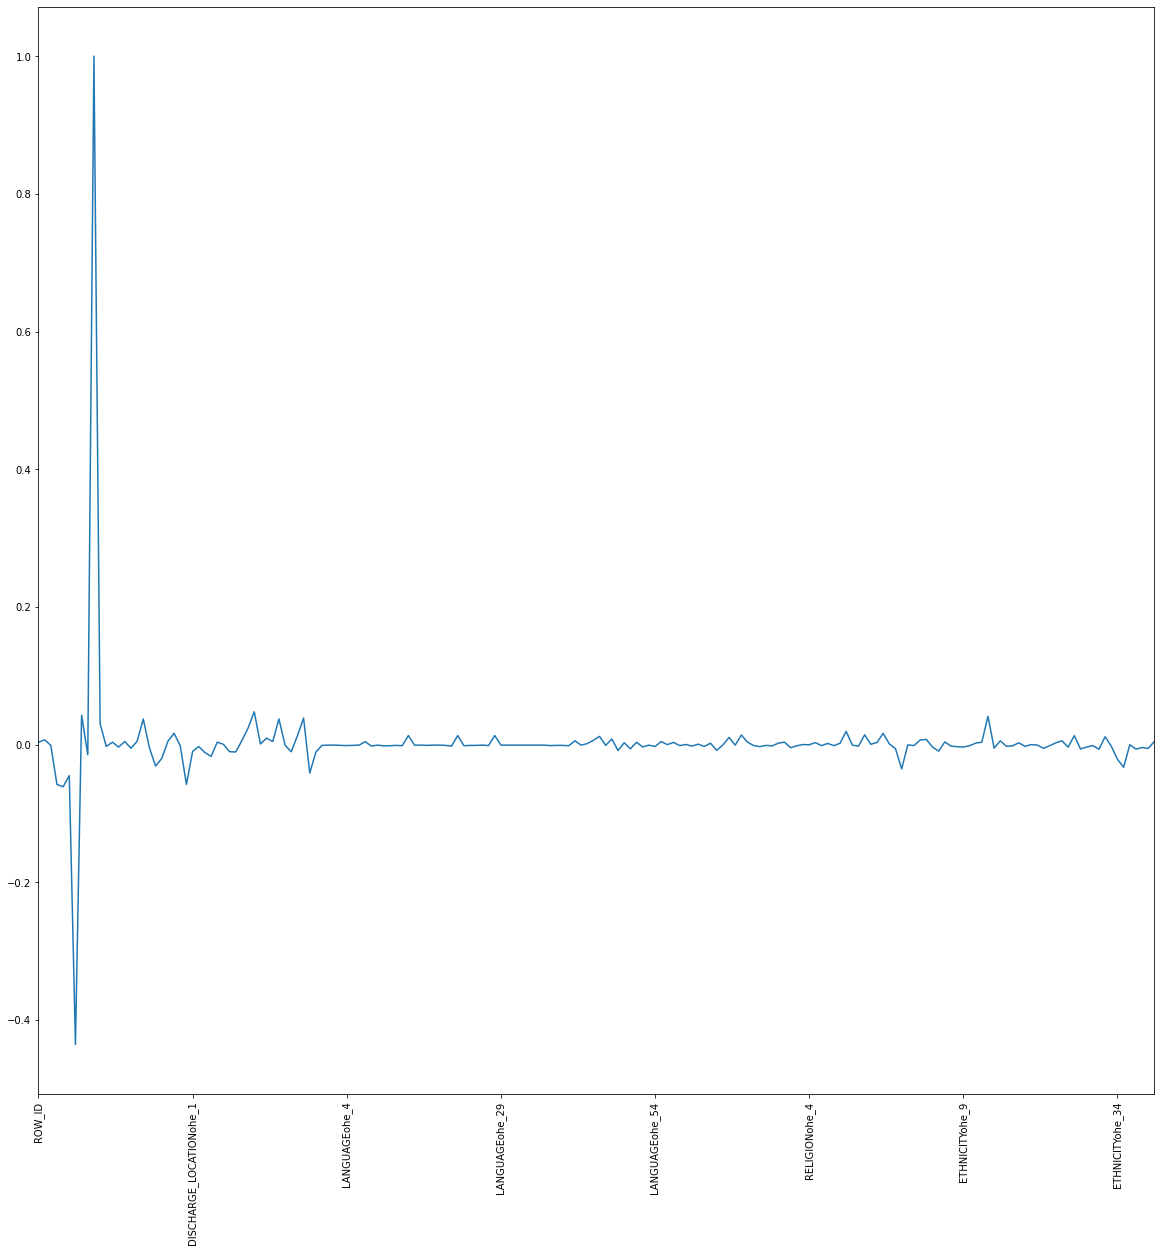

In [146]:
# correlation line plot for the correlation of TARGET col with the other numeric cols
plt.figure(figsize=(20, 20))
new_adm1.corr()['TARGET'].plot.line()
plt.xticks(rotation=90)

<AxesSubplot:>

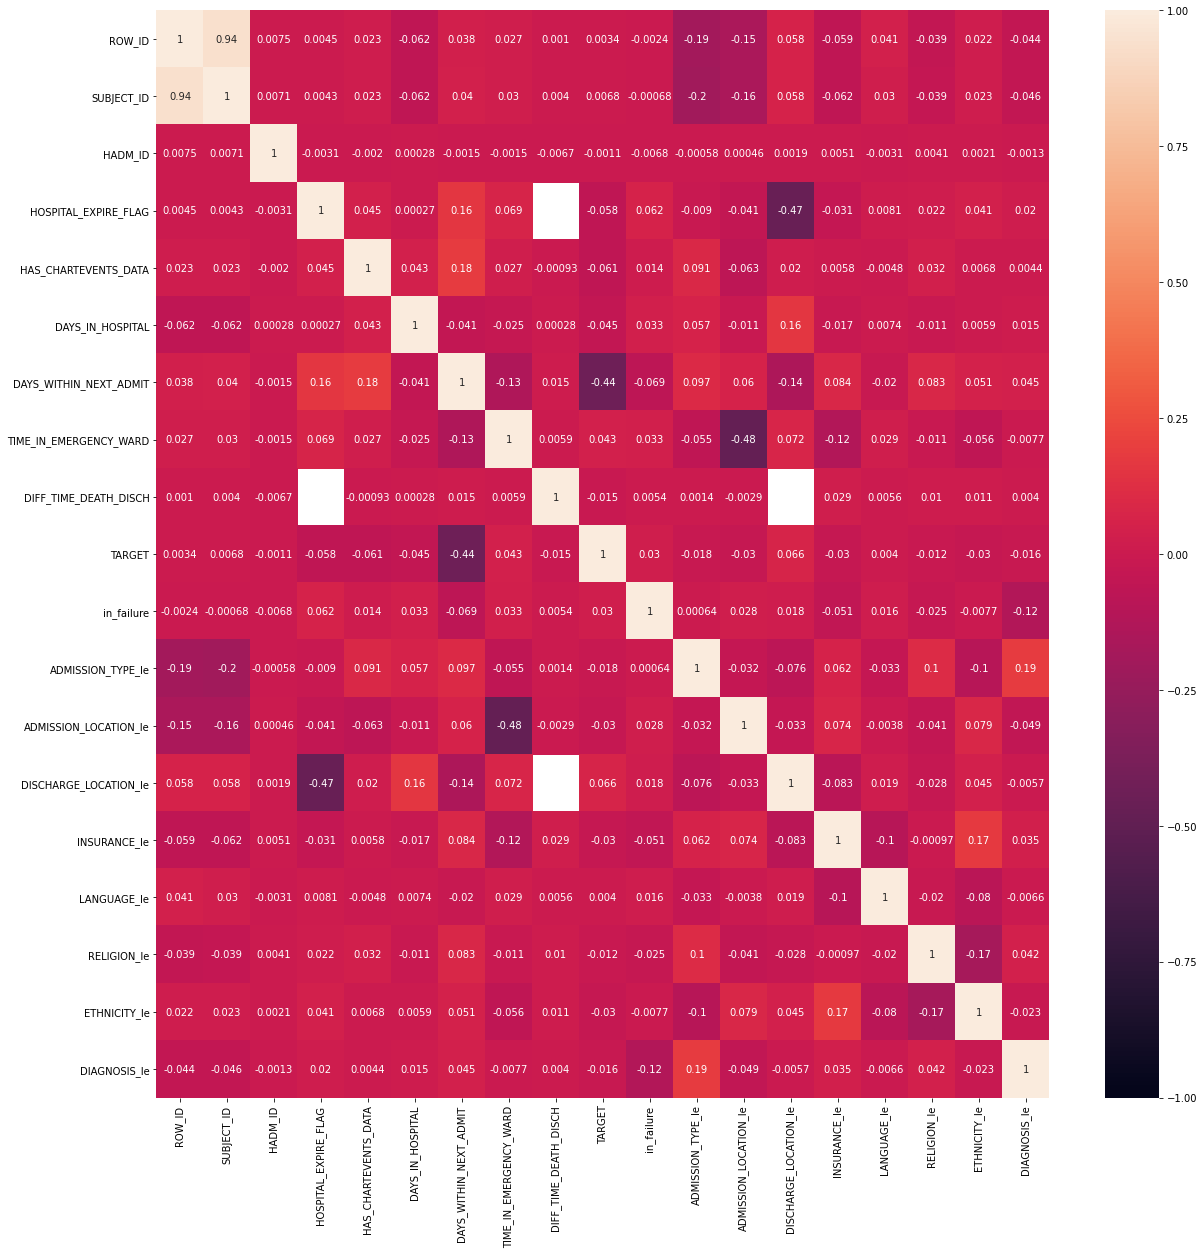

In [147]:
# heatmap plot of the correlation of the cols with the each other cols
plt.figure(figsize=(20, 20))
sns.heatmap(new_adm.corr(), vmin=-1, vmax=1, annot=True)

In [148]:
adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT', 'TIME_IN_EMERGENCY_WARD',
       'DIFF_TIME_DEATH_DISCH', 'TARGET', 'in_failure'],
      dtype='object')

In [149]:
del new_adm, new_adm1

## Analysis on the NOTES dataset

In [150]:
notes = pd.read_csv('NOTEEVENTS.csv.gz', compression='gzip')

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [151]:
notes.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')

In [152]:
notes.head(5)

ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   
2     176       13702  167118.0  2119-05-25       NaN       NaN   
3     177       13702  196489.0  2124-08-18       NaN       NaN   
4     178       26880  135453.0  2162-03-25       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   
2  Discharge summary      Report   NaN      NaN   
3  Discharge summary      Report   NaN      NaN   
4  Discharge summary      Report   NaN      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  
1  Admission Date:  [**2118-6-2**]       Discharg...  
2  Admission Date:  [**2119-5-4**]              D...  
3  Admission Date:  [**2124-7-21**]              ...  
4  Admission Date:  [**2162-3-3**]              D...

In [153]:
# check different categories present in the NOTES dataset
notes.CATEGORY.value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

In [154]:
# take only the Discharge Summaries
ds = notes.loc[notes.CATEGORY == 'Discharge summary']

In [155]:
del notes

In [156]:
# check the DESCRIPTION Value count for the summary notes
ds.DESCRIPTION.value_counts()

Report      55177
Addendum     4475
Name: DESCRIPTION, dtype: int64

In [157]:
# verify the NaN values
ds.TEXT.isna().value_counts()

False    59652
Name: TEXT, dtype: int64

In [158]:
# check whether ther eis any errorneous notes or not
ds.ISERROR.unique()

array([nan])

In [159]:
# check which discharge summaries are duplicated
ds[['SUBJECT_ID', 'HADM_ID']].duplicated(keep='last').value_counts()

False    52726
True      6926
dtype: int64

## Verify the value for duplication

In [160]:
ds.loc[ds.duplicated(['SUBJECT_ID', 'HADM_ID'], keep=False)].groupby(['SUBJECT_ID']).apply(lambda x: x['TEXT'])[9].values[0]

"Admission Date:  [**2149-11-9**]       Discharge Date: [**2149-11-13**]\n\nDate of Birth:   [**2108-1-26**]       Sex:  M\n\nService:  NEUROLOGY\n\nCHIEF COMPLAINT:  Weakness, inability to talk.\n\nHISTORY OF THE PRESENT ILLNESS:  This is a 41-year-old\nAfrican-American male with a history of hypertension who was\nin his usual state of health until about 10:25 a.m. on the\nmorning of admission.  He had gone to use the restroom and a\nfew minutes later his family found him slumped onto the\nfloor, apparently unable to talk and with weakness in his\nright arm and leg.  EMS was called and he was brought into\nthe Emergency Department at [**Hospital1 18**].\n\nThe patient has not had strokes or previous similar symptoms.\nHe has a history of hypertension but no history of cardiac\nsymptoms.  The patient was unable to talk for examination and\nno family members were present at the bedside and were not at\nhome (apparently they were on the way to the Emergency Room).\nThe history was obtain

In [161]:
ds.loc[ds.duplicated(['SUBJECT_ID', 'HADM_ID'], keep=False)].groupby(['SUBJECT_ID']).apply(lambda x: x['TEXT'])[9].values[1]

'Name:  [**Known lastname 10050**], [**Known firstname 779**]                      Unit No:  [**Numeric Identifier 10051**]\n\nAdmission Date:  [**2149-11-9**]     Discharge Date:  [**2149-11-14**]\n\nDate of Birth:   [**2108-1-26**]     Sex:  M\n\nService:\n\nDespite mannital and hyperventilation on the [**2149-11-13**], patient continued to neurologically decline.  A brain\ndeath exam was done showing that the patient had dilated\nunreactive pupils with no evidence of a corneal or gag\nreflex. He also did not respond to any noxious stimuli\ndespite being off propofol.\n\nAn apnea test was performed allowing the pCO2 to rise above\n60, and the patient still did not take any breath during the\n10 minute interval.  At this time he was declared brain\ndeath.  His family requested no organ donor or autopsy be\ndone.\n\n\n\n                          [**First Name8 (NamePattern2) 2121**] [**First Name8 (NamePattern2) **] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 9973**]\n\nDict

In [162]:
# check whether admissions are duplicated
adm.duplicated(['SUBJECT_ID', 'HADM_ID'], keep=False).value_counts()

False    58976
dtype: int64

In [163]:
# verify the text of the duplicated rows / admissions
ds.loc[ds.duplicated(['SUBJECT_ID', 'HADM_ID'], keep=False)].groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: x['TEXT'])

SUBJECT_ID  HADM_ID        
9           150750.0  22764    Admission Date:  [**2149-11-9**]       Dischar...
                      57341    Name:  [**Known lastname 10050**], [**Known fi...
13          143045.0  24464    Admission Date:  [**2167-1-8**]       Discharg...
                      56762    Name:  [**Known lastname 9900**], [**Known fir...
18          188822.0  9214     Admission Date:  [**2167-9-30**]              ...
                                                     ...                        
99712       159835.0  57783    Name:  [**Known lastname **],[**Known firstnam...
99814       186518.0  29359    Admission Date:  [**2142-2-16**]              ...
                      58439    Name:  [**Known lastname 13367**],[**Known fir...
99928       104802.0  23892    Admission Date:  [**2181-11-16**]             ...
                      58022    Name:  [**Known lastname **] [**Known lastname...
Name: TEXT, Length: 12646, dtype: object

In [164]:
# verify one row obtianed from the above row
adm.loc[(adm.SUBJECT_ID == 9) & (adm.HADM_ID == 150750)]

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
218       8           9   150750 2149-11-09 13:06:00 2149-11-14 10:15:00   

              DEATHTIME ADMISSION_TYPE    ADMISSION_LOCATION  \
218 2149-11-14 10:15:00      EMERGENCY  EMERGENCY ROOM ADMIT   

    DISCHARGE_LOCATION INSURANCE  ...        DIAGNOSIS HOSPITAL_EXPIRE_FLAG  \
218       DEAD/EXPIRED  Medicaid  ...  HEMORRHAGIC CVA                  1.0   

    HAS_CHARTEVENTS_DATA NEXT_ADMITTIME DAYS_IN_HOSPITAL  \
218                  1.0            NaT              4.0   

    DAYS_WITHIN_NEXT_ADMIT TIME_IN_EMERGENCY_WARD  DIFF_TIME_DEATH_DISCH  \
218                 8242.0               0.086806                    0.0   

     TARGET in_failure  
218       0          0  

[1 rows x 26 columns]

In [165]:
# check the number of the duplicated admissions
ds[['SUBJECT_ID', 'HADM_ID']].duplicated(keep=False).value_counts()

False    47006
True     12646
dtype: int64

In [166]:
# drop the duplicated and keep only the last summaries
ds = ds.drop_duplicates(['SUBJECT_ID', 'HADM_ID'], keep='last')

In [167]:
ds.shape

(52726, 11)

In [168]:
ds.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')

In [169]:
# coerce the ID datatype to common int datatype for merging
ds.SUBJECT_ID = ds.SUBJECT_ID.astype(int)
ds.HADM_ID = ds.HADM_ID.astype(int)

In [170]:
# coerce the ID datatype to common int datatype for merging
adm['SUBJECT_ID'] = adm['SUBJECT_ID'].astype(int)
adm['HADM_ID'] = adm['HADM_ID'].astype(int)

In [171]:
adm.shape

(58976, 26)

In [172]:
# verify the SUBJECT ID presence in each dataframe 
adm.SUBJECT_ID.isin(ds.SUBJECT_ID).value_counts()

True     53475
False     5501
Name: SUBJECT_ID, dtype: int64

In [173]:
# verify the admission ID presence in each dataframe
adm.HADM_ID.isin(ds.HADM_ID).value_counts()

True     52726
False     6250
Name: HADM_ID, dtype: int64

In [174]:
# merge the dataframes so that no admissions are missed
adm_ds = pd.merge(ds, adm, on=['SUBJECT_ID', 'HADM_ID'], how='right')

In [175]:
adm_ds.shape

(58976, 35)

In [176]:
# check the presence of admission id in the merged dataframe
np.unique(adm.index.isin(adm_ds.index), return_counts=True)

(array([ True]), array([58976]))

In [177]:
# check the reverse of the above operation to verify correctly
np.unique(adm_ds.index.isin(adm.index), return_counts=True)

(array([ True]), array([58976]))

In [178]:
# verify the TARGET values for the NaN counts
adm_ds.TARGET.isna().value_counts()

False    58976
Name: TARGET, dtype: int64

In [179]:
# verify whether the discharge summaries are not NaN
adm_ds.TEXT.isna().value_counts()

False    52726
True      6250
Name: TEXT, dtype: int64

In [181]:
# check the discharge location for the DISCHARGE SUMMARIES which are NaN
# this may happen because they might have some other form of notes category.
adm_ds.loc[adm_ds.TEXT.isna()].DISCHARGE_LOCATION.unique()

array(['HOME', 'DEAD/EXPIRED', 'DISC-TRAN CANCER/CHLDRN H',
       'LEFT AGAINST MEDICAL ADVI', 'HOME HEALTH CARE',
       'REHAB/DISTINCT PART HOSP', 'SNF', 'LONG TERM CARE HOSPITAL',
       'SHORT TERM HOSPITAL', 'HOSPICE-HOME', 'DISCH-TRAN TO PSYCH HOSP',
       'HOSPICE-MEDICAL FACILITY', 'HOME WITH HOME IV PROVIDR',
       'OTHER FACILITY', 'ICF'], dtype=object)

In [182]:
# get the TARGET value counts for the TEXT where they are NaN
adm_ds.loc[adm_ds.TEXT.isna()].TARGET.value_counts()

0    6040
1     210
Name: TARGET, dtype: int64

In [183]:
# get the TARGET vlaue counts
adm_ds.TARGET.value_counts()

0    56449
1     2527
Name: TARGET, dtype: int64

In [184]:
# now check the presence of the SUBJECT ID AND HADM ID which are present in merged dataframe and whose TEXT is NaN, and its presence in the notes dataframe
ds.loc[(ds.SUBJECT_ID.isin(adm_ds.loc[adm_ds.TEXT.isna()].SUBJECT_ID)) & (ds.HADM_ID.isin(adm_ds.loc[adm_ds.TEXT.isna()].HADM_ID))]

Empty DataFrame
Columns: [ROW_ID, SUBJECT_ID, HADM_ID, CHARTDATE, CHARTTIME, STORETIME, CATEGORY, DESCRIPTION, CGID, ISERROR, TEXT]
Index: []

In [185]:
# now check the presence of the SUBJECT ID AND HADM ID which are present in merged dataframe and whose TEXT is NaN
# its presence in the admssions datafrmae
adm.loc[(adm.SUBJECT_ID.isin(adm_ds.loc[adm_ds.TEXT.isna()].SUBJECT_ID)) & (adm.HADM_ID.isin(adm_ds.loc[adm_ds.TEXT.isna(), 'HADM_ID']))]

ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
211         1           2   163353 2138-07-17 19:04:00 2138-07-21 15:48:00   
214         4           5   178980 2103-02-02 04:31:00 2103-02-04 12:15:00   
216         6           7   118037 2121-05-23 15:05:00 2121-05-27 11:57:00   
217         7           8   159514 2117-11-20 10:22:00 2117-11-24 14:20:00   
223        13          16   103251 2178-02-03 06:35:00 2178-02-05 10:51:00   
...       ...         ...      ...                 ...                 ...   
58266   58827       99503   132396 2124-04-13 12:00:00 2124-04-13 17:14:00   
58276   58837       99534   130623 2178-11-19 01:23:00 2178-11-19 18:30:00   
58410   58843       99553   164310 2117-02-20 19:00:00 2117-02-21 03:30:00   
58584   58890       99715   157586 2150-10-04 16:01:00 2150-11-15 00:00:00   
56419   58956       99935   174624 2139-12-15 06:59:00 2139-12-15 12:00:00   

                DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
211                   NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
214                   NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
216                   NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
217                   NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
223                   NaT        NEWBORN  PHYS REFERRAL/NORMAL DELI   
...                   ...            ...                        ...   
58266                 NaT       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
58276                 NaT      EMERGENCY  CLINIC REFERRAL/PREMATURE   
58410 2117-02-21 03:30:00      EMERGENCY       EMERGENCY ROOM ADMIT   
58584 2150-11-15 00:00:00      EMERGENCY  CLINIC REFERRAL/PREMATURE   
56419 2139-12-15 12:00:00      EMERGENCY       EMERGENCY ROOM ADMIT   

      DISCHARGE_LOCATION INSURANCE  ...  \
211                 HOME   Private  ...   
214                 HOME   Private  ...   
216                 HOME   Private  ...   
217                 HOME   Private  ...   
223                 HOME   Private  ...   
...                  ...       ...  ...   
58266               HOME  Medicare  ...   
58276               HOME  Self Pay  ...   
58410       DEAD/EXPIRED  Medicare  ...   
58584       DEAD/EXPIRED  Medicare  ...   
56419       DEAD/EXPIRED  Medicare  ...   

                                          DIAGNOSIS HOSPITAL_EXPIRE_FLAG  \
211                                         NEWBORN                  0.0   
214                                         NEWBORN                  0.0   
216                                         NEWBORN                  0.0   
217                                         NEWBORN                  0.0   
223                                         NEWBORN                  0.0   
...                                             ...                  ...   
58266                     CHRONIC RENAL FAILURE SDA                  0.0   
58276  S P PEDESTRIAN STRUCKINTRACRANIAL HEMORRHAGE                  0.0   
58410                                CARDIAC ARREST                  1.0   
58584                            STATUS EPILEPTICUS                  1.0   
56419                       SUBARACHNOID HEMORRHAGE                  1.0   

      HAS_CHARTEVENTS_DATA      NEXT_ADMITTIME DAYS_IN_HOSPITAL  \
211                    1.0                 NaT              3.0   
214                    1.0                 NaT              2.0   
216                    1.0                 NaT              3.0   
217                    1.0                 NaT              4.0   
223                    1.0                 NaT              2.0   
...                    ...                 ...              ...   
58266                  0.0 2126-09-06 13:00:00              0.0   
58276                  1.0                 NaT              0.0   
58410                  0.0                 NaT              0.0   
58584                  1.0                 NaT             41.0   
56419                  1.0                 NaT    

In [186]:
# get the only the values where the discharge summary is not NaN
adm_ds = adm_ds.loc[adm_ds.TEXT.notna()]

In [187]:
# verify the values for SUBJECT ID and TEXT for NaN rows
ds.loc[ds.SUBJECT_ID.isin(adm_ds.loc[adm_ds.TEXT.isna(), 'SUBJECT_ID'])]

Empty DataFrame
Columns: [ROW_ID, SUBJECT_ID, HADM_ID, CHARTDATE, CHARTTIME, STORETIME, CATEGORY, DESCRIPTION, CGID, ISERROR, TEXT]
Index: []

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<AxesSubplot:xlabel='TEXT'>

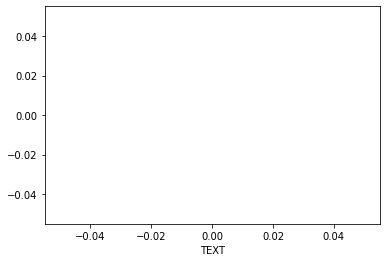

In [188]:
# verify using plots
sns.distplot(adm_ds.loc[adm_ds.TARGET.isna()].TEXT.apply(lambda x: len(x.split())))

<AxesSubplot:xlabel='TEXT', ylabel='count'>

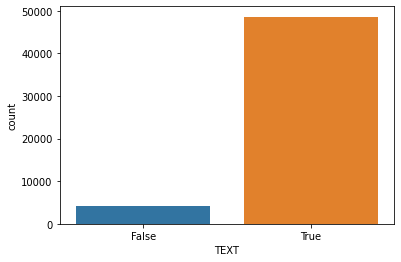

In [189]:
# plot the follow word count in the discharge summary notes
sns.countplot(adm_ds.loc[adm_ds.TARGET.notna()].TEXT.apply(lambda x: 'follow' in x.lower()))

In [190]:
del adm, ds

In [191]:
adm_ds.shape, adm_ds.loc[adm_ds.TARGET.notna()].shape

((52726, 35), (52726, 35))

In [192]:
# analyze the discharge summary text
adm_ds.TEXT[1]

'Admission Date:  [**2119-5-4**]              Discharge Date:   [**2119-5-25**]\n\n\nService: CARDIOTHORACIC\n\nAllergies:\nAmlodipine\n\nAttending:[**Last Name (NamePattern1) 1561**]\nChief Complaint:\n81 yo F smoker w/ COPD, severe TBM, s/p tracheobronchoplasty [**5-5**]\ns/p perc trach [**5-13**]\n\nMajor Surgical or Invasive Procedure:\nbronchoscopy 3/31,4/2,3,[**6-12**], [**5-17**], [**5-19**]\ns/p trachealplasty [**5-5**]\npercutaneous tracheostomy [**5-13**] after failed extubation\ndown size trach on [**5-25**] to size 6 cuffless\n\n\nHistory of Present Illness:\nThis 81 year old woman has a history of COPD. Over the past five\n\nyears she has had progressive difficulties with her breathing.\nIn\n[**2118-6-4**] she was admitted to [**Hospital1 18**] for respiratory failure\ndue\nto a COPD exacerbation. Due to persistent hypoxemia, she\nrequired\nintubation and a eventual bronchoscopy on [**2118-6-9**] revealed marked\n\nnarrowing of the airways on expiration consistent with\ntr

In [193]:
try:
  adm_ds.drop('FOLLOW_UP', axis=1, inplace=True)
except Exception as e:
  pass
# get the followUp bool column to check whether there is any follow up word in the summary text
adm_ds.loc[:, 'FOLLOW_UP'] = adm_ds.TEXT.apply(lambda x: ('follow up' in x.lower()) or ('followup' in x.lower())).astype(int)

In [194]:
adm_ds.FOLLOW_UP.value_counts()

1    42061
0    10665
Name: FOLLOW_UP, dtype: int64

In [195]:
adm_ds.loc[adm_ds.FOLLOW_UP == 0, 'TARGET'].value_counts()

0    10332
1      333
Name: TARGET, dtype: int64

In [196]:
# since there are no error in text, set ISERROR to 0
adm_ds.loc[adm_ds.ISERROR.isna(), 'ISERROR'] = 0

In [197]:
adm_ds.ISERROR.isna().value_counts()

False    52726
Name: ISERROR, dtype: int64

In [198]:
adm_ds.CGID.isna().value_counts()

True    52726
Name: CGID, dtype: int64

In [199]:
adm_ds.dtypes

ROW_ID_x                         float64
SUBJECT_ID                         int64
HADM_ID                            int64
CHARTDATE                         object
CHARTTIME                         object
STORETIME                         object
CATEGORY                          object
DESCRIPTION                       object
CGID                             float64
ISERROR                          float64
TEXT                              object
ROW_ID_y                           int64
ADMITTIME                 datetime64[ns]
DISCHTIME                 datetime64[ns]
DEATHTIME                 datetime64[ns]
ADMISSION_TYPE                    object
ADMISSION_LOCATION                object
DISCHARGE_LOCATION                object
INSURANCE                         object
LANGUAGE                          object
RELIGION                          object
MARITAL_STATUS                    object
ETHNICITY                         object
EDREGTIME                 datetime64[ns]
EDOUTTIME       

<AxesSubplot:>

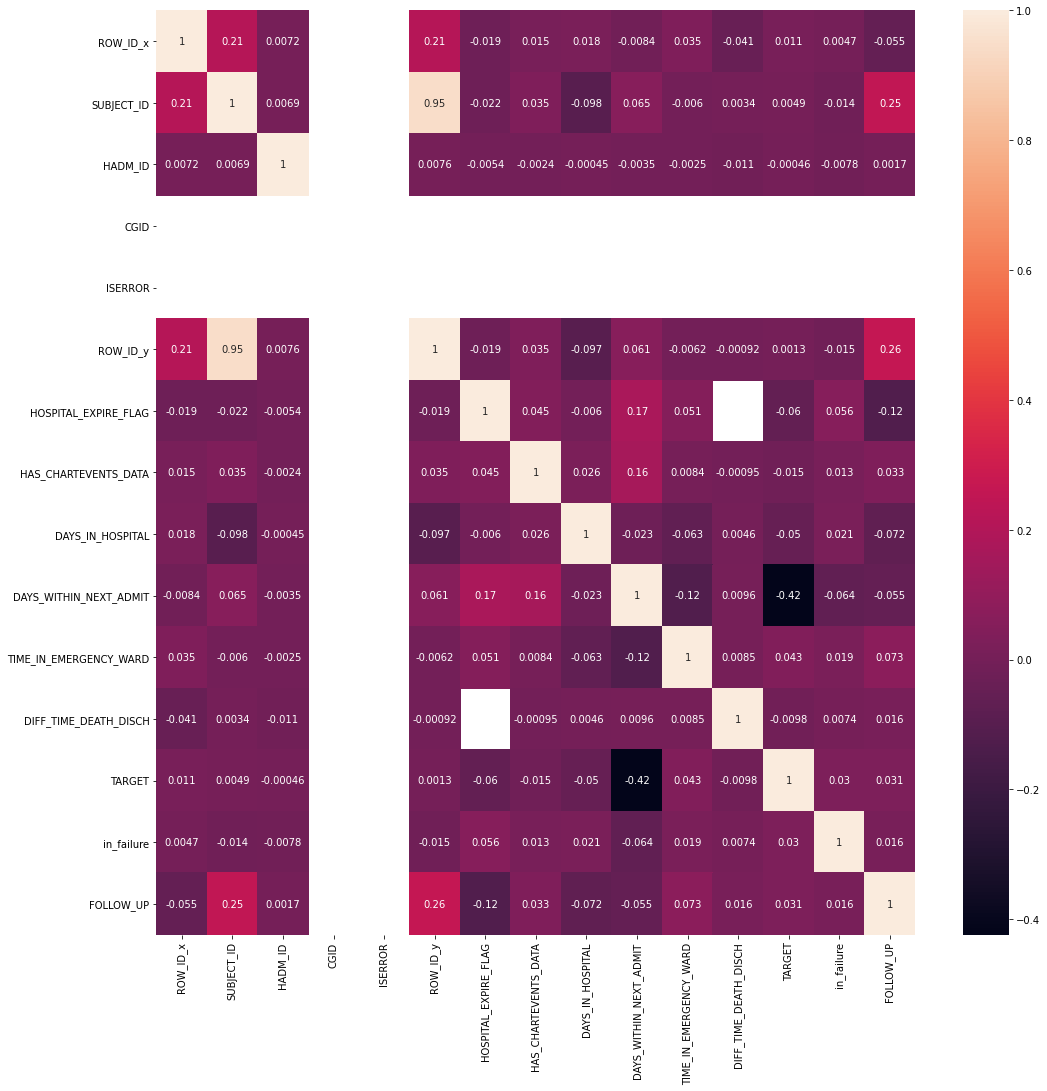

In [200]:
# plot the heatmap of the correlation of the merged dataframe
plt.figure(figsize=(17, 17))
sns.heatmap(adm_ds.corr(), annot=True)

In [201]:
adm_ds.columns

Index(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT',
       'ROW_ID_y', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME',
       'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA',
       'NEXT_ADMITTIME', 'DAYS_IN_HOSPITAL', 'DAYS_WITHIN_NEXT_ADMIT',
       'TIME_IN_EMERGENCY_WARD', 'DIFF_TIME_DEATH_DISCH', 'TARGET',
       'in_failure', 'FOLLOW_UP'],
      dtype='object')

In [202]:
adm_ds.DIAGNOSIS

0                    CHRONIC OBSTRUCTIVE PULMONARY DISEASE
1                            TRACHEALBRONCHEAL MALACEA SDA
2                                 ASTHMA COPD EXACERBATION
3                                       S P FALL TELEMETRY
4                             RIGHT TEMPORAL MENIGIOMA SDA
                               ...                        
52721                                          PERITONITIS
52722                              RESP DISTRESS PNEUMONIA
52723                              SUBARACHNOID HEMORRHAGE
52724    CORONARY ARTERY DISEASECORONARY ARTERY BYPASS ...
52725                                       LOWER GI BLEED
Name: DIAGNOSIS, Length: 52726, dtype: object

In [203]:
from wordcloud import WordCloud


# create a function that generates a word cloud, given a sentence
def generate_word_cloud(sentence):
  wc = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(sentence)

  plt.figure(figsize=(8,8))
  plt.imshow(wc)
  plt.axis("off")
  plt.tight_layout(pad=1)
  plt.show()

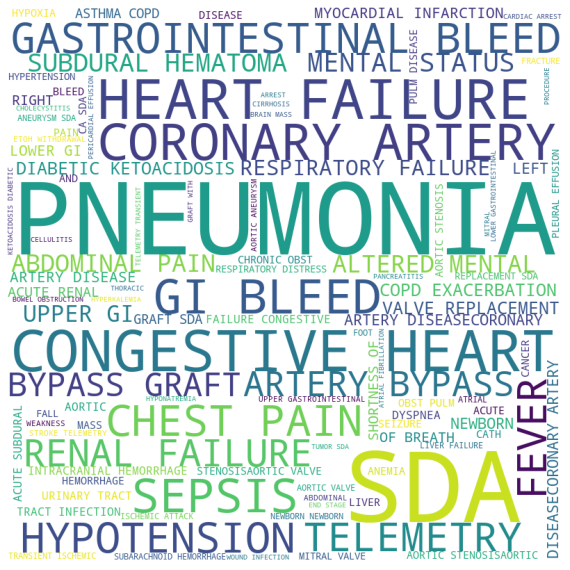

In [204]:
# generate word clound for DIAGNOSIS column when TARGET == 1
generate_word_cloud(' '.join(adm_ds.loc[adm_ds.TARGET == 1, 'DIAGNOSIS'].values))

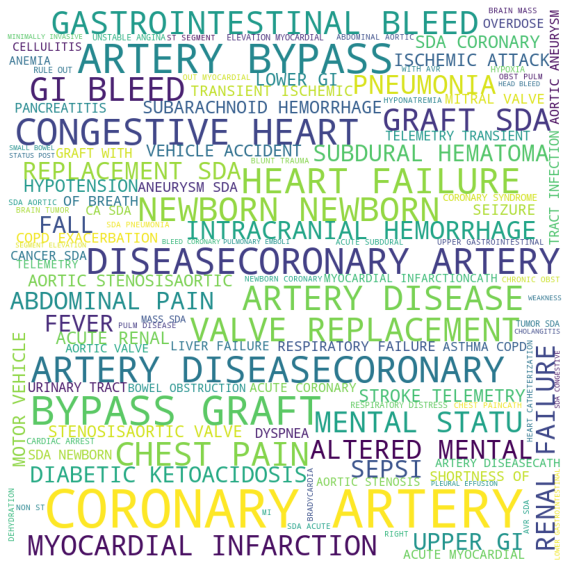

In [205]:
# generate word cloud for DIAGNOSIS column when TARGET == 0
generate_word_cloud(' '.join(adm_ds.loc[adm_ds.TARGET == 0, 'DIAGNOSIS'].values))

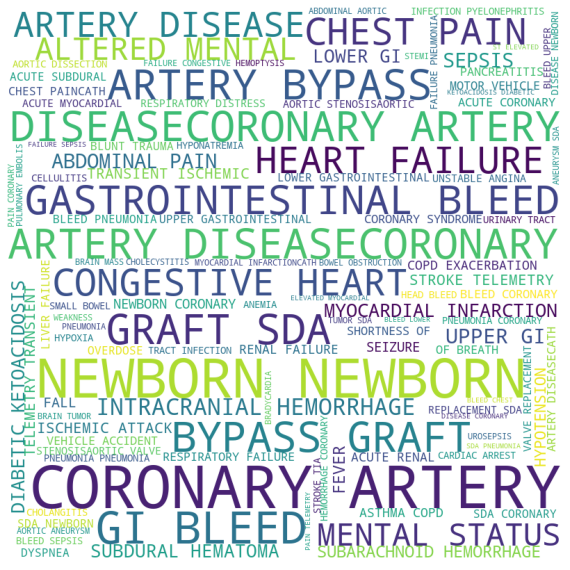

In [206]:
# generate word cloud for the top 100 occuring DIAGNOSIS value for TARGET == 0
sub_adm_ds = adm_ds.groupby('DIAGNOSIS').filter(lambda x: len(x) > 100)
generate_word_cloud(' '.join(sub_adm_ds.loc[sub_adm_ds.TARGET == 0, 'DIAGNOSIS'].values))

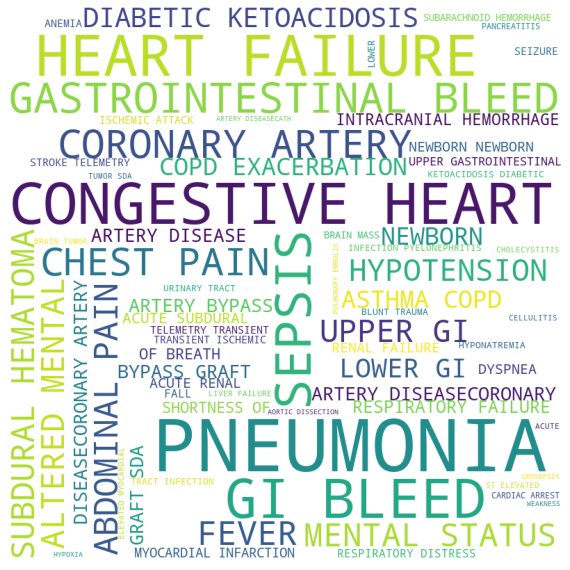

In [207]:
# generate word cloud for the top 100 occuring DIAGNOSIS value for TARGET == 1
generate_word_cloud(' '.join(sub_adm_ds.loc[sub_adm_ds.TARGET == 1, 'DIAGNOSIS'].values))

In [208]:
# get the value counts of the DIAGNOSIS col
adm_ds.DIAGNOSIS.value_counts().sort_values(ascending=False)

NEWBORN                                                          3612
PNEUMONIA                                                        1534
SEPSIS                                                           1151
CONGESTIVE HEART FAILURE                                          910
CORONARY ARTERY DISEASE                                           832
                                                                 ... 
SUPERIOR VENA CAVA SYNDROMEVENOGRAM THROMBOLISIS SDA                1
HYPOXIA SEIZURES                                                    1
BACTERIALMENINGITIS                                                 1
PLEURAL EFFUSION PNEUMONIA                                          1
AORTIC STENOSISAORTIC AND MITRAL VALVE REPLACEMENT REDO   TVR       1
Name: DIAGNOSIS, Length: 14829, dtype: int64

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DIAGNOSIS'>

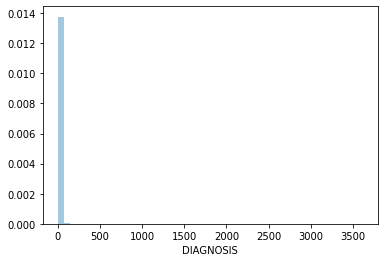

In [209]:
# many unique values
sns.distplot(adm_ds.DIAGNOSIS.value_counts())

In [210]:
adm_ds.loc[adm_ds.TARGET == 1].DIAGNOSIS.value_counts().sort_values(ascending=False)

PNEUMONIA                                                 102
CONGESTIVE HEART FAILURE                                   85
SEPSIS                                                     65
NEWBORN                                                    60
CHEST PAIN                                                 43
                                                         ... 
BRAINSTEM STROKE                                            1
GLASS INGESTION GI SCOPE                                    1
ACUTE RENAL FAILURE HEART FAILURE MITRAL REGURGITATION      1
RECURRENT BRAIN TUMOR SDA                                   1
RIGHT UPPER LOBE CA SDA                                     1
Name: DIAGNOSIS, Length: 1040, dtype: int64

<AxesSubplot:xlabel='DIAGNOSIS'>

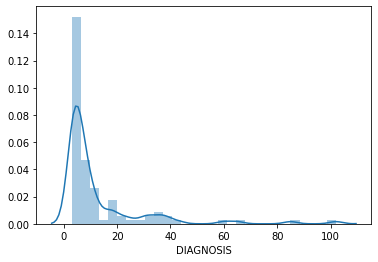

In [211]:
# plot the distribution plot of the top 100 DIAGNOSIS value when TAGRET == 1
sns.distplot(adm_ds.loc[adm_ds.TARGET == 1, 'DIAGNOSIS'].value_counts().nlargest(100))

In [212]:
# plot the DIAGNOSIS value counts for the TARGET == 0
adm_ds.loc[adm_ds.TARGET == 0].DIAGNOSIS.value_counts().sort_values(ascending=False)

NEWBORN                                                                                  3552
PNEUMONIA                                                                                1432
SEPSIS                                                                                   1086
CONGESTIVE HEART FAILURE                                                                  825
CORONARY ARTERY DISEASE                                                                   809
                                                                                         ... 
RESPIRATORY FAILUREUROSEPSIS                                                                1
LE WEAKNESS                                                                                 1
HYPOTENSION MOTOR VEHICLE ACCIDENT                                                          1
THOMACIC ANEURYSMTHORACOABDOMINAL ENDARTERECTOMY  RIGHT PARTIAL BYPASS  LUBAR DRAIN         1
SYSTOLIC HEART FAILURE ISCHEMIC CARDIOMYOPATHYCARDIAC CATHET

In [213]:
# get only 0.2% occuring DIAGNOSIS numbers
(adm_ds.DIAGNOSIS.value_counts().sort_values(ascending=False) / adm_ds.shape[0] > 0.002).value_counts()

False    14765
True        64
Name: DIAGNOSIS, dtype: int64

In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [215]:
tfidf = TfidfVectorizer()

In [216]:
# again do diagnosis correlation on the merged dataframe
diagnosis_features = tfidf.fit_transform(adm_ds.DIAGNOSIS.values).toarray()

In [217]:
tfidf_df = pd.DataFrame(diagnosis_features, columns=tfidf.get_feature_names())

In [218]:
del tfidf, diagnosis_features

In [219]:
import gc
gc.collect()

11066

In [220]:
# find the DIAGNOSIS correlation on the TARGET column using the merged dataframe
corr = []

for col in tfidf_df.columns:
  corr.append(tfidf_df[col].corr(adm_ds['TARGET'], method='spearman'))

In [221]:
# plot the DIAGNOSIS feature column most correlation with the TARGET column
pd.Series(corr, index=tfidf_df.columns).sort_values(ascending=False)

failure                              0.030499
carboplatin                          0.028728
paclitaxel                           0.028728
stoma                                0.028728
tracheobronchomalaciabronchoscopy    0.028728
                                       ...   
graft                               -0.016382
sda                                 -0.019764
artery                              -0.023349
coronary                            -0.024136
newborn                             -0.036163
Length: 6106, dtype: float64

In [222]:
# plot the DIAGNOSIS feature column least correlation with the TARGET column
pd.Series(corr, index=tfidf_df.columns).sort_values()

newborn                             -0.036163
coronary                            -0.024136
artery                              -0.023349
sda                                 -0.019764
graft                               -0.016382
                                       ...   
tracheobronchomalaciabronchoscopy    0.028728
stoma                                0.028728
paclitaxel                           0.028728
carboplatin                          0.028728
failure                              0.030499
Length: 6106, dtype: float64

In [223]:
del tfidf_df

In [224]:
# get the feature in_failure from teh DIAGNOSIS column
adm_ds.loc[:, 'in_failure'] = adm_ds.DIAGNOSIS.apply(lambda x: int('failure' in x.lower()))

In [225]:
# get the correlation of in_failure with the TARGET column
adm_ds.in_failure.corr(adm_ds.TARGET)

0.030179229148938086

In [226]:
# get the correlation of in_failure with the HOSPITAL_EXPIRE_FLAG column
adm_ds.in_failure.corr(adm_ds.HOSPITAL_EXPIRE_FLAG)

0.055619463799126224

In [227]:
adm_ds.TEXT[1000]

"Admission Date:  [**2114-6-4**]              Discharge Date:   [**2114-6-9**]\n\nDate of Birth:  [**2035-2-19**]             Sex:   F\n\nService: MEDICINE\n\nAllergies:\nAspirin\n\nAttending:[**First Name3 (LF) 800**]\nChief Complaint:\nSOB on exertion\n\nMajor Surgical or Invasive Procedure:\nSwan-Ganz catheterization\n\n\nHistory of Present Illness:\n79 year-old female with history of sarcoidosis, moderate\npulmonary hypertension, ILD, and diabetes mellitus type 2 who\npresents with acute on chronic dyspnea.  She is followed by Dr.\n[**Last Name (STitle) **] as an outpatient and was last seen by him on [**2114-5-25**];\nat that time, she was doing well, satting 95% on 4L at rest.\nHer recent history is notable for an admission at the end of\n[**2114-3-4**] where she presented with worsening dyspnea, ruled out\nfor PE, and was transitioned from prednisone to sildenafil.  She\nhas seen Dr. [**Last Name (STitle) **] in the interim and started on lasix for\nvolume overload in the settin

In [228]:
# the TARGET == 1, analyze the text values for them
adm_ds.loc[adm_ds.TARGET == 1, 'TEXT'].reset_index(drop=True)[0]

"Admission Date:  [**2189-2-18**]       Discharge Date:  [**2189-2-26**]\n\n\nService:  CCU\n\nPlease note that this interval dictation takes up on [**2189-2-23**], where the dictation of Dr. [**First Name8 (NamePattern2) 1586**] [**Name (STitle) **] previously\ndictated left off.\n\nADDITIONAL HOSPITAL COURSE:  The patient was transferred from\nthe Coronary Care Unit to the floor at approximately 3 A.M.\non [**2-23**], without event.  At approximately 9 A.M., the\npatient began to complain of shortness of breath and was\nfound to be tachycardic to the 150s after walking a distance\nto the bathroom.  The patient's electrocardiogram\ndemonstrated sinus tachycardia with ST elevations in Leads V2\nand V3, otherwise the electrocardiogram was unchanged.  On\nexamination, the patient had a blood pressure of 146/60,\npulse of 135, pulse oxygenation 98% on 2 liters, was\ndiffusely wheezy on respiratory examination, and was markedly\ndiaphoretic, without jugular venous distention or edema.  The

In [229]:
# for sentiment and subjectivity analysis
from textblob import TextBlob

In [230]:
import re

In [231]:
# compile re objects for cleaning the text columns
pattern = re.compile('\[.{1,}?\]')
white_space_pattern = re.compile('[\t]*')
new_line_pattern = re.compile('[\n]+')
extra_space_pattern = re.compile(' +')
# re for extracting the services from teh summary text
pattern1_small = re.compile(r'(?<=Service:).*')
pattern1_not_small = re.compile(r'(?<=SERVICE:).*')

index_words = [
               'HISTORY',
               'CHIEF',
               'IDENTIFICATION',
               'HOSPITAL',
]

extra_words = [
    'Admission Date: ',
    'Discharge Date: ',
    'Service:',
    'Date of Birth: ',
]

till_words = [
              'dictated by',
              'completed by'
]

def clean_squares(text):
  all_occurences = pattern.findall(text)
  for each_word in all_occurences:
    text = text.replace(each_word, '')
  return text

def remove_extra_words(text):
  for each_word in extra_words:
    text = text.replace(each_word, '')
  return text

def clean_whitespaces(text):
  text = white_space_pattern.sub('', text)
  text = new_line_pattern.sub(' ', text)
  return text

def find_and_remove_till_service(text):
  if 'Service:' in text:
    service_string = ' '.join(pattern1_small.findall(text)).strip()
    service_index = text.index('Service')
  elif 'SERVICE' in text:
    service_string = ' '.join(pattern1_not_small.findall(text)).strip()
    service_index = text.index('SERVICE')
  else:
    service_string = ''
    indices = []
    for each_word in index_words:
      try:
        indices.append(text.index(each_word))
      except Exception as e:
        indices.append(0)
    service_index = min(indices)
  text = text[service_index:]
  if 'Service:' in text:
    text = text.replace('Service:', '')
  elif 'SERVICE:' in text:
    text = text.replace('SERVICE:', '')
  text = text.replace(service_string, '')

  till_index = []
  for each_till_word in till_words:
    try:
      till_index.append(text.lower().rindex(each_till_word))
    except Exception as e:
      till_index.append(-1)
  
  text = text[:max(till_index)]

  return service_string, text

def get_actual_summary_and_service(text):
  text = clean_squares(text)
  service_string, text = find_and_remove_till_service(text)
  # text = remove_extra_words(text)
  text = clean_whitespaces(text)
  return {'cleaned_text' : text, 'service': service_string}

In [232]:
# clean the summary text and return it in a temp_df dataframe
# remove square, extra white spaces, and extract service from it
temp_df = adm_ds.TEXT.apply(lambda x: pd.Series(get_actual_summary_and_service(x)))

<AxesSubplot:xlabel='cleaned_text'>

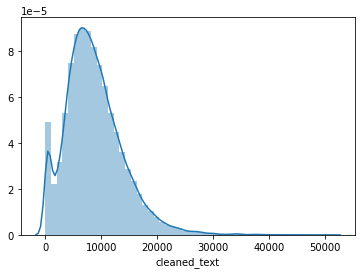

In [233]:
# get the distribution of the length of the cleaned text
sns.distplot(temp_df.cleaned_text.apply(lambda x: len(x)))

<AxesSubplot:xlabel='cleaned_text'>

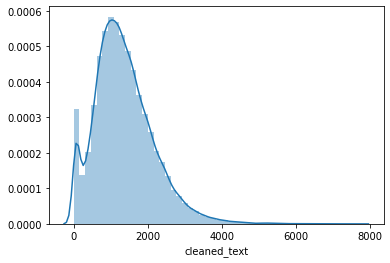

In [234]:
# get the distribution of number of words in teh cleaned text
sns.distplot(temp_df.cleaned_text.apply(lambda x: len(x.split())))

In [235]:
# import nltk for removing stop words, stemming, lemmatizing
import nltk

In [236]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeradwilliams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [237]:
from nltk.tokenize import word_tokenize

In [238]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [239]:
# for stemming, lemmatizing
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeradwilliams/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [240]:
# for word tokenizing
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeradwilliams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [241]:
import string

In [242]:
# stemmer and lemmatizer
english_stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()

In [243]:
# get stop weords list
stop_words = stopwords.words()

In [244]:
puncts = string.punctuation

In [245]:
puncts

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [246]:
# create re from the above punctuation symbols
punct_re = re.compile(r"[!\"#$%&\'\(\)\*+,./:;<=>?@\[\\\]^_`\{|\}~]")

In [247]:
puncts

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [248]:
# tokenize words, remove stop words, remove punctuations, stem words
def preprocess_text(text):
  tokens = word_tokenize(text)
  new_words = []
  for each_word in tokens:
    if each_word not in stop_words:
      new_words.append(wordnet_lemmatizer.lemmatize(english_stemmer.stem(punct_re.sub('', each_word))))
  
  return ' '.join(new_words)

In [249]:
def clean_service(text):
  text = re.sub('\W\d', '', text).strip().split()
  unique_text = set(text)
  unq_text = []
  for each_txt in text:
    if each_txt in unique_text and each_txt not in unq_text:
      unq_text.append(each_txt)
  return ' '.join(unq_text)

In [250]:
temp_df.service.isna().value_counts()

False    52726
Name: service, dtype: int64

In [251]:
# remove whitespaces and get only unique text in the service
temp_df['service1'] = temp_df['service'].fillna('').apply(lambda x: clean_service(x).strip())

In [252]:
# fill the Null service with other
temp_df.loc[temp_df.service1 == '', 'service1'] = 'other'

In [253]:
# verify the preprocess function
preprocess_text(temp_df.cleaned_text[0])

'histori of present ill  this 81-year-old femal histori emphysema  home o2   present three day short breath thought primari doctor copd flare  two day prior admiss  start prednison taper day prior admiss requir oxygen home order maintain oxygen satur greater 90   she levofloxacin nebul  get better  present emerg room  in emerg room  oxygen satur 100  cpap  she abl wean despit nebul treatment solu-medrol 125 mg iv x2  review system negat follow  fever  chill  nausea  vomit  night sweat  chang weight  gastrointestin complaint  neurolog chang  rash  palpit  orthopnea  is posit follow  chest pressur occasion short breath exert  short breath posit relat  improv nebul treatment  past medic histori  1  copd  last pulmonari function test demonstr fvc 52  predict  fev1 54  predict  mmf 23  predict  fev1  fvc ratio 67  predict  improv bronchodil treatment  the fvc  howev  signific improv bronchodil treatment consist known revers air flow obstruct addit under restrict ventilatori defect  the pati

In [254]:
# preprocess text to get the words in their root form and remove stop words
temp_df.loc[:, 'cleaned_text1'] = temp_df['cleaned_text'].apply(lambda x: preprocess_text(x))

In [256]:
temp_df

cleaned_text  \
0         HISTORY OF PRESENT ILLNESS:  This is an 81-...   
1        Allergies: Amlodipine Attending: Chief Compl...   
2        Allergies: Amlodipine Attending: Chief Compl...   
3        Allergies: Patient recorded as having No Kno...   
4        Allergies: No Known Allergies / Adverse Drug...   
...                                                  ...   
52721    Allergies: Gluten / Gentamicin / Zithromax A...   
52722      ADDENDUM: Events following the first disch...   
52723    Allergies: No Known Allergies / Adverse Drug...   
52724    Allergies: No Known Allergies / Adverse Drug...   
52725    Allergies: Novocain / ciprofloxacin Attendin...   

                          service                   service1  \
0      MICU and then to  Medicine  MICU and then to Medicine   
1                  CARDIOTHORACIC             CARDIOTHORACIC   
2                        MEDICINE                   MEDICINE   
3                        MEDICINE                   MEDICINE   
4                    NEUROSURGERY               NEUROSURGERY   
...                           ...                        ...   
52721                    MEDICINE                   MEDICINE   
52722                          ME                         ME   
52723                NEUROSURGERY               NEUROSURGERY   
52724              CARDIOTHORACIC             CARDIOTHORACIC   
52725                    MEDICINE                   MEDICINE   

                                           cleaned_text1  
0      histori of present ill  this 81-year-old femal...  
1      allergi  amlodipin attend  chief complaint  81...  
2      allergi  amlodipin attend  chief complaint  co...  
3      allergi  patient record no known allergi drug ...  
4      allergi  no known allergi  advers drug reactio...  
...                                                  ...  
52721  allergi  gluten  gentamicin  zithromax attend ...  
52722  addendum  event follow first discharg summari ...  
52723  allergi  no known allergi  advers drug reactio...  
52724  allergi  no known allergi  advers drug reactio...  
52725  allergi  novocain  ciprofloxacin attend  adden...  

[52726 rows x 4 columns]

In [257]:
# get the value counts of the cleaned service col
temp_df['service1'].value_counts()

MEDICINE                        20602
CARDIOTHORACIC                   6183
SURGERY                          5364
other                            4735
NEUROSURGERY                     2361
                                ...  
MEDICINE Otolaryngology             1
FIRM, MEDICINE                      1
HEPATOBILIARY (BLUE) SURGERY        1
BONE                                1
/ICU                                1
Name: service1, Length: 858, dtype: int64

In [258]:
# get the value counts of the extracted service column
temp_df.service.value_counts()

MEDICINE                  20601
CARDIOTHORACIC             6181
SURGERY                    5364
                           4735
NEUROSURGERY               2361
                          ...  
Medicine -  Team              1
GENERAL SURGERY - BLUE        1
Progressive care unit         1
Inpatient  Medicine           1
MEDICINE   MED                1
Name: service, Length: 884, dtype: int64

In [259]:
temp_df.shape

(52726, 4)

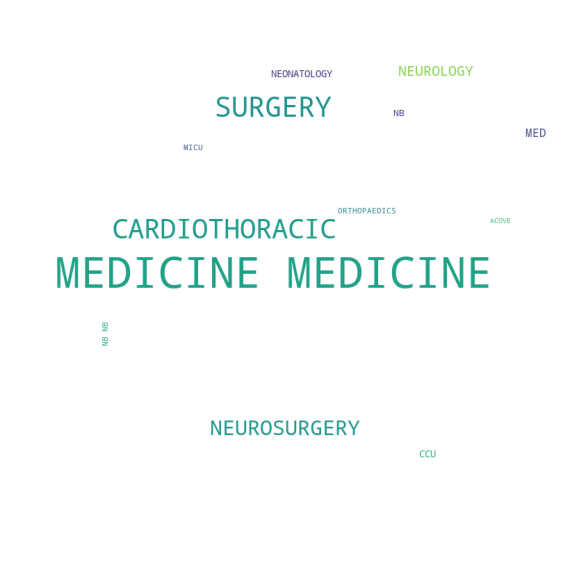

In [260]:
# plot word cloud of the service column for TAGRET == 1
generate_word_cloud(' '.join(temp_df.loc[adm_ds.TARGET == 1, 'service1'].values))

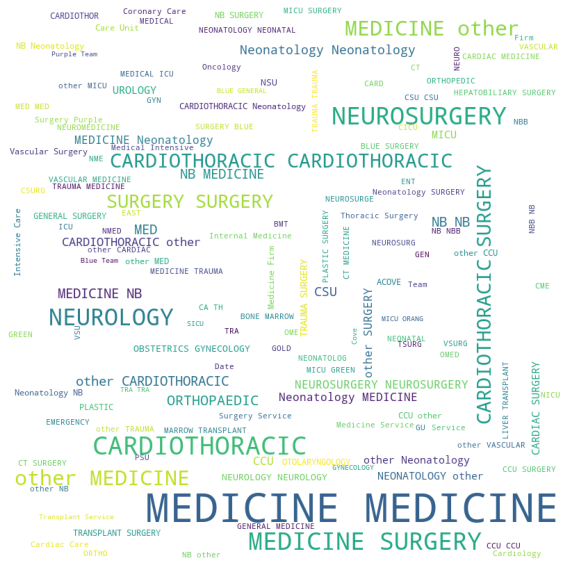

In [261]:
# plot word cloud of the service column for TAGRET == 0
generate_word_cloud(' '.join(temp_df.loc[adm_ds.TARGET == 0, 'service1'].values))

In [262]:
# copy the cleaned text and the service to the merged datafrmae
adm_ds['service1'] = temp_df['service1']
adm_ds['cleaned_text'] = temp_df['cleaned_text']

In [263]:
adm_ds.head(5)

ROW_ID_x  SUBJECT_ID  HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     175.0       13702   107527  2118-06-14       NaN       NaN   
1     176.0       13702   167118  2119-05-25       NaN       NaN   
2     177.0       13702   196489  2124-08-18       NaN       NaN   
3     178.0       26880   135453  2162-03-25       NaN       NaN   
4     179.0       53181   170490  2172-03-08       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  ...      NEXT_ADMITTIME  \
0  Discharge summary      Report   NaN      0.0  ... 2119-05-04 07:15:00   
1  Discharge summary      Report   NaN      0.0  ... 2124-07-21 16:09:00   
2  Discharge summary      Report   NaN      0.0  ...                 NaT   
3  Discharge summary      Report   NaN      0.0  ...                 NaT   
4  Discharge summary      Report   NaN      0.0  ...                 NaT   

   DAYS_IN_HOSPITAL DAYS_WITHIN_NEXT_ADMIT TIME_IN_EMERGENCY_WARD  \
0              11.0                  335.0               0.563889   
1              21.0                 1905.0               0.000000   
2              28.0                 8242.0               0.281944   
3              21.0                 8242.0               0.184722   
4               3.0                 8242.0               0.000000   

  DIFF_TIME_DEATH_DISCH TARGET in_failure FOLLOW_UP  \
0                   NaN      0          0         1   
1                   NaN      0          0         0   
2                   NaN      0          0         1   
3                   NaN      0          0         1   
4                   NaN      0          0         1   

                    service1  \
0  MICU and then to Medicine   
1             CARDIOTHORACIC   
2                   MEDICINE   
3                   MEDICINE   
4               NEUROSURGERY   

                                        cleaned_text  
0     HISTORY OF PRESENT ILLNESS:  This is an 81-...  
1    Allergies: Amlodipine Attending: Chief Compl...  
2    Allergies: Amlodipine Attending: Chief Compl...  
3    Allergies: Patient recorded as having No Kno...  
4    Allergies: No Known Allergies / Adverse Drug...  

[5 rows x 38 columns]

In [264]:
# get sentiment of the cleaned_text
adm_ds.loc[:, 'sentiment'] = adm_ds['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [265]:
# get subjectivity of the cleaned_text
adm_ds.loc[:, 'subjectivty'] = adm_ds['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

<AxesSubplot:xlabel='sentiment'>

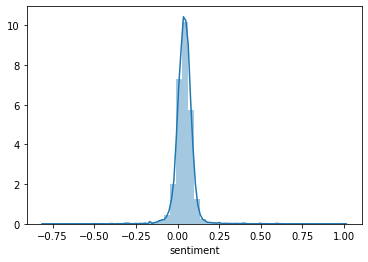

In [266]:
# plot the distribution of the sentiment of the cleaned text
sns.distplot(adm_ds.loc[adm_ds.TARGET == 0].sentiment)

<AxesSubplot:xlabel='subjectivty'>

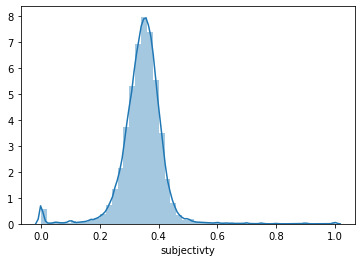

In [267]:
# plot the distribution of subjectivity of the cleaned text
sns.distplot(adm_ds.loc[adm_ds.TARGET == 0].subjectivty)

In [268]:
# copy the processed cleaned text and service to the merged dataframe
adm_ds.loc[:, 'cleaned_text1'] = temp_df['cleaned_text1']
adm_ds.loc[:, 'service1'] = temp_df['service1']

In [269]:
del temp_df

In [270]:
# get the final TARGET value distribution
adm_ds.TARGET.value_counts() / adm_ds.shape[0] * 100

0    95.605584
1     4.394416
Name: TARGET, dtype: float64

In [271]:
# save the final processed dataframe to csv
adm_ds.to_csv('adm_ds2.csv')

In [272]:
import gc

In [273]:
gc.collect()

125

In [274]:
import nltk

In [275]:
# to do analysis of the summary text most occuring counts
from sklearn.feature_extraction.text import CountVectorizer

In [276]:
# generalized function to get the counts of the words occuring in the summary text
def get_top_n_words(text, ngram=1, n=None, remove_stop_words=False):
  if not remove_stop_words:
    vec = CountVectorizer(ngram_range=ngram).fit(text)
  else:
    vec = CountVectorizer(ngram_range=ngram, stop_words='english').fit(text)
  bag_of_words = vec.transform(text)

  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

  return words_freq[:n]

In [277]:
# get the common words from teh processed cleaned text
common_words = get_top_n_words(adm_ds.cleaned_text1, (1, 1), 20)

<AxesSubplot:ylabel='TEXT'>

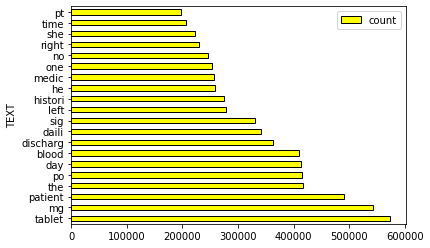

In [278]:
# plot the bar graph of the common words occuring in the cleaned text
pd.DataFrame(common_words, columns=['TEXT', 'count']).set_index('TEXT').plot.barh(color='yellow', edgecolor='black', ecolor='blue')

In [279]:
# get the bigram of the common words occuring in the processed cleaned text
common_words = get_top_n_words(adm_ds.cleaned_text1, (2, 2), 20)

<AxesSubplot:ylabel='TEXT'>

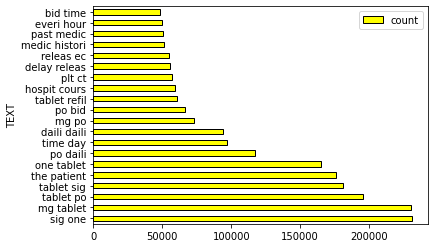

In [280]:
# plot the value counts of the words obtained above
pd.DataFrame(common_words, columns=['TEXT', 'count']).set_index('TEXT').plot.barh(color='yellow', edgecolor='black', ecolor='blue')

In [281]:
# get the common words from the cleaned text
common_words = get_top_n_words(adm_ds.cleaned_text, (1, 1), 20, True)

<AxesSubplot:ylabel='TEXT'>

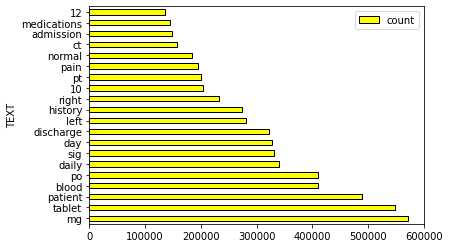

In [282]:
# plot the common words obtained above
pd.DataFrame(common_words, columns=['TEXT', 'count']).set_index('TEXT').plot.barh(color='yellow', edgecolor='black', ecolor='blue')

In [283]:
# get the bigrams of the cleaned summary text and its counts
common_words = get_top_n_words(adm_ds.cleaned_text, (2, 2), 20, True)

<AxesSubplot:ylabel='TEXT'>

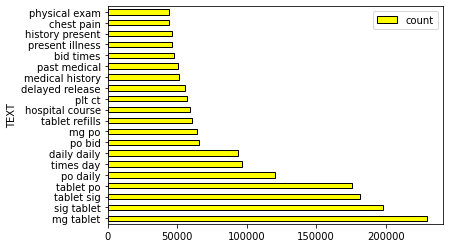

In [284]:
# plot the summary of the common words obtained above
pd.DataFrame(common_words, columns=['TEXT', 'count']).set_index('TEXT').plot.barh(color='yellow', edgecolor='black', ecolor='blue')

<AxesSubplot:xlabel='cleaned_text'>

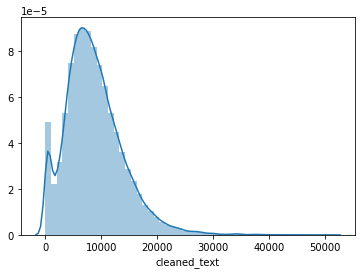

In [285]:
sns.distplot(adm_ds.cleaned_text.apply(lambda x: len(x)))

<AxesSubplot:xlabel='cleaned_text1'>

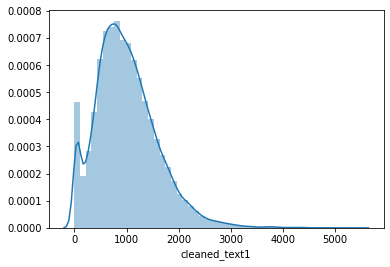

In [286]:
sns.distplot(adm_ds.cleaned_text1.apply(lambda x: len(x.split())))

In [287]:
gc.collect()

58

In [288]:
from sklearn.decomposition import TruncatedSVD

In [289]:
# get the top 1000 independent components of the summary text
pca = TruncatedSVD(random_state=42, n_components=1000)

In [290]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [291]:
tfidf = TfidfVectorizer()

In [292]:
# get the tfidf feature of the summary text
features = tfidf.fit_transform(adm_ds.TEXT)

In [293]:
# get the independent components of the summary text
decom_features = pca.fit_transform(features)

In [294]:
decom_features.shape

(52726, 1000)

In [295]:
# check how independen the componets are using explained variance ratio sum
sum(pca.explained_variance_ratio_)

0.6444897904422374

In [296]:
from sklearn.manifold import TSNE

In [297]:
# plot the TSNE plot to visualize the top 2 independent components from the top 1000 components obtained above
tsne = TSNE(n_components=2, n_iter=250, random_state=42)

In [298]:
tsne_features = tsne.fit_transform(decom_features)

<AxesSubplot:>

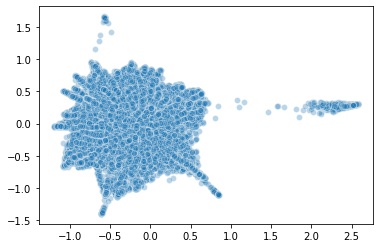

In [299]:
# scatter plot the tsne component obtained from the transformation above
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], palette=sns.color_palette("hls", 10), legend="full", alpha=0.3)